In [1]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx
import random
import joblib

temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [2]:
def form_edge_matrix(g, label, step=None, action=None):
    """
    Extract the labeled property from edges into a matrix

    Parameters
    ----------
    g : nx.Graph
        The graph to extract data from
    label : str
        The label to use for extracting edge properties
    action : str, optional, default=None
        If 'symmetrize', will return a symmetric matrix where A[i,j] = A[j,i]
        If 'antisymmetrize', will return an antisymmetric matrix where A[i,j] = -A[j,i]

    """
    N = len(g.nodes)
    matrix = np.zeros([N,N])
    node_index_map = {j:i for i, j in enumerate(g.nodes)}

    for i, j in g.edges:
        m, n = node_index_map[i],node_index_map[j]        
        matrix[m,n] = g.edges[i,j][label]
        if action == 'symmetrize':
            matrix[n,m] = matrix[m,n]
        elif action == 'antisymmetrize':
            matrix[n,m] = - matrix[m,n]
        elif action is None:
            pass
        else:
            raise Exception(f'action "{action}" unknown.')
    return matrix


def mle(g,factor='f_ij'):
    """
    Compute maximum likelihood estimate of free energies and covariance in their estimates.
    The number 'factor' is the node attribute on which the MLE will be calculated,
    where d'factor' will be used as the standard error of the factor

    We assume the free energy of node 0 is zero.

    Reference : https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00528
    Xu, Huafeng. "Optimal measurement network of pairwise differences." Journal of Chemical Information and Modeling 59.11 (2019): 4720-4728.

    Parameters
    ----------
    g : nx.Graph
        The graph for which an estimate is to be computed
        Each edge must have attributes 'f_ij' and 'df_ij' for the free energy and uncertainty estimate
        Will have 'bayesian_f_ij' and 'bayesian_df_ij' added to each edge
        and 'bayesian_f_i' and 'bayesian_df_i' added to each node.
    factor : string, default = 'f_ij'
        node attribute of nx.Graph that will be used for MLE
    Returns
    -------
    f_i : np.array with shape (n_ligands,)
        f_i[i] is the absolute free energy of ligand i in kT
        f_i[0] = 0

    C : np.array with shape (n_ligands, n_ligands)
        C[i,j] is the covariance of the free energy estimates of i and j

    """
    N = len(g.nodes)
    
    # number of nodes may not be the same as the indices of the nodes
    node_index_map = {j:i for i, j in enumerate(g.nodes)}
    
    f_ij = form_edge_matrix(g, factor, action='antisymmetrize')
    df_ij = form_edge_matrix(g, factor.replace('_','_d'), action='symmetrize')

    # Form F matrix (Eq 4)
    F = np.zeros([N,N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        F[m,n] = - df_ij[m,n]**(-2)
        F[n,m] = - df_ij[m,n]**(-2)
    for i in g.nodes:
        m = node_index_map[i]
        F[m,m] = - np.sum(F[m,:])

    # Form z vector (Eq 3)
    z = np.zeros([N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        z[m] += f_ij[m,n] * df_ij[m,n]**(-2)
        z[n] += f_ij[n,m] * df_ij[n,m]**(-2)

    # Compute MLE estimate (Eq 2)
    Finv = np.linalg.pinv(F)
    f_i = - np.matmul(Finv, z) # NOTE: This differs in sign from Eq. 2!
    f_i[:] -= f_i[0]

    # Compute uncertainty
    C = Finv
    return f_i, C

In [3]:
with bz2.BZ2File('../data/work-13420.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [4]:
work.replace([np.inf, -np.inf], np.nan)
work = work.dropna()

def _strip_outliers(w,n_devs=100):
    w = [x for x in w if np.abs(x) < 10**4]
    mean = np.mean(w)
    std = np.std(w)
    good_w = [x for x in w if np.abs(x-mean) < n_devs*std]
    return np.asarray(good_w)

In [5]:

with open('2020-07-24.json', 'r') as f:
    details = json.load(f)

In [6]:
projects = {
    'complex' : 'PROJ13420',
    'solvent' : 'PROJ13421'}

def _get_works(df,run,project,GEN=None):
    works = df[(df['RUN']==run)]

    if GEN:
        works = works[works['GEN']==GEN]

    f = works[works['PROJ']==project].forward_work
    r = works[works['PROJ']==project].reverse_work   
    return f, r

def bootstrap_BAR(project, run, gen_id, n_bootstrap=100):
    f_works, r_works = _get_works(work, run, project, f'GEN{gen_id}')
    f_works_so = _strip_outliers(f_works)       
    r_works_so = _strip_outliers(r_works)
    fes = []
    errs = []

    if len(f_works) > 10 and len(r_works) > 10:
        for _ in range(n_bootstrap):
            f = random.choices(f_works_so, k=len(f_works))
            r = random.choices(r_works_so, k=len(r_works))
            fe, err = BAR(np.asarray(f), np.asarray(f)) 
            fes.append(fe)
            errs.append(err)
            
    return f_works_so, r_works_so, fes, errs

def run_analysis(bootstrap_BAR_fn, plotting=True):

    import time

    for d in tqdm.tqdm(details.values()):
        RUN = d['directory']
        if plotting:
            fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
        for i, phase in enumerate(projects.keys()):
            if plotting:
                axes[i].set_title(phase)

            all_forward = []
            all_reverse = []
            # There will be 6 gens for this project I think
            for gen_id in range(0,7):
                f_works, r_works, fes, errs = bootstrap_BAR_fn(projects[phase], RUN, gen_id) 
                d[f'{phase}_fes_GEN{gen_id}'] = fes
                d[f'{phase}_dfes_GEN{gen_id}'] = errs

                all_forward.extend(f_works)
                all_reverse.extend(r_works)
    #         print(all_forward)
            if len(all_forward) < 10:
                print(f'Cant calculate {RUN} {phase}')
                continue
            if len(all_reverse) < 10:
                print(f'Cant calculate {RUN} {phase}')
                continue
            if plotting:
                sns.kdeplot(all_forward,shade=True,color='cornflowerblue',ax=axes[i])
                sns.rugplot(all_forward,ax=axes[i],color='cornflowerblue',alpha=0.5,label=f'forward : N={len(f_works)}')
                sns.rugplot(all_forward,ax=axes[i],color='darkblue',label=f'forward (gen0) : N={len(f_works)}')
                sns.rugplot([-x for x in all_reverse],ax=axes[i],color='mediumvioletred',label=f'reverse (gen0) : N={len(r_works)}')
                sns.kdeplot([-x for x in all_reverse],shade=True,color='hotpink',ax=axes[i])
                sns.rugplot([-x for x in all_reverse],ax=axes[i],color='hotpink',alpha=0.5,label=f'reverse : N={len(r_works)}')

            if any([True for x in [all_reverse, all_forward] if len(x) < 20]):
                print(f'Cant calculate {RUN} {phase}')
            else:
                # TODO add bootstrapping here
                d[f'{phase}_fes'] = BAR(np.asarray(all_forward), np.asarray(all_reverse))
    #             d[f'n_{phase}'] = len(all_forward) + len(all_reverse)


        if plotting:    
            fig.suptitle(f"{RUN}: {d['protein'].split('_')[0]} {d['start']}-{d['end']}", fontsize=16)
            fig.subplots_adjust(top=0.9,wspace=0.15)
            axes[0].legend()
            axes[1].legend()
            plt.show()

In [7]:
bootstrap_BAR_cached = joblib.Memory(location='cache', verbose=0).cache(bootstrap_BAR)

In [8]:
# clear the cache for baseline timing test
! rm -rf ./cache

In [9]:
%%time
# initial run with nothing cached
run_analysis(bootstrap_BAR_cached, plotting=False)

  0%|          | 0/1687 [00:00<?, ?it/s]/home/matt/.conda/envs/perses/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/matt/.conda/envs/perses/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/matt/.conda/envs/perses/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/matt/.conda/envs/perses/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/matt/.conda/envs/perses/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1687 [00:00<04:58,  5.65it/s]/home/matt/.conda/envs/perses/lib/p

Cant calculate RUN-1 complex
Cant calculate RUN-1 solvent


  0%|          | 5/1687 [00:01<07:01,  3.99it/s]/home/matt/.conda/envs/perses/lib/python3.7/site-packages/pymbar/bar.py:467: RuntimeWarning: divide by zero encountered in log
  log_fF = - np.log(np.exp(-max_arg_F) + np.exp(exp_arg_F - max_arg_F))
/home/matt/.conda/envs/perses/lib/python3.7/site-packages/pymbar/bar.py:473: RuntimeWarning: divide by zero encountered in log
  log_fR = - np.log(np.exp(-max_arg_R) + np.exp(exp_arg_R - max_arg_R))
/home/matt/.conda/envs/perses/lib/python3.7/site-packages/pymbar/bar.py:482: RuntimeWarning: invalid value encountered in double_scalars
  variance = (afF2/afF**2)/T_F + (afR2/afR**2)/T_R - nrat
  3%|▎         | 56/1687 [00:14<05:12,  5.21it/s]

Cant calculate RUN53 complex
Cant calculate RUN53 solvent
Cant calculate RUN54 complex
Cant calculate RUN54 solvent


  3%|▎         | 58/1687 [00:14<04:22,  6.22it/s]

Cant calculate RUN55 complex
Cant calculate RUN55 solvent
Cant calculate RUN56 complex
Cant calculate RUN56 solvent


  4%|▎         | 60/1687 [00:14<03:57,  6.86it/s]

Cant calculate RUN57 complex
Cant calculate RUN57 solvent
Cant calculate RUN58 complex
Cant calculate RUN58 solvent


  4%|▎         | 61/1687 [00:14<03:50,  7.06it/s]

Cant calculate RUN59 complex
Cant calculate RUN59 solvent


 15%|█▍        | 253/1687 [01:05<06:14,  3.83it/s]

Cant calculate RUN251 solvent


 15%|█▌        | 257/1687 [01:06<04:48,  4.96it/s]

Cant calculate RUN254 complex
Cant calculate RUN254 solvent
Cant calculate RUN255 complex
Cant calculate RUN255 solvent


 23%|██▎       | 380/1687 [01:38<04:51,  4.48it/s]

Cant calculate RUN378 complex
Cant calculate RUN378 solvent


 25%|██▌       | 428/1687 [01:50<04:10,  5.02it/s]

Cant calculate RUN425 complex
Cant calculate RUN425 solvent
Cant calculate RUN426 complex
Cant calculate RUN426 solvent


 25%|██▌       | 430/1687 [01:50<03:28,  6.02it/s]

Cant calculate RUN427 complex
Cant calculate RUN427 solvent
Cant calculate RUN428 complex
Cant calculate RUN428 solvent


 26%|██▌       | 432/1687 [01:50<03:08,  6.66it/s]

Cant calculate RUN429 complex
Cant calculate RUN429 solvent
Cant calculate RUN430 complex
Cant calculate RUN430 solvent


 26%|██▌       | 434/1687 [01:51<02:58,  7.03it/s]

Cant calculate RUN431 complex
Cant calculate RUN431 solvent
Cant calculate RUN432 complex
Cant calculate RUN432 solvent


 26%|██▌       | 440/1687 [01:52<04:24,  4.72it/s]

Cant calculate RUN438 complex
Cant calculate RUN438 solvent


 27%|██▋       | 453/1687 [01:55<04:35,  4.48it/s]

Cant calculate RUN451 complex
Cant calculate RUN451 solvent


 27%|██▋       | 457/1687 [01:56<04:25,  4.64it/s]

Cant calculate RUN455 complex
Cant calculate RUN455 solvent


 27%|██▋       | 460/1687 [01:57<04:15,  4.80it/s]

Cant calculate RUN458 complex
Cant calculate RUN458 solvent


 29%|██▉       | 495/1687 [02:06<04:28,  4.44it/s]

Cant calculate RUN493 complex
Cant calculate RUN493 solvent


 31%|███       | 524/1687 [02:14<04:20,  4.47it/s]

Cant calculate RUN522 complex
Cant calculate RUN522 solvent


 31%|███       | 526/1687 [02:14<03:58,  4.88it/s]

Cant calculate RUN524 complex
Cant calculate RUN524 solvent


 34%|███▍      | 574/1687 [02:26<04:09,  4.46it/s]

Cant calculate RUN572 complex
Cant calculate RUN572 solvent


 34%|███▍      | 581/1687 [02:28<03:34,  5.15it/s]

Cant calculate RUN578 complex
Cant calculate RUN578 solvent
Cant calculate RUN579 complex
Cant calculate RUN579 solvent


 34%|███▍      | 582/1687 [02:28<03:16,  5.63it/s]

Cant calculate RUN580 complex
Cant calculate RUN580 solvent
Cant calculate RUN581 complex


 35%|███▍      | 584/1687 [02:28<02:52,  6.38it/s]

Cant calculate RUN581 solvent
Cant calculate RUN582 complex
Cant calculate RUN582 solvent


 35%|███▍      | 587/1687 [02:29<02:58,  6.18it/s]

Cant calculate RUN584 complex
Cant calculate RUN584 solvent
Cant calculate RUN585 complex
Cant calculate RUN585 solvent


 35%|███▌      | 593/1687 [02:30<03:24,  5.36it/s]

Cant calculate RUN590 complex
Cant calculate RUN590 solvent
Cant calculate RUN591 complex
Cant calculate RUN591 solvent


 35%|███▌      | 594/1687 [02:30<03:07,  5.84it/s]

Cant calculate RUN592 complex
Cant calculate RUN592 solvent


 35%|███▌      | 596/1687 [02:31<03:17,  5.54it/s]

Cant calculate RUN594 complex
Cant calculate RUN594 solvent


 39%|███▉      | 663/1687 [02:48<03:20,  5.11it/s]

Cant calculate RUN660 complex
Cant calculate RUN660 solvent
Cant calculate RUN661 complex
Cant calculate RUN661 solvent


 40%|███▉      | 668/1687 [02:49<04:13,  4.01it/s]

Cant calculate RUN666 solvent


 40%|███▉      | 673/1687 [02:51<04:23,  3.85it/s]

Cant calculate RUN671 solvent


 41%|████      | 685/1687 [02:54<03:41,  4.51it/s]

Cant calculate RUN683 complex
Cant calculate RUN683 solvent


 42%|████▏     | 701/1687 [02:58<03:13,  5.11it/s]

Cant calculate RUN698 complex
Cant calculate RUN698 solvent
Cant calculate RUN699 complex
Cant calculate RUN699 solvent


 42%|████▏     | 703/1687 [02:58<02:41,  6.08it/s]

Cant calculate RUN700 complex
Cant calculate RUN700 solvent
Cant calculate RUN701 complex
Cant calculate RUN701 solvent


 42%|████▏     | 705/1687 [02:58<02:27,  6.65it/s]

Cant calculate RUN702 complex
Cant calculate RUN702 solvent
Cant calculate RUN703 complex
Cant calculate RUN703 solvent


 42%|████▏     | 706/1687 [02:58<02:23,  6.86it/s]

Cant calculate RUN704 complex
Cant calculate RUN704 solvent
Cant calculate RUN705 complex


 42%|████▏     | 707/1687 [02:58<02:20,  6.97it/s]

Cant calculate RUN705 solvent


 43%|████▎     | 723/1687 [03:03<03:34,  4.50it/s]

Cant calculate RUN721 complex
Cant calculate RUN721 solvent


 43%|████▎     | 725/1687 [03:03<03:17,  4.88it/s]

Cant calculate RUN723 complex
Cant calculate RUN723 solvent


 46%|████▌     | 768/1687 [03:14<03:00,  5.08it/s]

Cant calculate RUN765 complex
Cant calculate RUN765 solvent
Cant calculate RUN766 complex
Cant calculate RUN766 solvent


 46%|████▌     | 769/1687 [03:14<02:43,  5.60it/s]

Cant calculate RUN767 complex
Cant calculate RUN767 solvent


 46%|████▋     | 781/1687 [03:17<02:58,  5.08it/s]

Cant calculate RUN778 complex
Cant calculate RUN778 solvent
Cant calculate RUN779 complex
Cant calculate RUN779 solvent


 47%|████▋     | 785/1687 [03:18<03:07,  4.81it/s]

Cant calculate RUN783 complex
Cant calculate RUN783 solvent


 49%|████▊     | 822/1687 [03:28<03:16,  4.40it/s]

Cant calculate RUN820 complex
Cant calculate RUN820 solvent


 50%|████▉     | 840/1687 [03:32<03:22,  4.18it/s]

Cant calculate RUN838 complex
Cant calculate RUN838 solvent


 55%|█████▌    | 928/1687 [03:56<02:29,  5.07it/s]

Cant calculate RUN925 complex
Cant calculate RUN925 solvent
Cant calculate RUN926 complex
Cant calculate RUN926 solvent


 55%|█████▌    | 930/1687 [03:56<02:05,  6.03it/s]

Cant calculate RUN927 complex
Cant calculate RUN927 solvent
Cant calculate RUN928 complex
Cant calculate RUN928 solvent


 55%|█████▌    | 932/1687 [03:57<01:52,  6.69it/s]

Cant calculate RUN929 complex
Cant calculate RUN929 solvent
Cant calculate RUN930 complex
Cant calculate RUN930 solvent


 55%|█████▌    | 933/1687 [03:57<01:49,  6.89it/s]

Cant calculate RUN931 complex
Cant calculate RUN931 solvent


 55%|█████▌    | 935/1687 [03:57<02:06,  5.93it/s]

Cant calculate RUN933 complex
Cant calculate RUN933 solvent


 56%|█████▌    | 941/1687 [03:59<02:39,  4.68it/s]

Cant calculate RUN939 complex
Cant calculate RUN939 solvent


 56%|█████▋    | 950/1687 [04:01<02:43,  4.50it/s]

Cant calculate RUN948 complex
Cant calculate RUN948 solvent


 58%|█████▊    | 977/1687 [04:08<02:20,  5.06it/s]

Cant calculate RUN974 complex
Cant calculate RUN974 solvent
Cant calculate RUN975 complex
Cant calculate RUN975 solvent


 58%|█████▊    | 979/1687 [04:08<01:57,  6.04it/s]

Cant calculate RUN976 complex
Cant calculate RUN976 solvent
Cant calculate RUN977 complex
Cant calculate RUN977 solvent


 58%|█████▊    | 981/1687 [04:08<02:06,  5.57it/s]

Cant calculate RUN979 complex
Cant calculate RUN979 solvent


 58%|█████▊    | 983/1687 [04:09<02:10,  5.41it/s]

Cant calculate RUN981 complex
Cant calculate RUN981 solvent


 59%|█████▊    | 989/1687 [04:10<02:44,  4.24it/s]

Cant calculate RUN987 solvent


 59%|█████▉    | 1002/1687 [04:14<02:58,  3.84it/s]

Cant calculate RUN1000 solvent


 60%|█████▉    | 1004/1687 [04:14<02:57,  3.85it/s]

Cant calculate RUN1002 solvent


 61%|██████    | 1026/1687 [04:20<02:30,  4.40it/s]

Cant calculate RUN1024 complex
Cant calculate RUN1024 solvent


 61%|██████    | 1033/1687 [04:22<02:23,  4.55it/s]

Cant calculate RUN1031 complex
Cant calculate RUN1031 solvent


 62%|██████▏   | 1039/1687 [04:23<02:05,  5.18it/s]

Cant calculate RUN1036 complex
Cant calculate RUN1036 solvent
Cant calculate RUN1037 complex
Cant calculate RUN1037 solvent


 62%|██████▏   | 1042/1687 [04:24<02:32,  4.22it/s]

Cant calculate RUN1040 solvent


 63%|██████▎   | 1056/1687 [04:27<02:43,  3.86it/s]

Cant calculate RUN1054 solvent


 63%|██████▎   | 1065/1687 [04:30<02:41,  3.86it/s]

Cant calculate RUN1063 solvent


 64%|██████▎   | 1072/1687 [04:31<02:16,  4.49it/s]

Cant calculate RUN1070 complex
Cant calculate RUN1070 solvent


 64%|██████▎   | 1075/1687 [04:32<02:31,  4.05it/s]

Cant calculate RUN1073 solvent


 64%|██████▍   | 1077/1687 [04:32<02:12,  4.61it/s]

Cant calculate RUN1074 solvent
Cant calculate RUN1075 complex
Cant calculate RUN1075 solvent


 64%|██████▍   | 1078/1687 [04:33<01:57,  5.19it/s]

Cant calculate RUN1076 complex
Cant calculate RUN1076 solvent


 64%|██████▍   | 1085/1687 [04:34<02:10,  4.60it/s]

Cant calculate RUN1082 solvent
Cant calculate RUN1083 complex
Cant calculate RUN1083 solvent


 64%|██████▍   | 1086/1687 [04:34<01:56,  5.18it/s]

Cant calculate RUN1084 complex
Cant calculate RUN1084 solvent


 64%|██████▍   | 1088/1687 [04:35<01:54,  5.22it/s]

Cant calculate RUN1086 complex
Cant calculate RUN1086 solvent


 65%|██████▍   | 1090/1687 [04:35<01:53,  5.25it/s]

Cant calculate RUN1088 complex
Cant calculate RUN1088 solvent
Cant calculate RUN1089 complex


 65%|██████▍   | 1091/1687 [04:35<01:43,  5.75it/s]

Cant calculate RUN1089 solvent


 65%|██████▍   | 1095/1687 [04:36<02:22,  4.15it/s]

Cant calculate RUN1093 solvent


 65%|██████▌   | 1098/1687 [04:37<02:29,  3.95it/s]

Cant calculate RUN1096 solvent


 65%|██████▌   | 1101/1687 [04:38<02:31,  3.87it/s]

Cant calculate RUN1099 solvent


 66%|██████▌   | 1112/1687 [04:41<02:30,  3.83it/s]

Cant calculate RUN1110 solvent


 69%|██████▊   | 1157/1687 [04:53<02:09,  4.10it/s]

Cant calculate RUN1155 complex


 69%|██████▉   | 1162/1687 [04:54<02:18,  3.78it/s]

Cant calculate RUN1160 solvent


 69%|██████▉   | 1166/1687 [04:55<01:45,  4.95it/s]

Cant calculate RUN1163 complex
Cant calculate RUN1163 solvent
Cant calculate RUN1164 complex
Cant calculate RUN1164 solvent


 70%|██████▉   | 1173/1687 [04:57<02:13,  3.86it/s]

Cant calculate RUN1171 solvent


 70%|███████   | 1183/1687 [04:59<02:12,  3.80it/s]

Cant calculate RUN1181 solvent


 70%|███████   | 1185/1687 [05:00<02:11,  3.80it/s]

Cant calculate RUN1183 solvent


 71%|███████   | 1195/1687 [05:02<02:08,  3.83it/s]

Cant calculate RUN1193 solvent


 72%|███████▏  | 1207/1687 [05:05<01:48,  4.41it/s]

Cant calculate RUN1205 complex
Cant calculate RUN1205 solvent


 73%|███████▎  | 1224/1687 [05:10<01:44,  4.43it/s]

Cant calculate RUN1222 complex
Cant calculate RUN1222 solvent


 73%|███████▎  | 1226/1687 [05:10<01:52,  4.10it/s]

Cant calculate RUN1224 solvent


 74%|███████▎  | 1242/1687 [05:14<01:55,  3.86it/s]

Cant calculate RUN1240 solvent


 74%|███████▍  | 1245/1687 [05:15<01:55,  3.83it/s]

Cant calculate RUN1243 solvent


 74%|███████▍  | 1253/1687 [05:17<01:52,  3.85it/s]

Cant calculate RUN1251 solvent


 75%|███████▍  | 1258/1687 [05:19<01:51,  3.83it/s]

Cant calculate RUN1256 solvent


 75%|███████▌  | 1267/1687 [05:21<01:23,  5.06it/s]

Cant calculate RUN1264 complex
Cant calculate RUN1264 solvent
Cant calculate RUN1265 complex
Cant calculate RUN1265 solvent


 75%|███████▌  | 1269/1687 [05:21<01:09,  6.02it/s]

Cant calculate RUN1266 complex
Cant calculate RUN1266 solvent
Cant calculate RUN1267 complex
Cant calculate RUN1267 solvent


 75%|███████▌  | 1270/1687 [05:21<01:21,  5.13it/s]

Cant calculate RUN1268 solvent


 76%|███████▌  | 1277/1687 [05:23<01:29,  4.59it/s]

Cant calculate RUN1274 solvent
Cant calculate RUN1275 complex
Cant calculate RUN1275 solvent


 76%|███████▌  | 1281/1687 [05:24<01:15,  5.36it/s]

Cant calculate RUN1278 complex
Cant calculate RUN1278 solvent
Cant calculate RUN1279 complex
Cant calculate RUN1279 solvent


 76%|███████▌  | 1283/1687 [05:24<01:15,  5.35it/s]

Cant calculate RUN1281 complex
Cant calculate RUN1281 solvent


 76%|███████▌  | 1286/1687 [05:25<01:20,  4.99it/s]

Cant calculate RUN1284 complex
Cant calculate RUN1284 solvent


 76%|███████▋  | 1290/1687 [05:26<01:38,  4.02it/s]

Cant calculate RUN1288 solvent


 77%|███████▋  | 1292/1687 [05:26<01:40,  3.94it/s]

Cant calculate RUN1290 solvent


 77%|███████▋  | 1300/1687 [05:29<01:41,  3.82it/s]

Cant calculate RUN1298 solvent


 77%|███████▋  | 1303/1687 [05:29<01:41,  3.79it/s]

Cant calculate RUN1301 solvent


 78%|███████▊  | 1315/1687 [05:33<01:37,  3.80it/s]

Cant calculate RUN1313 solvent


 78%|███████▊  | 1318/1687 [05:33<01:13,  5.05it/s]

Cant calculate RUN1315 complex
Cant calculate RUN1315 solvent
Cant calculate RUN1316 complex
Cant calculate RUN1316 solvent


 78%|███████▊  | 1320/1687 [05:34<01:24,  4.34it/s]

Cant calculate RUN1318 solvent


 79%|███████▊  | 1325/1687 [05:35<01:19,  4.58it/s]

Cant calculate RUN1322 solvent
Cant calculate RUN1323 complex
Cant calculate RUN1323 solvent


 79%|███████▊  | 1326/1687 [05:35<01:10,  5.15it/s]

Cant calculate RUN1324 complex
Cant calculate RUN1324 solvent


 79%|███████▉  | 1332/1687 [05:36<01:18,  4.52it/s]

Cant calculate RUN1330 complex
Cant calculate RUN1330 solvent
Cant calculate RUN1331 complex


 79%|███████▉  | 1334/1687 [05:37<01:03,  5.55it/s]

Cant calculate RUN1331 solvent
Cant calculate RUN1332 complex
Cant calculate RUN1332 solvent


 79%|███████▉  | 1337/1687 [05:37<00:59,  5.89it/s]

Cant calculate RUN1334 complex
Cant calculate RUN1334 solvent
Cant calculate RUN1335 complex
Cant calculate RUN1335 solvent


 79%|███████▉  | 1338/1687 [05:37<00:55,  6.26it/s]

Cant calculate RUN1336 complex
Cant calculate RUN1336 solvent


 80%|███████▉  | 1345/1687 [05:39<01:13,  4.65it/s]

Cant calculate RUN1343 complex
Cant calculate RUN1343 solvent


 80%|████████  | 1352/1687 [05:41<01:04,  5.18it/s]

Cant calculate RUN1349 complex
Cant calculate RUN1349 solvent
Cant calculate RUN1350 complex
Cant calculate RUN1350 solvent


 80%|████████  | 1355/1687 [05:41<00:57,  5.77it/s]

Cant calculate RUN1352 complex
Cant calculate RUN1352 solvent
Cant calculate RUN1353 complex
Cant calculate RUN1353 solvent


 80%|████████  | 1356/1687 [05:41<00:53,  6.16it/s]

Cant calculate RUN1354 complex
Cant calculate RUN1354 solvent
Cant calculate RUN1355 complex


 80%|████████  | 1357/1687 [05:41<00:50,  6.48it/s]

Cant calculate RUN1355 solvent


 82%|████████▏ | 1386/1687 [05:49<01:21,  3.67it/s]

Cant calculate RUN1384 solvent


 83%|████████▎ | 1398/1687 [05:52<01:16,  3.76it/s]

Cant calculate RUN1396 solvent


 83%|████████▎ | 1399/1687 [05:53<01:16,  3.75it/s]

Cant calculate RUN1397 solvent


 83%|████████▎ | 1404/1687 [05:54<01:03,  4.46it/s]

Cant calculate RUN1402 complex
Cant calculate RUN1402 solvent


 83%|████████▎ | 1407/1687 [05:54<00:51,  5.39it/s]

Cant calculate RUN1404 complex
Cant calculate RUN1404 solvent
Cant calculate RUN1405 complex
Cant calculate RUN1405 solvent


 84%|████████▎ | 1411/1687 [05:55<01:06,  4.14it/s]

Cant calculate RUN1409 solvent


 84%|████████▍ | 1413/1687 [05:56<00:59,  4.60it/s]

Cant calculate RUN1411 complex
Cant calculate RUN1411 solvent


 84%|████████▍ | 1414/1687 [05:56<01:03,  4.31it/s]

Cant calculate RUN1412 solvent


 84%|████████▍ | 1421/1687 [05:58<01:08,  3.88it/s]

Cant calculate RUN1419 solvent


 85%|████████▍ | 1427/1687 [05:59<01:07,  3.87it/s]

Cant calculate RUN1425 solvent


 85%|████████▍ | 1430/1687 [06:00<01:06,  3.84it/s]

Cant calculate RUN1428 solvent


 85%|████████▌ | 1434/1687 [06:01<00:56,  4.48it/s]

Cant calculate RUN1432 complex
Cant calculate RUN1432 solvent


 85%|████████▌ | 1437/1687 [06:02<00:57,  4.35it/s]

Cant calculate RUN1435 complex


 86%|████████▌ | 1446/1687 [06:04<01:02,  3.86it/s]

Cant calculate RUN1444 solvent


 86%|████████▌ | 1447/1687 [06:05<01:02,  3.86it/s]

Cant calculate RUN1445 solvent


 86%|████████▌ | 1449/1687 [06:05<01:02,  3.84it/s]

Cant calculate RUN1447 solvent


 86%|████████▌ | 1451/1687 [06:06<01:01,  3.84it/s]

Cant calculate RUN1449 solvent


 86%|████████▋ | 1456/1687 [06:07<01:00,  3.85it/s]

Cant calculate RUN1454 solvent


 86%|████████▋ | 1459/1687 [06:08<00:59,  3.86it/s]

Cant calculate RUN1457 solvent


 87%|████████▋ | 1462/1687 [06:08<00:58,  3.85it/s]

Cant calculate RUN1460 solvent


 87%|████████▋ | 1464/1687 [06:09<00:57,  3.86it/s]

Cant calculate RUN1462 solvent


 87%|████████▋ | 1466/1687 [06:09<00:57,  3.84it/s]

Cant calculate RUN1464 solvent


 87%|████████▋ | 1473/1687 [06:11<00:55,  3.84it/s]

Cant calculate RUN1471 solvent


 88%|████████▊ | 1484/1687 [06:14<00:52,  3.84it/s]

Cant calculate RUN1482 solvent


 88%|████████▊ | 1485/1687 [06:14<00:52,  3.84it/s]

Cant calculate RUN1483 solvent


 88%|████████▊ | 1488/1687 [06:15<00:52,  3.80it/s]

Cant calculate RUN1486 solvent


 88%|████████▊ | 1489/1687 [06:15<00:51,  3.83it/s]

Cant calculate RUN1487 solvent


 89%|████████▊ | 1497/1687 [06:18<00:49,  3.83it/s]

Cant calculate RUN1495 solvent


 89%|████████▉ | 1505/1687 [06:20<00:48,  3.77it/s]

Cant calculate RUN1503 solvent


 89%|████████▉ | 1507/1687 [06:20<00:47,  3.80it/s]

Cant calculate RUN1505 solvent


 89%|████████▉ | 1509/1687 [06:21<00:46,  3.81it/s]

Cant calculate RUN1507 solvent


 90%|████████▉ | 1513/1687 [06:22<00:39,  4.42it/s]

Cant calculate RUN1511 complex
Cant calculate RUN1511 solvent


 90%|████████▉ | 1514/1687 [06:22<00:41,  4.19it/s]

Cant calculate RUN1512 solvent


 90%|████████▉ | 1517/1687 [06:23<00:43,  3.89it/s]

Cant calculate RUN1515 solvent


 90%|█████████ | 1526/1687 [06:25<00:42,  3.81it/s]

Cant calculate RUN1524 solvent


 91%|█████████ | 1528/1687 [06:26<00:41,  3.81it/s]

Cant calculate RUN1526 solvent


 91%|█████████ | 1539/1687 [06:28<00:39,  3.79it/s]

Cant calculate RUN1537 solvent


 91%|█████████▏| 1541/1687 [06:29<00:38,  3.76it/s]

Cant calculate RUN1539 solvent


 92%|█████████▏| 1550/1687 [06:31<00:30,  4.46it/s]

Cant calculate RUN1548 complex
Cant calculate RUN1548 solvent


 92%|█████████▏| 1553/1687 [06:32<00:24,  5.39it/s]

Cant calculate RUN1550 complex
Cant calculate RUN1550 solvent
Cant calculate RUN1551 complex
Cant calculate RUN1551 solvent


 92%|█████████▏| 1555/1687 [06:32<00:29,  4.46it/s]

Cant calculate RUN1553 solvent


 93%|█████████▎| 1572/1687 [06:37<00:30,  3.78it/s]

Cant calculate RUN1570 solvent


 94%|█████████▍| 1583/1687 [06:40<00:23,  4.47it/s]

Cant calculate RUN1581 complex
Cant calculate RUN1581 solvent
Cant calculate RUN1582 complex


 94%|█████████▍| 1584/1687 [06:40<00:20,  5.07it/s]

Cant calculate RUN1582 solvent


 94%|█████████▍| 1586/1687 [06:40<00:19,  5.21it/s]

Cant calculate RUN1583 solvent
Cant calculate RUN1584 complex
Cant calculate RUN1584 solvent


 94%|█████████▍| 1587/1687 [06:40<00:21,  4.66it/s]

Cant calculate RUN1585 solvent


 94%|█████████▍| 1588/1687 [06:41<00:22,  4.38it/s]

Cant calculate RUN1586 solvent


 94%|█████████▍| 1589/1687 [06:41<00:23,  4.20it/s]

Cant calculate RUN1587 solvent


 94%|█████████▍| 1594/1687 [06:42<00:23,  3.89it/s]

Cant calculate RUN1592 solvent


 95%|█████████▍| 1596/1687 [06:43<00:20,  4.48it/s]

Cant calculate RUN1593 solvent
Cant calculate RUN1594 complex
Cant calculate RUN1594 solvent


 95%|█████████▍| 1597/1687 [06:43<00:17,  5.04it/s]

Cant calculate RUN1595 complex
Cant calculate RUN1595 solvent


 95%|█████████▍| 1599/1687 [06:43<00:17,  5.10it/s]

Cant calculate RUN1596 solvent
Cant calculate RUN1597 complex
Cant calculate RUN1597 solvent


 95%|█████████▌| 1605/1687 [06:45<00:19,  4.25it/s]

Cant calculate RUN1603 complex


 95%|█████████▌| 1611/1687 [06:46<00:19,  3.85it/s]

Cant calculate RUN1609 solvent


 96%|█████████▌| 1616/1687 [06:48<00:18,  3.82it/s]

Cant calculate RUN1614 solvent


 96%|█████████▌| 1623/1687 [06:49<00:16,  3.85it/s]

Cant calculate RUN1621 solvent


 97%|█████████▋| 1629/1687 [06:51<00:13,  4.45it/s]

Cant calculate RUN1627 complex
Cant calculate RUN1627 solvent
Cant calculate RUN1628 complex


 97%|█████████▋| 1631/1687 [06:51<00:10,  5.55it/s]

Cant calculate RUN1628 solvent
Cant calculate RUN1629 complex
Cant calculate RUN1629 solvent


 97%|█████████▋| 1635/1687 [06:52<00:12,  4.07it/s]

Cant calculate RUN1633 solvent


 97%|█████████▋| 1636/1687 [06:52<00:12,  3.96it/s]

Cant calculate RUN1634 solvent


 97%|█████████▋| 1643/1687 [06:54<00:10,  4.11it/s]

Cant calculate RUN1640 solvent
Cant calculate RUN1641 complex


 97%|█████████▋| 1644/1687 [06:55<00:10,  4.00it/s]

Cant calculate RUN1642 solvent


 98%|█████████▊| 1650/1687 [06:56<00:09,  3.82it/s]

Cant calculate RUN1648 solvent


 98%|█████████▊| 1654/1687 [06:57<00:06,  5.03it/s]

Cant calculate RUN1651 complex
Cant calculate RUN1651 solvent
Cant calculate RUN1652 complex
Cant calculate RUN1652 solvent


 98%|█████████▊| 1655/1687 [06:57<00:05,  5.56it/s]

Cant calculate RUN1653 complex
Cant calculate RUN1653 solvent


 98%|█████████▊| 1656/1687 [06:57<00:06,  4.89it/s]

Cant calculate RUN1654 solvent


 98%|█████████▊| 1658/1687 [06:58<00:06,  4.26it/s]

Cant calculate RUN1656 solvent


 99%|█████████▉| 1669/1687 [07:01<00:04,  3.85it/s]

Cant calculate RUN1667 solvent


 99%|█████████▉| 1674/1687 [07:02<00:03,  3.82it/s]

Cant calculate RUN1672 solvent


100%|█████████▉| 1680/1687 [07:04<00:01,  3.82it/s]

Cant calculate RUN1678 solvent


100%|█████████▉| 1685/1687 [07:05<00:00,  3.82it/s]

Cant calculate RUN1683 solvent


100%|██████████| 1687/1687 [07:05<00:00,  3.96it/s]

CPU times: user 7min 3s, sys: 3.7 s, total: 7min 7s
Wall time: 7min 5s


In [10]:
%%time
# second run, all results should be cached
run_analysis(bootstrap_BAR_cached, plotting=False)

  1%|          | 13/1687 [00:00<00:13, 128.50it/s]

Cant calculate RUN-1 complex
Cant calculate RUN-1 solvent


  4%|▍         | 75/1687 [00:00<00:12, 125.20it/s]

Cant calculate RUN53 complex
Cant calculate RUN53 solvent
Cant calculate RUN54 complex
Cant calculate RUN54 solvent
Cant calculate RUN55 complex
Cant calculate RUN55 solvent
Cant calculate RUN56 complex
Cant calculate RUN56 solvent
Cant calculate RUN57 complex
Cant calculate RUN57 solvent
Cant calculate RUN58 complex
Cant calculate RUN58 solvent
Cant calculate RUN59 complex
Cant calculate RUN59 solvent


 16%|█▌        | 268/1687 [00:02<00:11, 126.52it/s]

Cant calculate RUN251 solvent
Cant calculate RUN254 complex
Cant calculate RUN254 solvent
Cant calculate RUN255 complex
Cant calculate RUN255 solvent


 24%|██▎       | 398/1687 [00:03<00:10, 121.82it/s]

Cant calculate RUN378 complex
Cant calculate RUN378 solvent


 27%|██▋       | 456/1687 [00:03<00:09, 130.87it/s]

Cant calculate RUN425 complex
Cant calculate RUN425 solvent
Cant calculate RUN426 complex
Cant calculate RUN426 solvent
Cant calculate RUN427 complex
Cant calculate RUN427 solvent
Cant calculate RUN428 complex
Cant calculate RUN428 solvent
Cant calculate RUN429 complex
Cant calculate RUN429 solvent
Cant calculate RUN430 complex
Cant calculate RUN430 solvent
Cant calculate RUN431 complex
Cant calculate RUN431 solvent
Cant calculate RUN432 complex
Cant calculate RUN432 solvent
Cant calculate RUN438 complex
Cant calculate RUN438 solvent
Cant calculate RUN451 complex
Cant calculate RUN451 solvent
Cant calculate RUN455 complex


 28%|██▊       | 470/1687 [00:03<00:09, 128.91it/s]

Cant calculate RUN455 solvent
Cant calculate RUN458 complex
Cant calculate RUN458 solvent


 30%|███       | 510/1687 [00:04<00:09, 120.61it/s]

Cant calculate RUN493 complex
Cant calculate RUN493 solvent


 32%|███▏      | 536/1687 [00:04<00:09, 122.64it/s]

Cant calculate RUN522 complex
Cant calculate RUN522 solvent
Cant calculate RUN524 complex
Cant calculate RUN524 solvent


 35%|███▌      | 591/1687 [00:04<00:08, 125.53it/s]

Cant calculate RUN572 complex
Cant calculate RUN572 solvent
Cant calculate RUN578 complex
Cant calculate RUN578 solvent
Cant calculate RUN579 complex
Cant calculate RUN579 solvent
Cant calculate RUN580 complex
Cant calculate RUN580 solvent
Cant calculate RUN581 complex
Cant calculate RUN581 solvent
Cant calculate RUN582 complex
Cant calculate RUN582 solvent
Cant calculate RUN584 complex
Cant calculate RUN584 solvent
Cant calculate RUN585 complex
Cant calculate RUN585 solvent
Cant calculate RUN590 complex
Cant calculate RUN590 solvent
Cant calculate RUN591 complex
Cant calculate RUN591 solvent
Cant calculate RUN592 complex
Cant calculate RUN592 solvent
Cant calculate RUN594 complex
Cant calculate RUN594 solvent


 41%|████      | 684/1687 [00:05<00:07, 125.64it/s]

Cant calculate RUN660 complex
Cant calculate RUN660 solvent
Cant calculate RUN661 complex
Cant calculate RUN661 solvent
Cant calculate RUN666 solvent
Cant calculate RUN671 solvent
Cant calculate RUN683 complex
Cant calculate RUN683 solvent


 42%|████▏     | 714/1687 [00:05<00:07, 132.44it/s]

Cant calculate RUN698 complex
Cant calculate RUN698 solvent
Cant calculate RUN699 complex
Cant calculate RUN699 solvent
Cant calculate RUN700 complex
Cant calculate RUN700 solvent
Cant calculate RUN701 complex
Cant calculate RUN701 solvent
Cant calculate RUN702 complex
Cant calculate RUN702 solvent
Cant calculate RUN703 complex
Cant calculate RUN703 solvent
Cant calculate RUN704 complex
Cant calculate RUN704 solvent
Cant calculate RUN705 complex
Cant calculate RUN705 solvent
Cant calculate RUN721 complex
Cant calculate RUN721 solvent
Cant calculate RUN723 complex
Cant calculate RUN723 solvent


 46%|████▋     | 782/1687 [00:06<00:06, 129.29it/s]

Cant calculate RUN765 complex
Cant calculate RUN765 solvent
Cant calculate RUN766 complex
Cant calculate RUN766 solvent
Cant calculate RUN767 complex
Cant calculate RUN767 solvent
Cant calculate RUN778 complex
Cant calculate RUN778 solvent
Cant calculate RUN779 complex
Cant calculate RUN779 solvent
Cant calculate RUN783 complex
Cant calculate RUN783 solvent


 49%|████▉     | 835/1687 [00:06<00:07, 118.74it/s]

Cant calculate RUN820 complex
Cant calculate RUN820 solvent
Cant calculate RUN838 complex
Cant calculate RUN838 solvent


 56%|█████▌    | 942/1687 [00:07<00:05, 131.76it/s]

Cant calculate RUN925 complex
Cant calculate RUN925 solvent
Cant calculate RUN926 complex
Cant calculate RUN926 solvent
Cant calculate RUN927 complex
Cant calculate RUN927 solvent
Cant calculate RUN928 complex
Cant calculate RUN928 solvent
Cant calculate RUN929 complex
Cant calculate RUN929 solvent
Cant calculate RUN930 complex
Cant calculate RUN930 solvent
Cant calculate RUN931 complex
Cant calculate RUN931 solvent
Cant calculate RUN933 complex
Cant calculate RUN933 solvent
Cant calculate RUN939 complex
Cant calculate RUN939 solvent
Cant calculate RUN948 complex
Cant calculate RUN948 solvent


 59%|█████▉    | 997/1687 [00:08<00:05, 122.67it/s]

Cant calculate RUN974 complex
Cant calculate RUN974 solvent
Cant calculate RUN975 complex
Cant calculate RUN975 solvent
Cant calculate RUN976 complex
Cant calculate RUN976 solvent
Cant calculate RUN977 complex
Cant calculate RUN977 solvent
Cant calculate RUN979 complex
Cant calculate RUN979 solvent
Cant calculate RUN981 complex
Cant calculate RUN981 solvent
Cant calculate RUN987 solvent


 61%|██████    | 1023/1687 [00:08<00:05, 121.61it/s]

Cant calculate RUN1000 solvent
Cant calculate RUN1002 solvent
Cant calculate RUN1024 complex
Cant calculate RUN1024 solvent


 62%|██████▏   | 1050/1687 [00:08<00:05, 125.15it/s]

Cant calculate RUN1031 complex
Cant calculate RUN1031 solvent
Cant calculate RUN1036 complex
Cant calculate RUN1036 solvent
Cant calculate RUN1037 complex
Cant calculate RUN1037 solvent
Cant calculate RUN1040 solvent
Cant calculate RUN1054 solvent


 65%|██████▍   | 1092/1687 [00:08<00:04, 133.51it/s]

Cant calculate RUN1063 solvent
Cant calculate RUN1070 complex
Cant calculate RUN1070 solvent
Cant calculate RUN1073 solvent
Cant calculate RUN1074 solvent
Cant calculate RUN1075 complex
Cant calculate RUN1075 solvent
Cant calculate RUN1076 complex
Cant calculate RUN1076 solvent
Cant calculate RUN1082 solvent
Cant calculate RUN1083 complex
Cant calculate RUN1083 solvent
Cant calculate RUN1084 complex
Cant calculate RUN1084 solvent
Cant calculate RUN1086 complex
Cant calculate RUN1086 solvent
Cant calculate RUN1088 complex
Cant calculate RUN1088 solvent
Cant calculate RUN1089 complex
Cant calculate RUN1089 solvent


 66%|██████▌   | 1106/1687 [00:08<00:04, 129.37it/s]

Cant calculate RUN1093 solvent
Cant calculate RUN1096 solvent
Cant calculate RUN1099 solvent
Cant calculate RUN1110 solvent


 69%|██████▉   | 1172/1687 [00:09<00:04, 121.27it/s]

Cant calculate RUN1155 complex
Cant calculate RUN1160 solvent
Cant calculate RUN1163 complex
Cant calculate RUN1163 solvent
Cant calculate RUN1164 complex
Cant calculate RUN1164 solvent
Cant calculate RUN1171 solvent


 71%|███████   | 1198/1687 [00:09<00:04, 120.27it/s]

Cant calculate RUN1181 solvent
Cant calculate RUN1183 solvent
Cant calculate RUN1193 solvent
Cant calculate RUN1205 complex
Cant calculate RUN1205 solvent


 73%|███████▎  | 1237/1687 [00:10<00:03, 122.83it/s]

Cant calculate RUN1222 complex
Cant calculate RUN1222 solvent
Cant calculate RUN1224 solvent
Cant calculate RUN1240 solvent
Cant calculate RUN1243 solvent


 76%|███████▌  | 1279/1687 [00:10<00:03, 129.40it/s]

Cant calculate RUN1251 solvent
Cant calculate RUN1256 solvent
Cant calculate RUN1264 complex
Cant calculate RUN1264 solvent
Cant calculate RUN1265 complex
Cant calculate RUN1265 solvent
Cant calculate RUN1266 complex
Cant calculate RUN1266 solvent
Cant calculate RUN1267 complex
Cant calculate RUN1267 solvent
Cant calculate RUN1268 solvent
Cant calculate RUN1274 solvent
Cant calculate RUN1275 complex
Cant calculate RUN1275 solvent
Cant calculate RUN1278 complex
Cant calculate RUN1278 solvent
Cant calculate RUN1279 complex
Cant calculate RUN1279 solvent


 77%|███████▋  | 1294/1687 [00:10<00:02, 133.08it/s]

Cant calculate RUN1281 complex
Cant calculate RUN1281 solvent
Cant calculate RUN1284 complex
Cant calculate RUN1284 solvent
Cant calculate RUN1288 solvent
Cant calculate RUN1290 solvent
Cant calculate RUN1298 solvent
Cant calculate RUN1301 solvent


 79%|███████▉  | 1337/1687 [00:10<00:02, 130.93it/s]

Cant calculate RUN1313 solvent
Cant calculate RUN1315 complex
Cant calculate RUN1315 solvent
Cant calculate RUN1316 complex
Cant calculate RUN1316 solvent
Cant calculate RUN1318 solvent
Cant calculate RUN1322 solvent
Cant calculate RUN1323 complex
Cant calculate RUN1323 solvent
Cant calculate RUN1324 complex
Cant calculate RUN1324 solvent
Cant calculate RUN1330 complex
Cant calculate RUN1330 solvent
Cant calculate RUN1331 complex
Cant calculate RUN1331 solvent
Cant calculate RUN1332 complex
Cant calculate RUN1332 solvent
Cant calculate RUN1334 complex
Cant calculate RUN1334 solvent
Cant calculate RUN1335 complex
Cant calculate RUN1335 solvent
Cant calculate RUN1336 complex
Cant calculate RUN1336 solvent


 81%|████████  | 1365/1687 [00:11<00:02, 129.62it/s]

Cant calculate RUN1343 complex
Cant calculate RUN1343 solvent
Cant calculate RUN1349 complex
Cant calculate RUN1349 solvent
Cant calculate RUN1350 complex
Cant calculate RUN1350 solvent
Cant calculate RUN1352 complex
Cant calculate RUN1352 solvent
Cant calculate RUN1353 complex
Cant calculate RUN1353 solvent
Cant calculate RUN1354 complex
Cant calculate RUN1354 solvent
Cant calculate RUN1355 complex
Cant calculate RUN1355 solvent


 83%|████████▎ | 1405/1687 [00:11<00:02, 123.22it/s]

Cant calculate RUN1384 solvent
Cant calculate RUN1396 solvent
Cant calculate RUN1397 solvent
Cant calculate RUN1402 complex
Cant calculate RUN1402 solvent
Cant calculate RUN1404 complex
Cant calculate RUN1404 solvent
Cant calculate RUN1405 complex
Cant calculate RUN1405 solvent
Cant calculate RUN1409 solvent
Cant calculate RUN1411 complex
Cant calculate RUN1411 solvent


 85%|████████▍ | 1433/1687 [00:11<00:02, 126.12it/s]

Cant calculate RUN1412 solvent
Cant calculate RUN1419 solvent
Cant calculate RUN1425 solvent
Cant calculate RUN1428 solvent
Cant calculate RUN1432 complex
Cant calculate RUN1432 solvent
Cant calculate RUN1435 complex


 86%|████████▋ | 1459/1687 [00:11<00:01, 125.74it/s]

Cant calculate RUN1444 solvent
Cant calculate RUN1445 solvent
Cant calculate RUN1447 solvent
Cant calculate RUN1449 solvent
Cant calculate RUN1454 solvent
Cant calculate RUN1457 solvent
Cant calculate RUN1460 solvent
Cant calculate RUN1462 solvent
Cant calculate RUN1464 solvent


 88%|████████▊ | 1485/1687 [00:12<00:01, 121.44it/s]

Cant calculate RUN1471 solvent
Cant calculate RUN1482 solvent
Cant calculate RUN1483 solvent
Cant calculate RUN1486 solvent
Cant calculate RUN1487 solvent


 90%|████████▉ | 1511/1687 [00:12<00:01, 120.79it/s]

Cant calculate RUN1495 solvent
Cant calculate RUN1503 solvent
Cant calculate RUN1505 solvent
Cant calculate RUN1507 solvent
Cant calculate RUN1511 complex
Cant calculate RUN1511 solvent
Cant calculate RUN1512 solvent
Cant calculate RUN1515 solvent


 91%|█████████ | 1537/1687 [00:12<00:01, 116.13it/s]

Cant calculate RUN1524 solvent
Cant calculate RUN1526 solvent
Cant calculate RUN1537 solvent
Cant calculate RUN1539 solvent


 93%|█████████▎| 1563/1687 [00:12<00:01, 122.48it/s]

Cant calculate RUN1548 complex
Cant calculate RUN1548 solvent
Cant calculate RUN1550 complex
Cant calculate RUN1550 solvent
Cant calculate RUN1551 complex
Cant calculate RUN1551 solvent
Cant calculate RUN1553 solvent
Cant calculate RUN1570 solvent


 95%|█████████▌| 1604/1687 [00:12<00:00, 127.46it/s]

Cant calculate RUN1581 complex
Cant calculate RUN1581 solvent
Cant calculate RUN1582 complex
Cant calculate RUN1582 solvent
Cant calculate RUN1583 solvent
Cant calculate RUN1584 complex
Cant calculate RUN1584 solvent
Cant calculate RUN1585 solvent
Cant calculate RUN1586 solvent
Cant calculate RUN1587 solvent
Cant calculate RUN1592 solvent
Cant calculate RUN1593 solvent
Cant calculate RUN1594 complex
Cant calculate RUN1594 solvent
Cant calculate RUN1595 complex
Cant calculate RUN1595 solvent
Cant calculate RUN1596 solvent
Cant calculate RUN1597 complex
Cant calculate RUN1597 solvent
Cant calculate RUN1603 complex


 97%|█████████▋| 1631/1687 [00:13<00:00, 126.01it/s]

Cant calculate RUN1609 solvent
Cant calculate RUN1614 solvent
Cant calculate RUN1621 solvent
Cant calculate RUN1627 complex
Cant calculate RUN1627 solvent
Cant calculate RUN1628 complex
Cant calculate RUN1628 solvent
Cant calculate RUN1629 complex
Cant calculate RUN1629 solvent
Cant calculate RUN1633 solvent


 98%|█████████▊| 1657/1687 [00:13<00:00, 123.98it/s]

Cant calculate RUN1634 solvent
Cant calculate RUN1640 solvent
Cant calculate RUN1641 complex
Cant calculate RUN1642 solvent
Cant calculate RUN1648 solvent
Cant calculate RUN1651 complex
Cant calculate RUN1651 solvent
Cant calculate RUN1652 complex
Cant calculate RUN1652 solvent
Cant calculate RUN1653 complex
Cant calculate RUN1653 solvent
Cant calculate RUN1654 solvent
Cant calculate RUN1656 solvent


100%|██████████| 1687/1687 [00:13<00:00, 123.43it/s]

Cant calculate RUN1667 solvent
Cant calculate RUN1672 solvent
Cant calculate RUN1678 solvent
Cant calculate RUN1683 solvent
CPU times: user 13.4 s, sys: 344 ms, total: 13.8 s
Wall time: 13.7 s


In [11]:
import networkx as nx


ligand_result = {0:0.}
ligand_result_uncertainty = {0:0.}

for d in details.values():
    if 'complex_fes' in d and 'solvent_fes' in d:
        DDG = ((d['complex_fes'][0] - d['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole) 
        dDDG = ((d['solvent_fes'][1]**0.5 + d['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
        ligand_result[d['end']] = DDG
        ligand_result_uncertainty[d['end']] = DDG

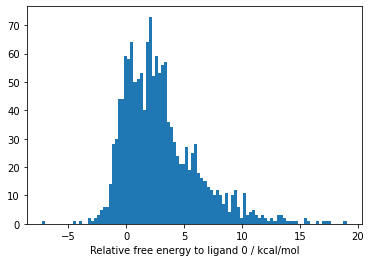

In [12]:
plt.hist(ligand_result.values(),bins=100)
plt.xlabel('Relative free energy to ligand 0 / kcal/mol')
plt.show()

/home/matt/.conda/envs/perses/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


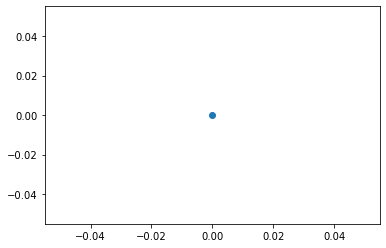

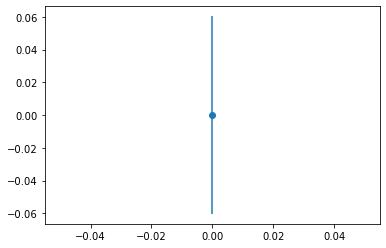

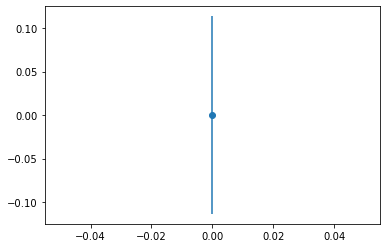

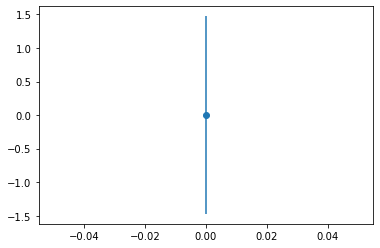

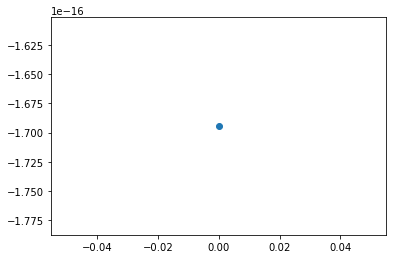

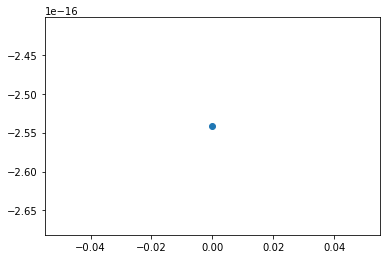

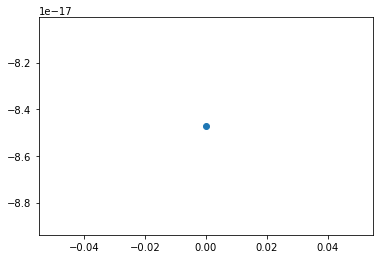

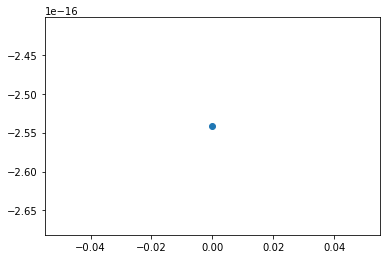

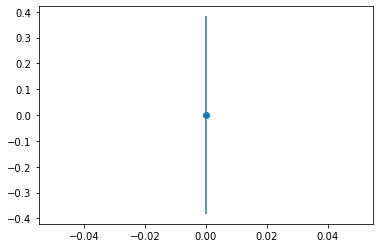

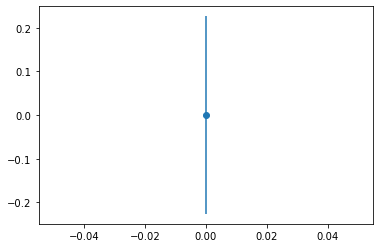

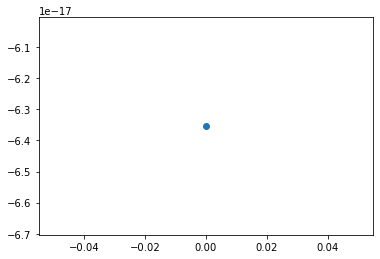

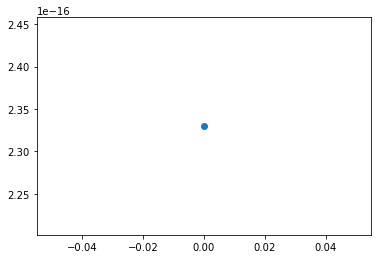

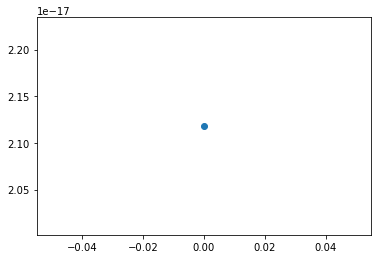

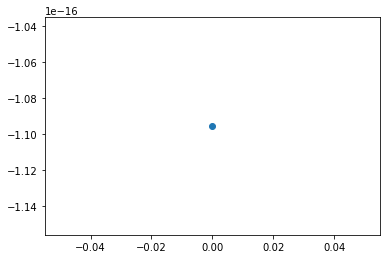

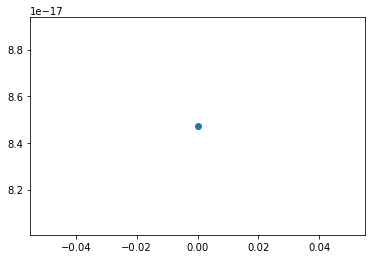

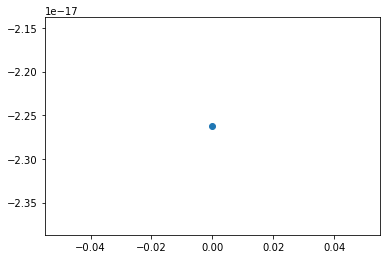

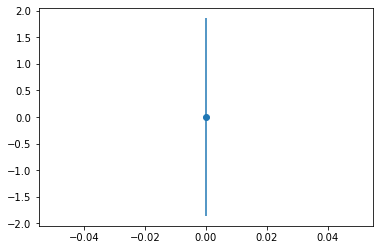

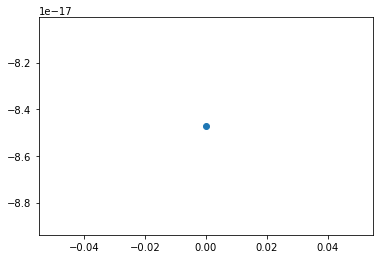

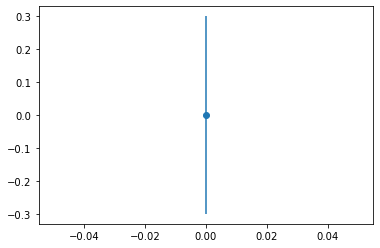

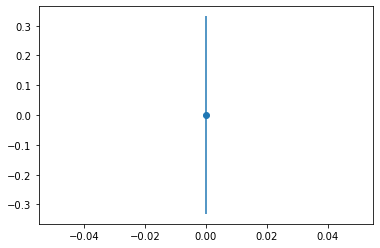

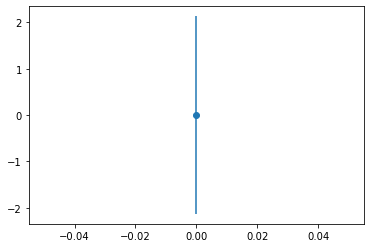

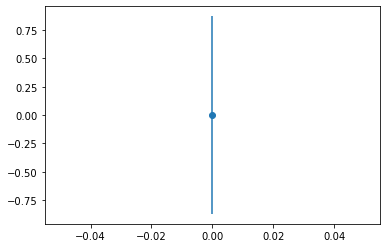

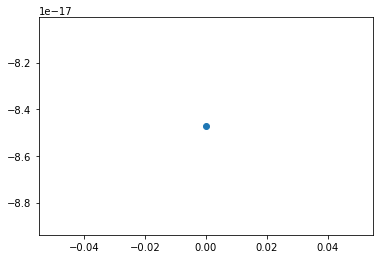

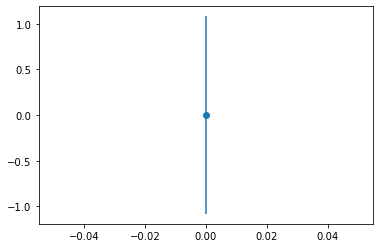

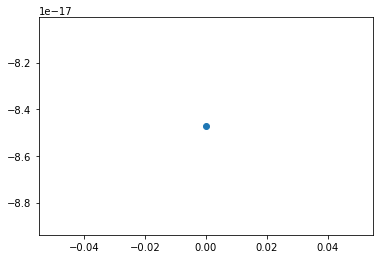

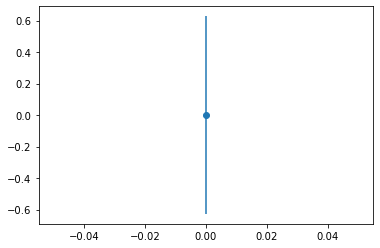

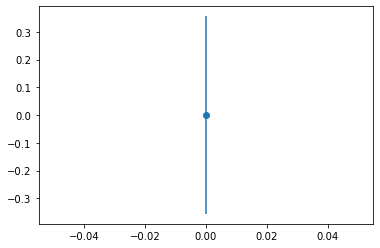

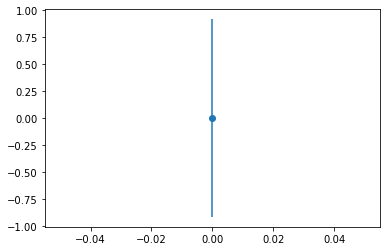

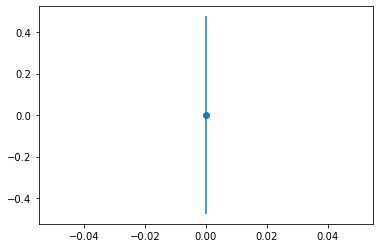

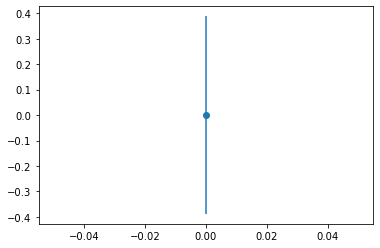

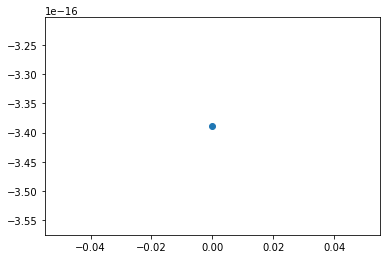

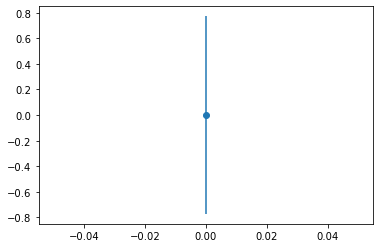

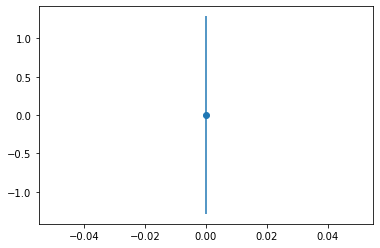

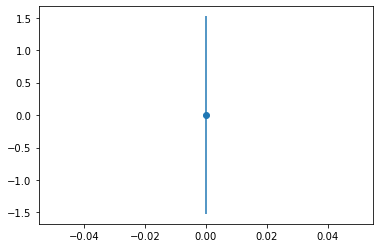

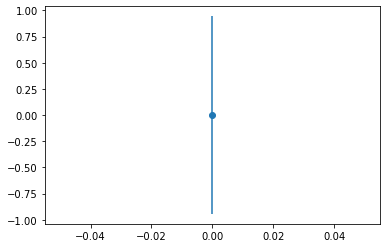

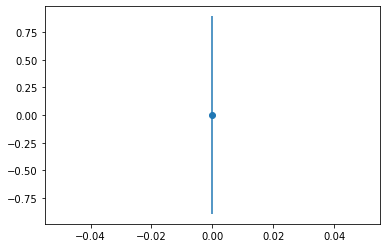

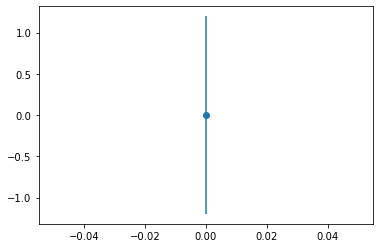

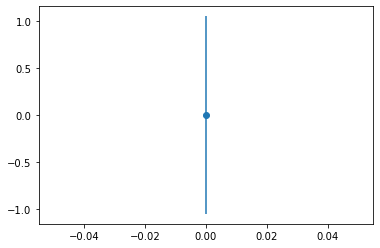

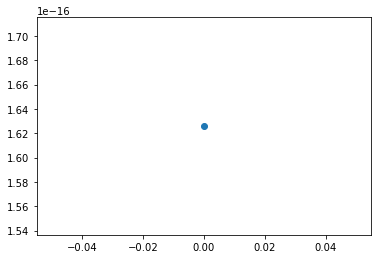

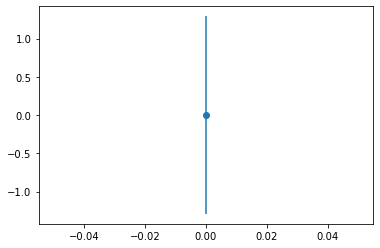

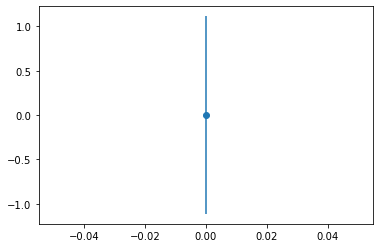

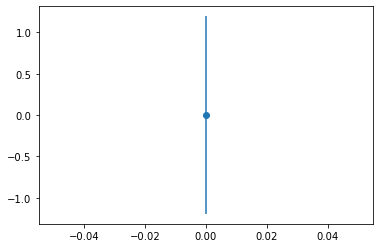

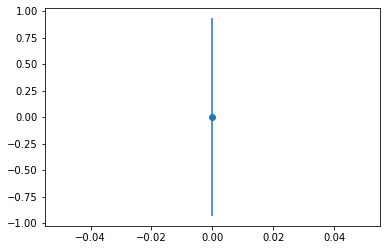

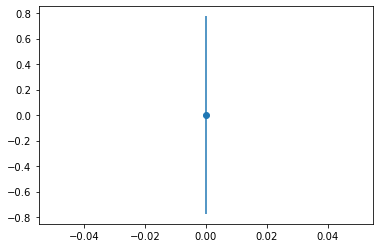

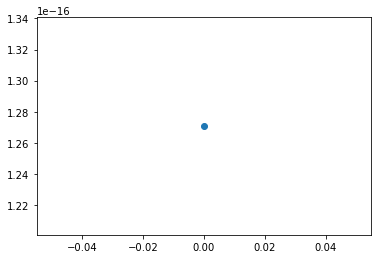

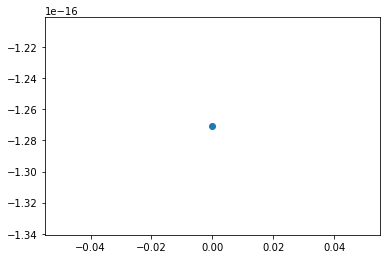

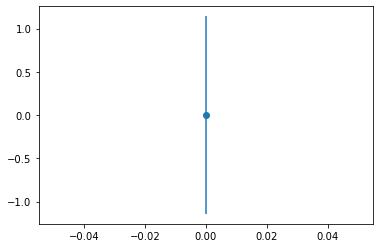

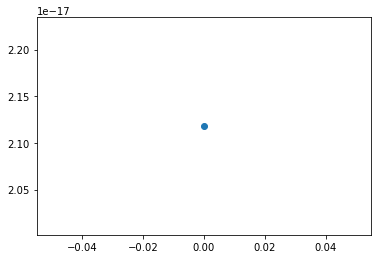

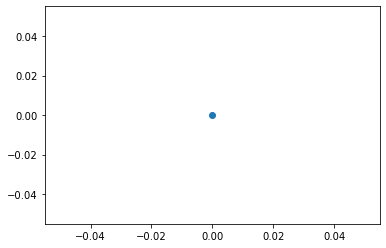

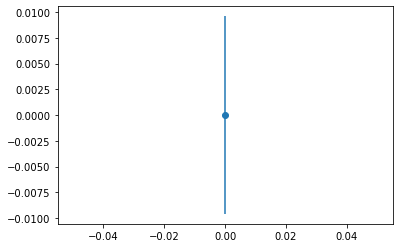

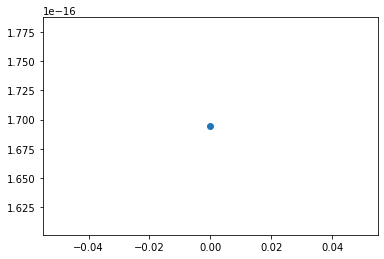

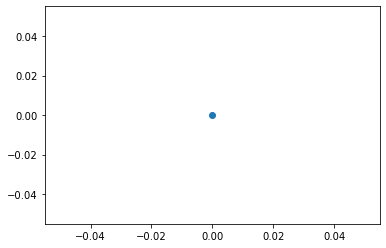

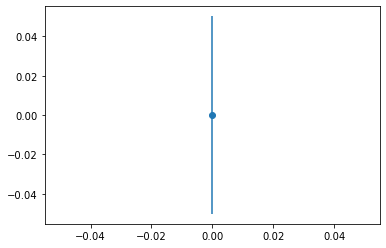

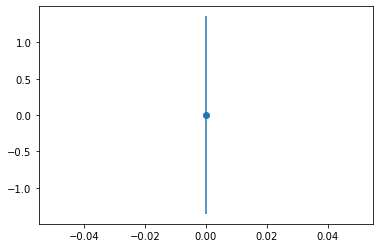

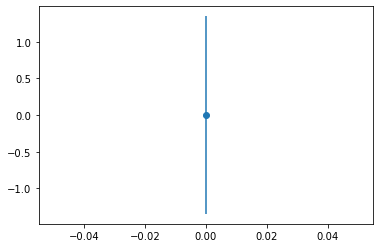

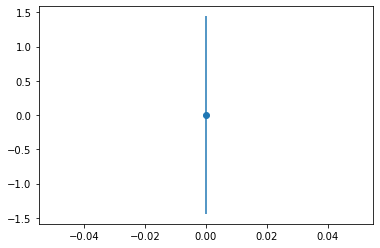

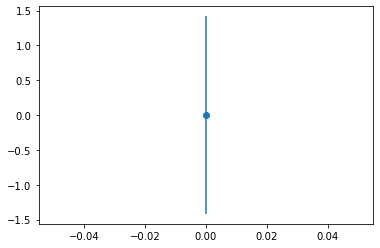

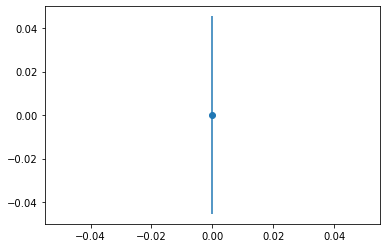

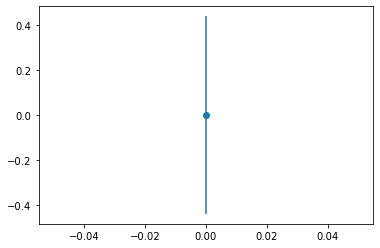

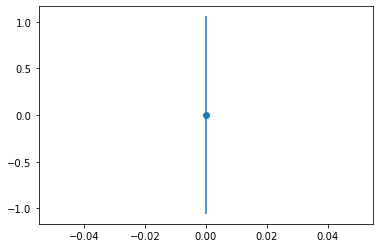

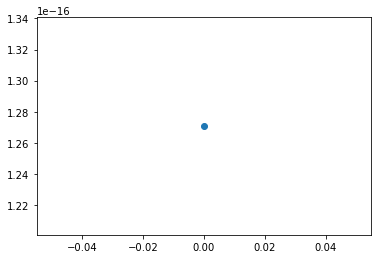

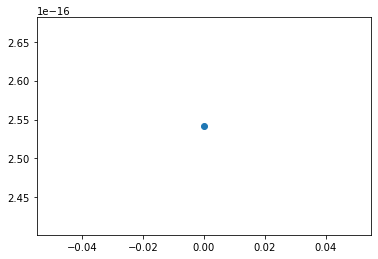

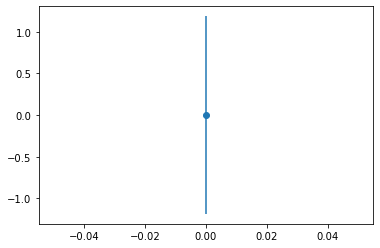

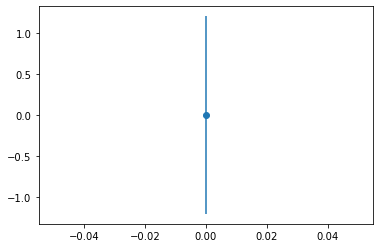

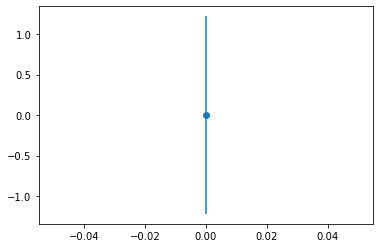

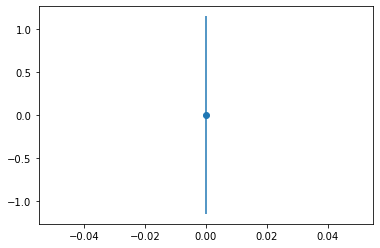

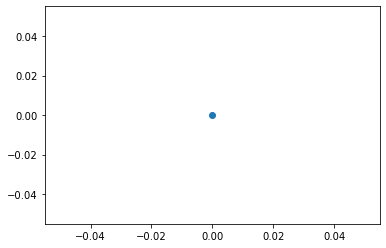

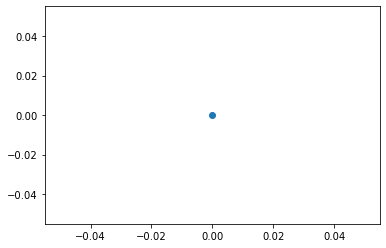

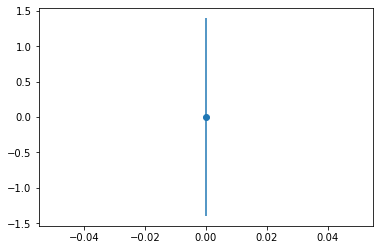

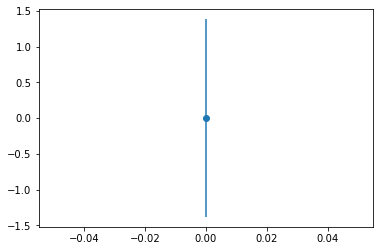

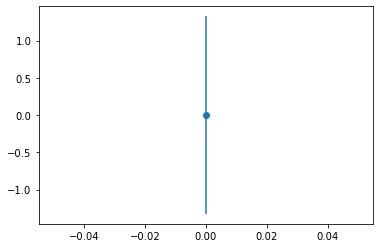

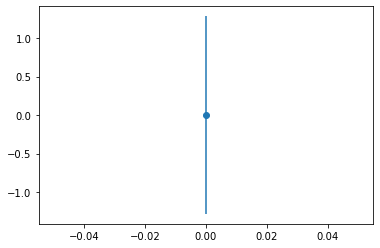

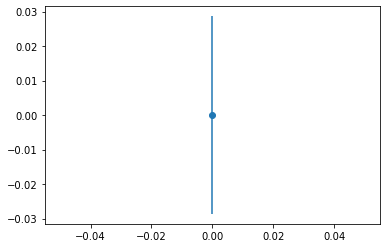

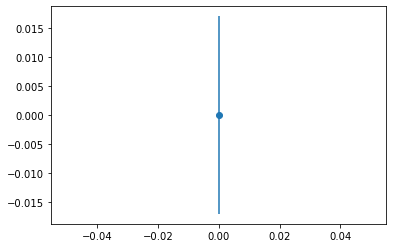

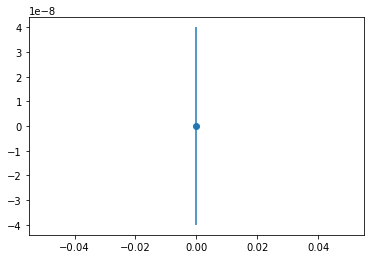

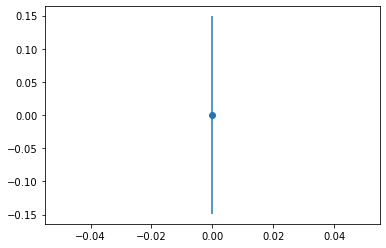

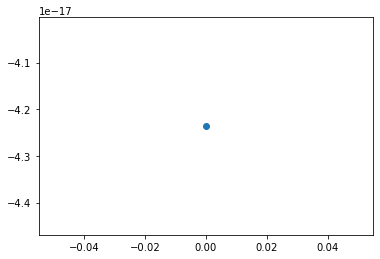

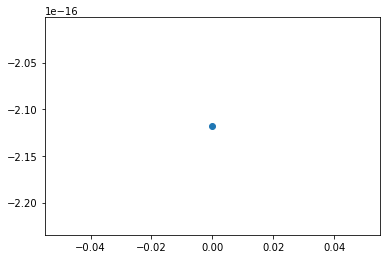

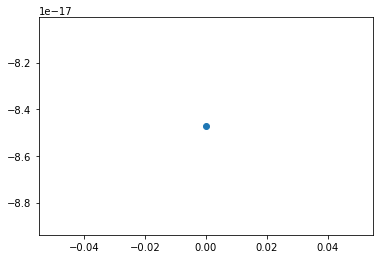

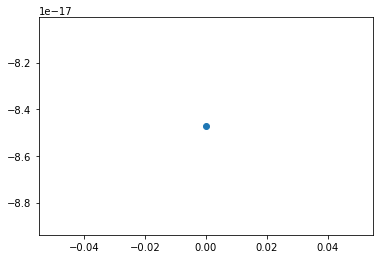

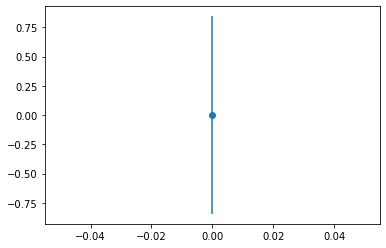

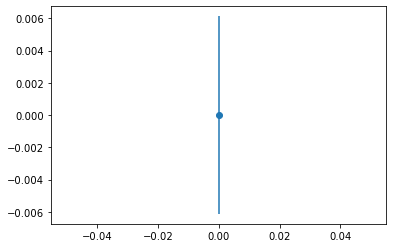

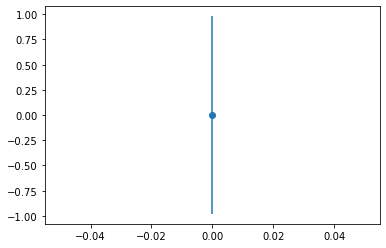

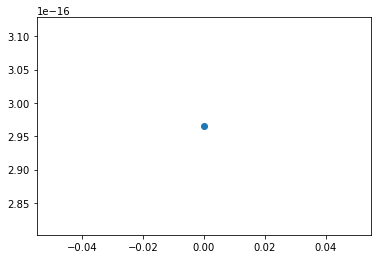

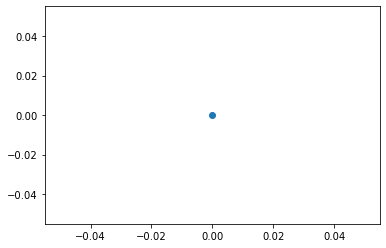

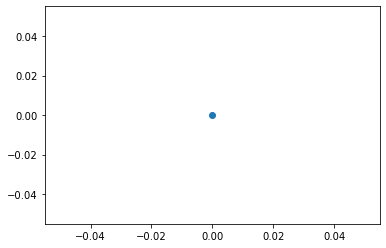

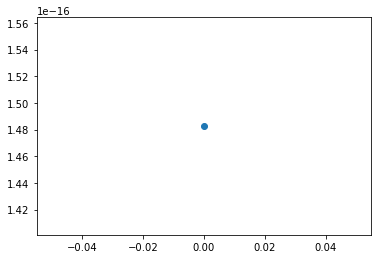

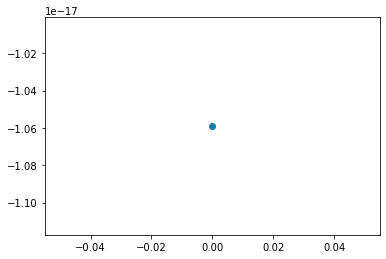

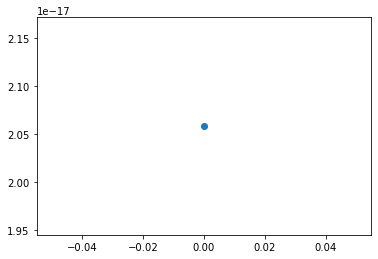

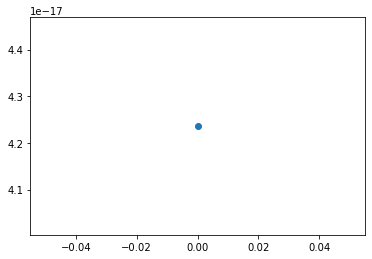

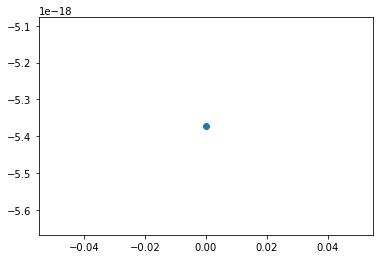

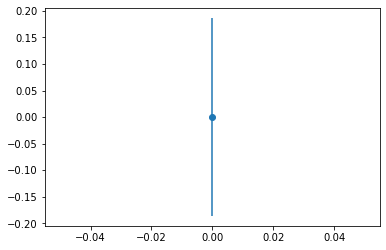

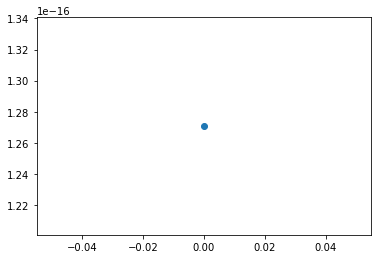

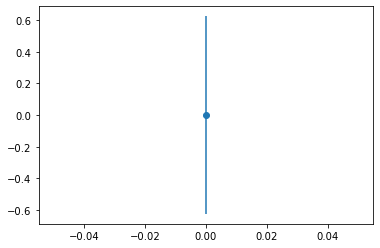

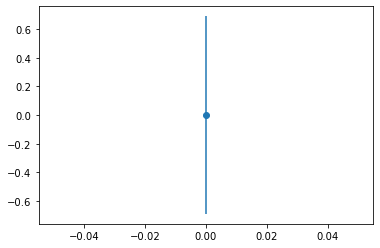

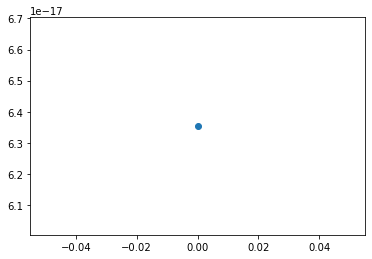

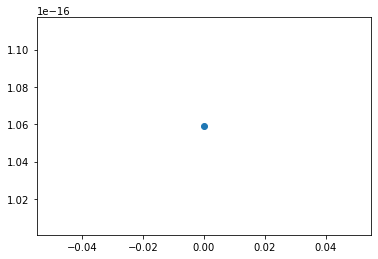

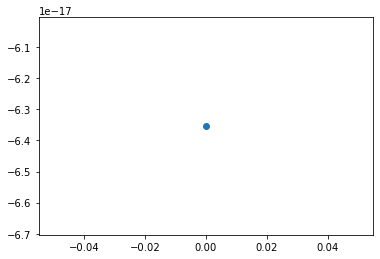

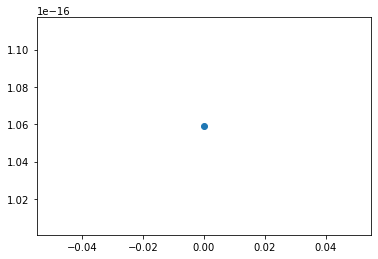

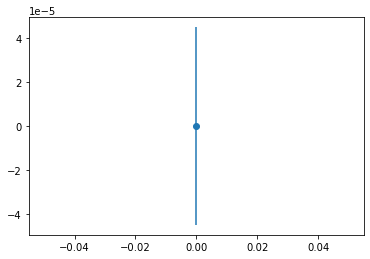

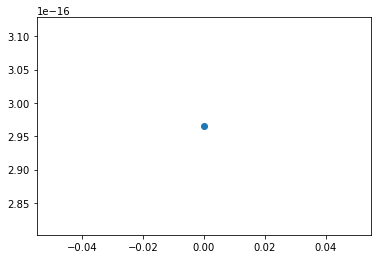

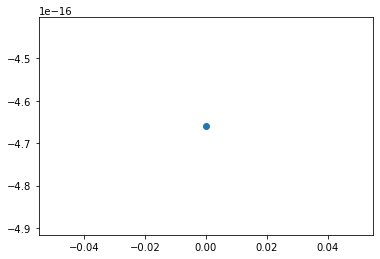

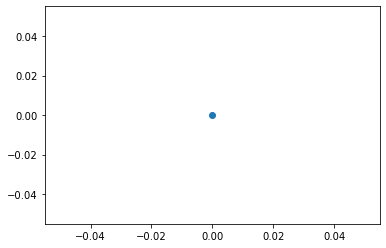

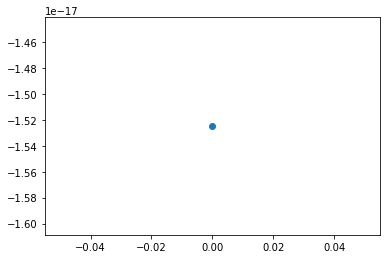

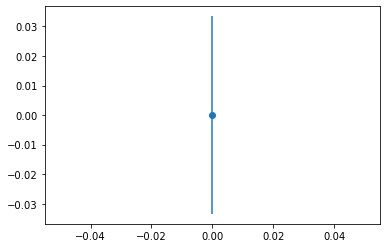

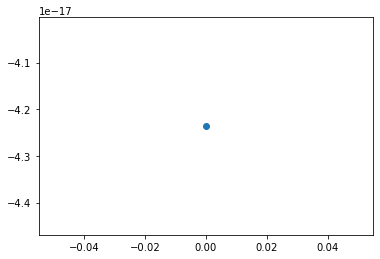

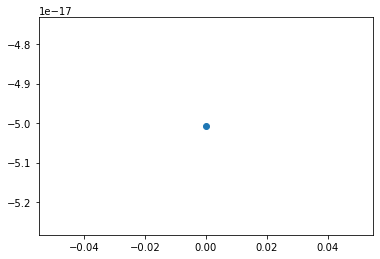

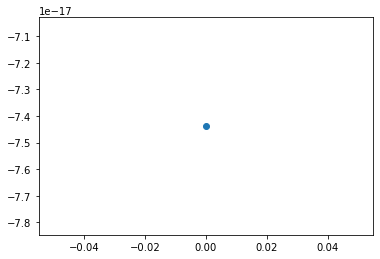

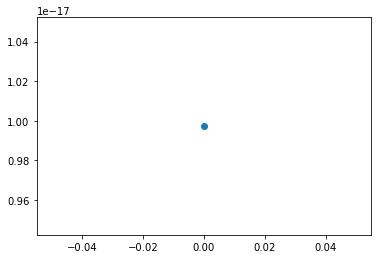

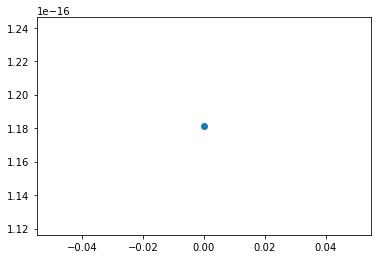

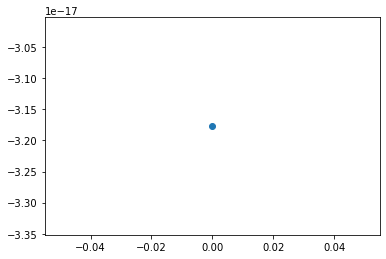

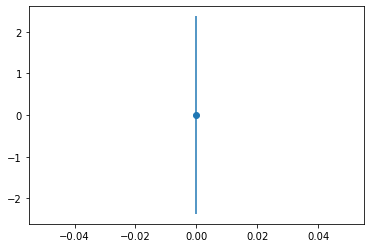

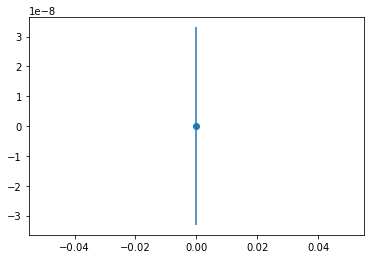

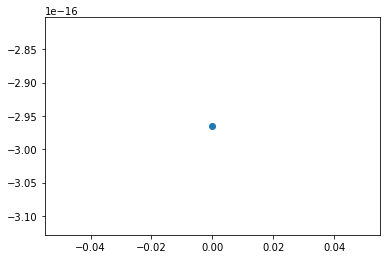

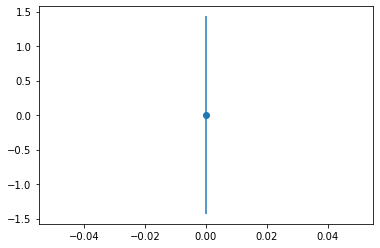

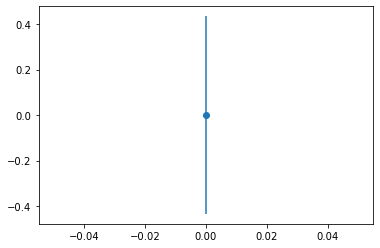

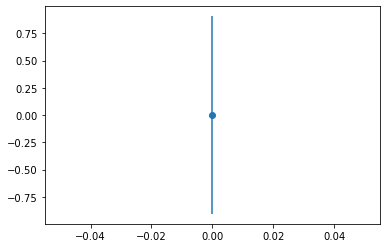

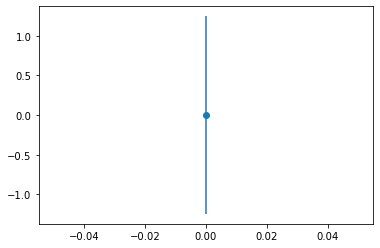

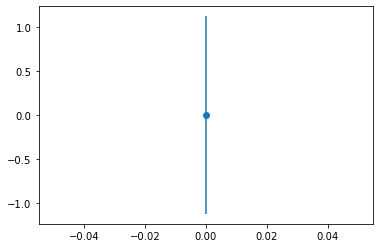

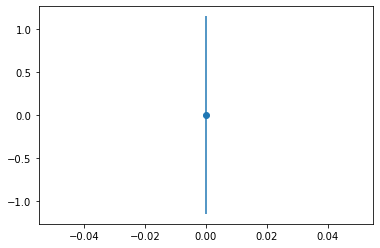

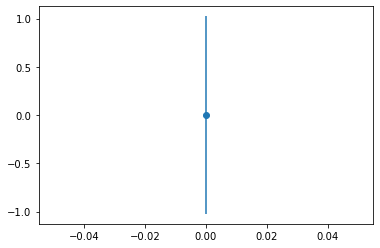

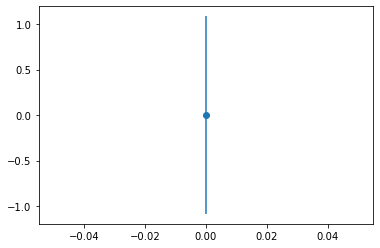

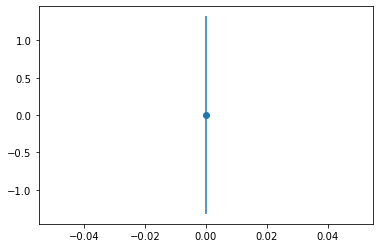

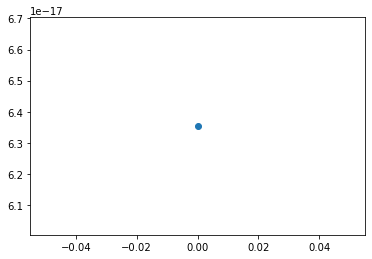

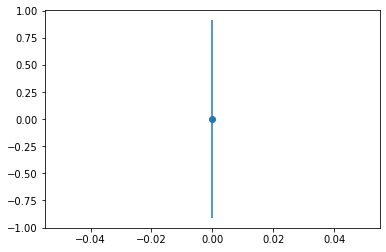

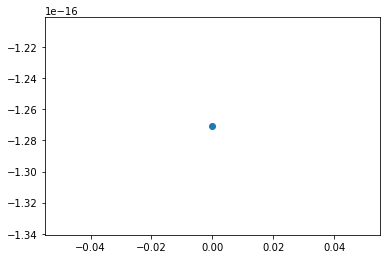

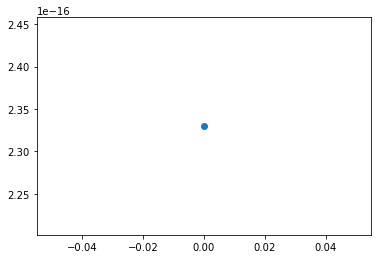

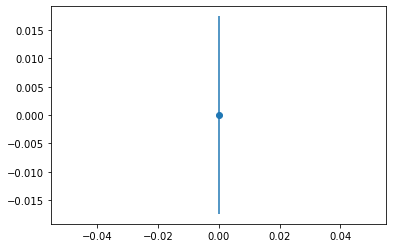

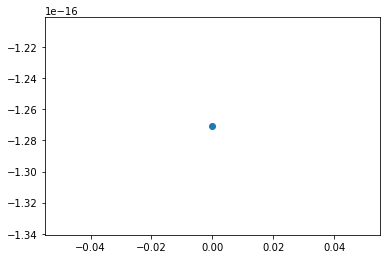

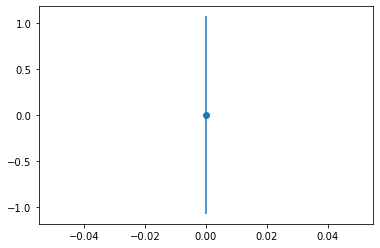

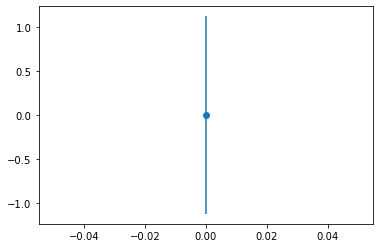

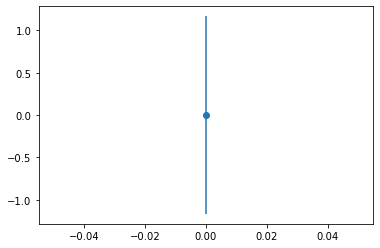

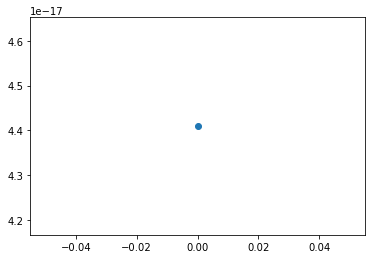

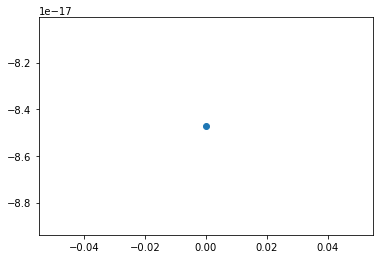

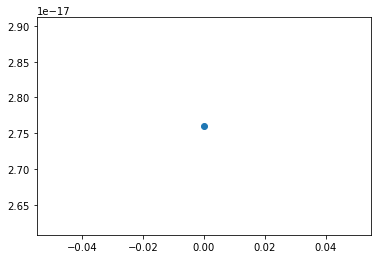

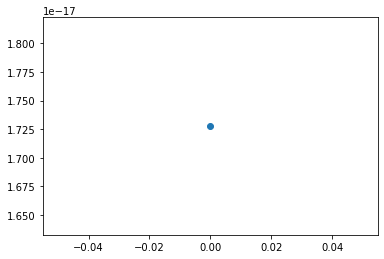

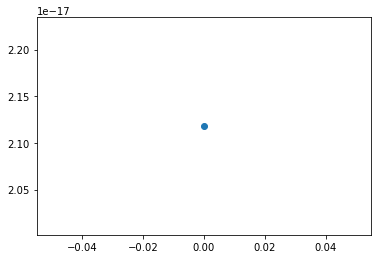

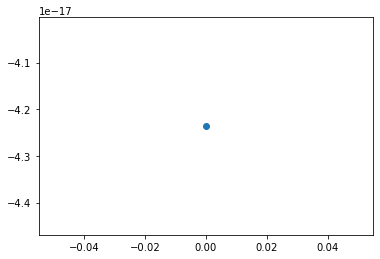

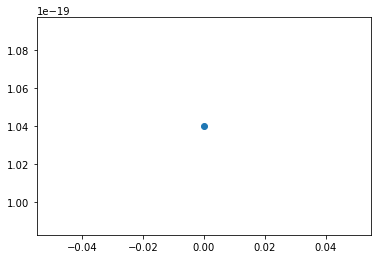

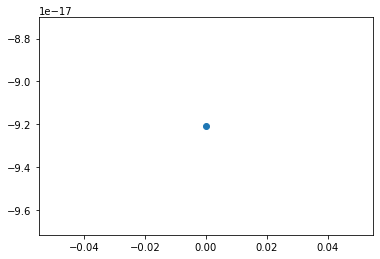

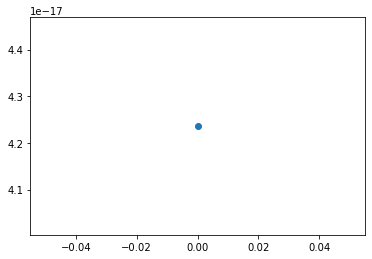

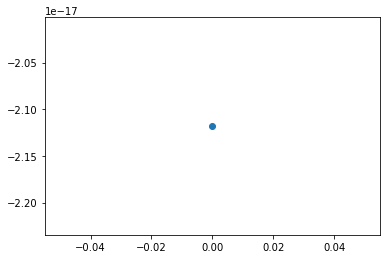

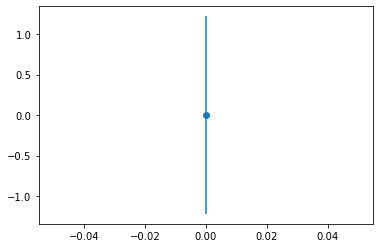

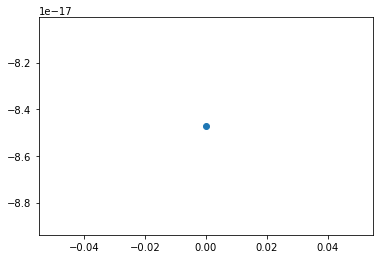

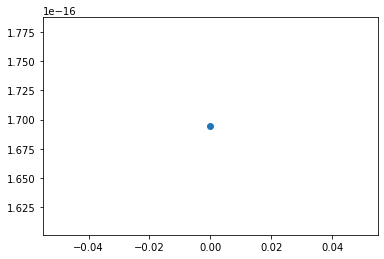

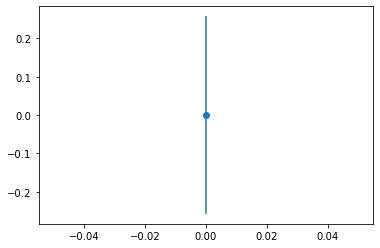

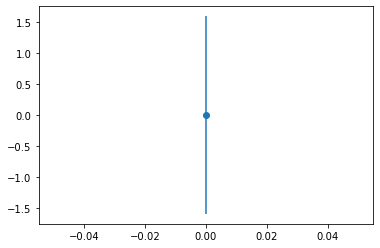

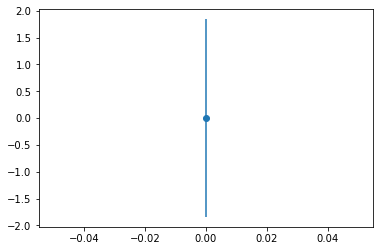

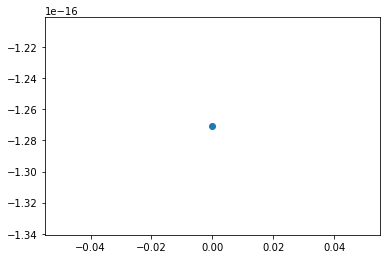

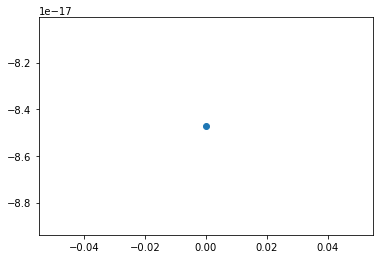

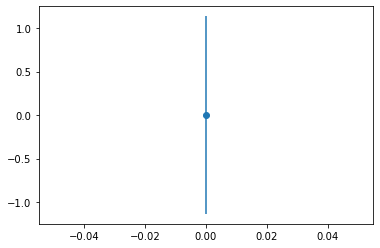

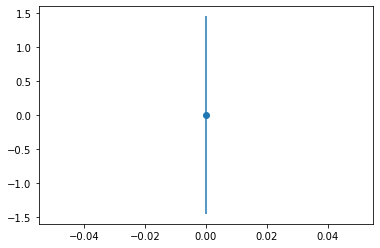

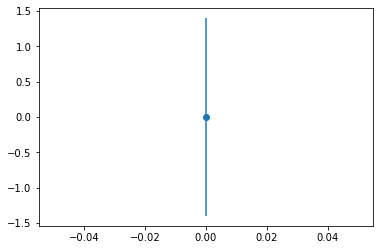

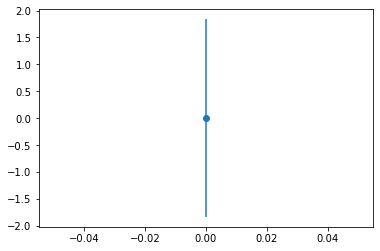

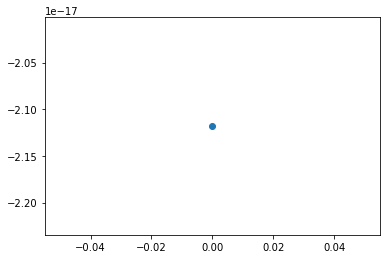

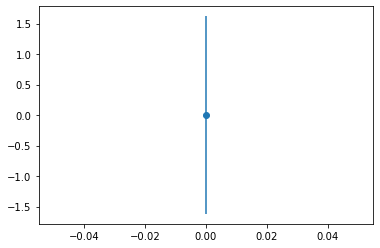

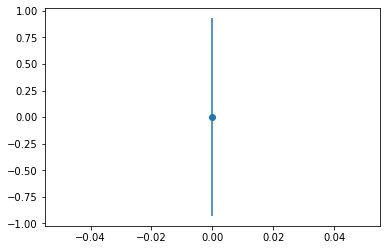

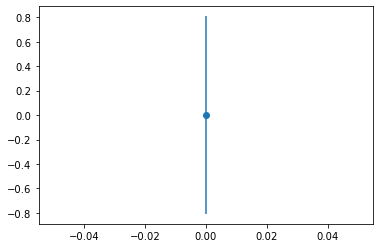

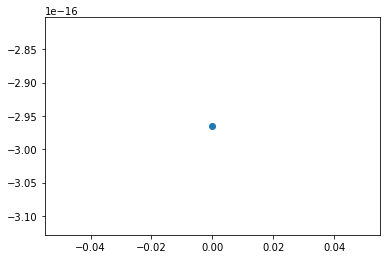

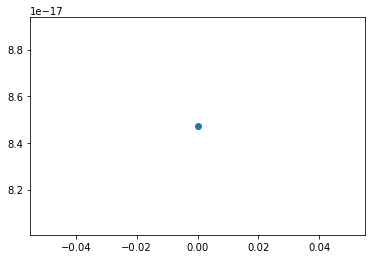

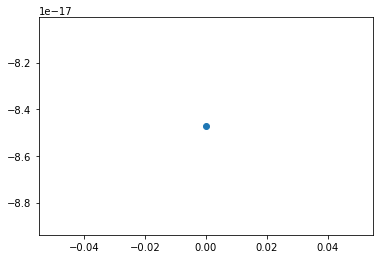

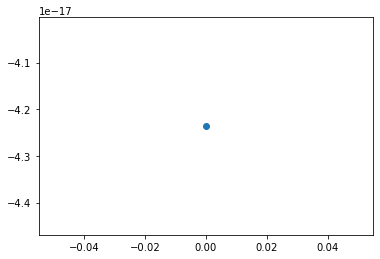

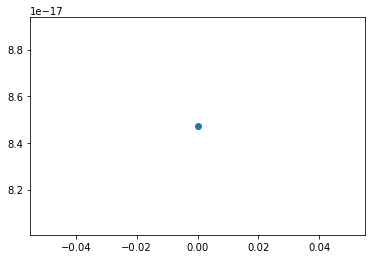

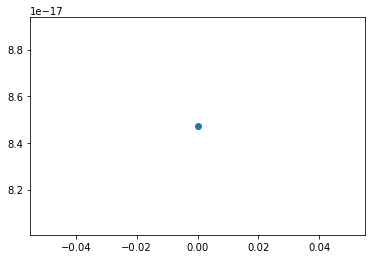

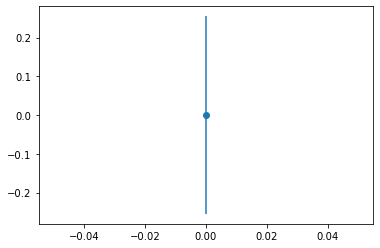

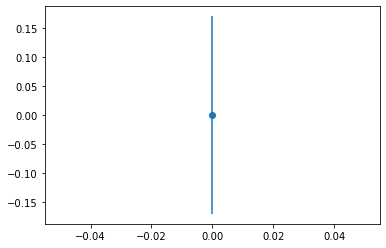

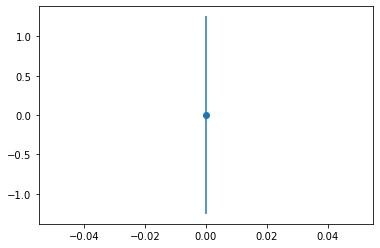

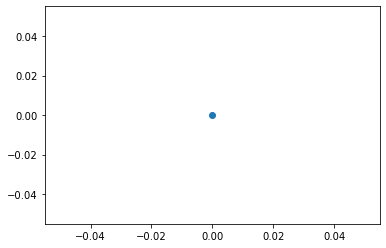

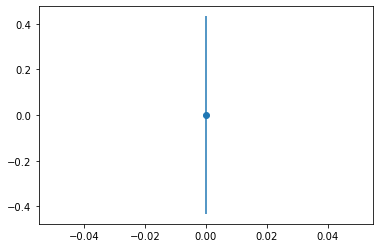

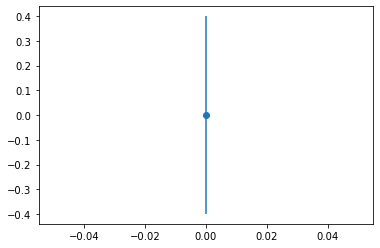

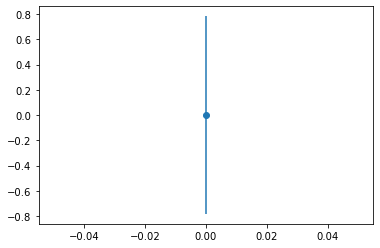

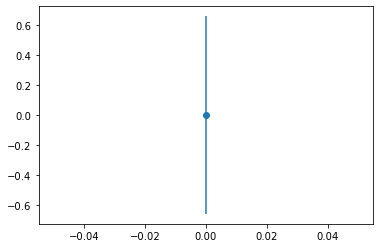

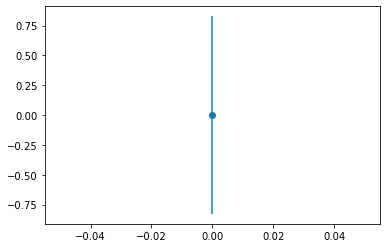

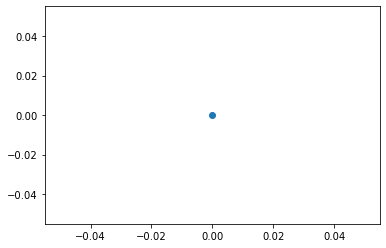

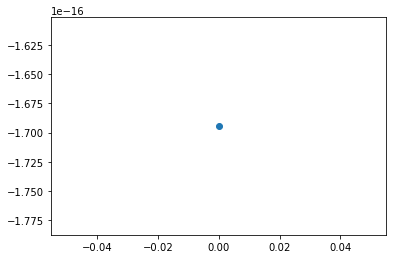

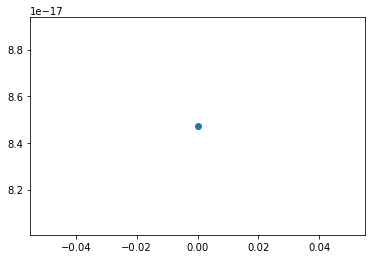

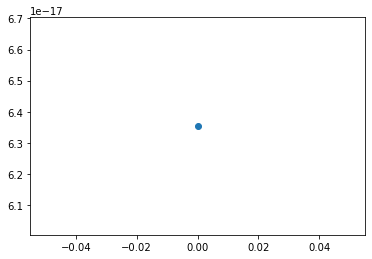

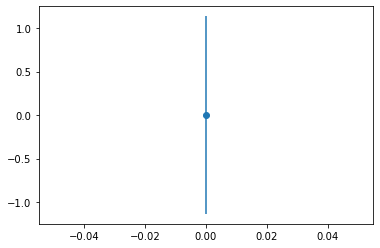

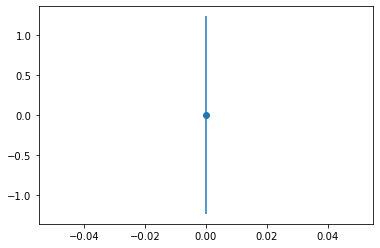

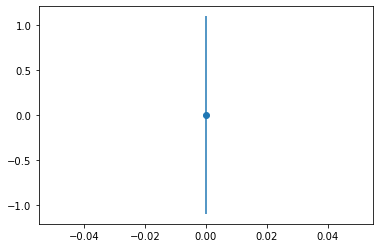

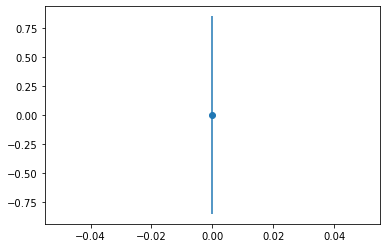

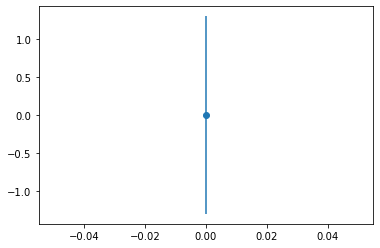

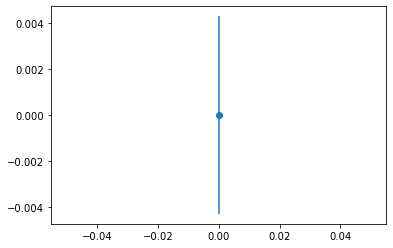

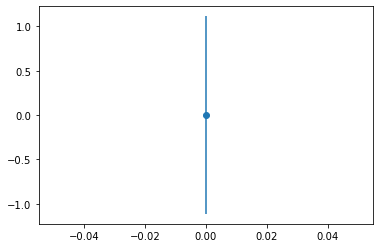

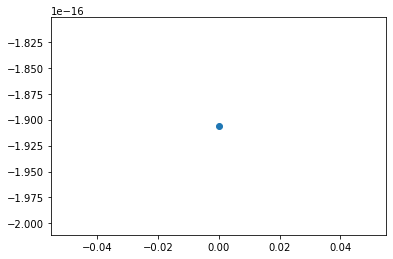

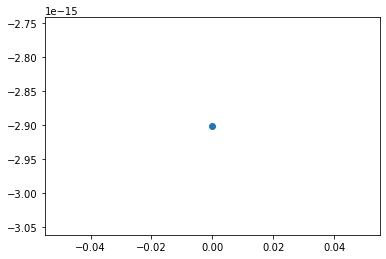

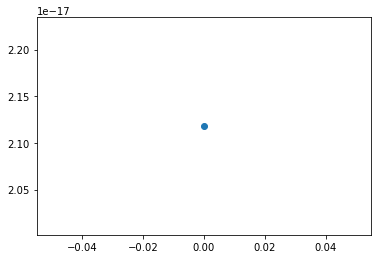

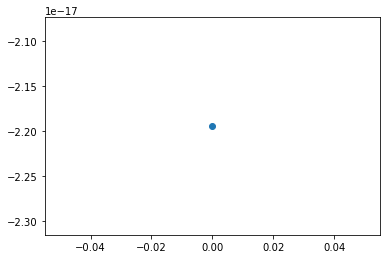

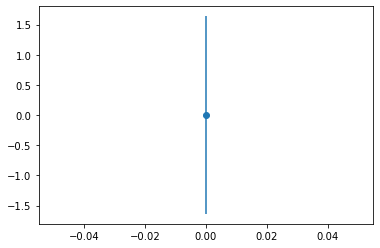

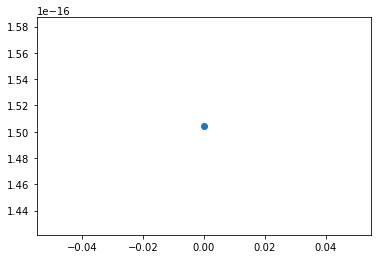

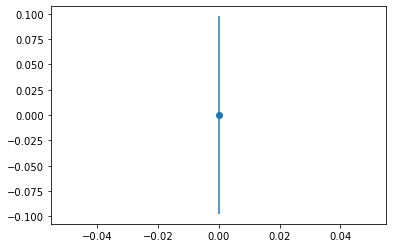

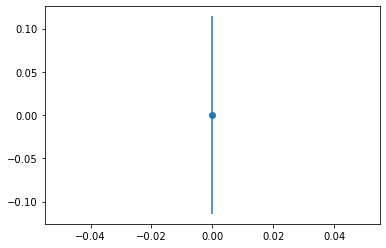

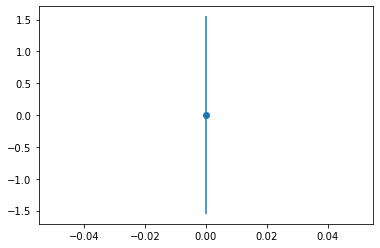

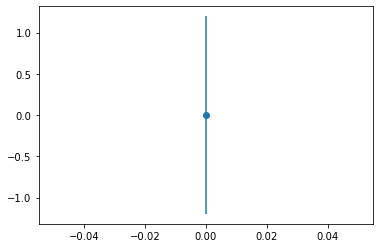

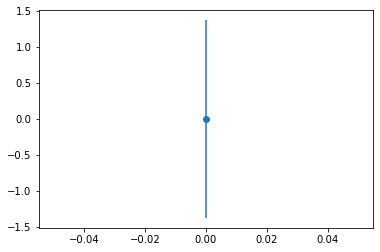

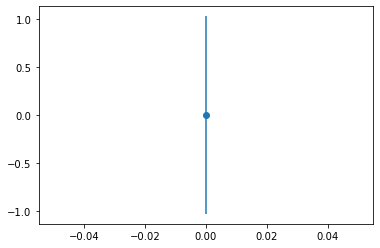

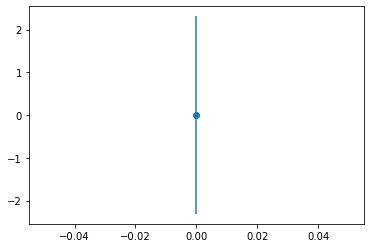

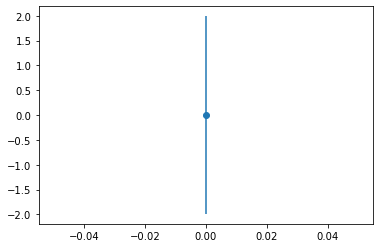

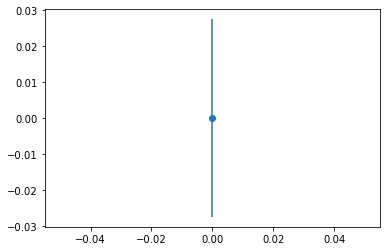

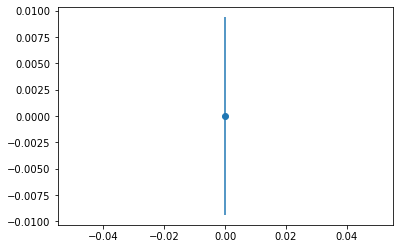

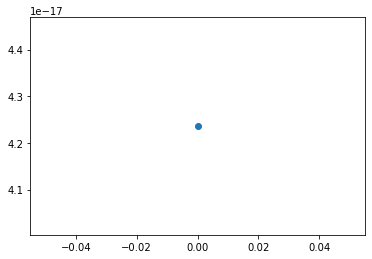

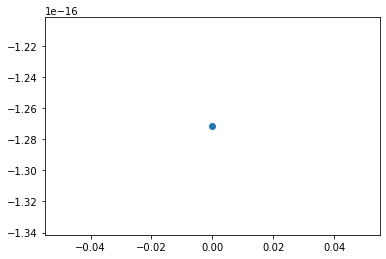

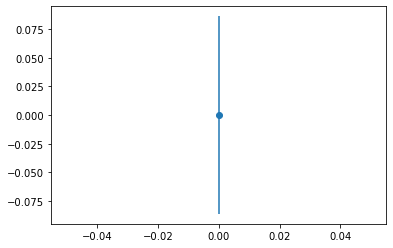

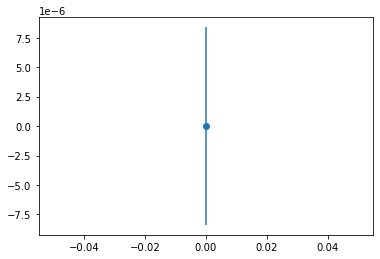

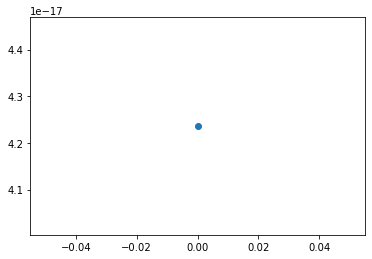

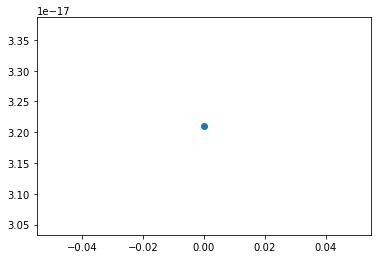

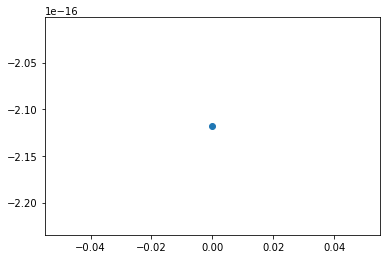

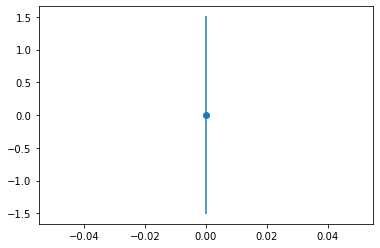

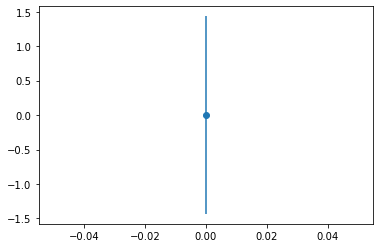

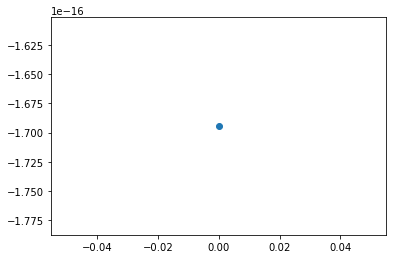

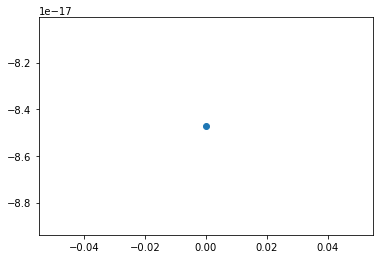

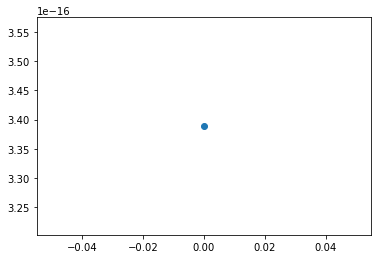

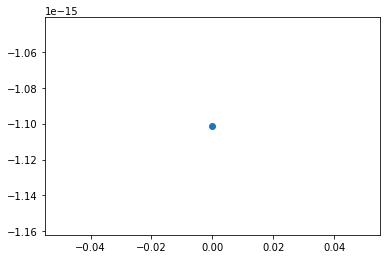

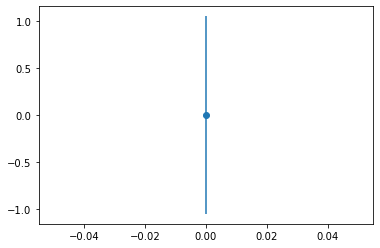

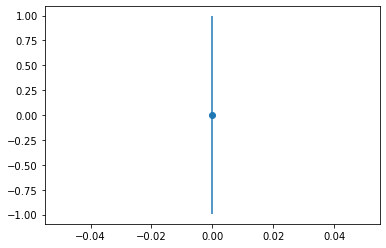

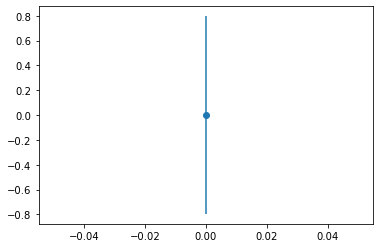

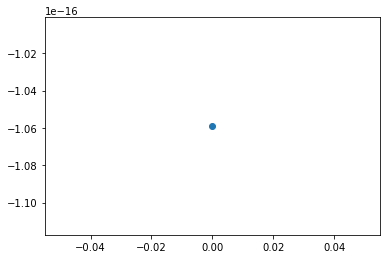

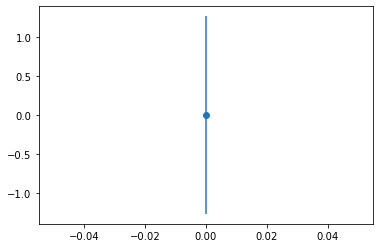

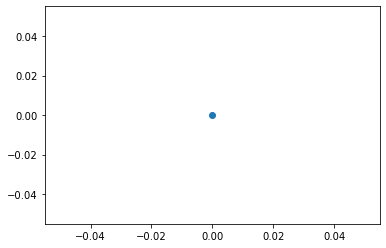

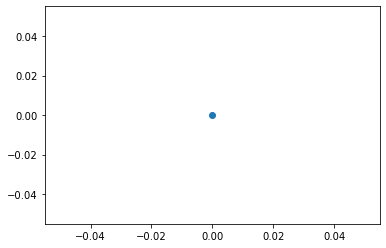

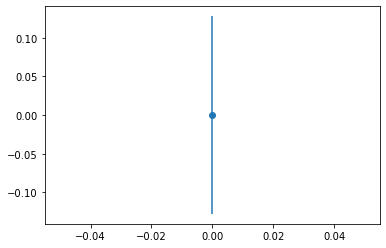

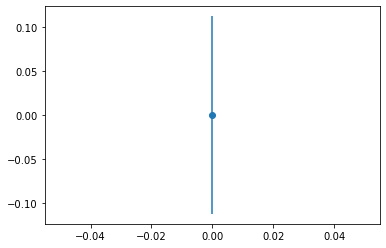

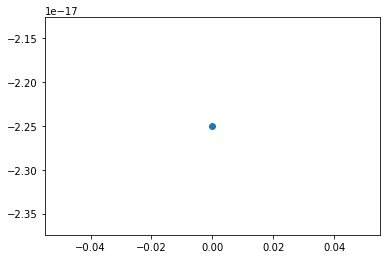

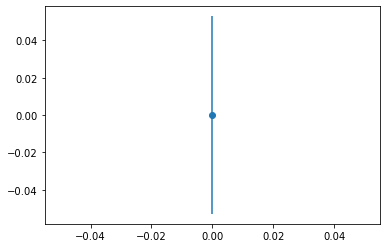

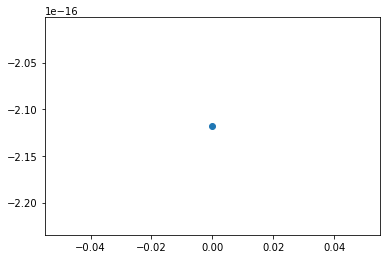

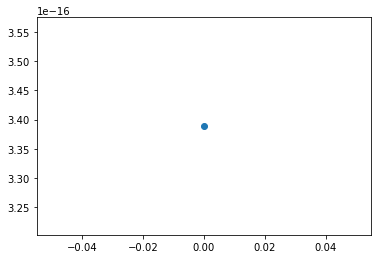

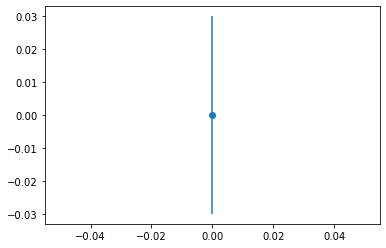

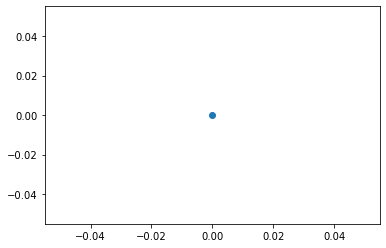

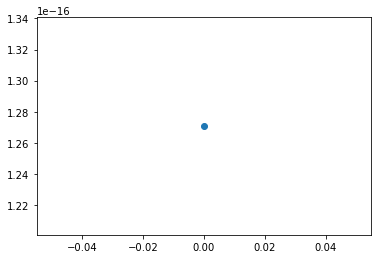

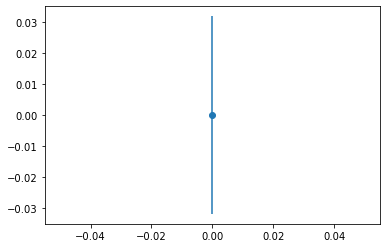

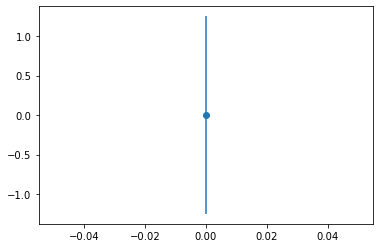

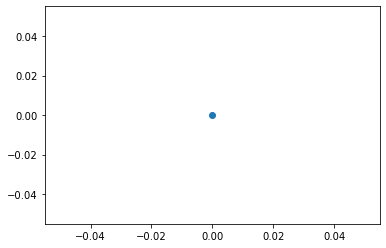

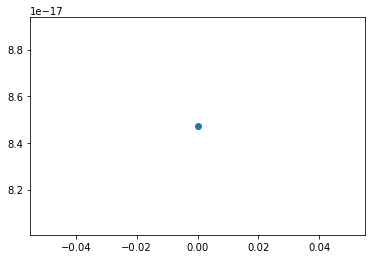

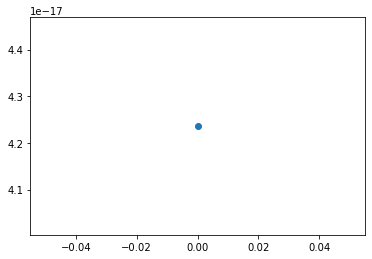

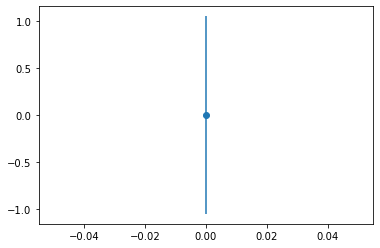

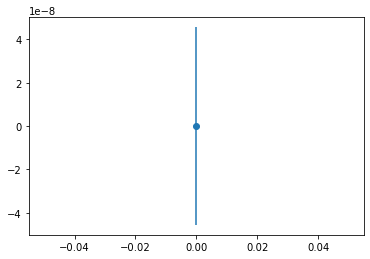

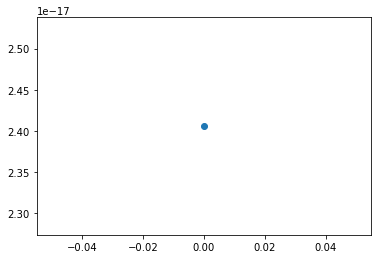

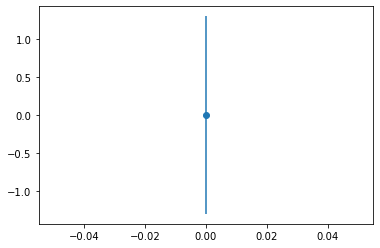

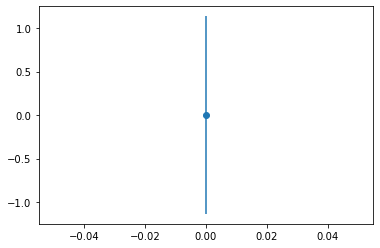

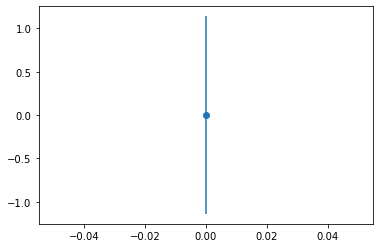

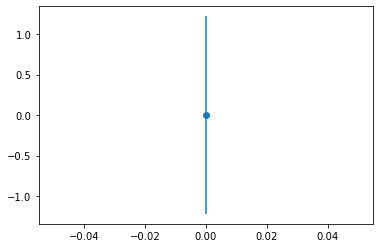

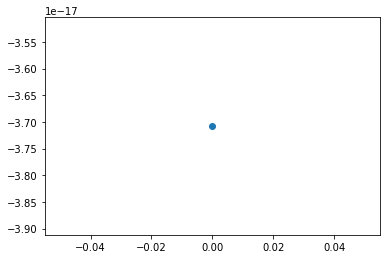

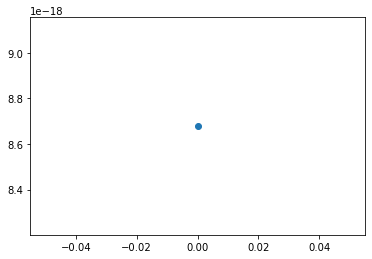

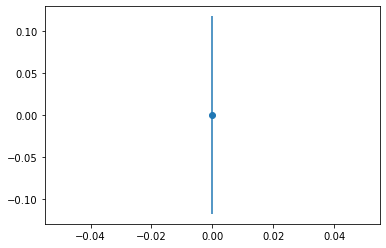

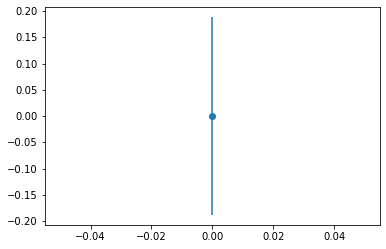

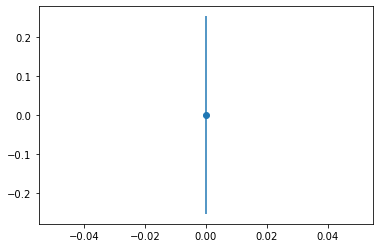

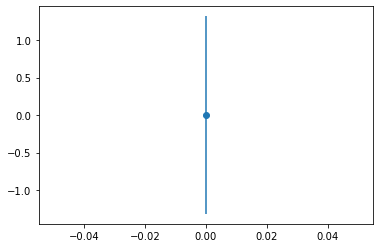

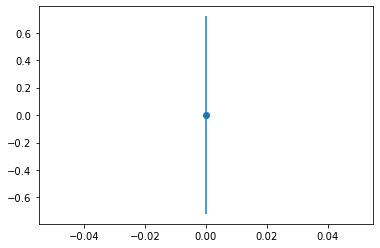

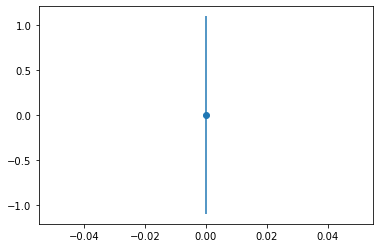

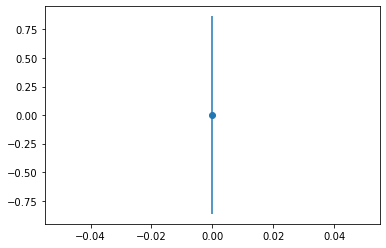

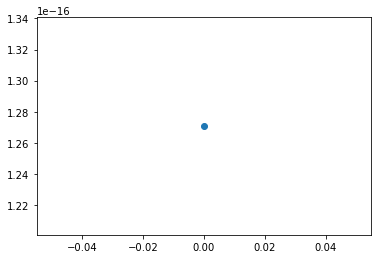

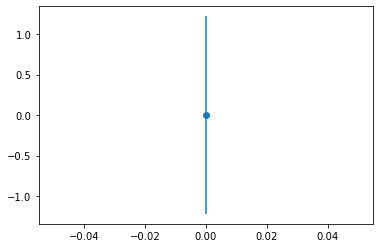

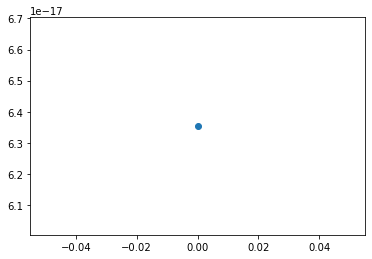

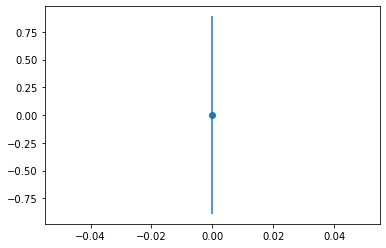

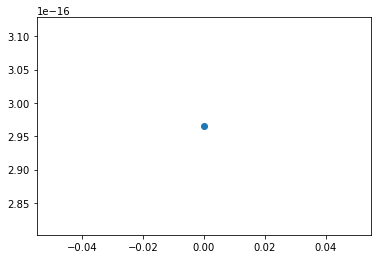

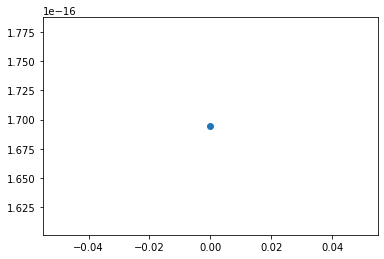

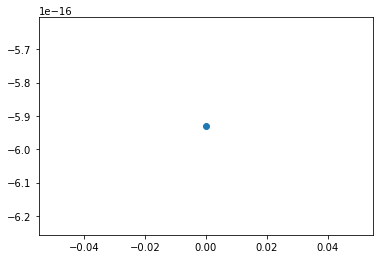

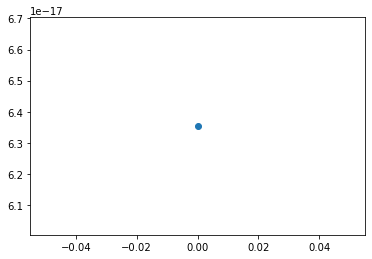

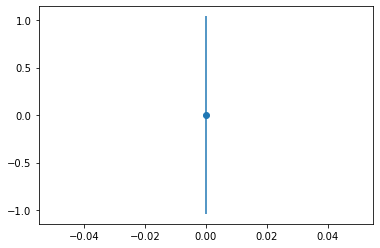

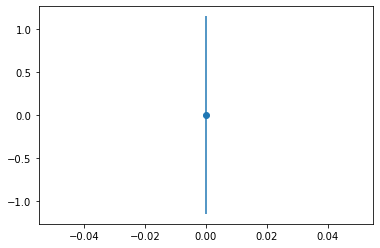

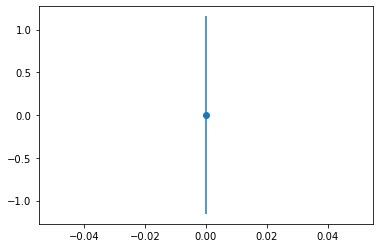

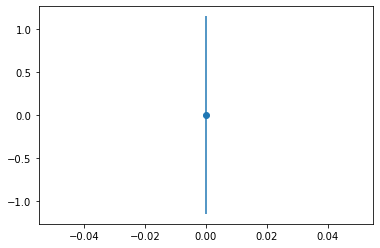

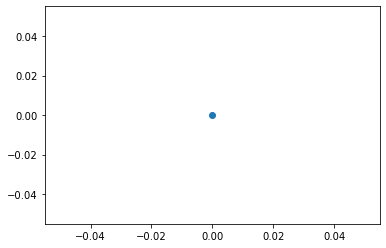

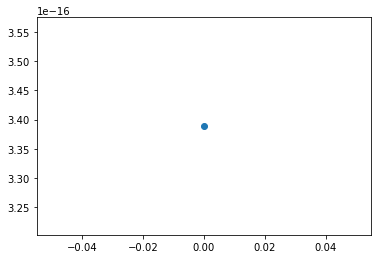

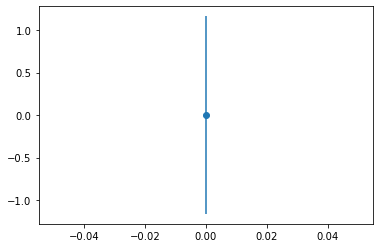

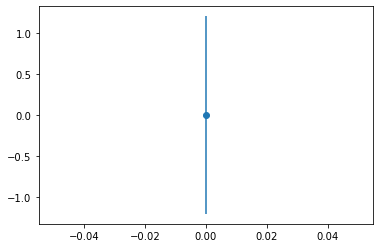

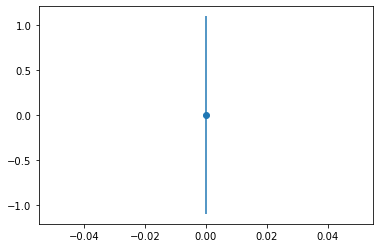

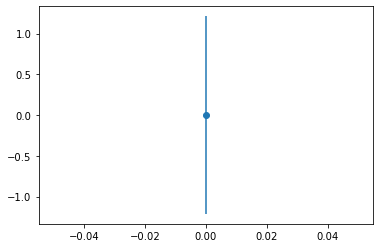

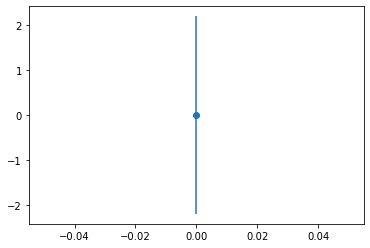

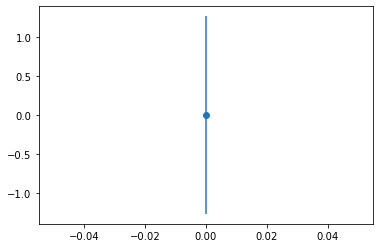

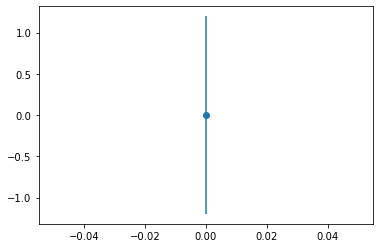

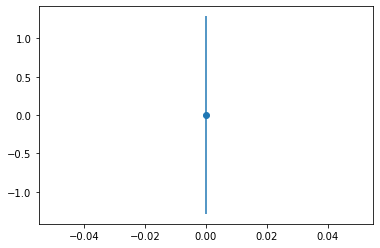

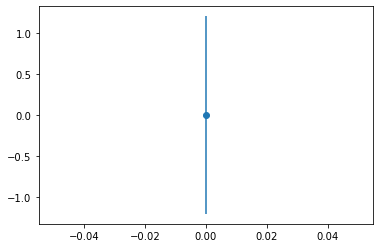

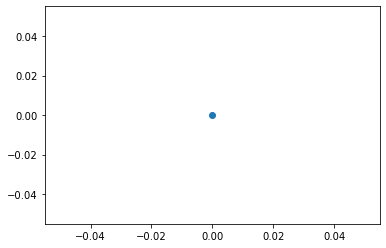

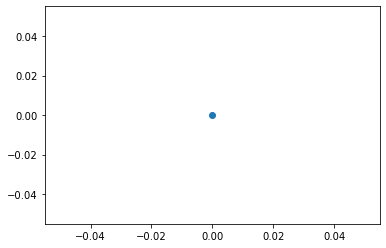

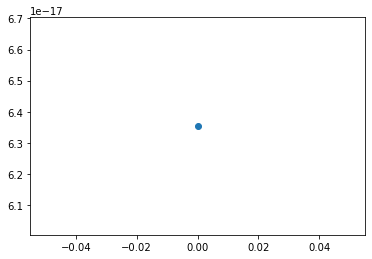

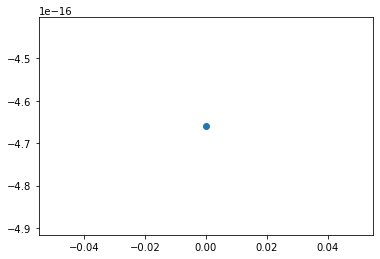

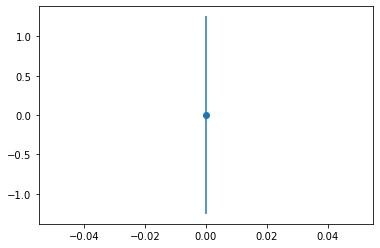

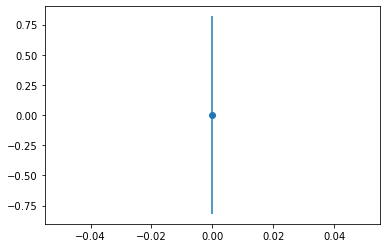

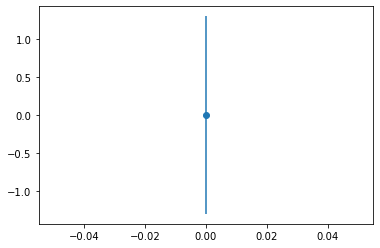

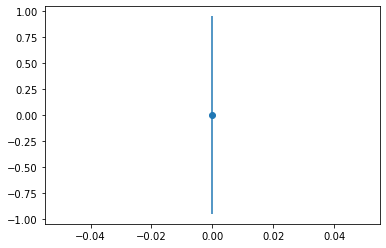

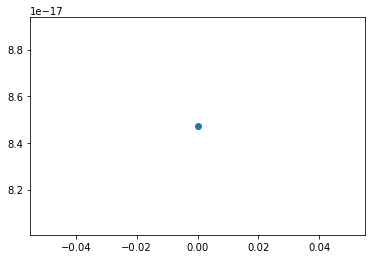

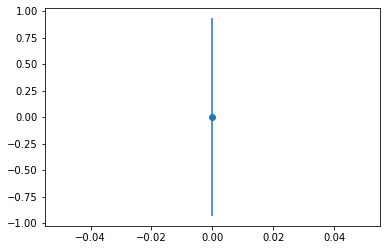

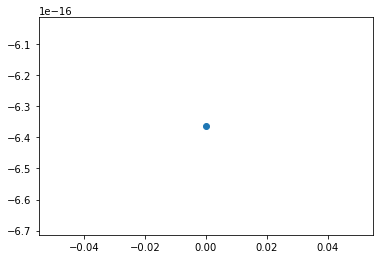

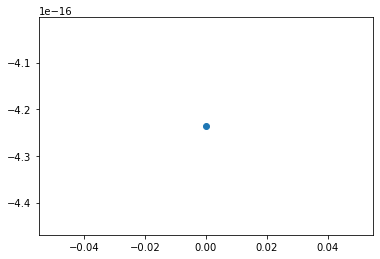

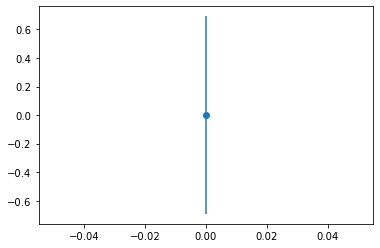

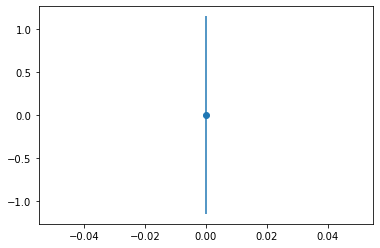

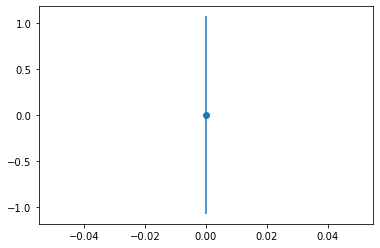

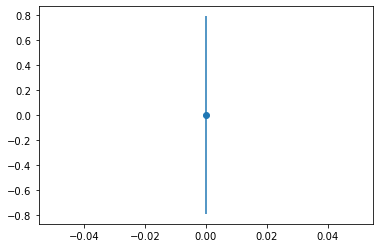

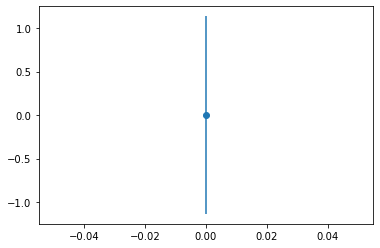

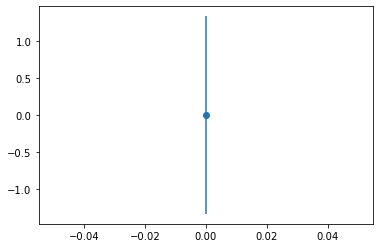

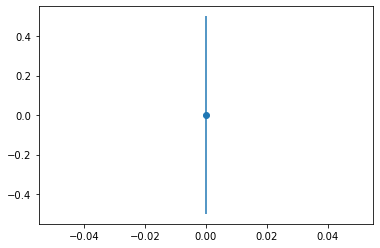

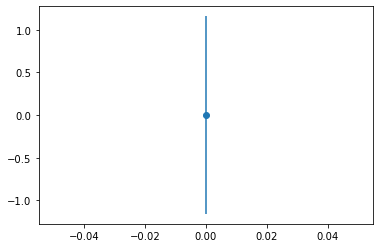

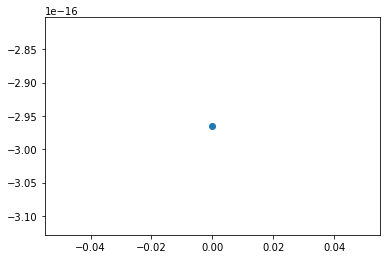

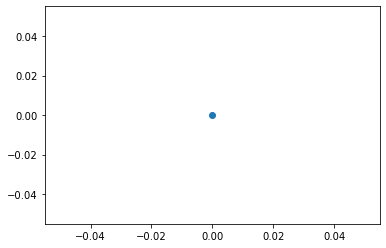

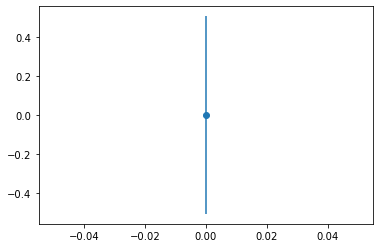

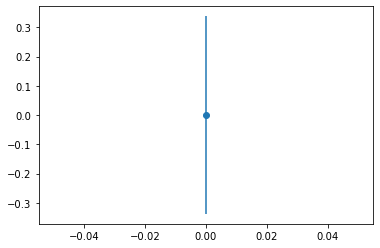

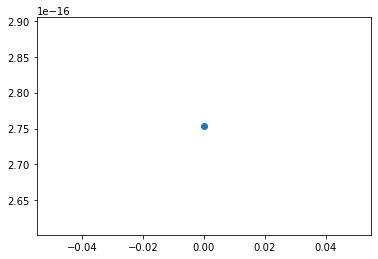

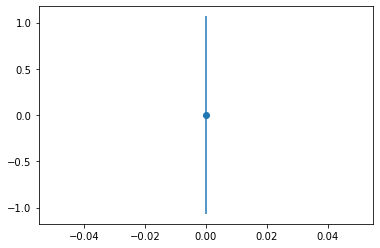

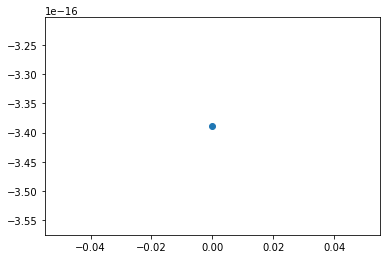

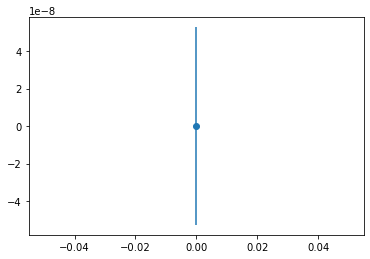

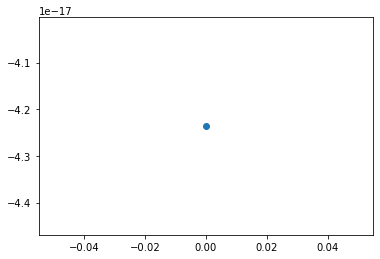

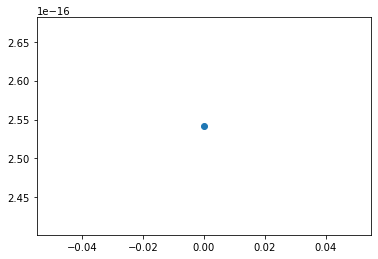

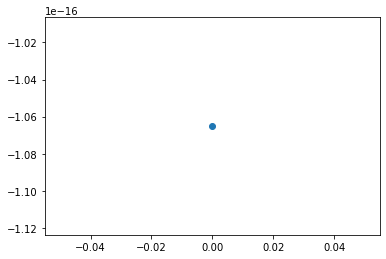

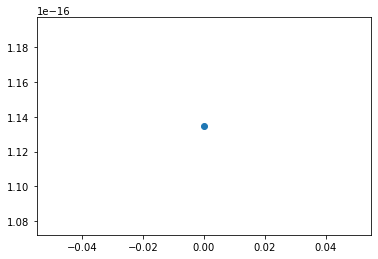

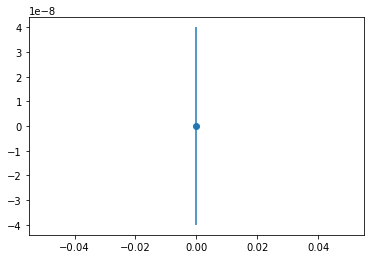

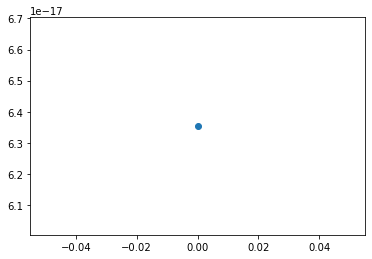

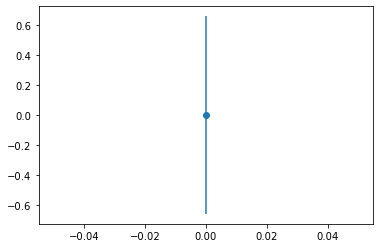

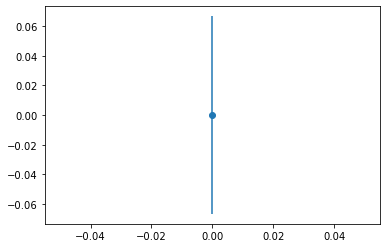

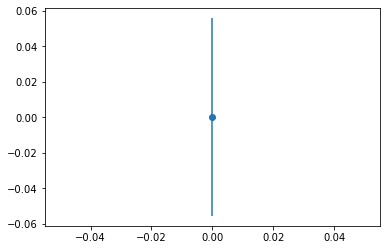

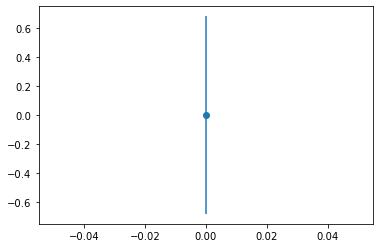

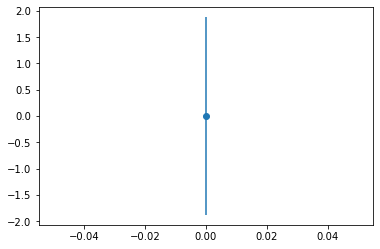

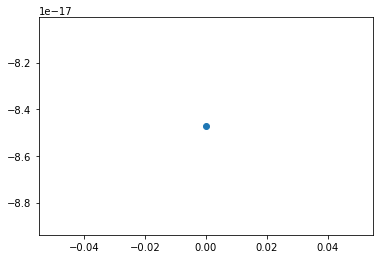

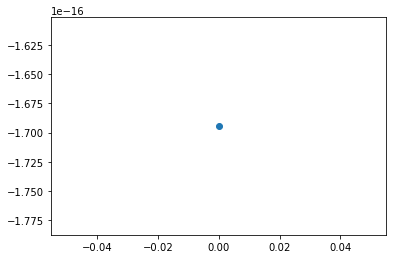

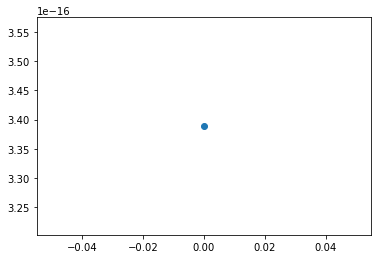

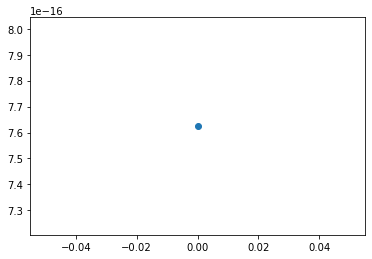

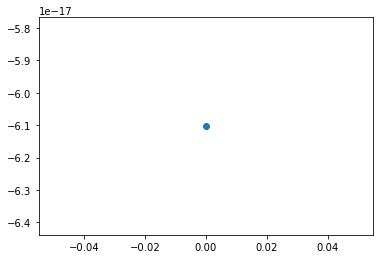

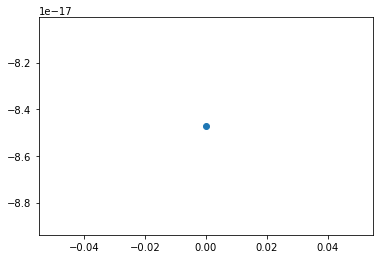

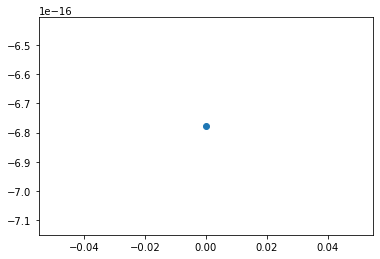

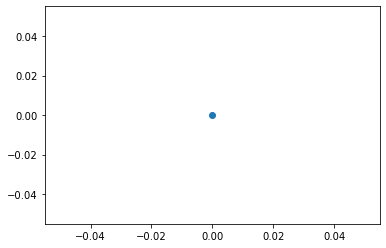

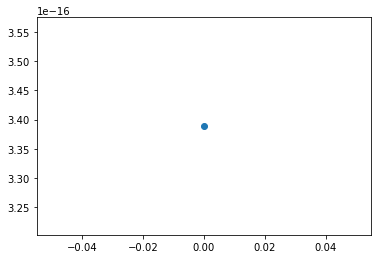

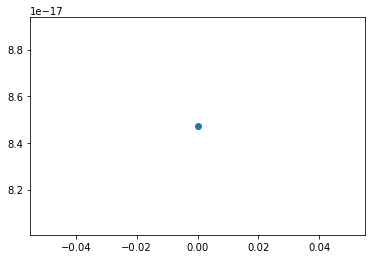

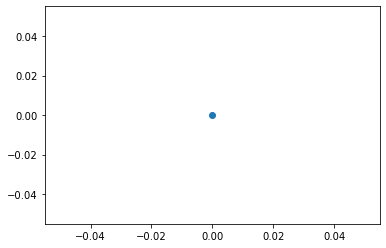

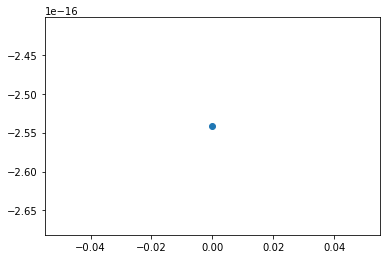

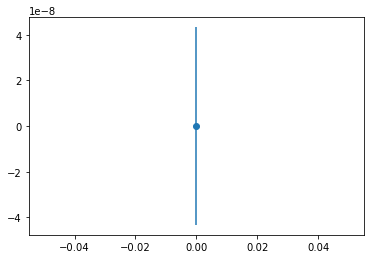

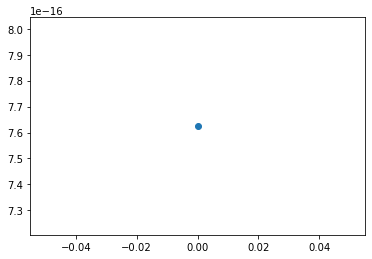

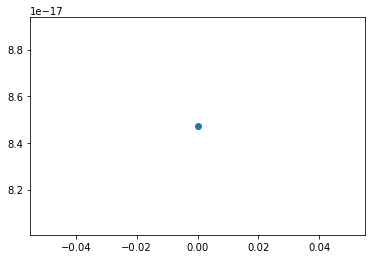

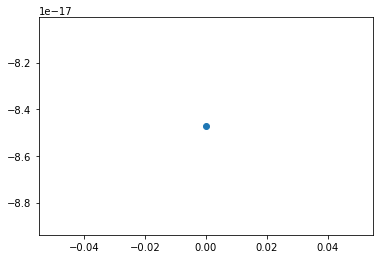

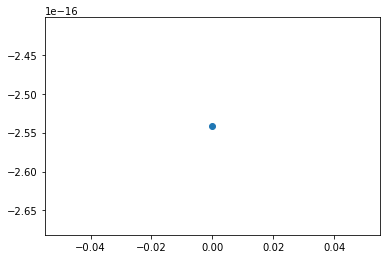

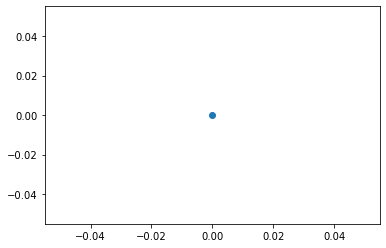

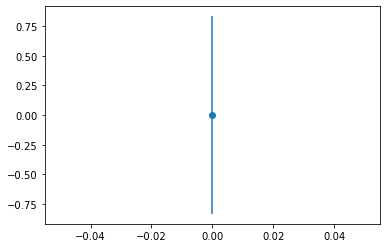

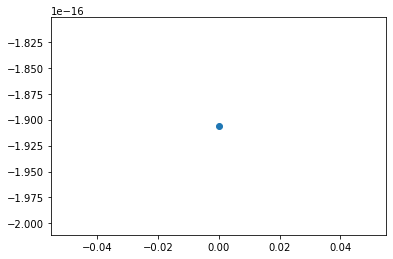

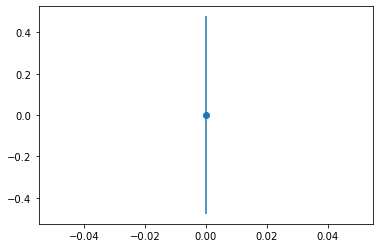

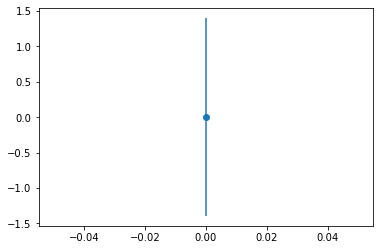

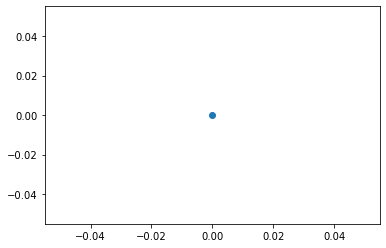

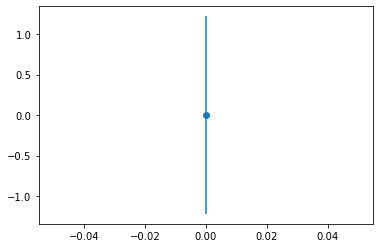

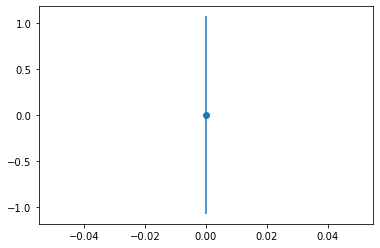

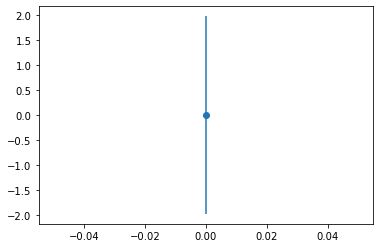

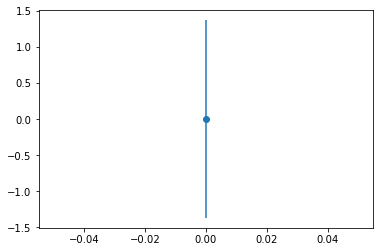

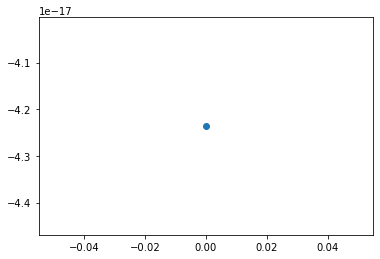

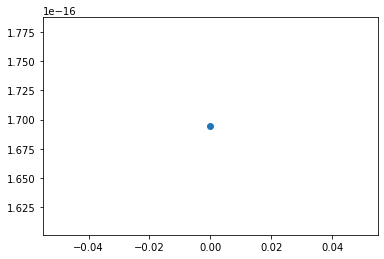

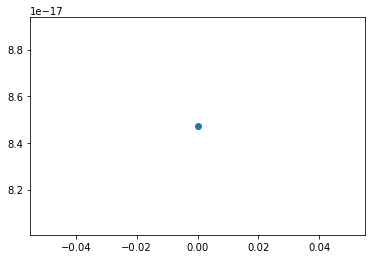

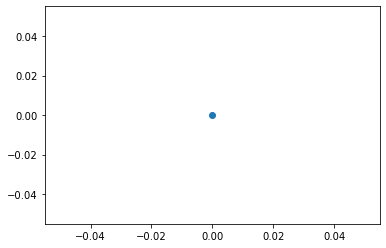

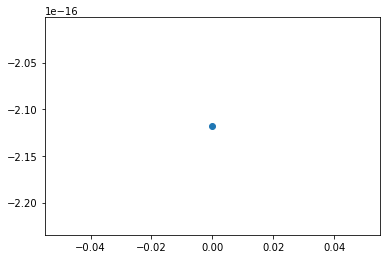

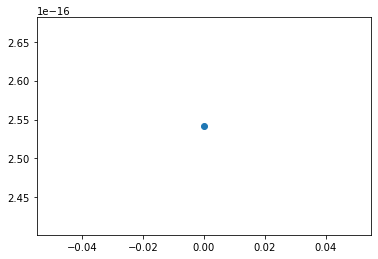

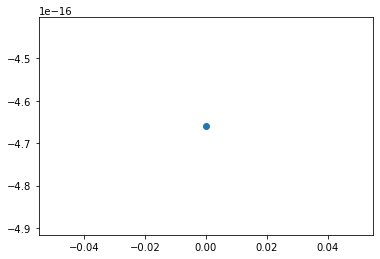

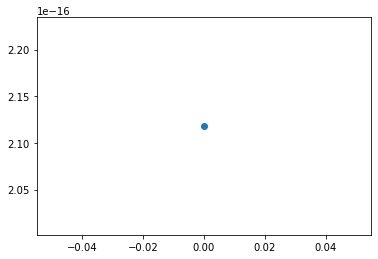

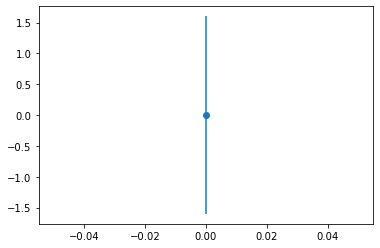

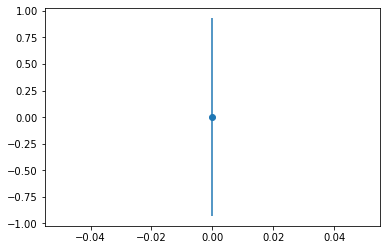

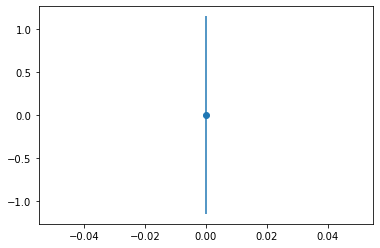

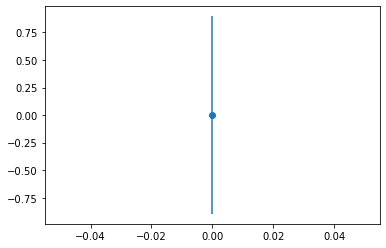

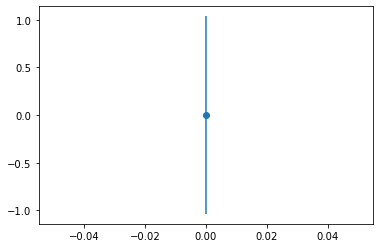

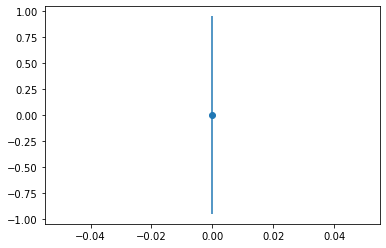

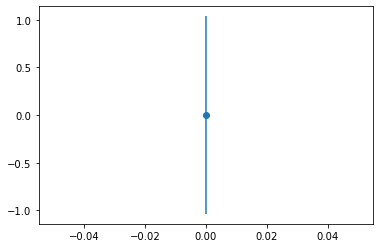

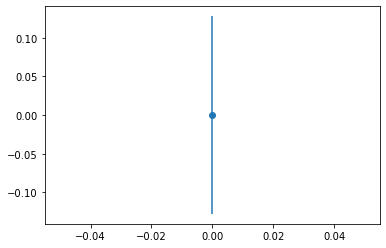

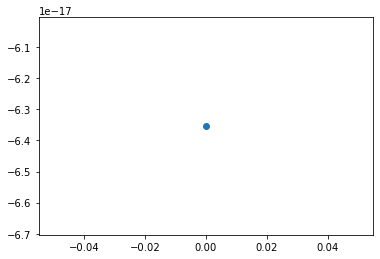

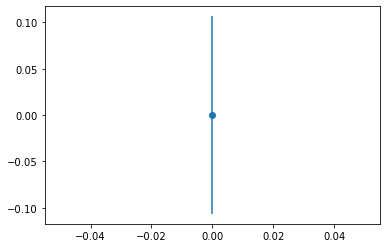

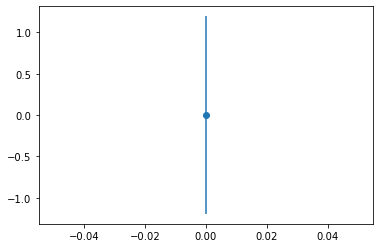

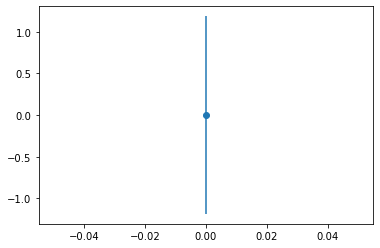

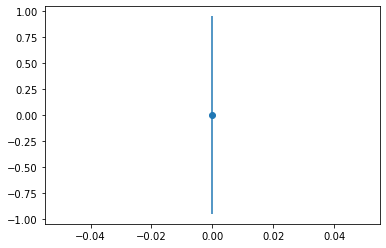

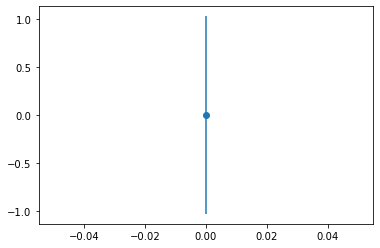

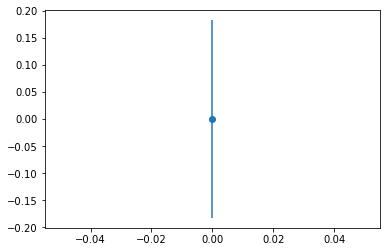

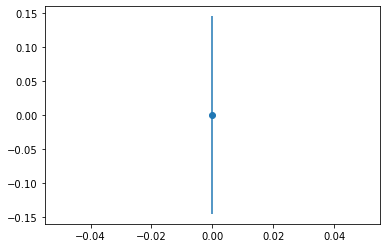

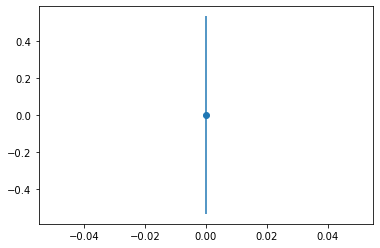

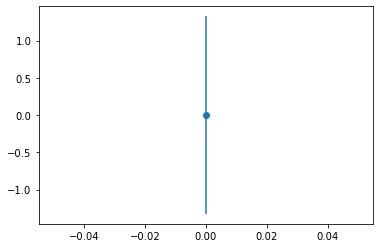

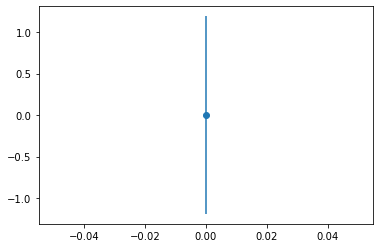

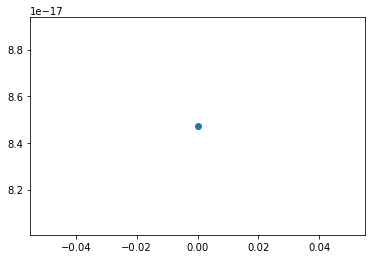

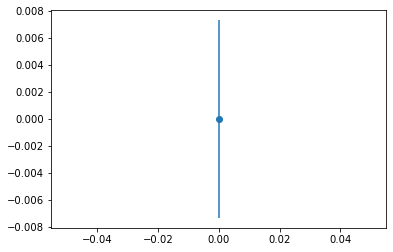

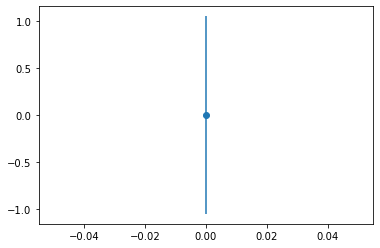

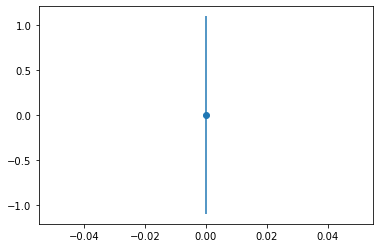

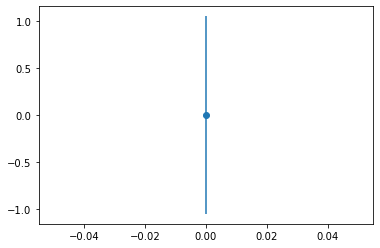

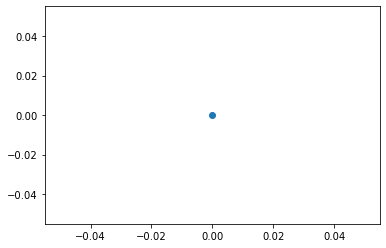

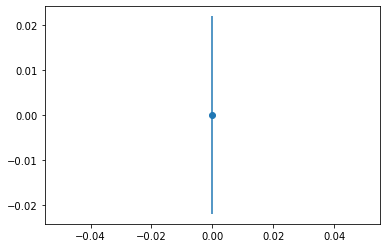

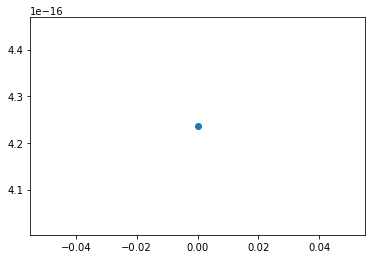

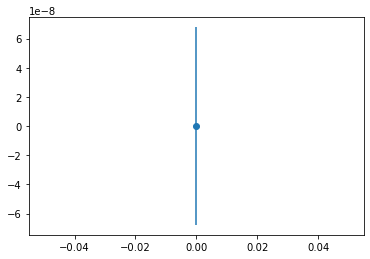

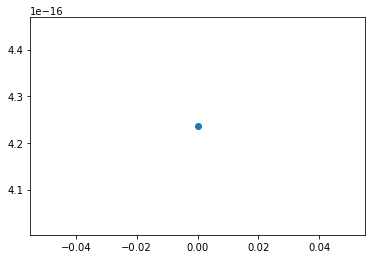

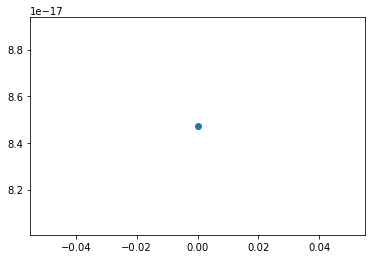

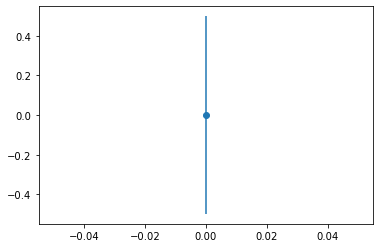

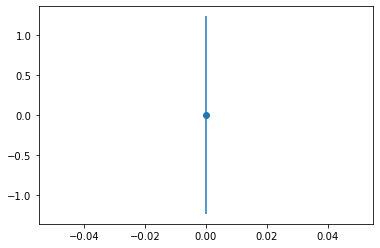

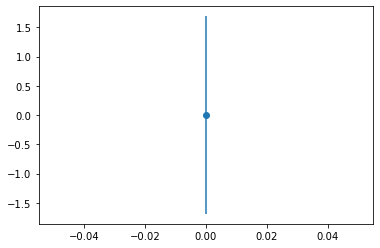

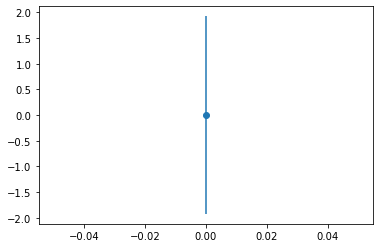

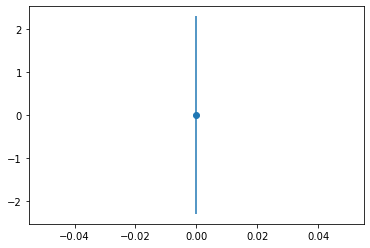

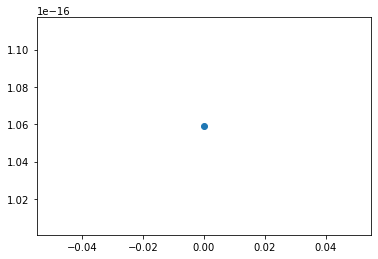

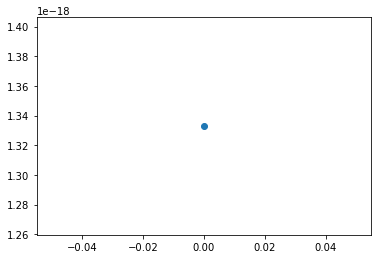

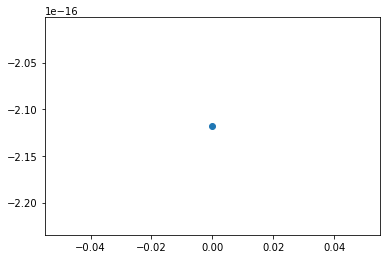

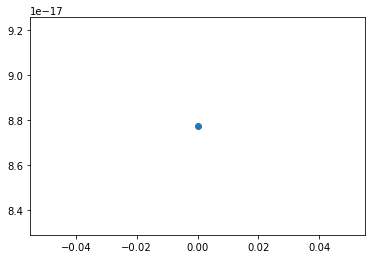

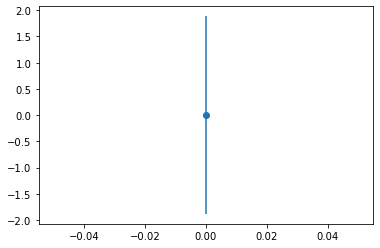

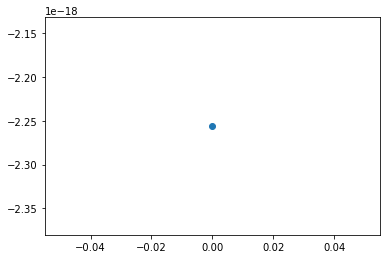

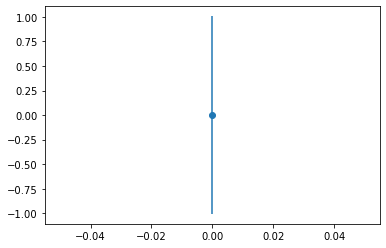

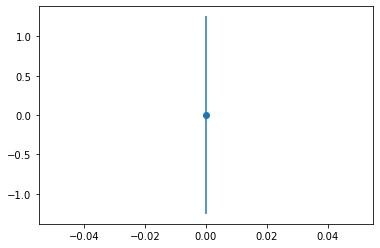

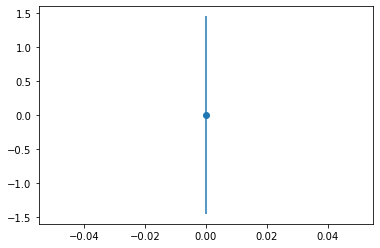

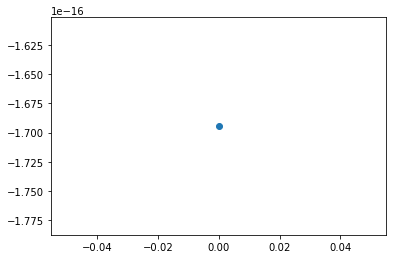

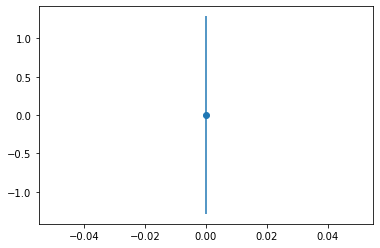

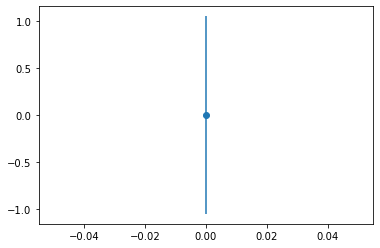

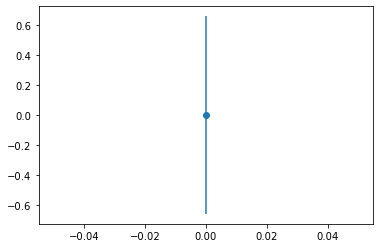

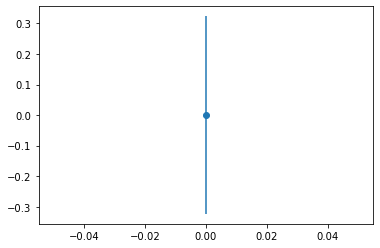

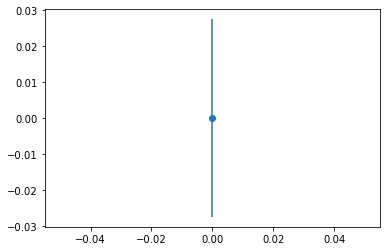

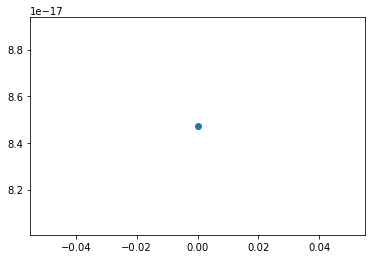

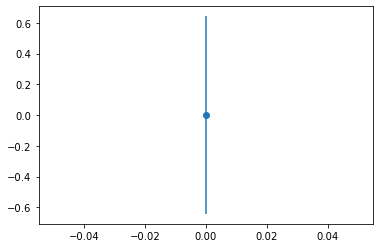

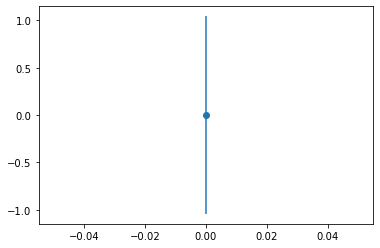

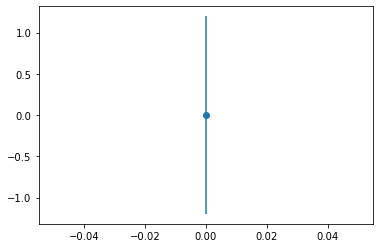

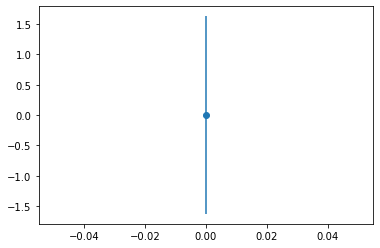

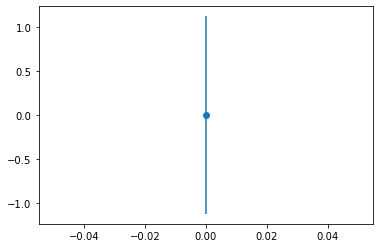

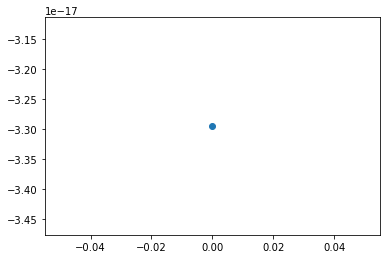

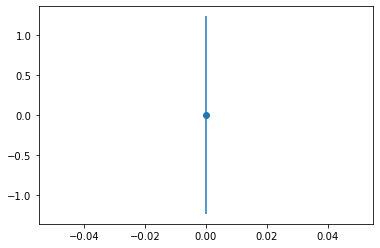

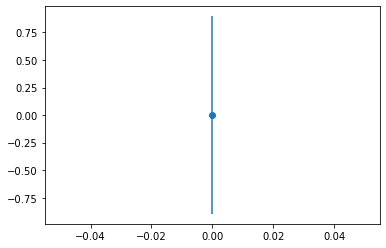

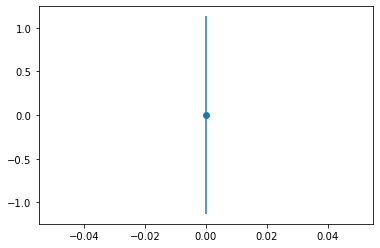

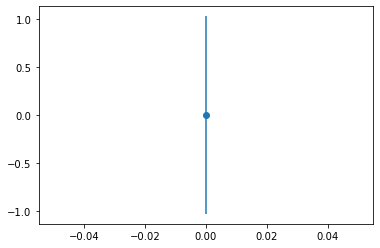

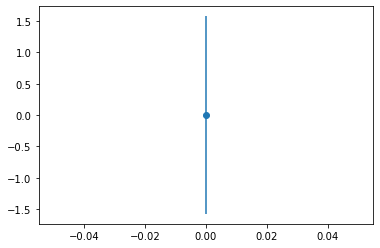

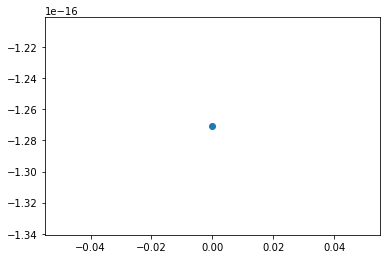

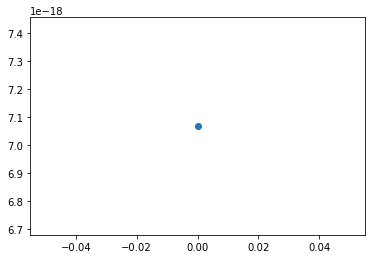

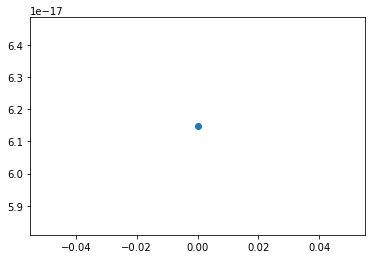

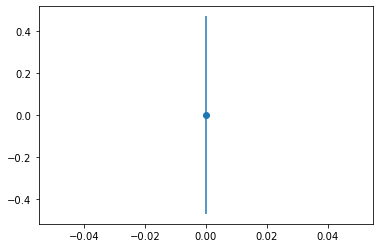

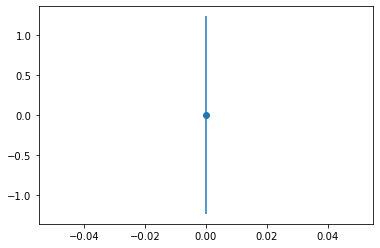

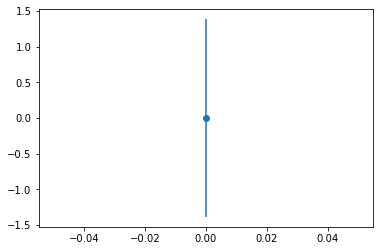

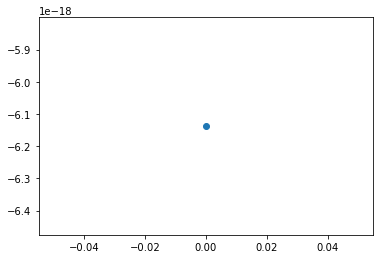

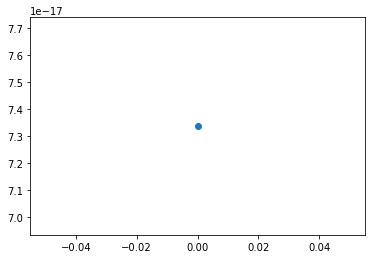

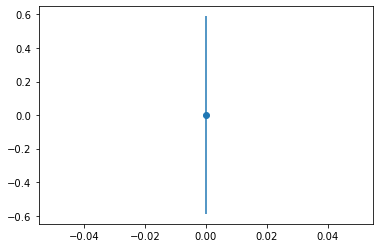

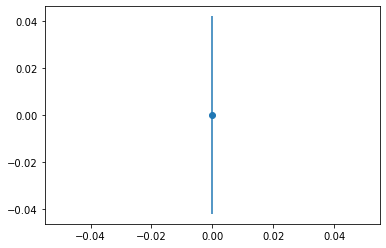

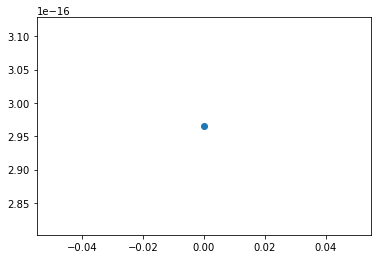

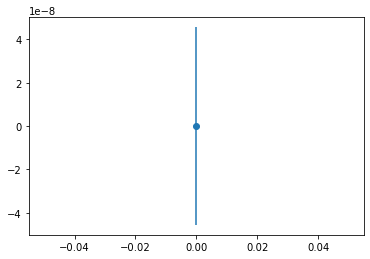

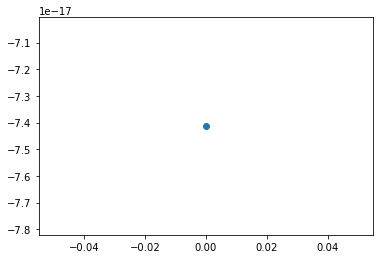

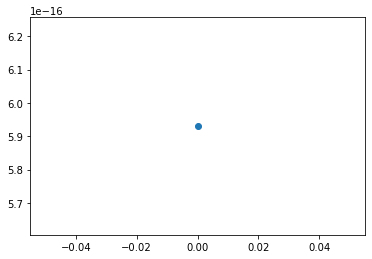

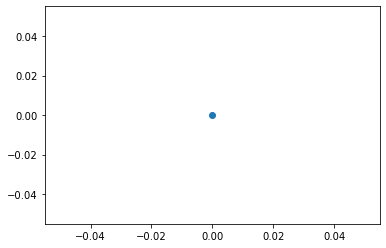

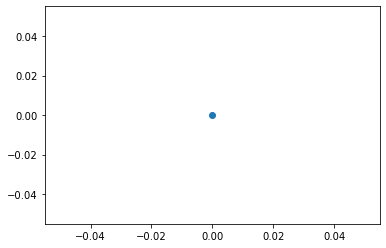

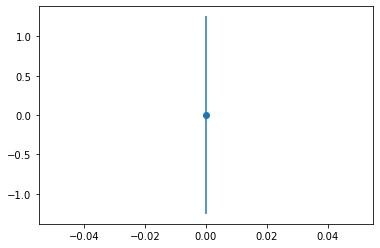

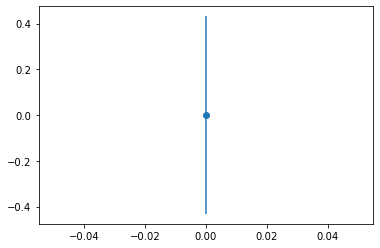

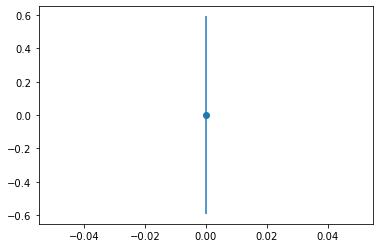

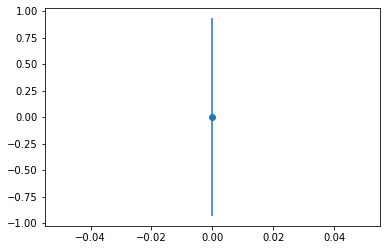

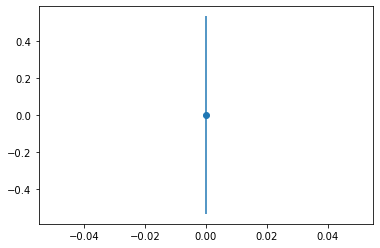

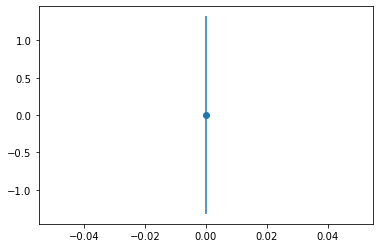

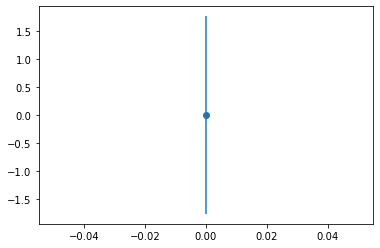

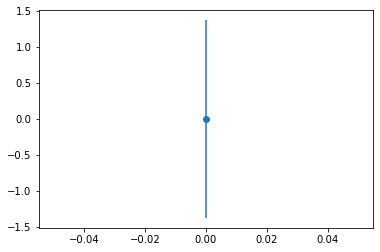

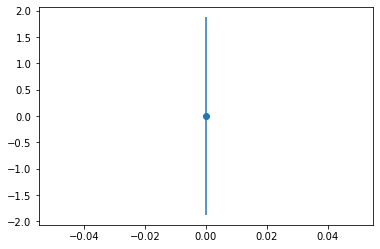

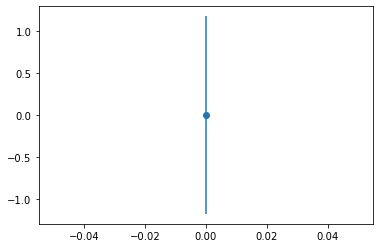

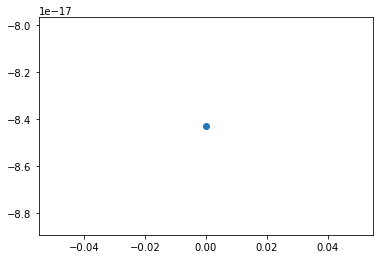

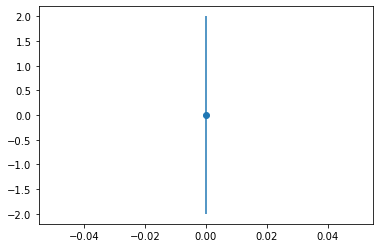

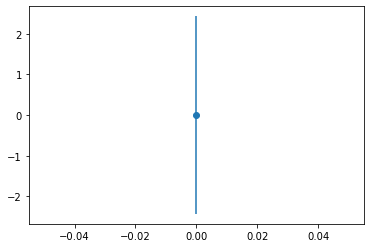

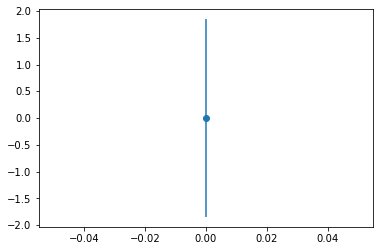

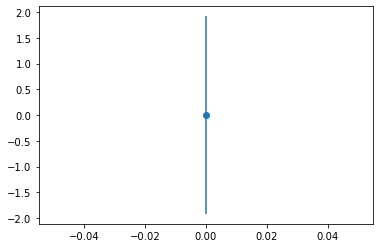

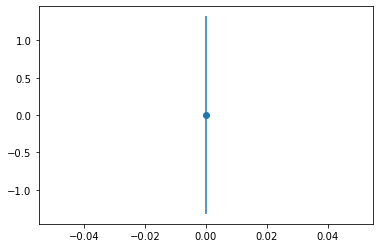

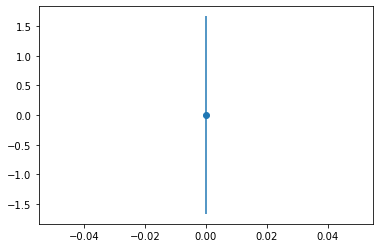

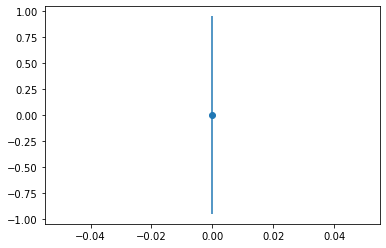

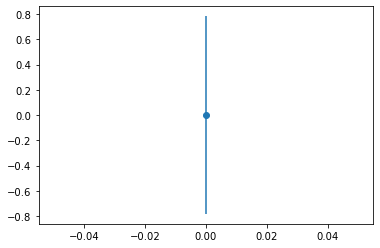

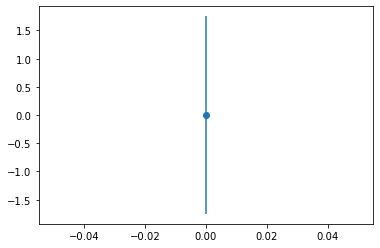

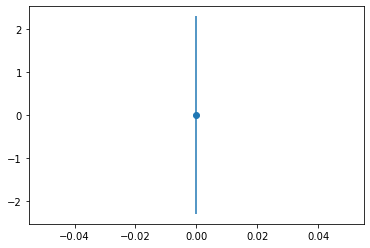

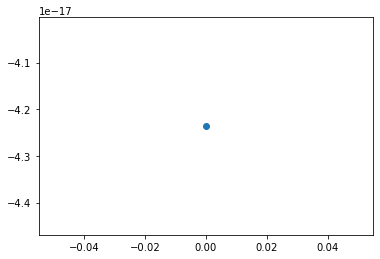

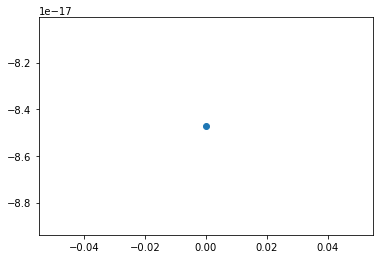

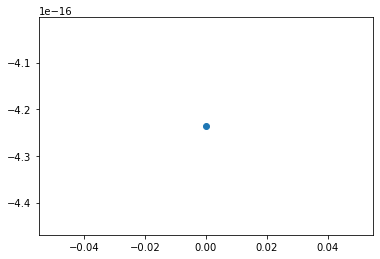

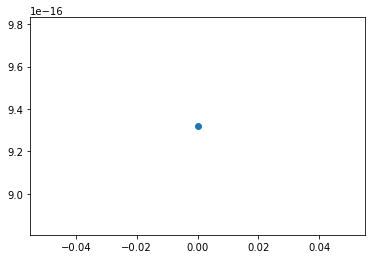

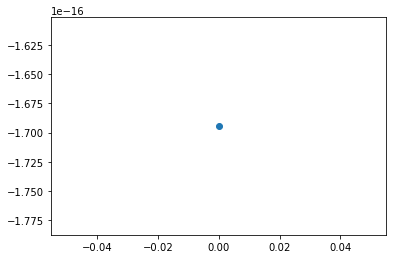

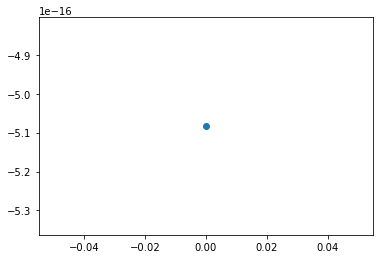

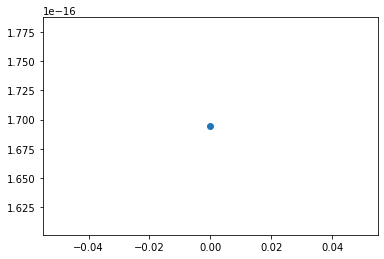

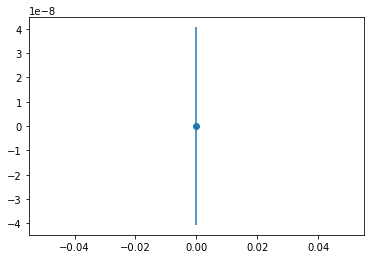

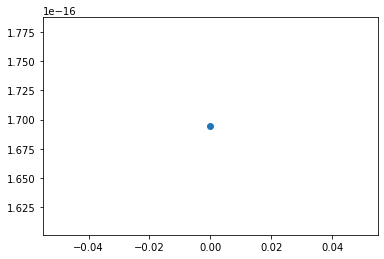

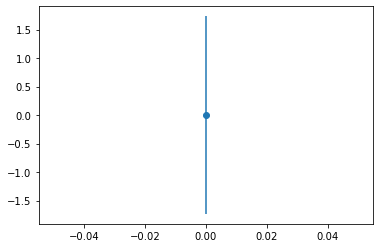

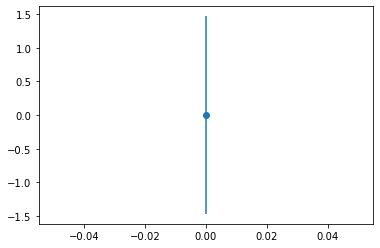

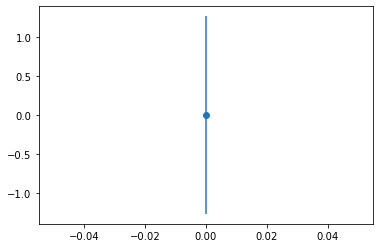

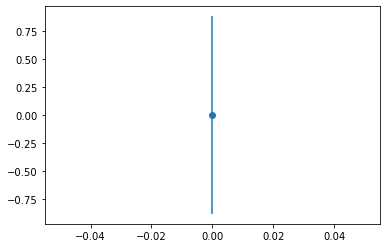

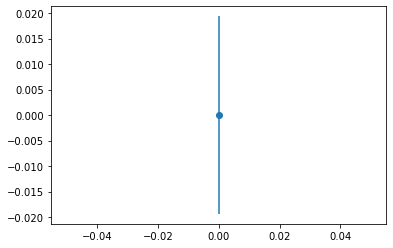

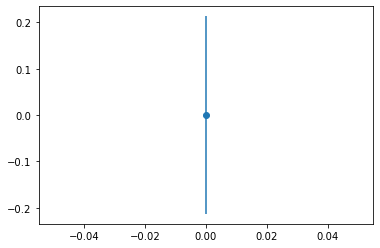

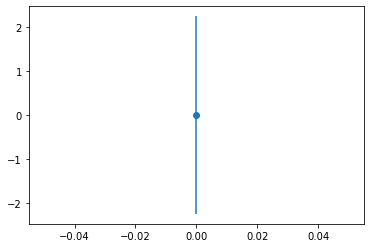

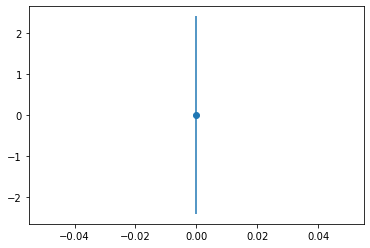

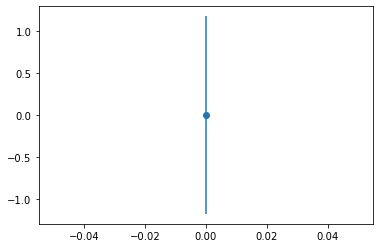

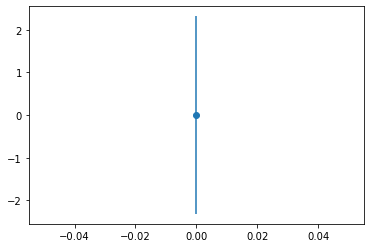

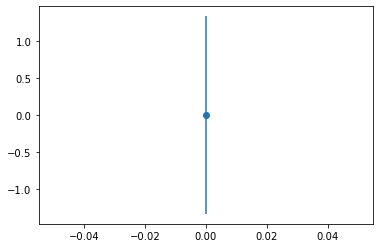

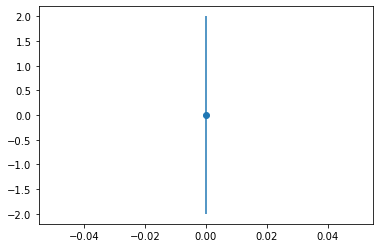

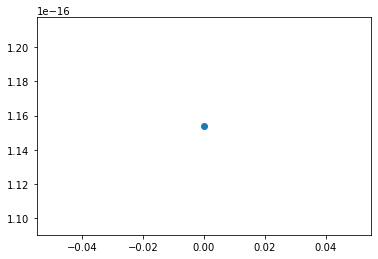

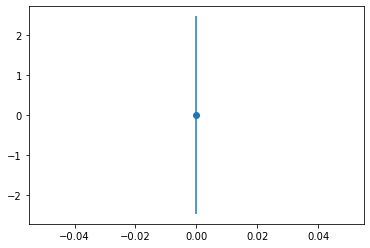

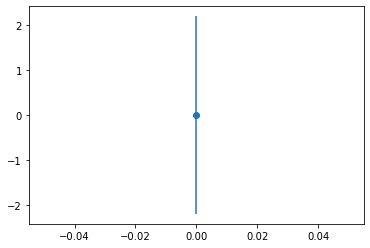

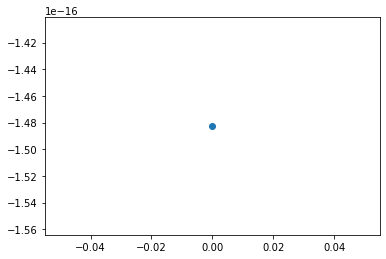

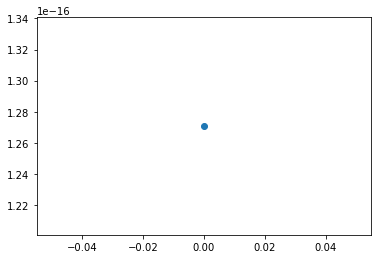

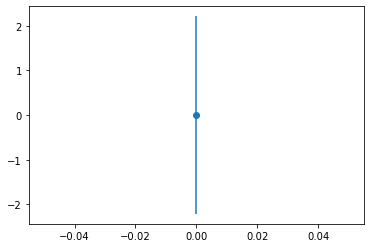

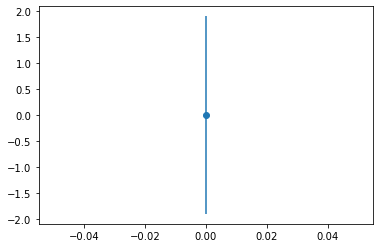

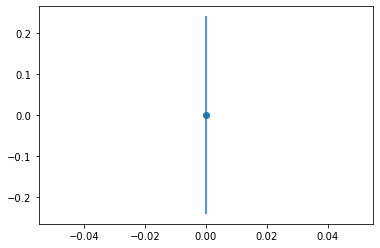

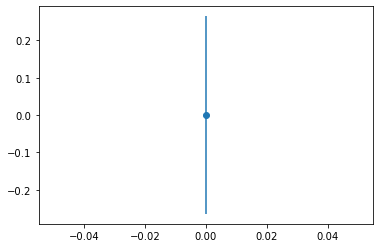

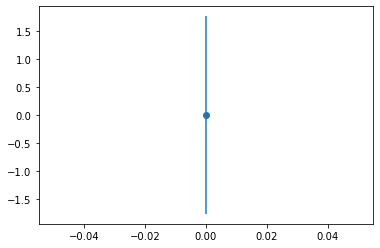

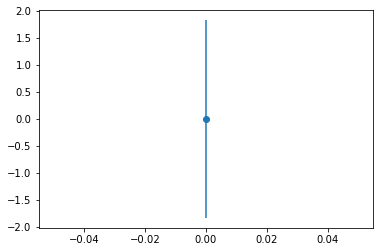

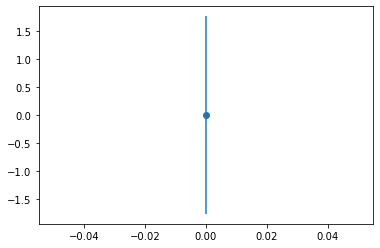

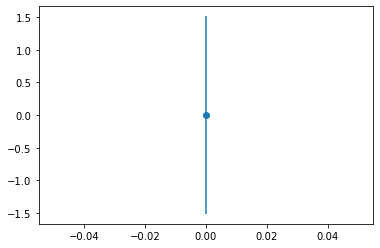

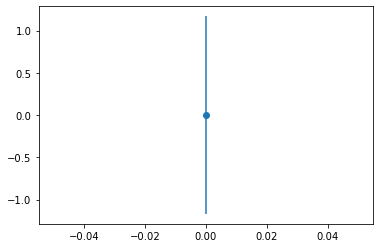

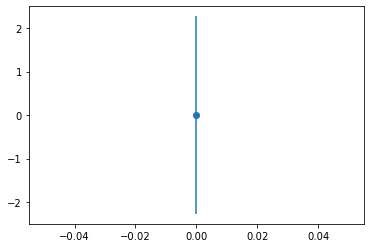

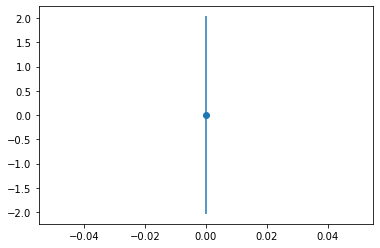

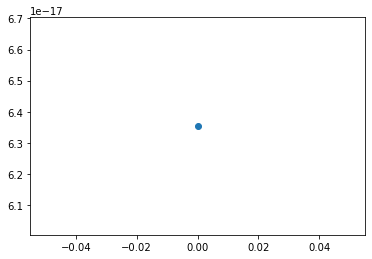

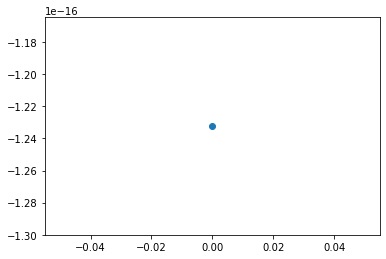

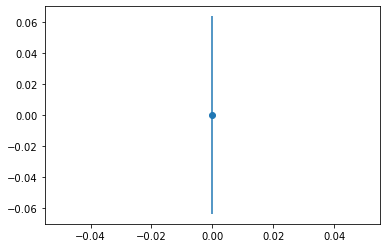

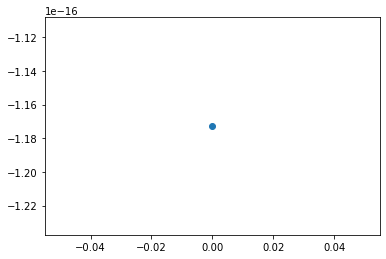

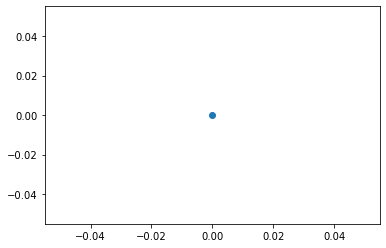

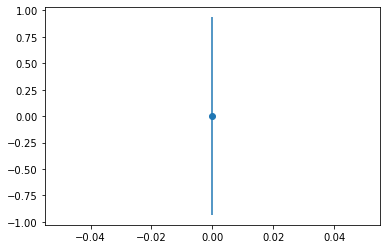

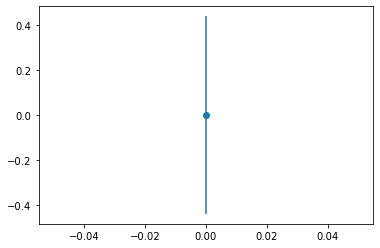

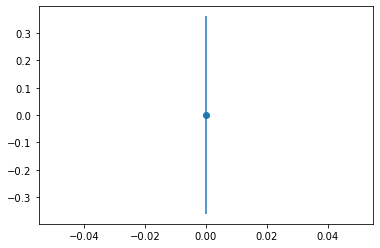

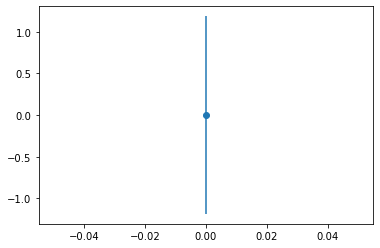

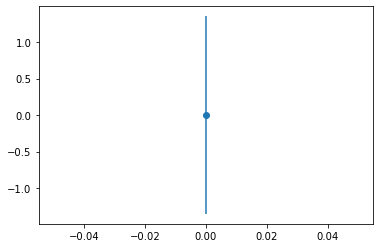

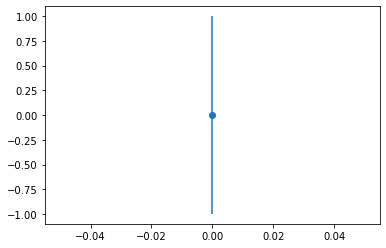

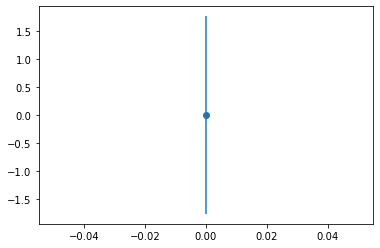

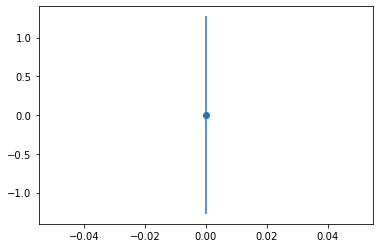

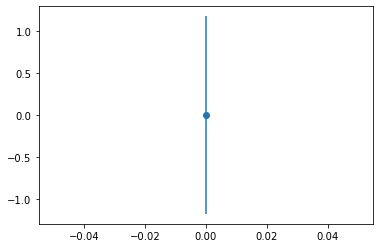

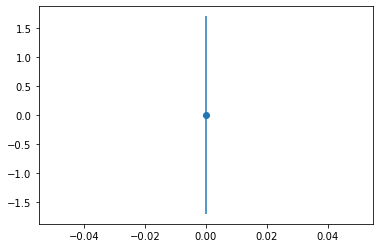

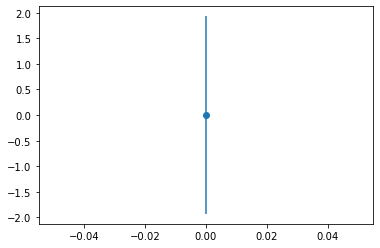

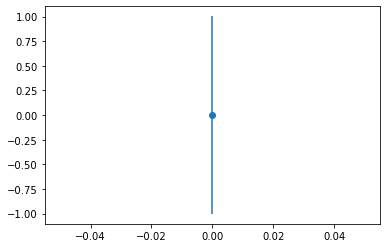

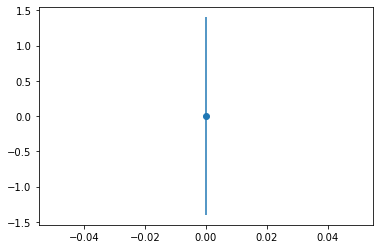

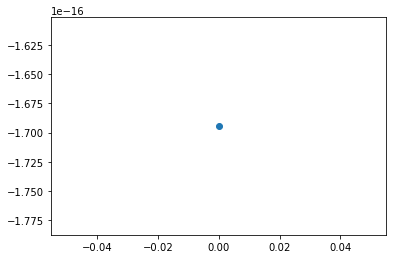

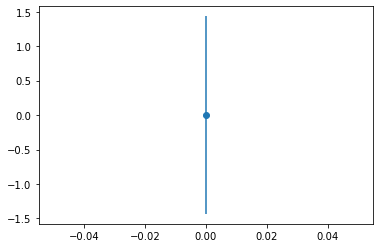

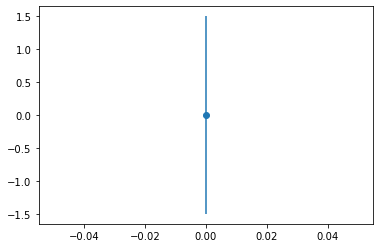

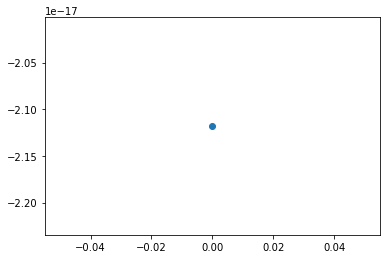

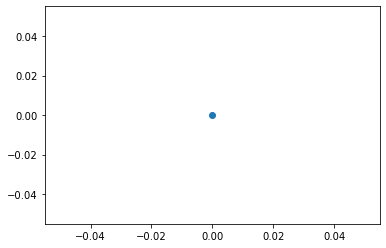

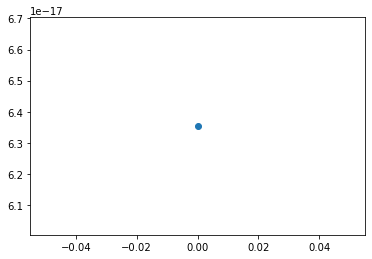

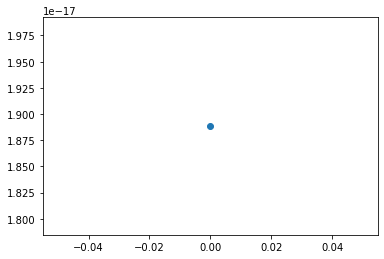

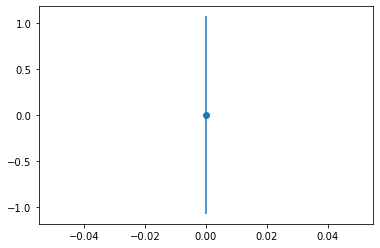

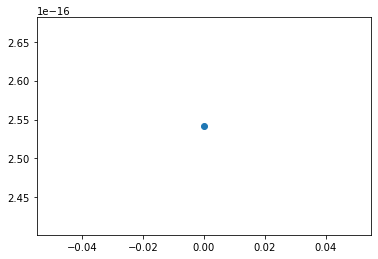

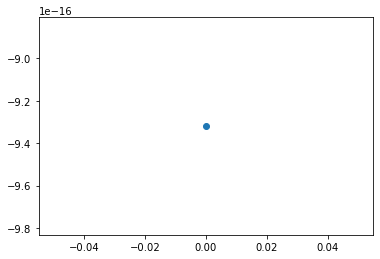

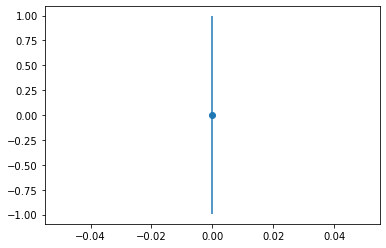

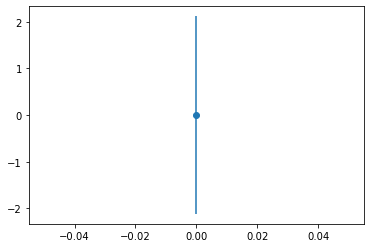

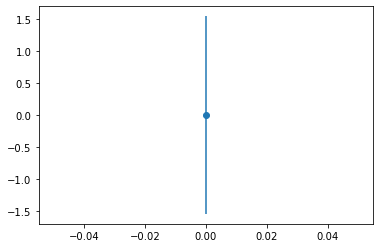

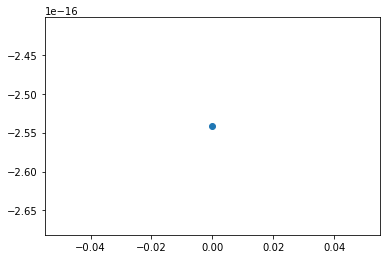

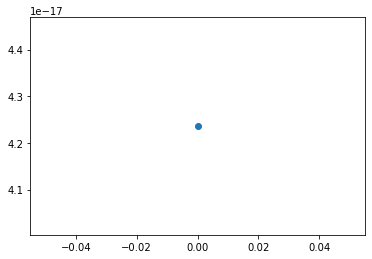

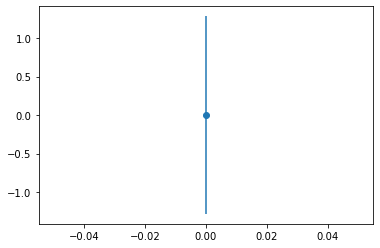

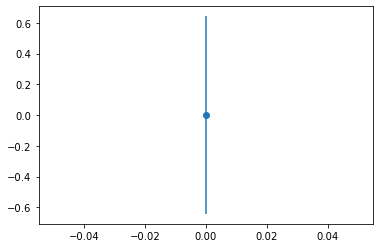

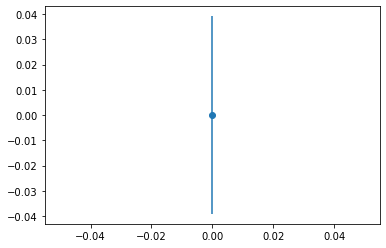

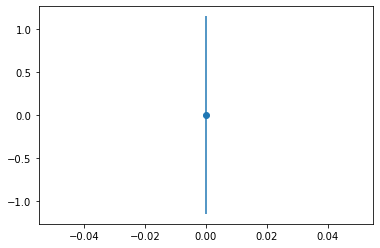

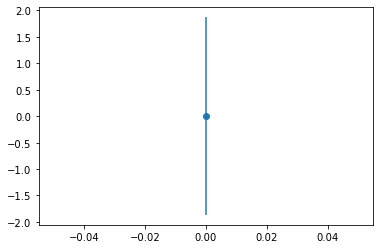

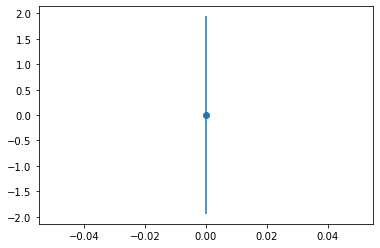

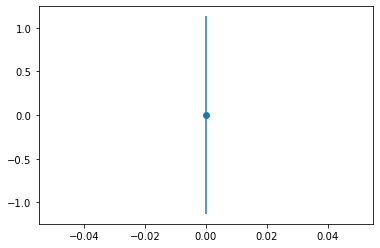

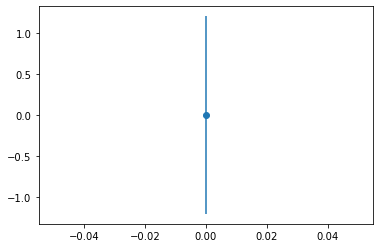

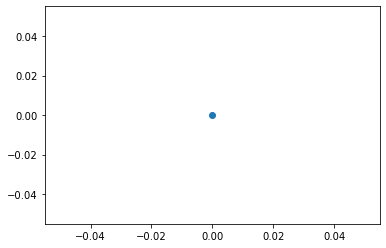

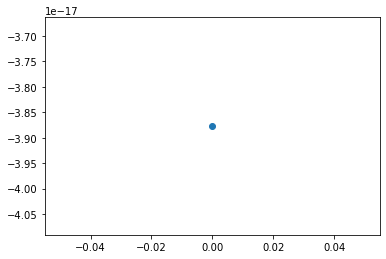

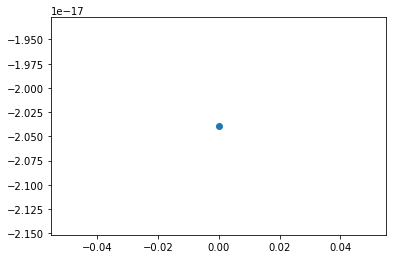

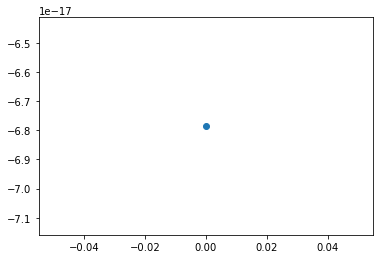

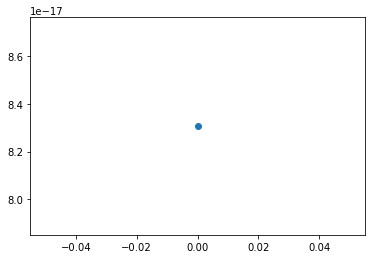

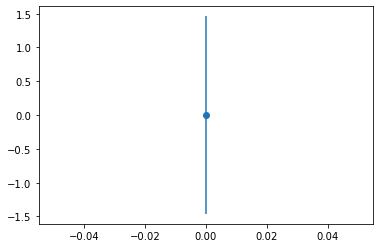

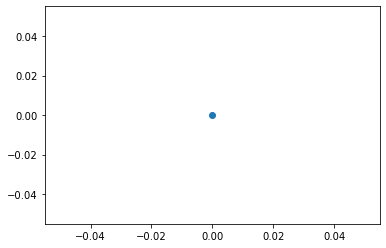

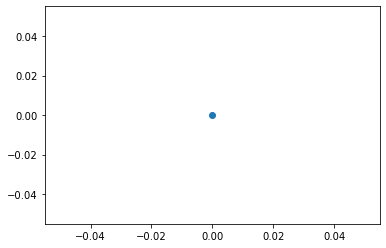

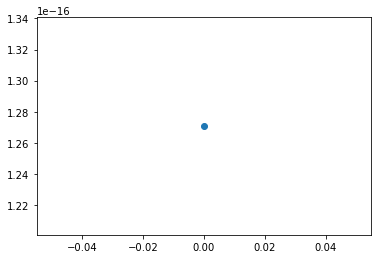

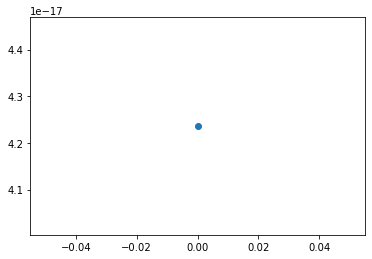

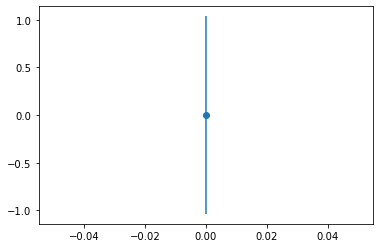

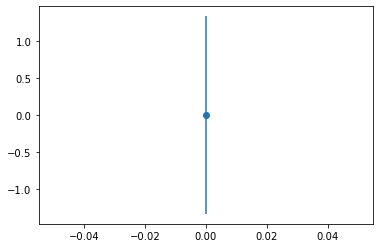

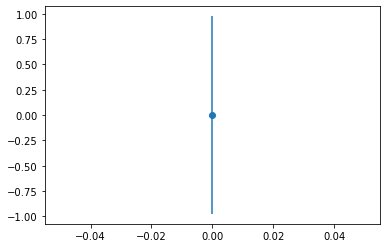

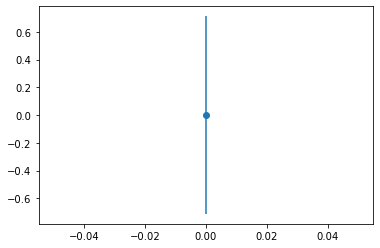

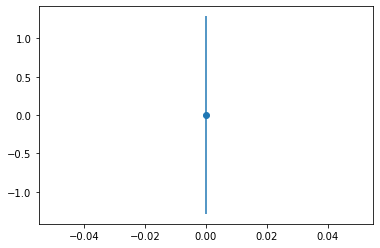

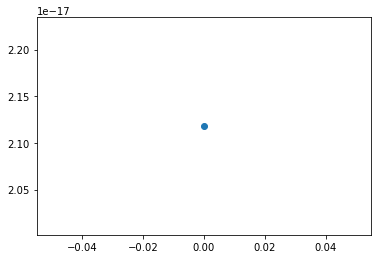

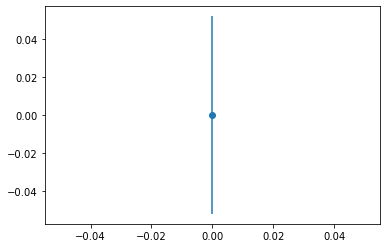

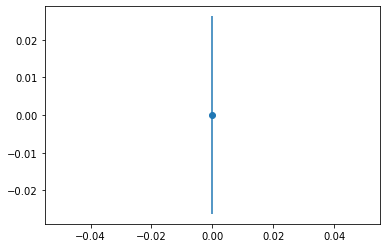

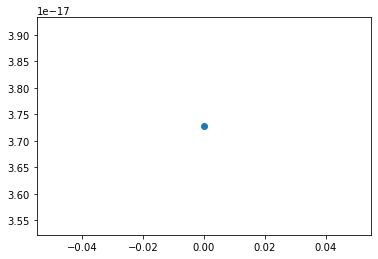

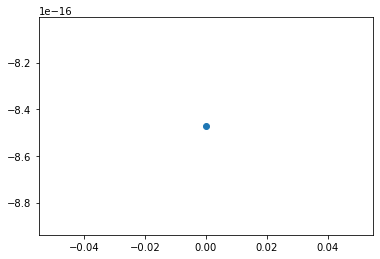

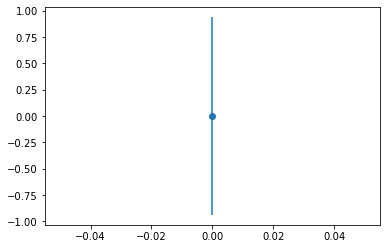

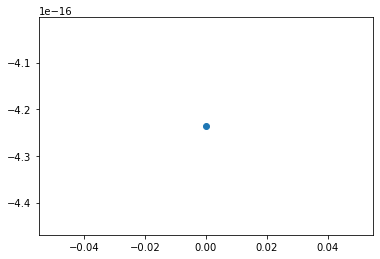

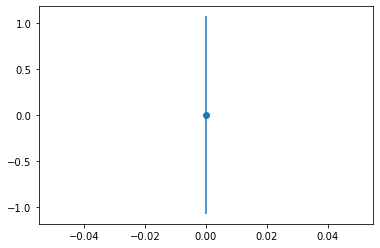

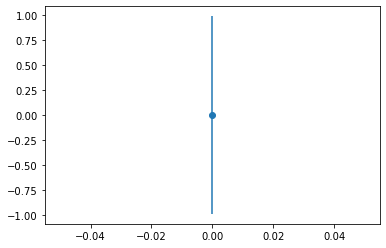

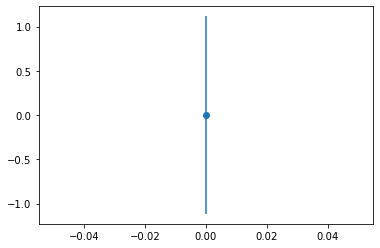

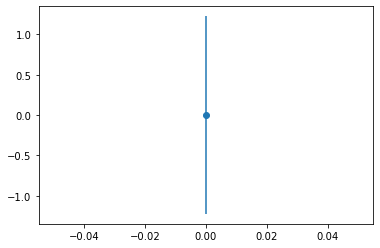

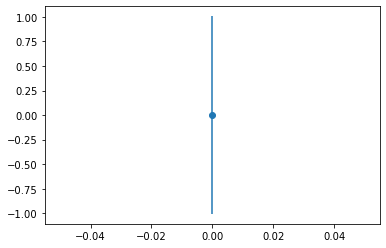

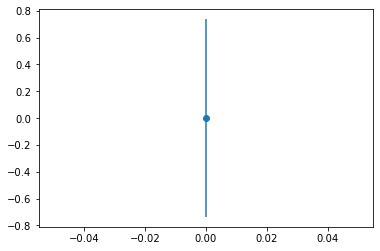

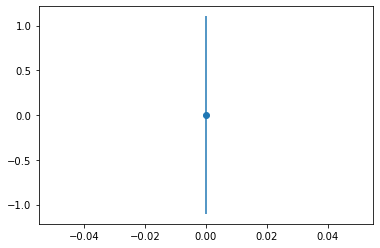

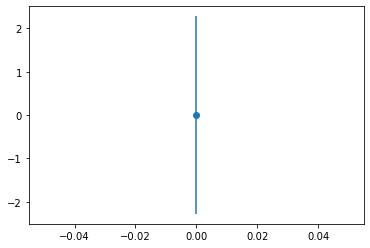

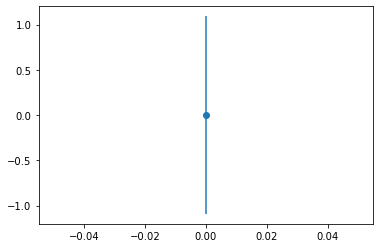

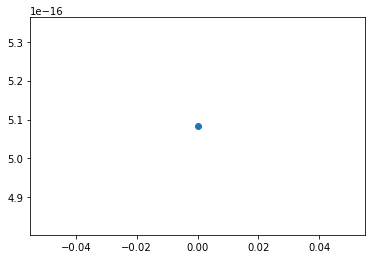

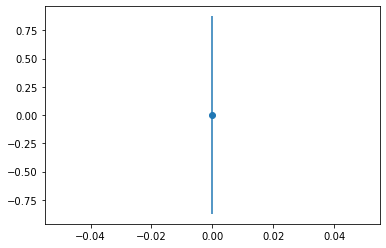

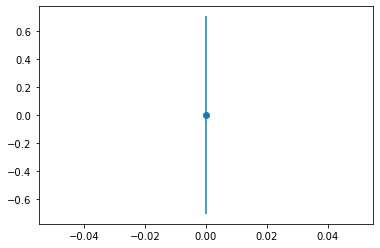

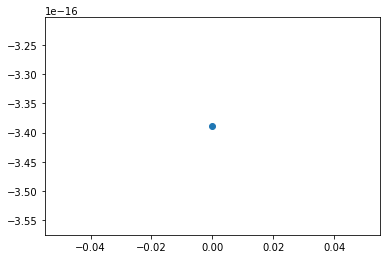

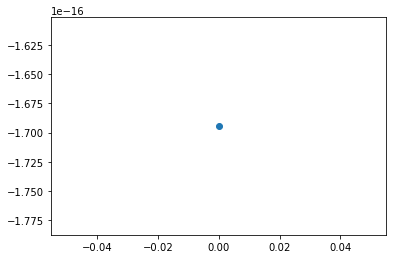

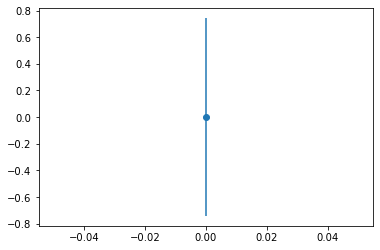

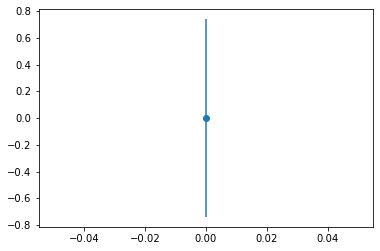

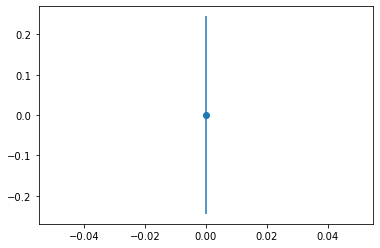

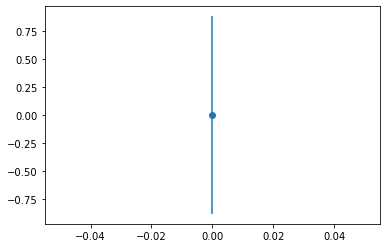

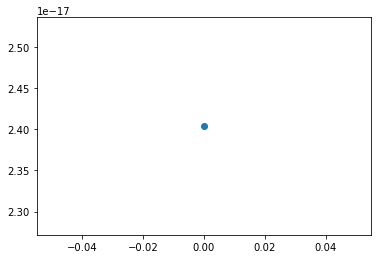

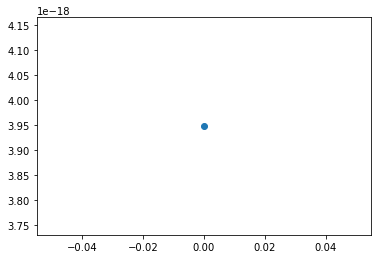

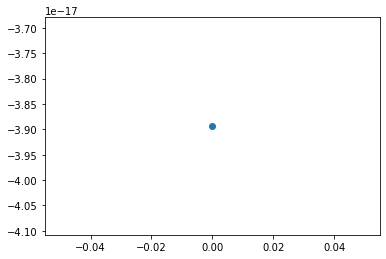

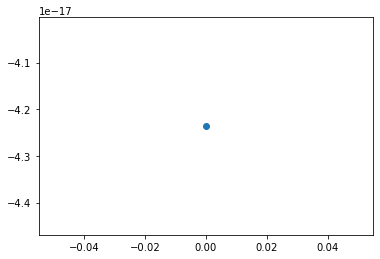

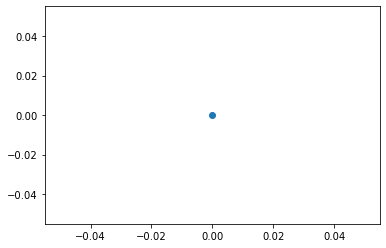

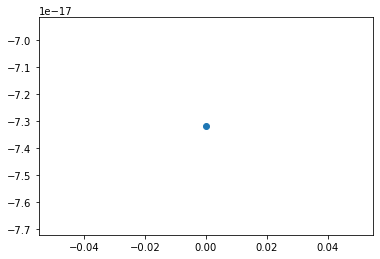

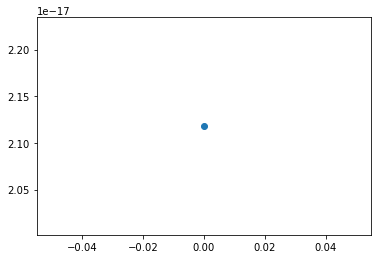

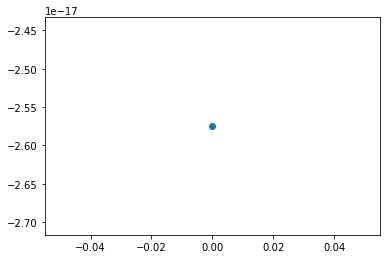

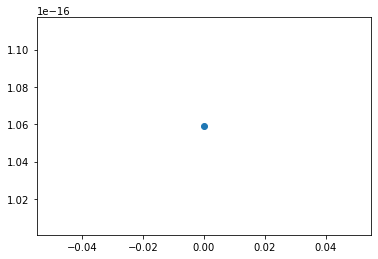

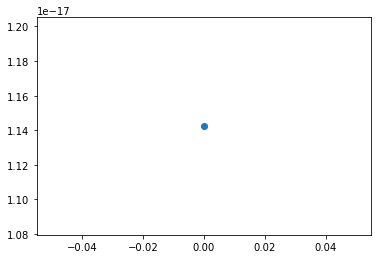

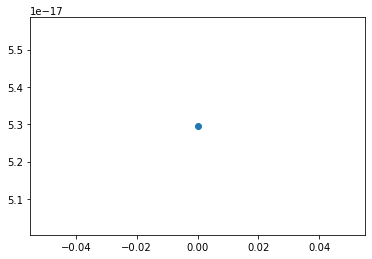

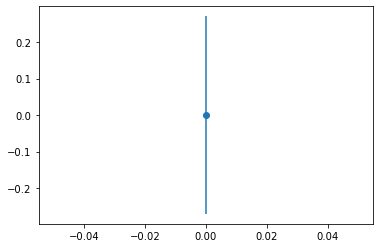

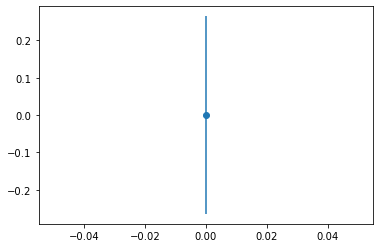

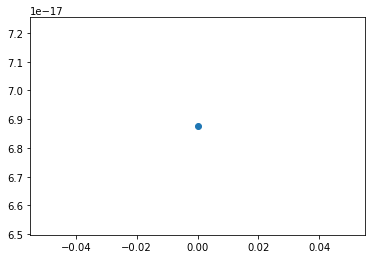

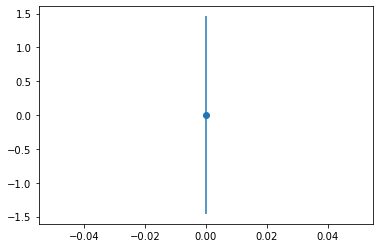

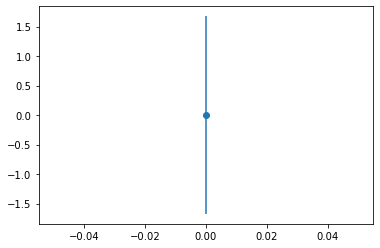

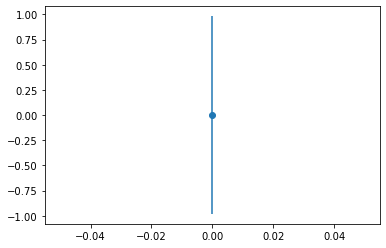

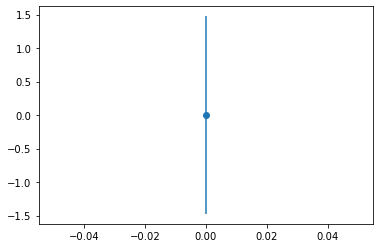

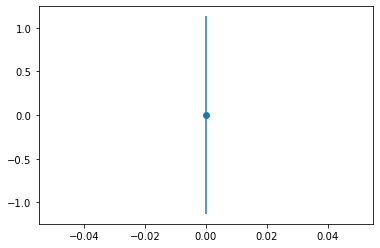

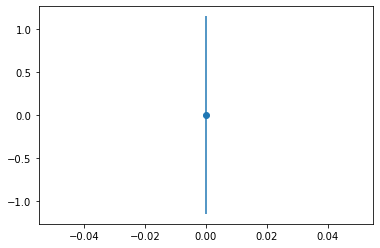

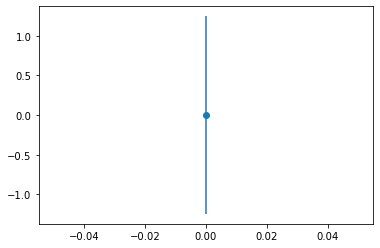

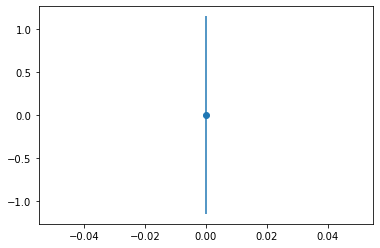

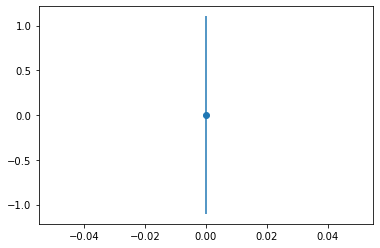

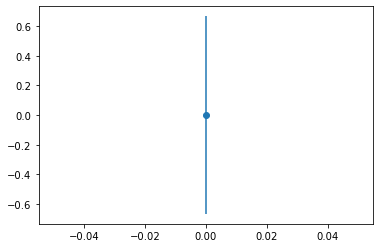

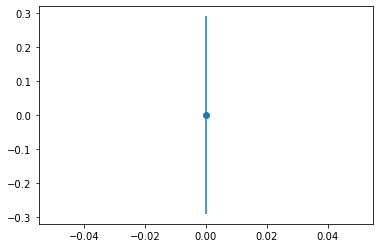

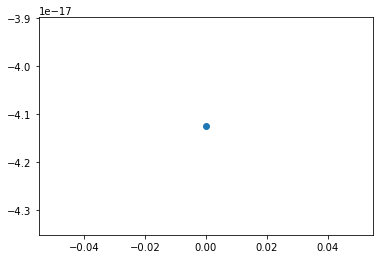

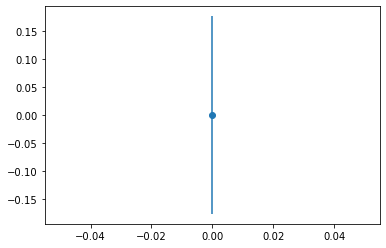

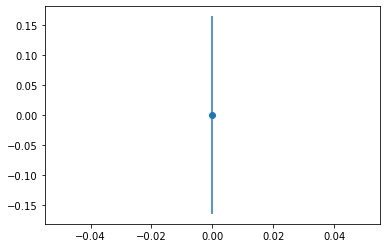

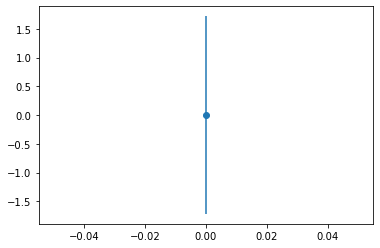

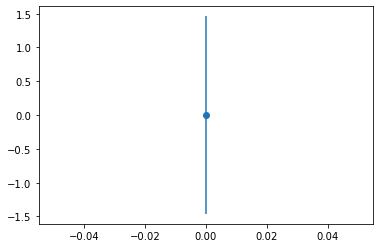

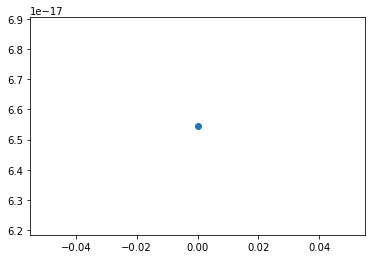

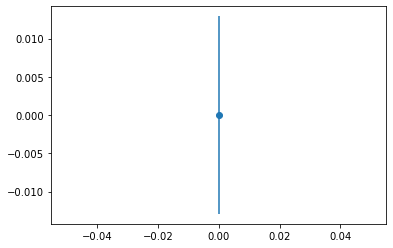

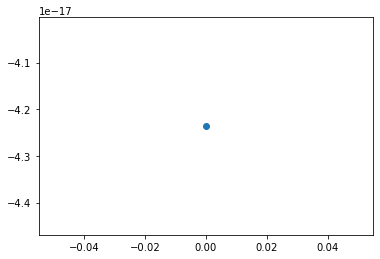

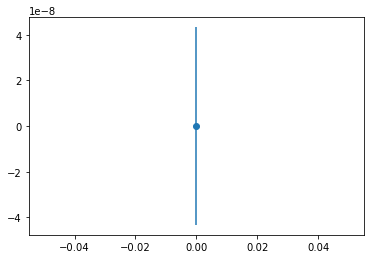

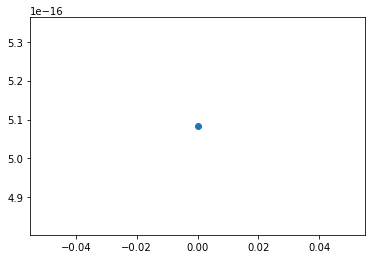

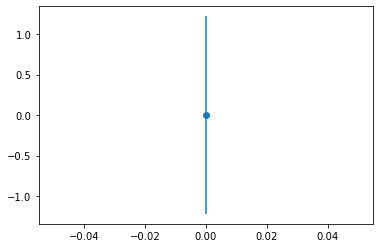

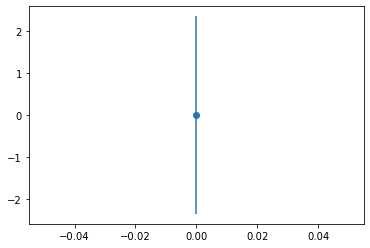

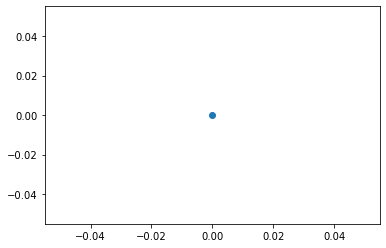

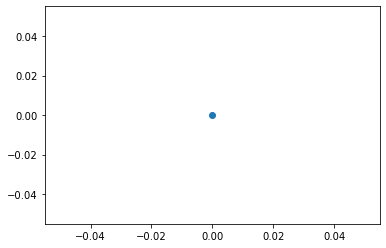

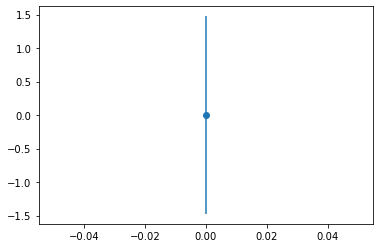

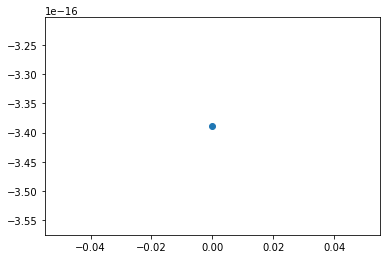

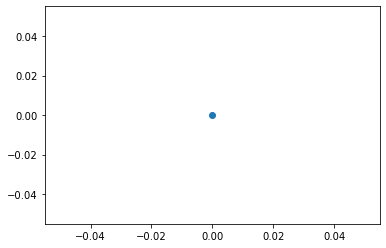

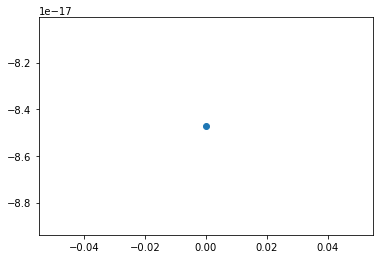

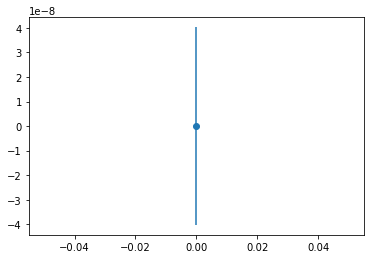

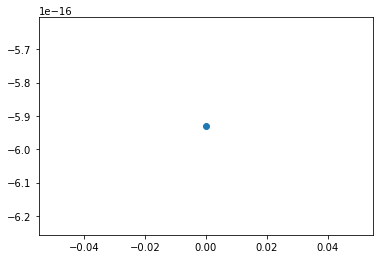

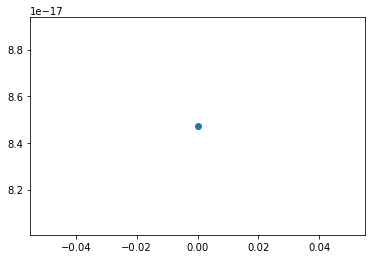

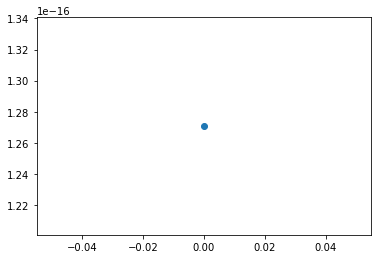

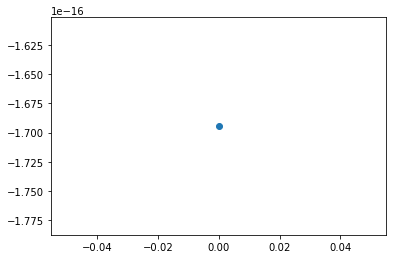

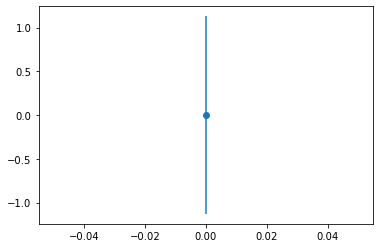

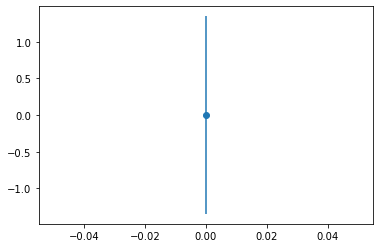

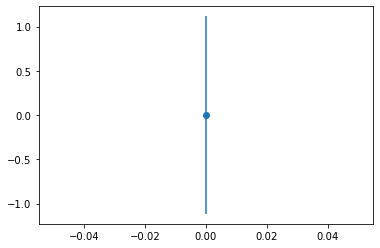

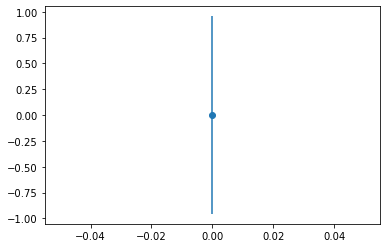

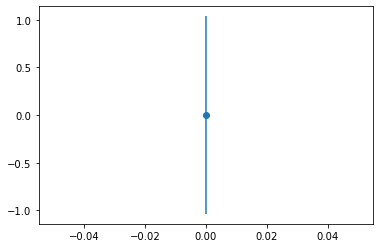

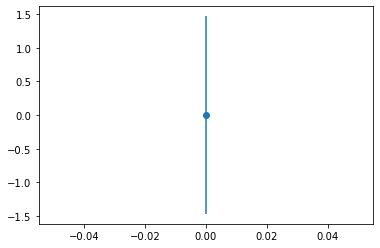

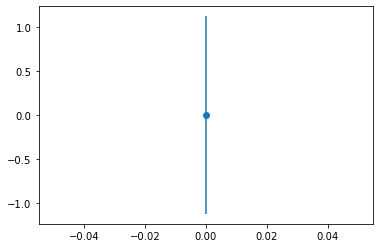

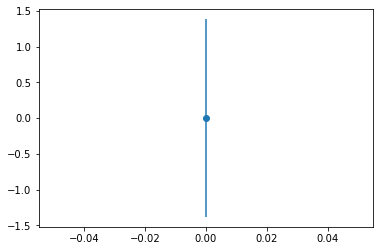

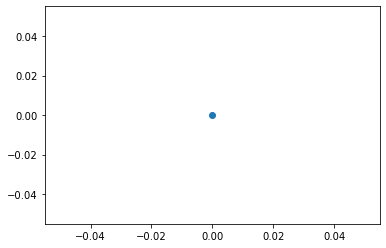

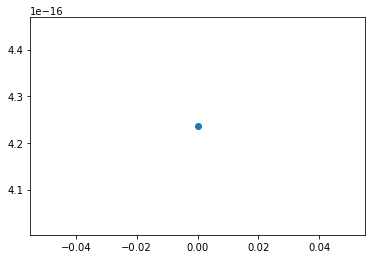

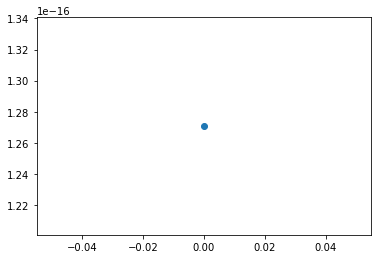

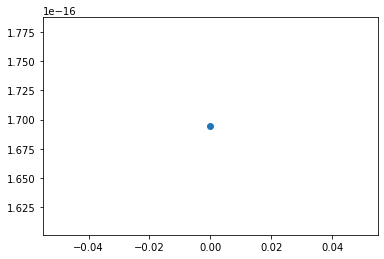

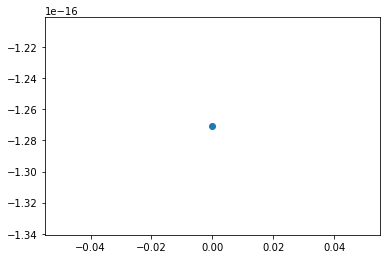

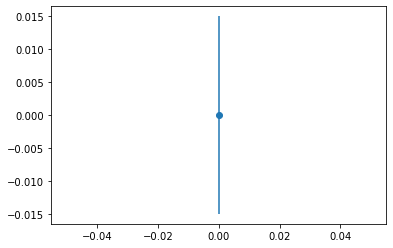

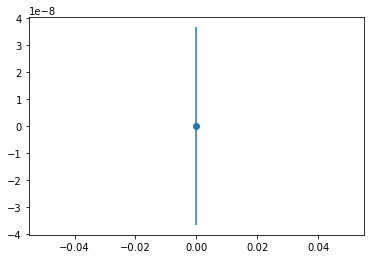

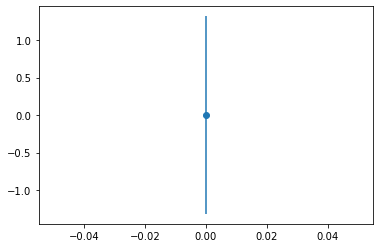

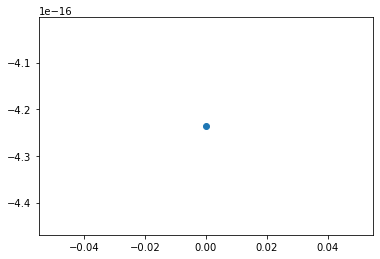

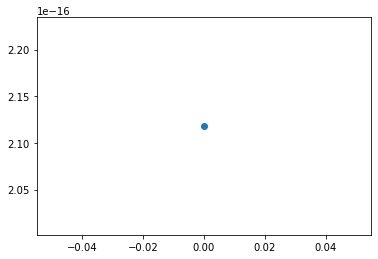

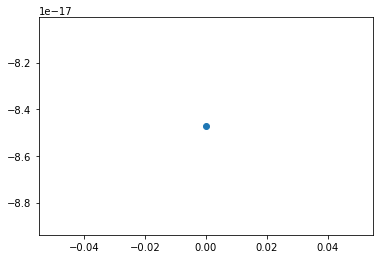

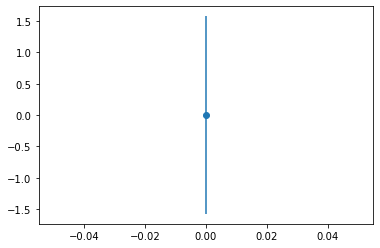

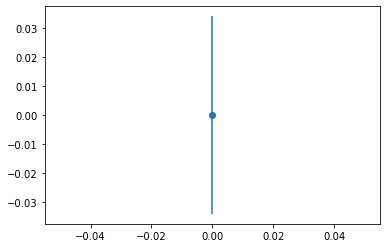

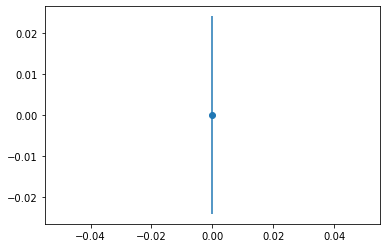

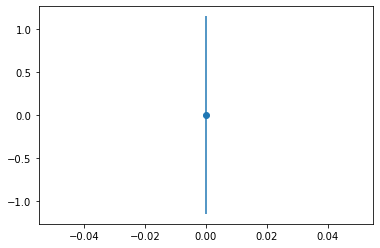

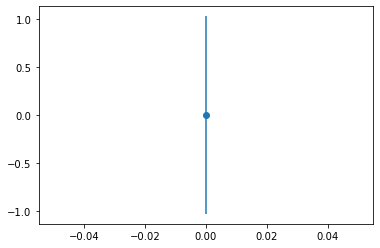

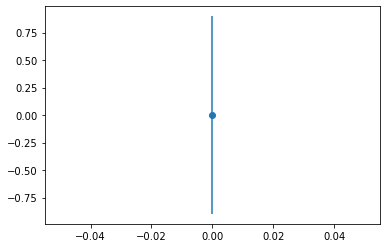

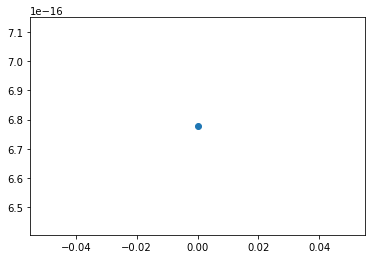

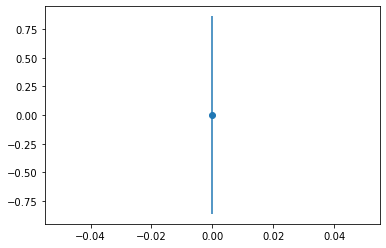

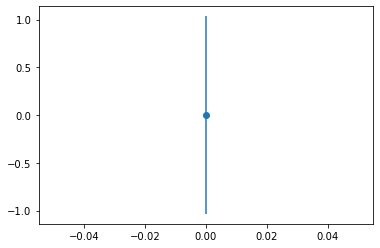

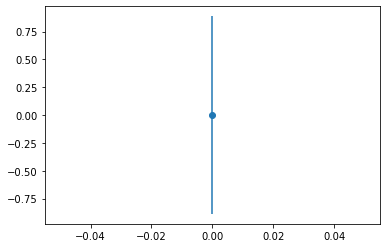

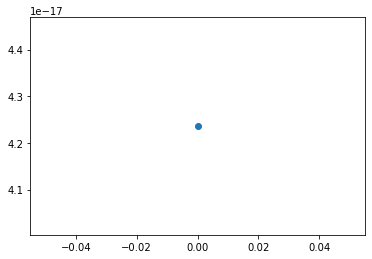

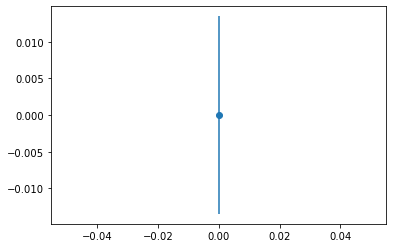

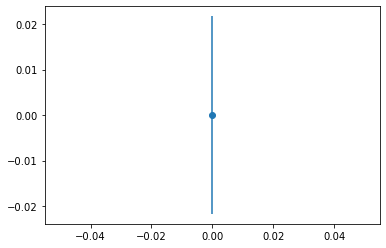

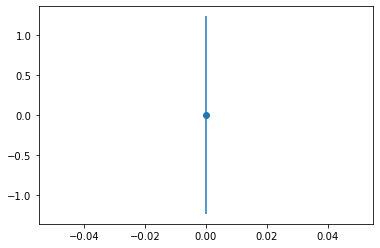

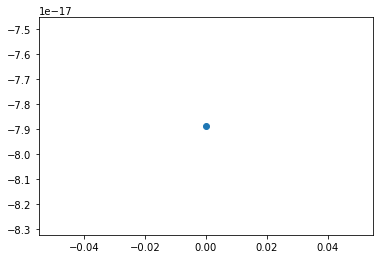

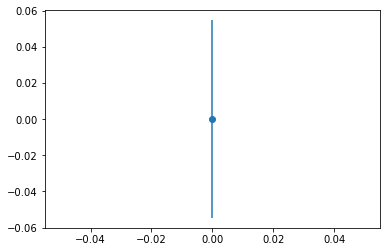

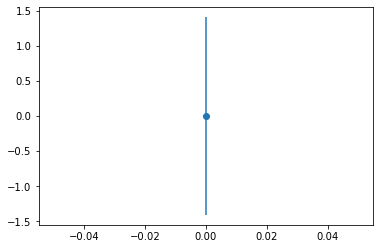

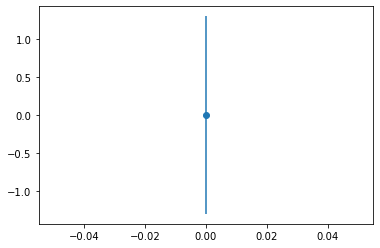

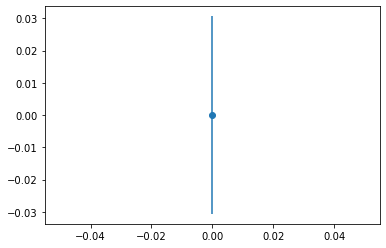

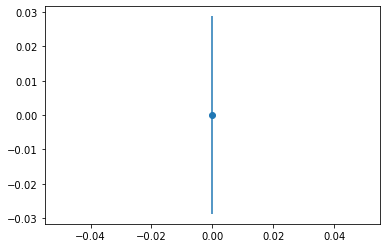

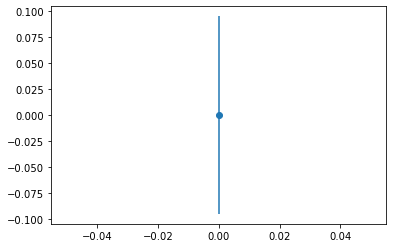

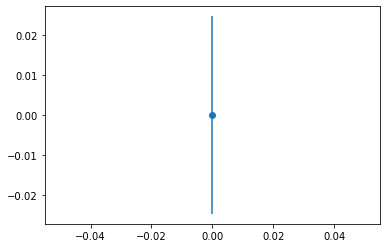

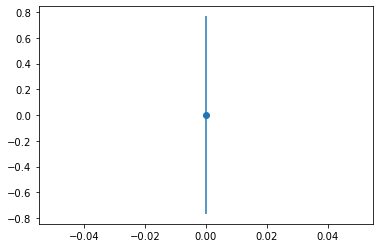

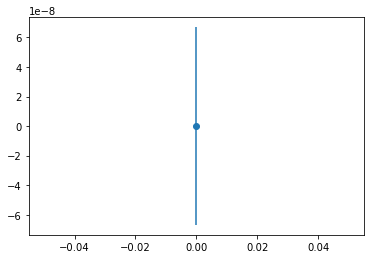

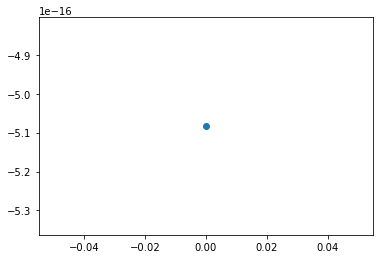

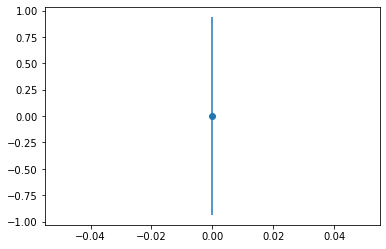

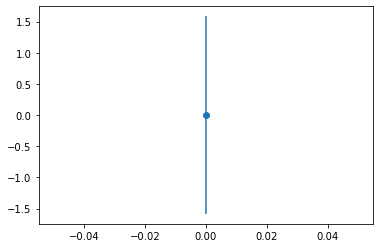

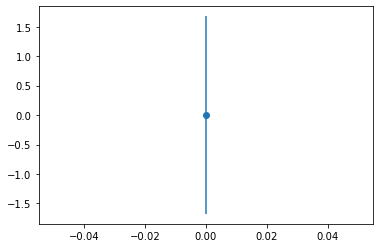

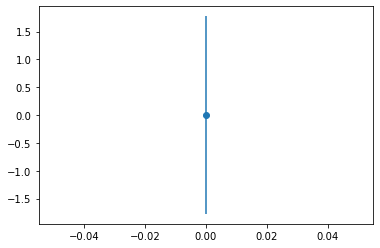

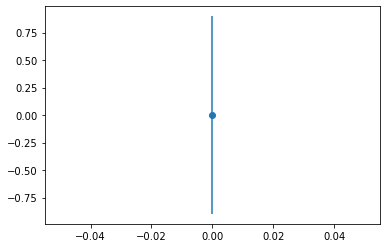

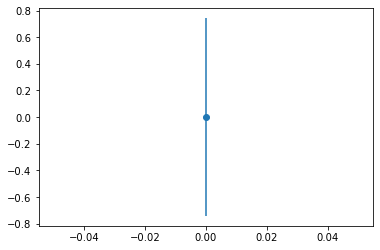

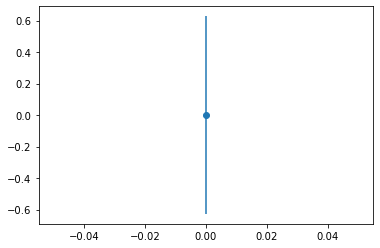

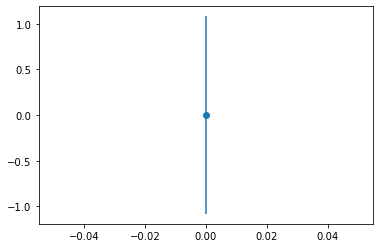

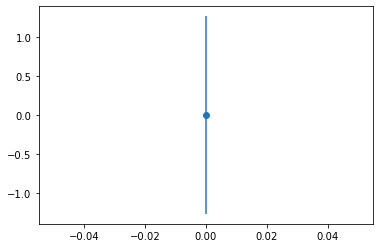

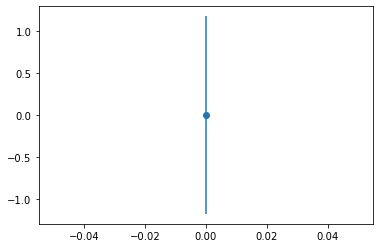

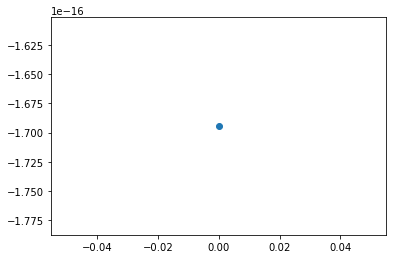

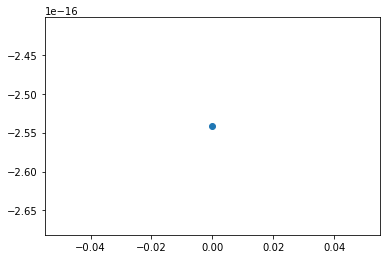

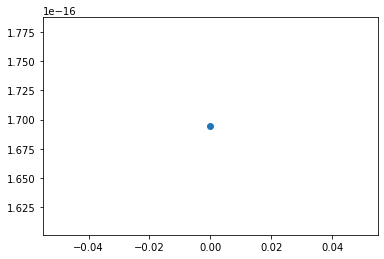

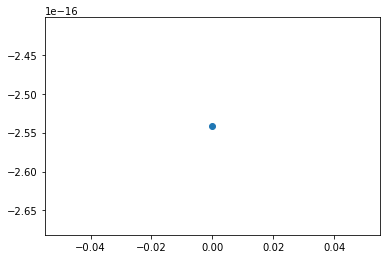

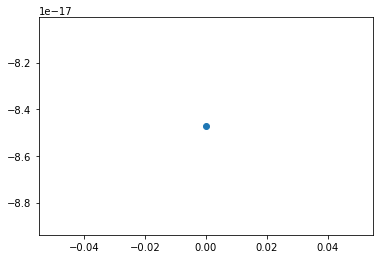

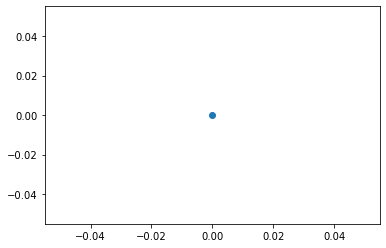

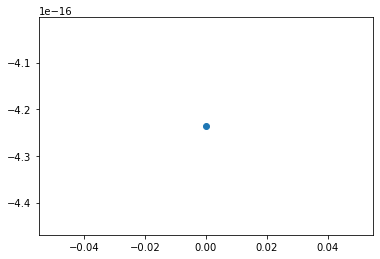

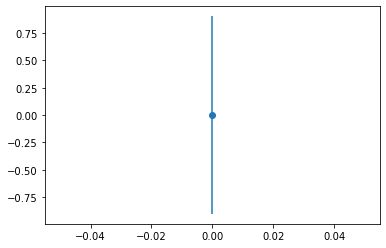

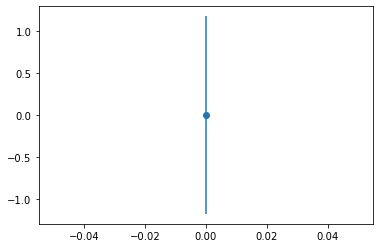

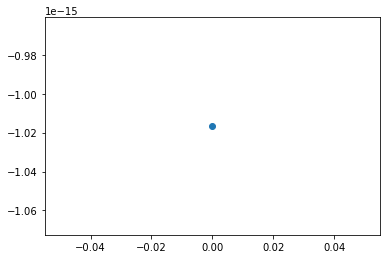

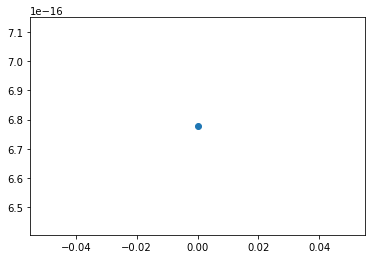

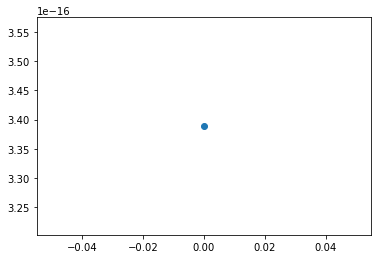

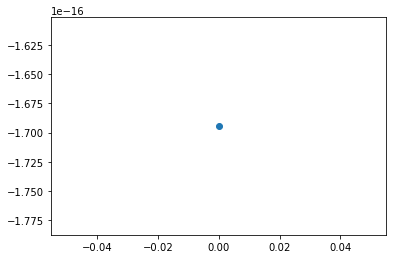

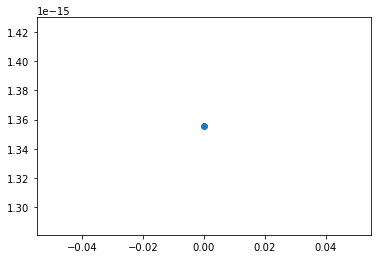

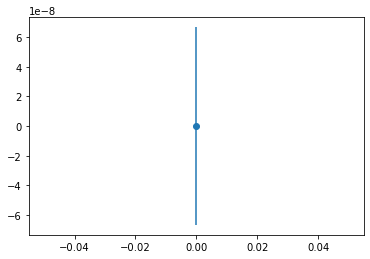

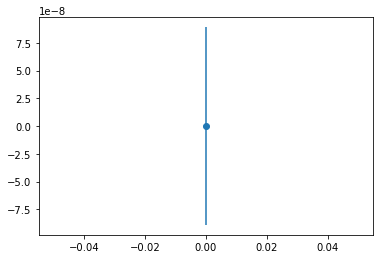

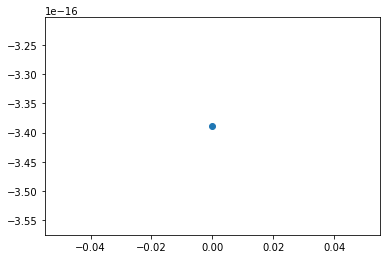

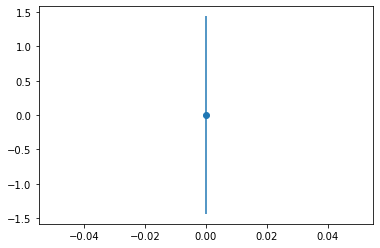

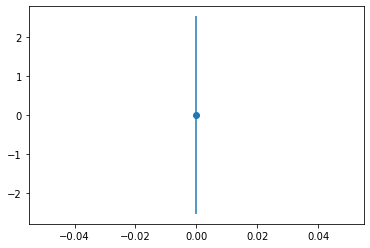

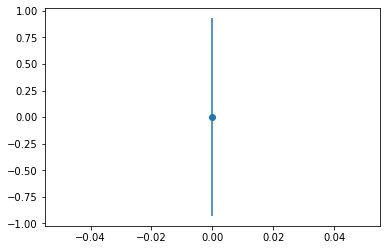

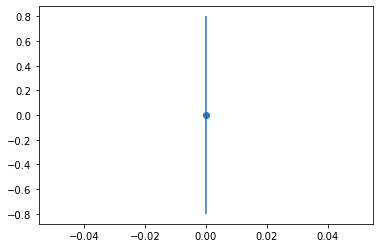

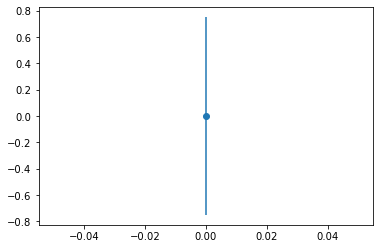

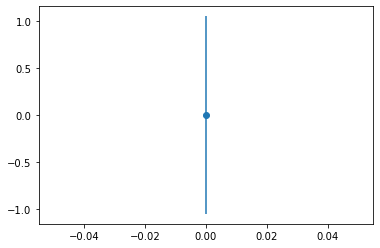

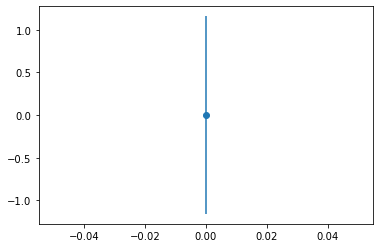

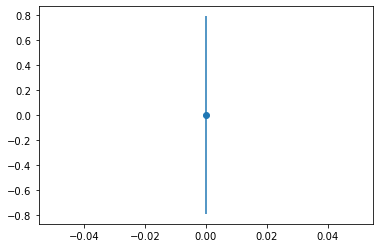

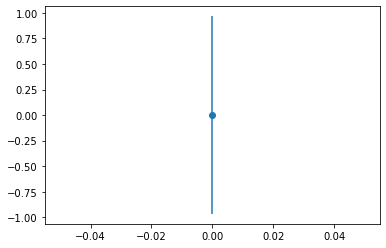

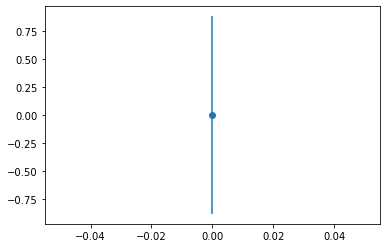

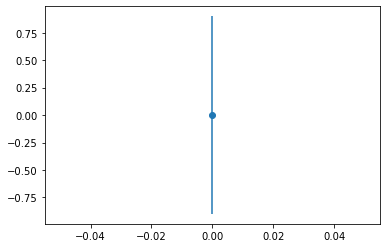

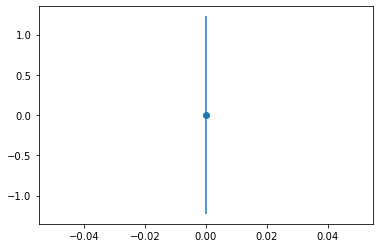

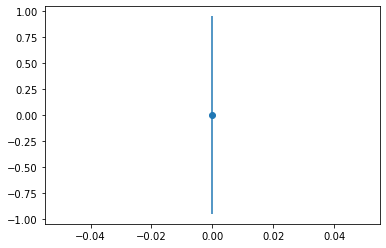

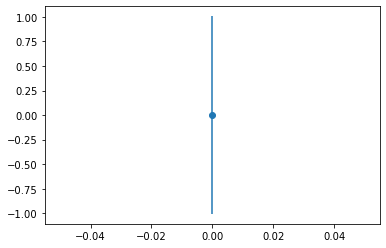

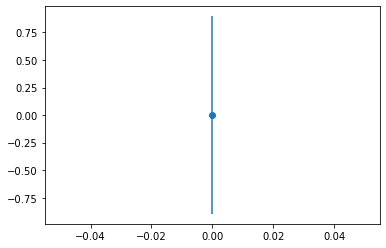

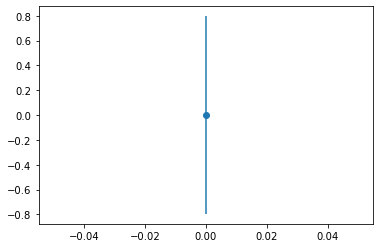

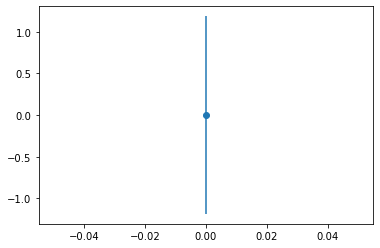

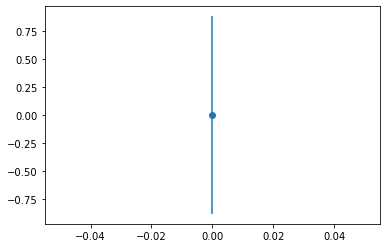

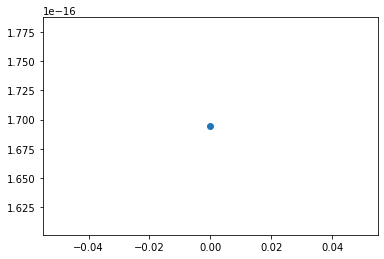

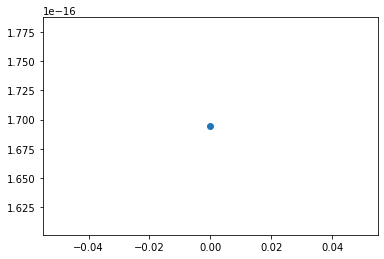

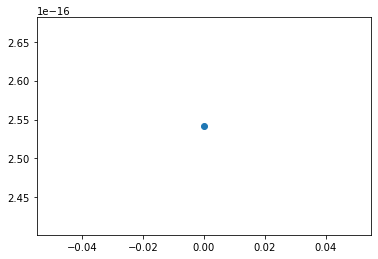

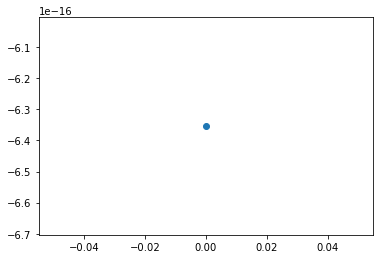

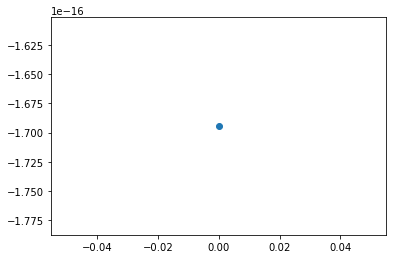

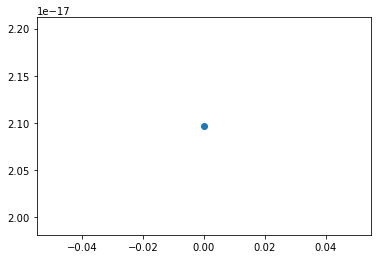

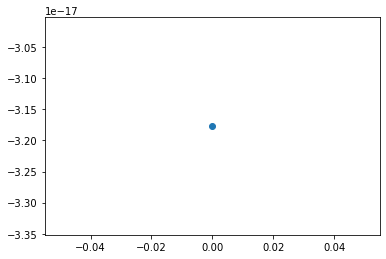

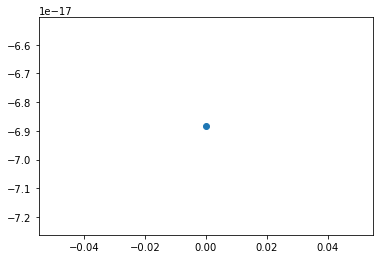

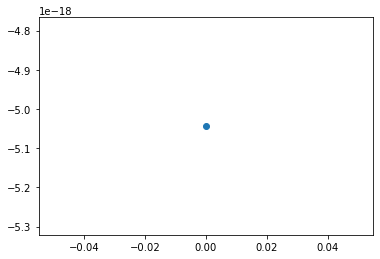

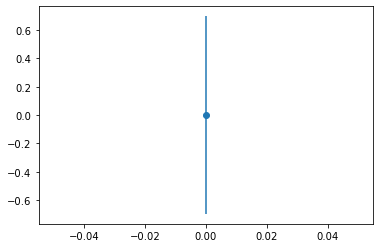

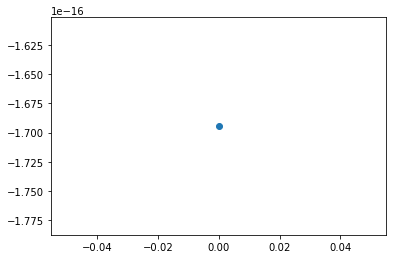

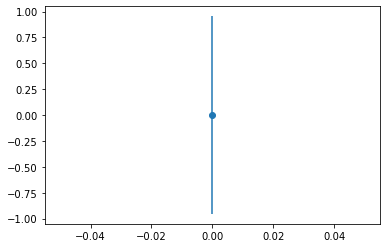

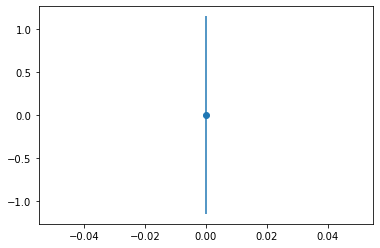

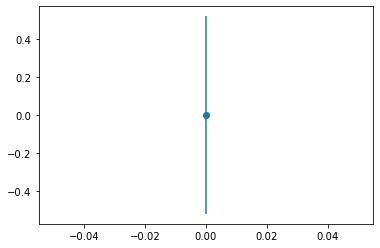

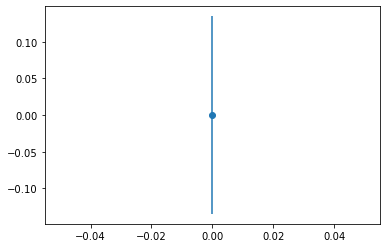

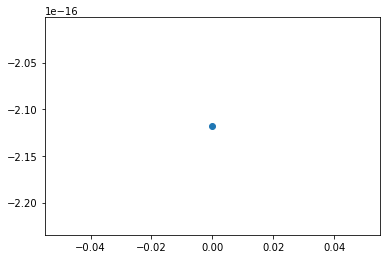

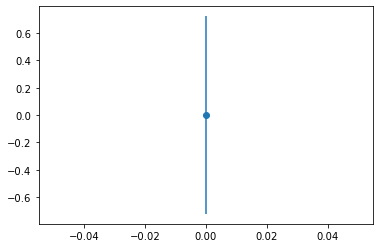

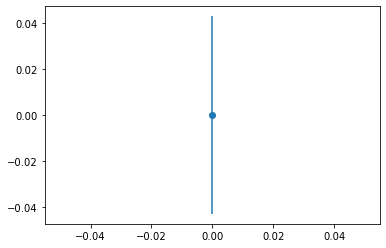

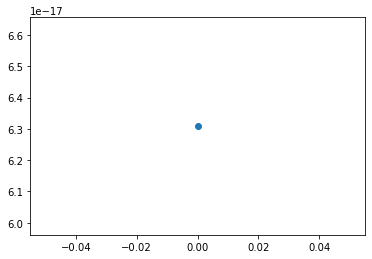

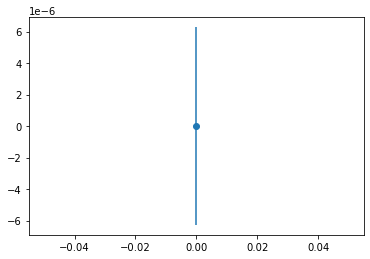

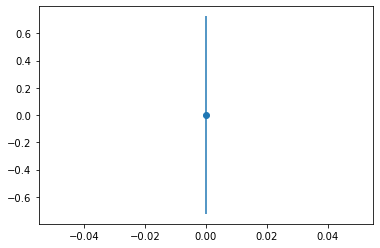

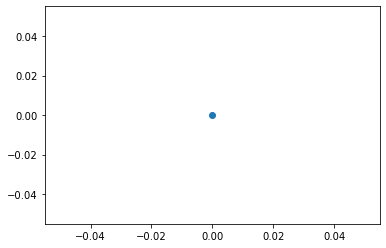

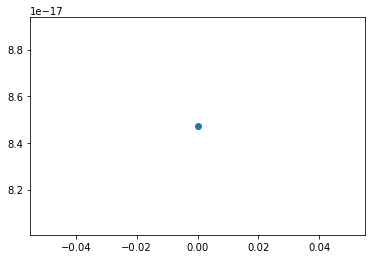

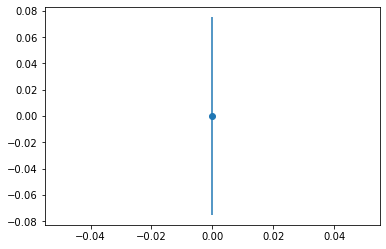

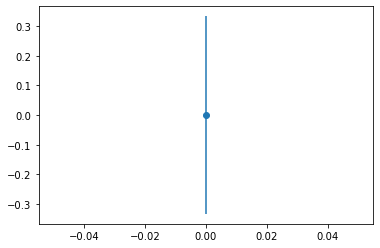

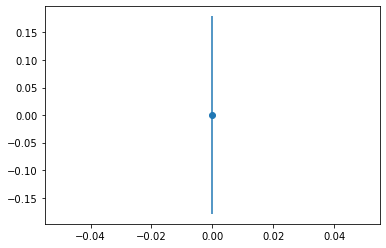

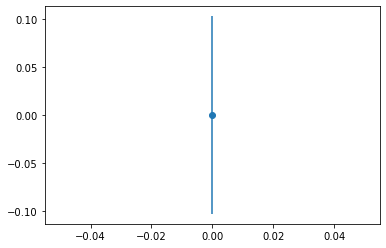

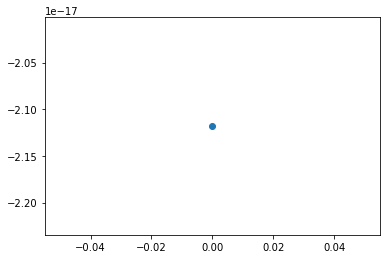

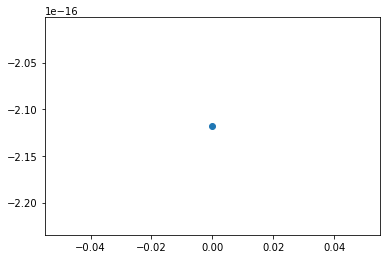

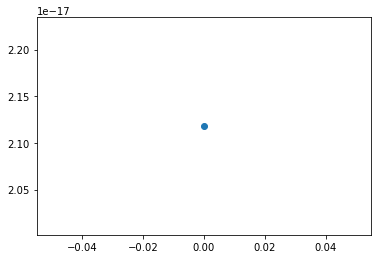

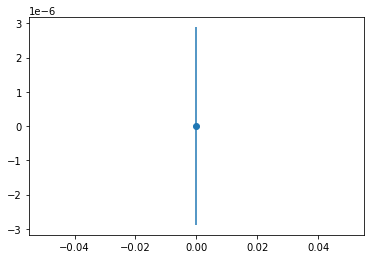

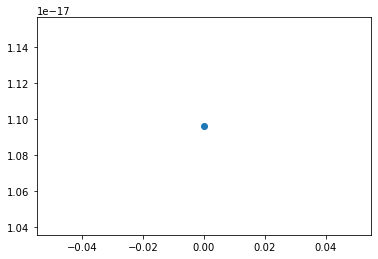

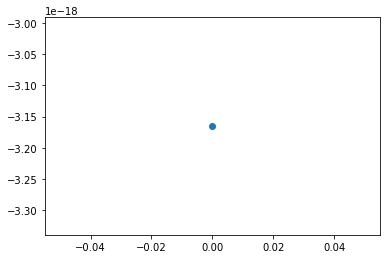

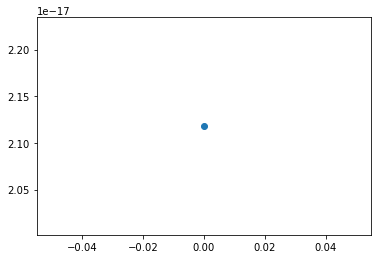

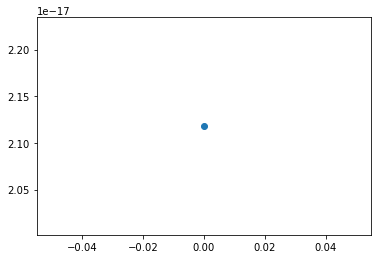

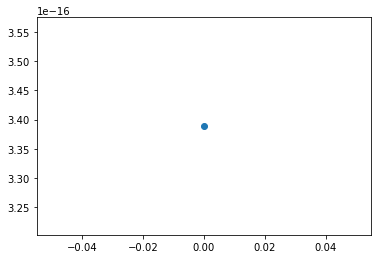

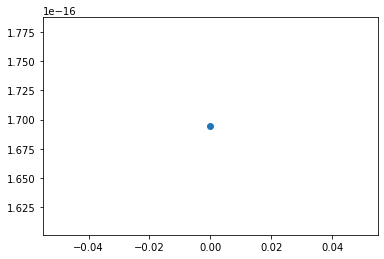

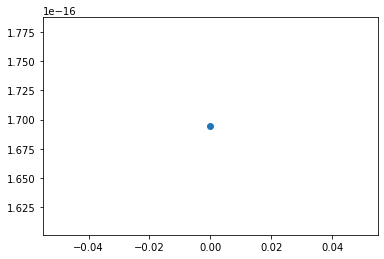

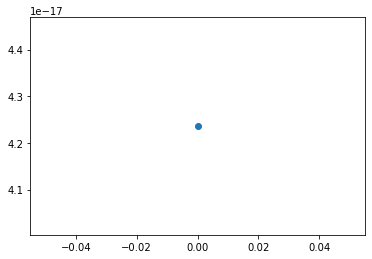

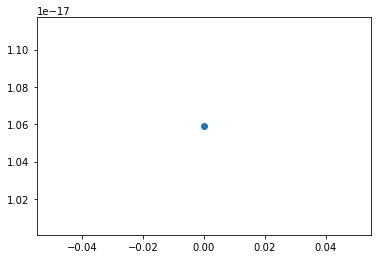

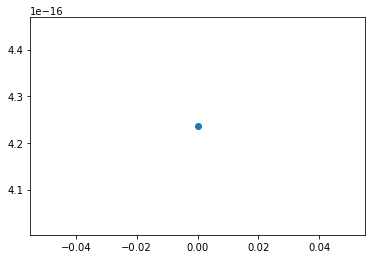

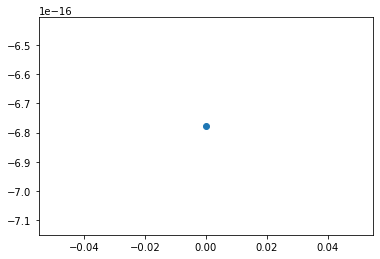

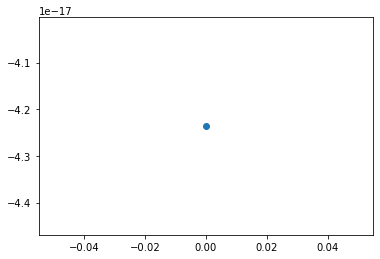

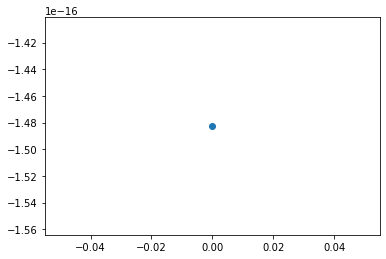

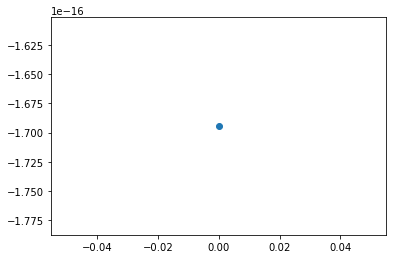

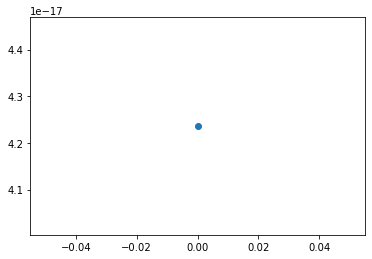

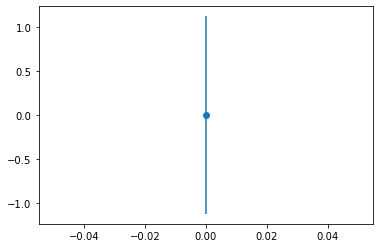

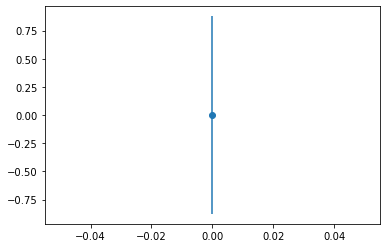

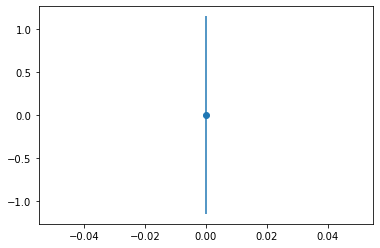

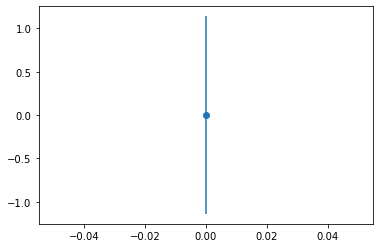

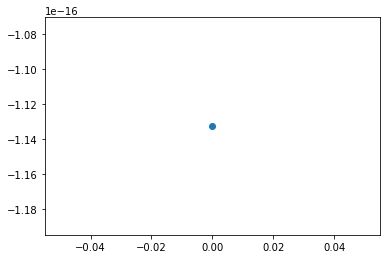

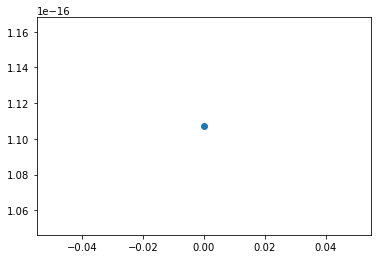

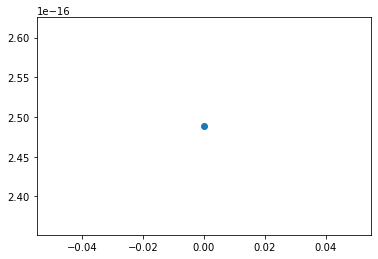

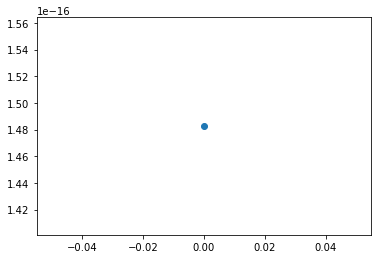

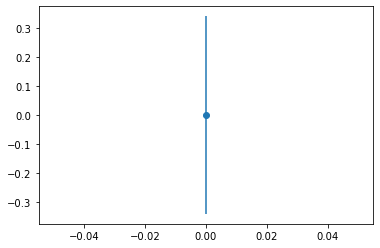

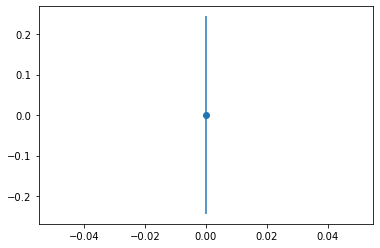

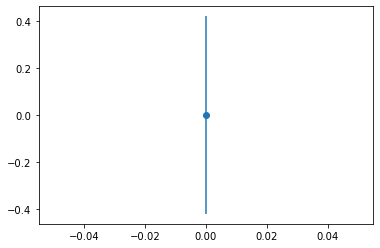

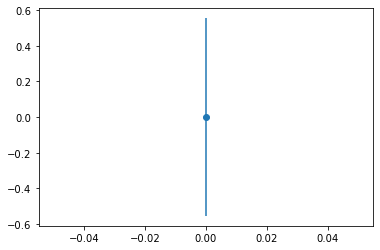

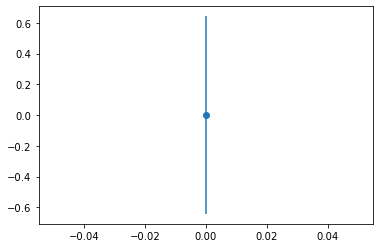

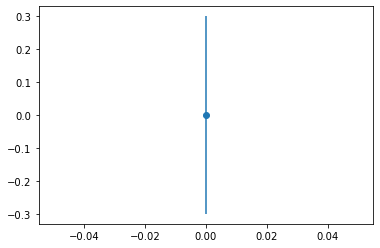

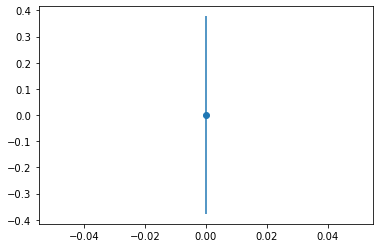

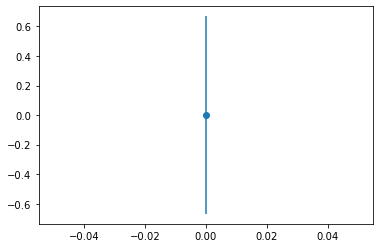

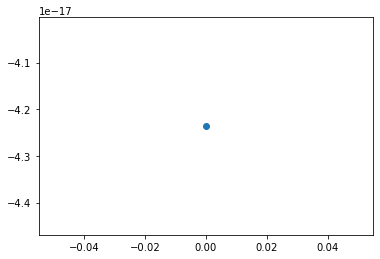

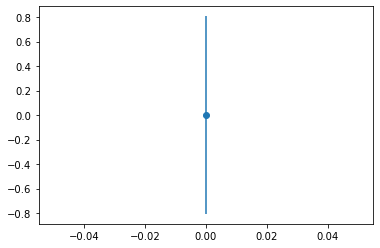

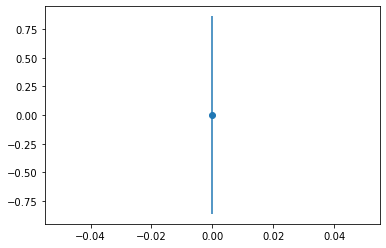

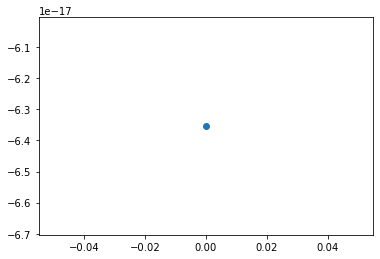

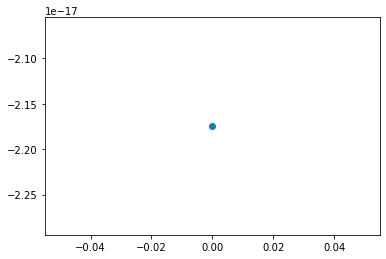

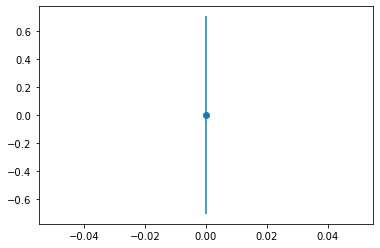

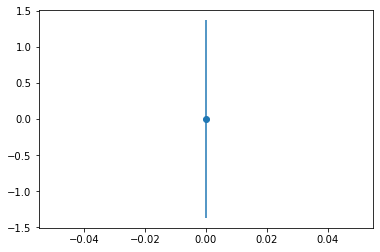

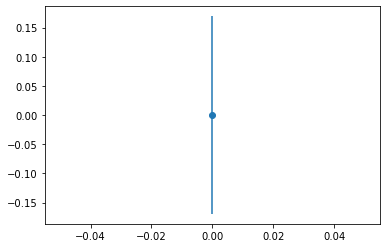

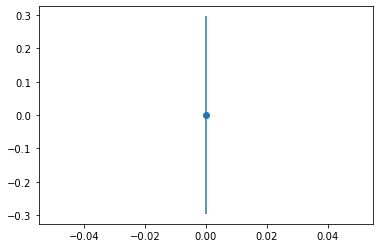

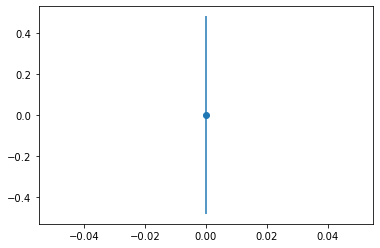

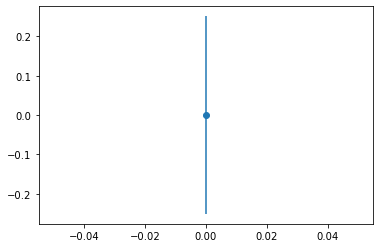

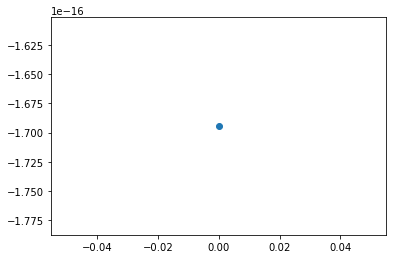

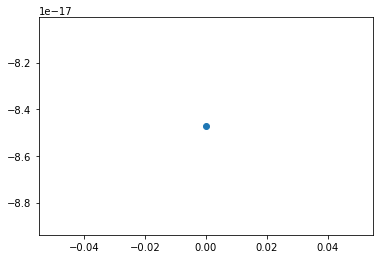

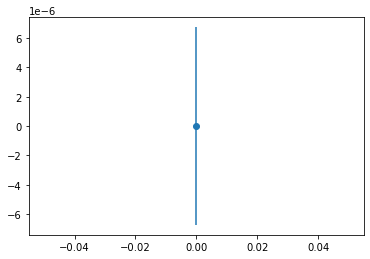

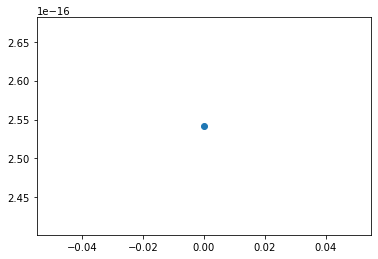

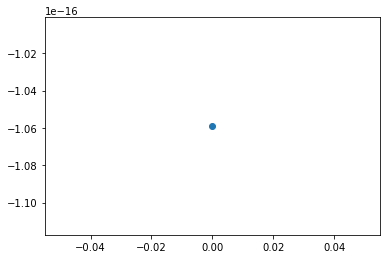

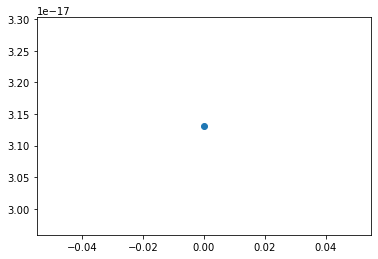

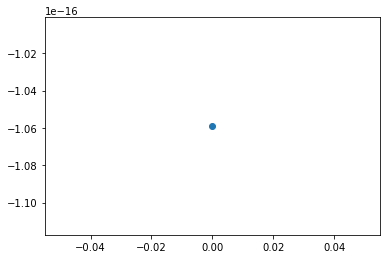

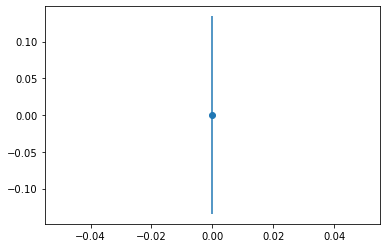

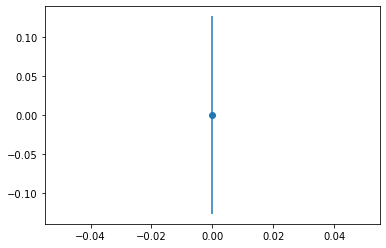

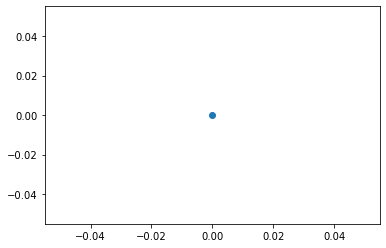

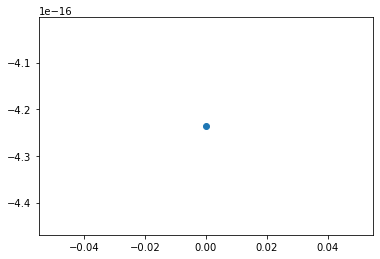

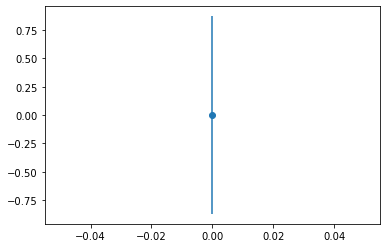

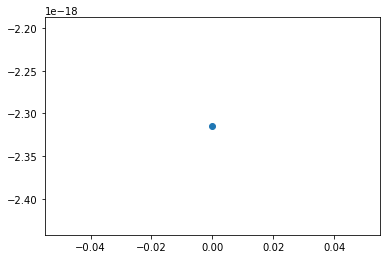

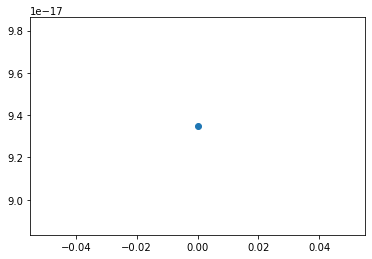

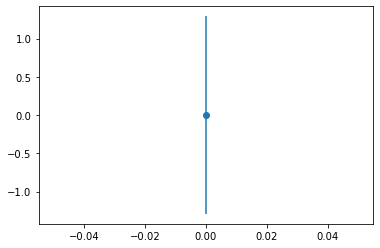

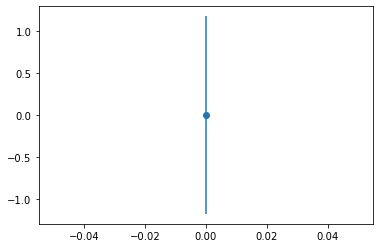

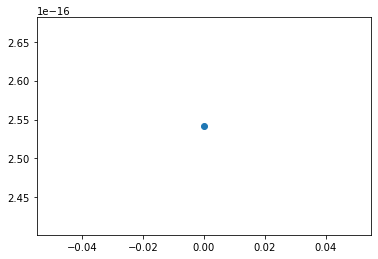

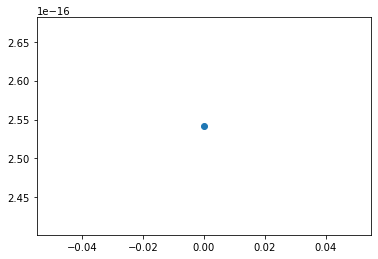

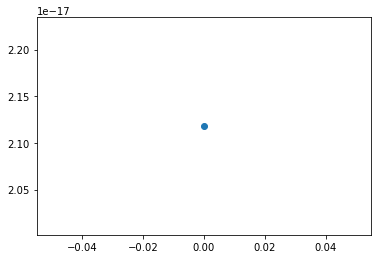

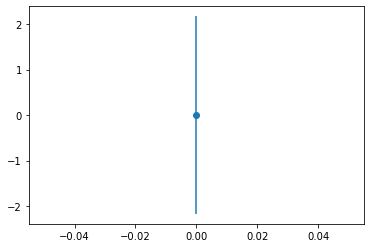

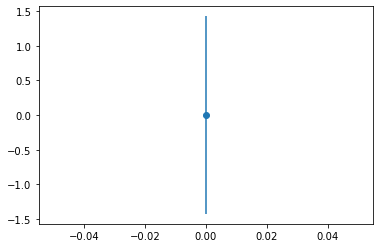

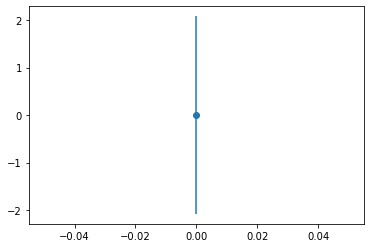

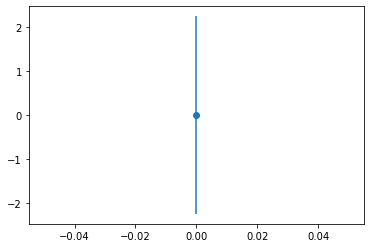

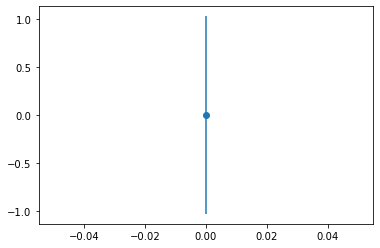

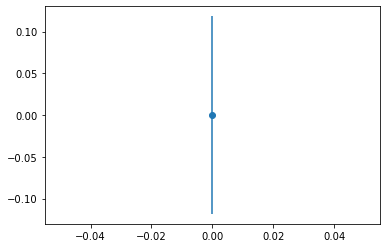

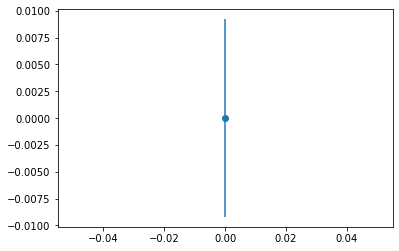

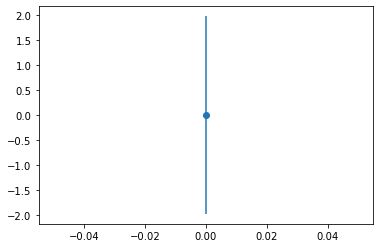

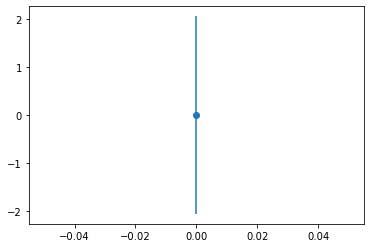

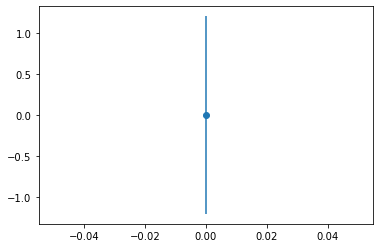

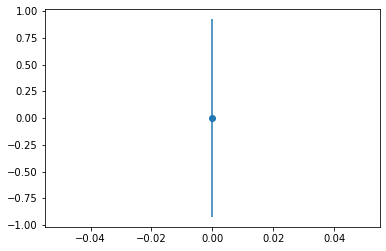

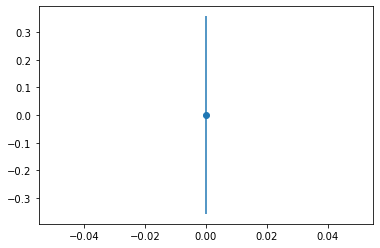

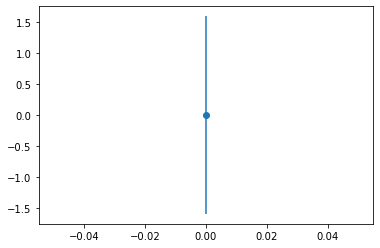

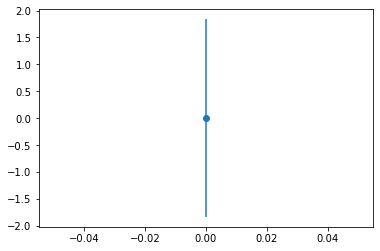

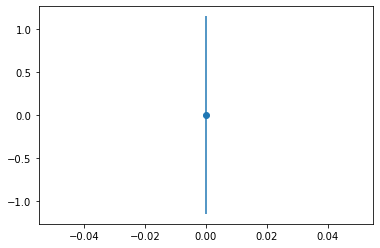

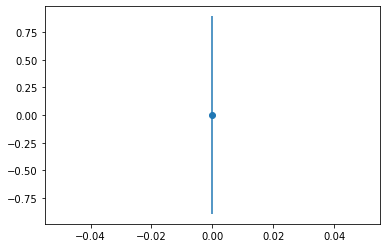

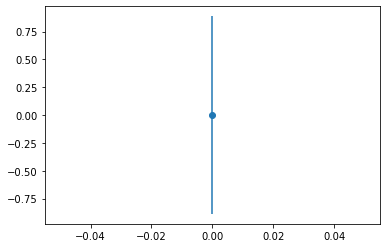

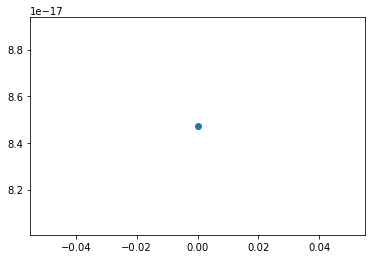

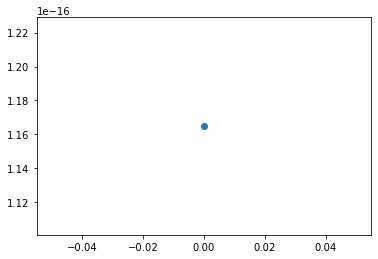

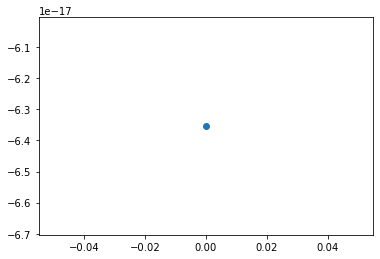

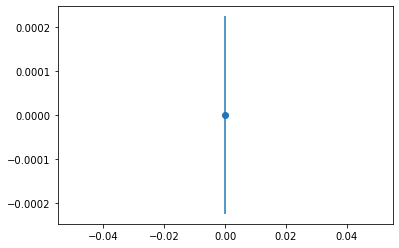

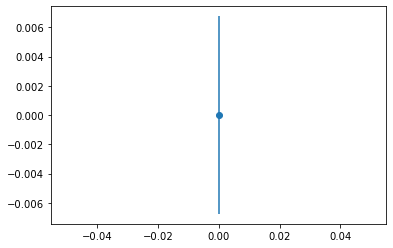

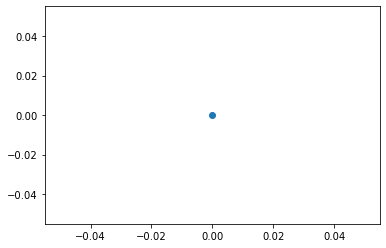

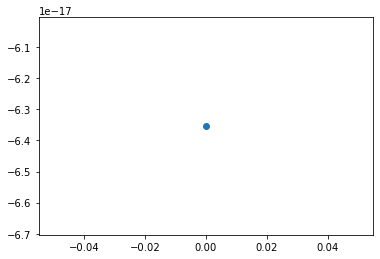

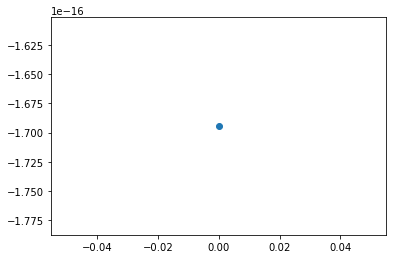

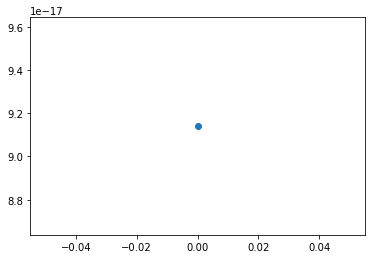

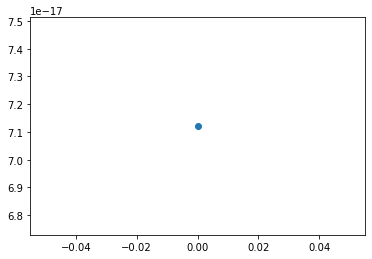

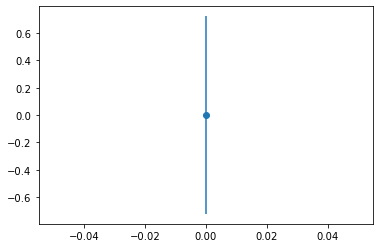

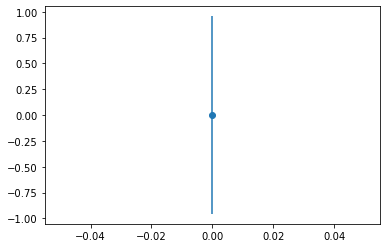

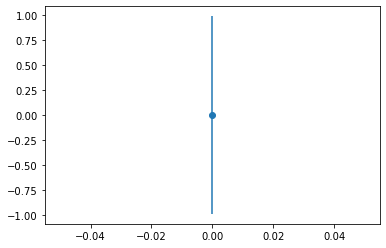

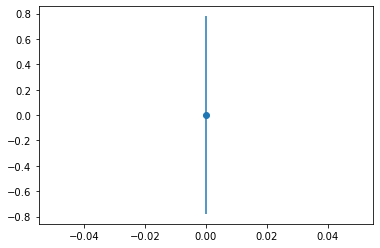

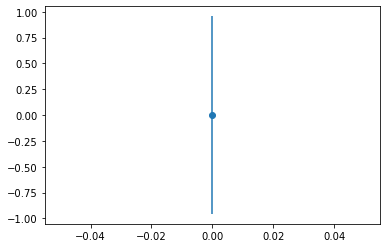

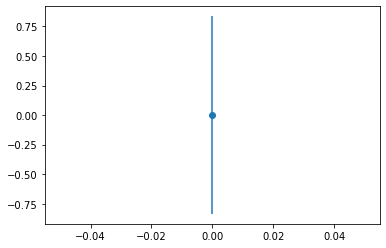

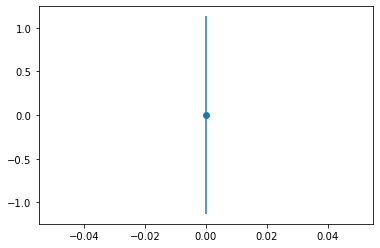

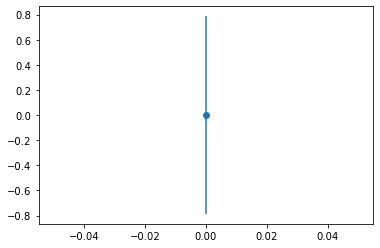

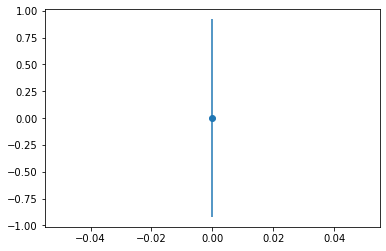

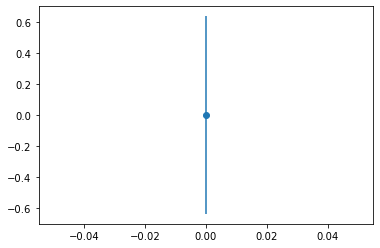

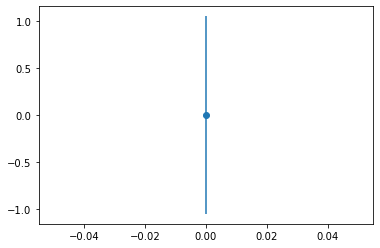

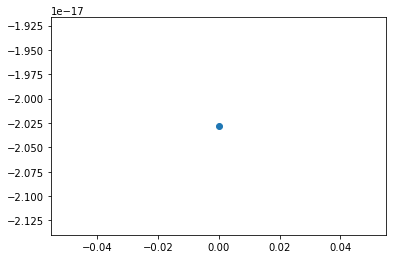

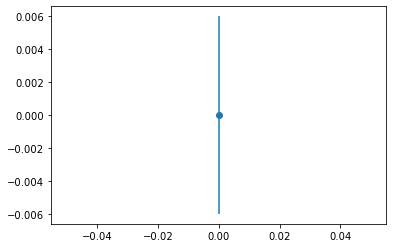

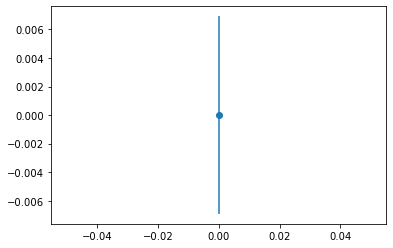

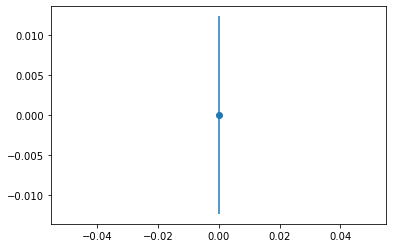

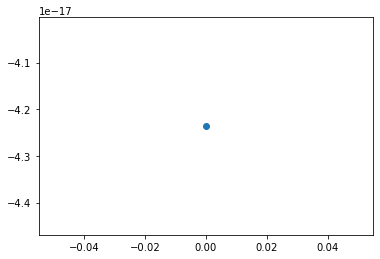

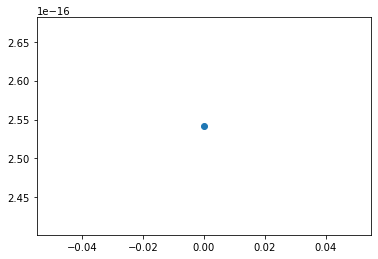

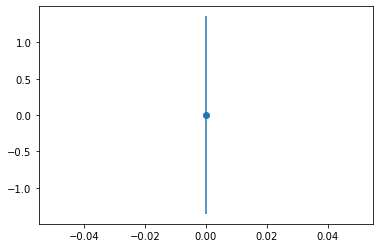

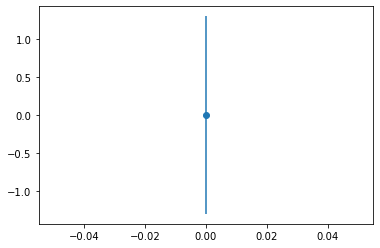

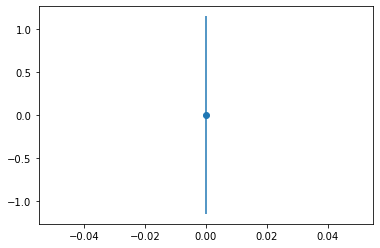

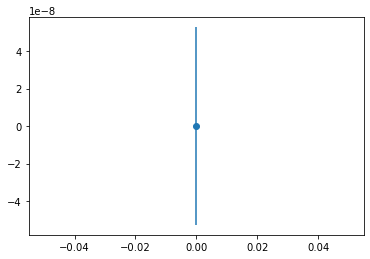

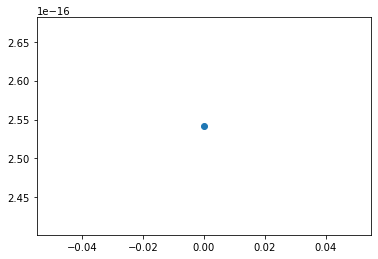

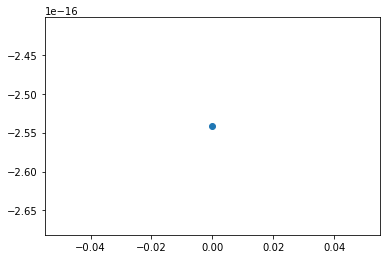

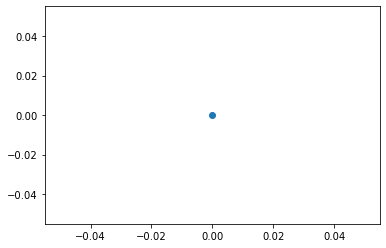

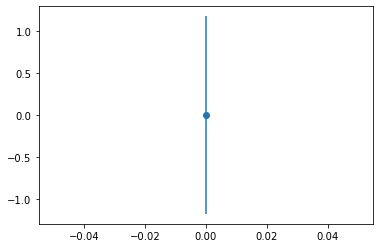

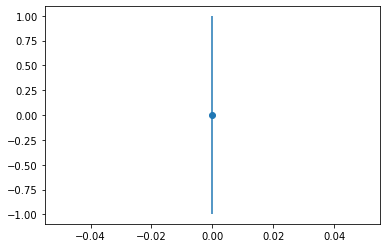

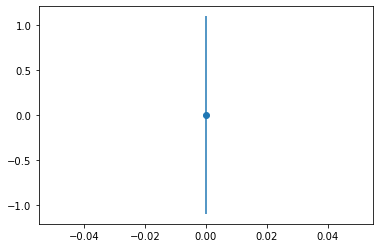

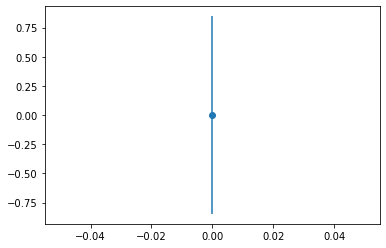

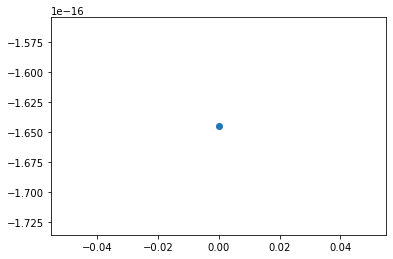

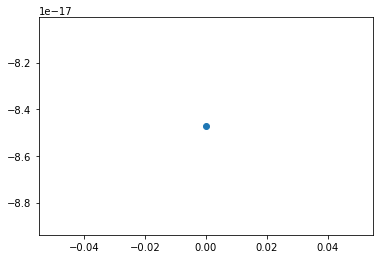

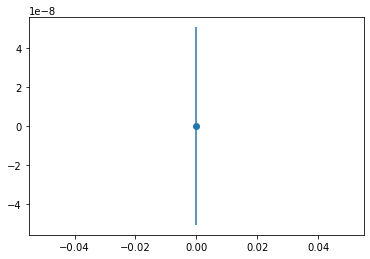

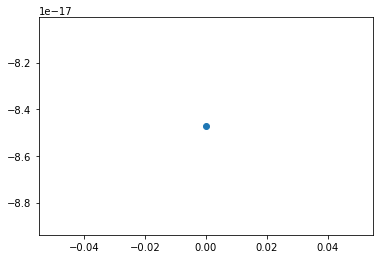

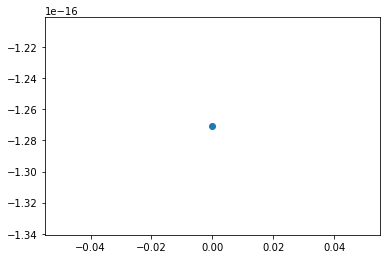

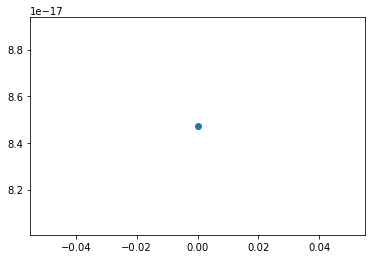

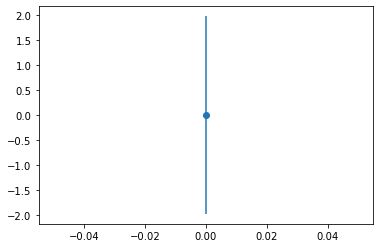

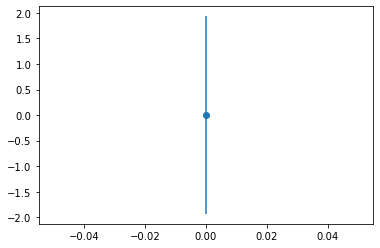

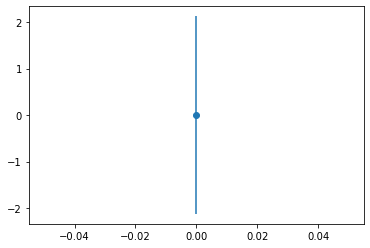

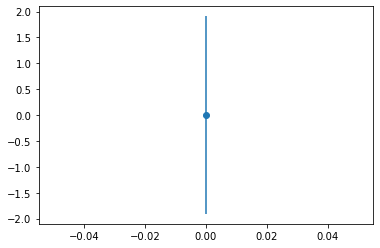

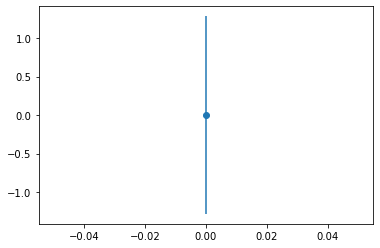

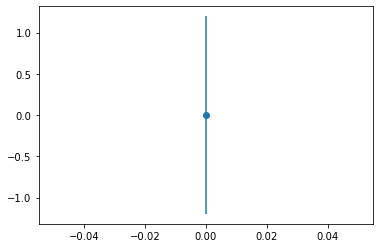

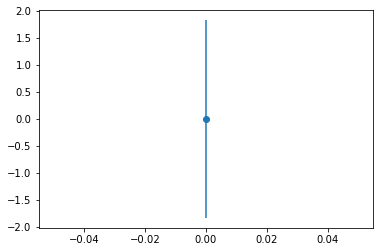

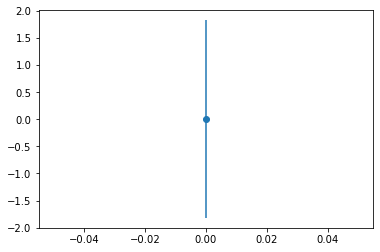

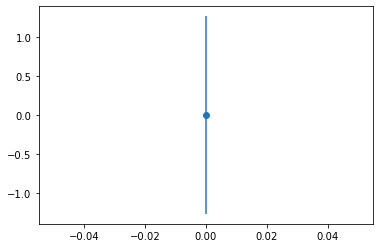

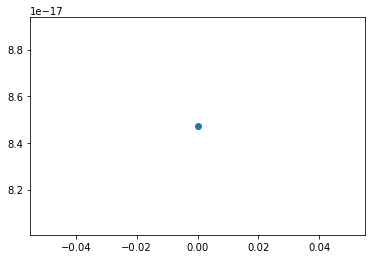

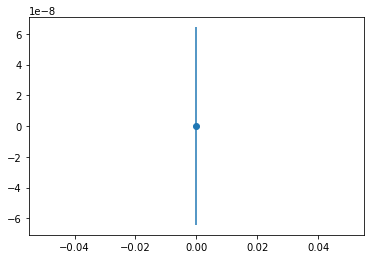

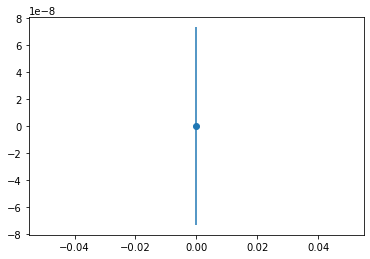

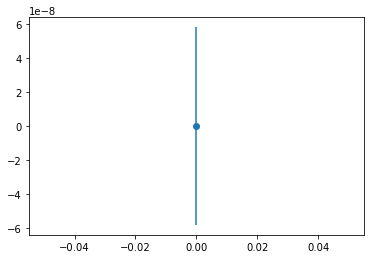

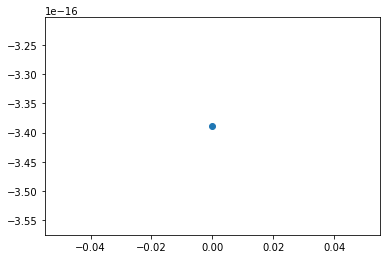

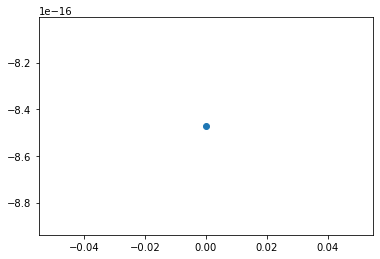

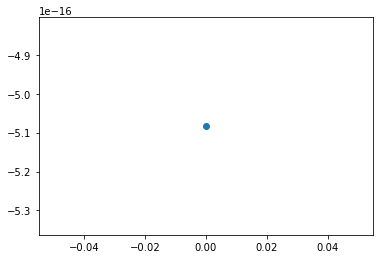

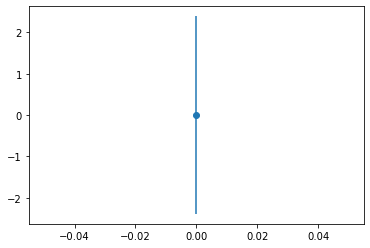

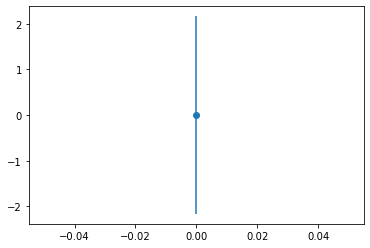

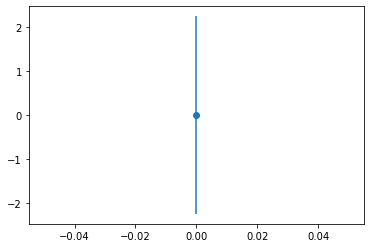

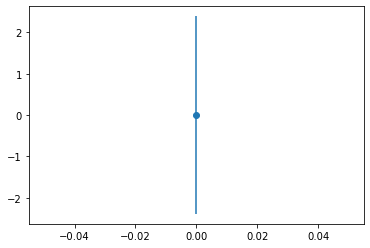

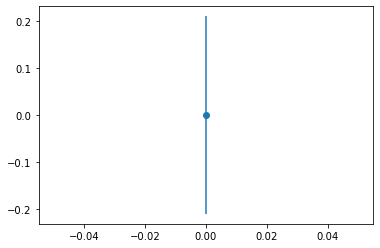

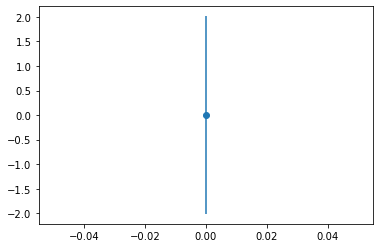

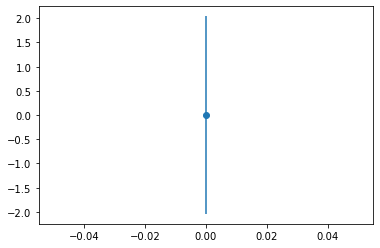

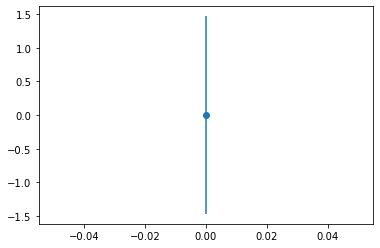

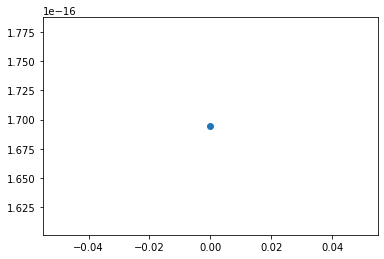

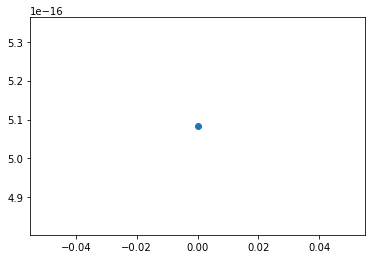

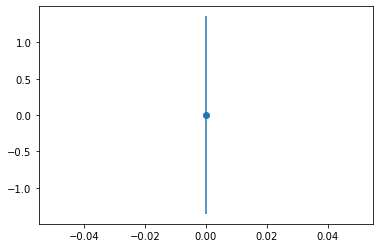

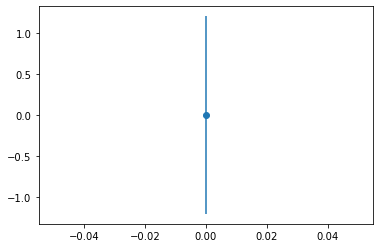

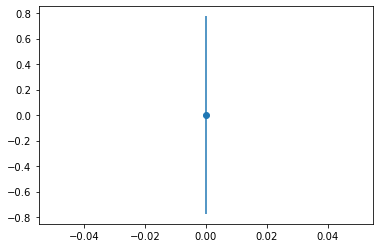

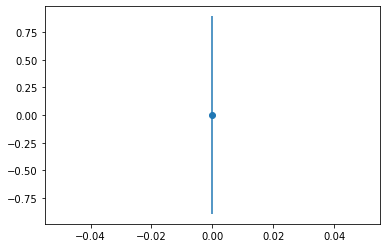

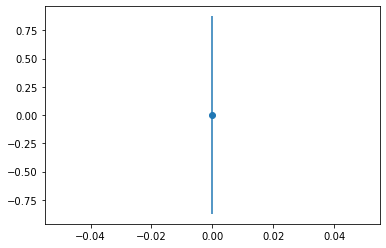

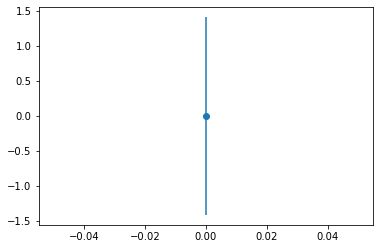

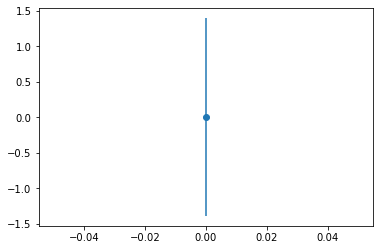

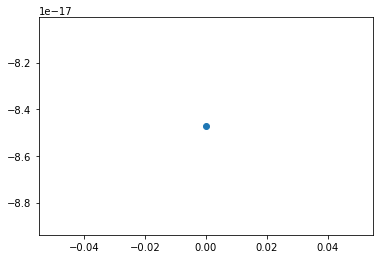

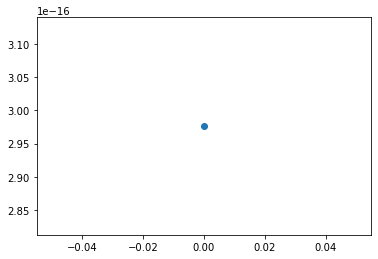

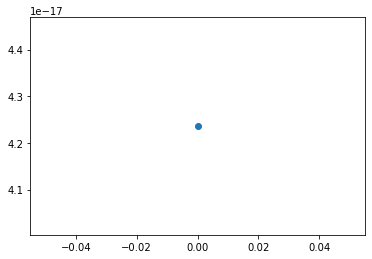

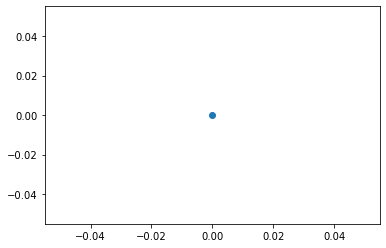

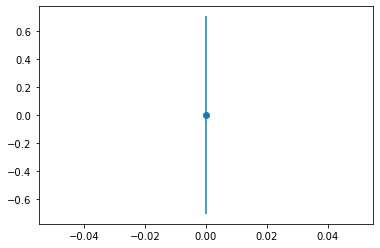

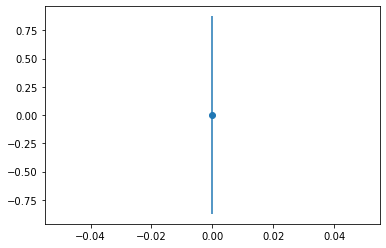

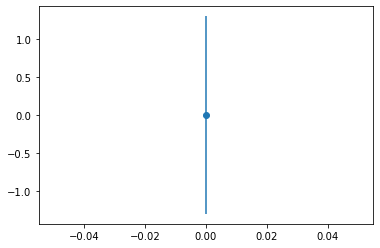

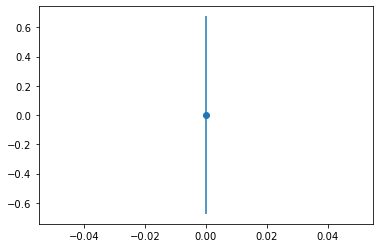

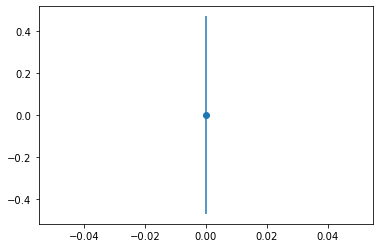

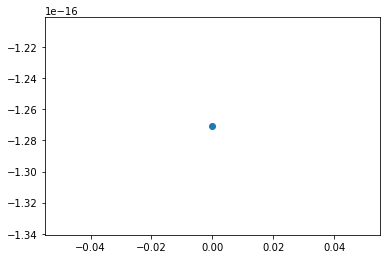

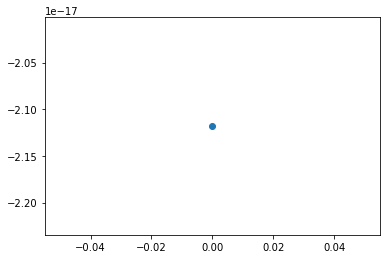

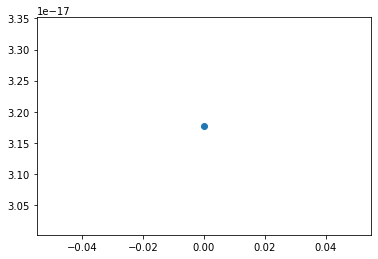

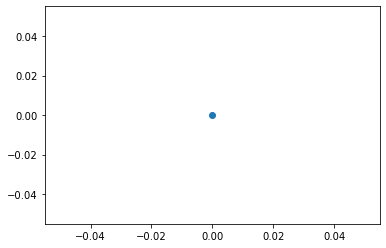

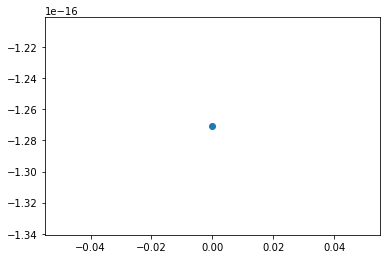

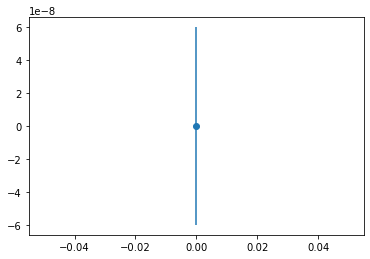

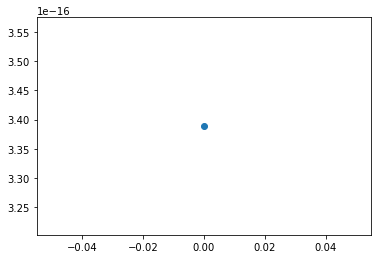

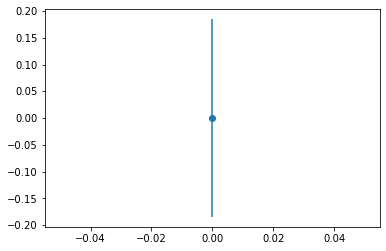

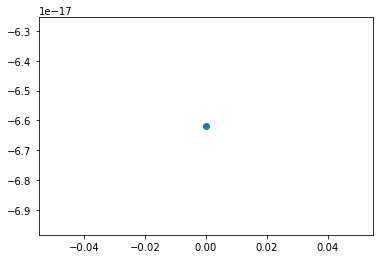

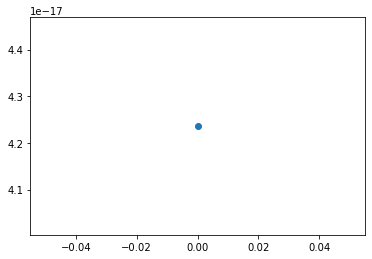

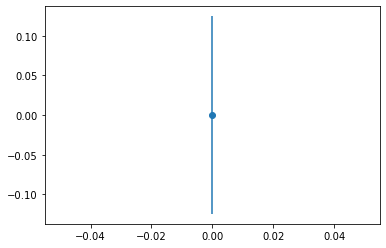

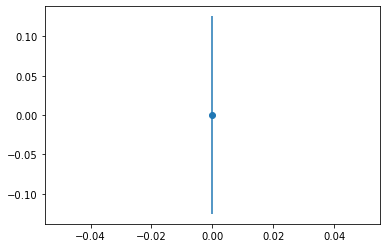

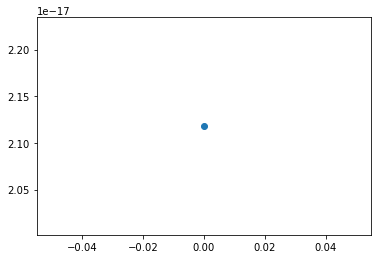

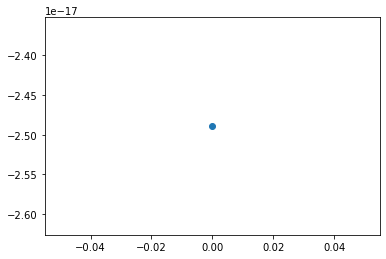

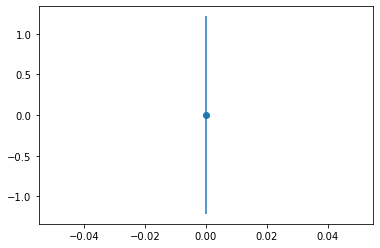

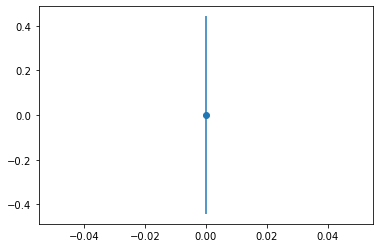

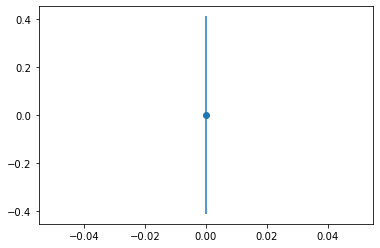

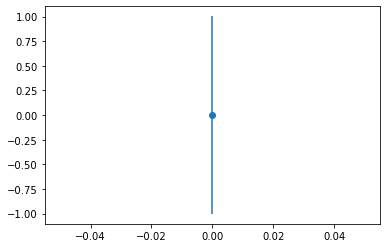

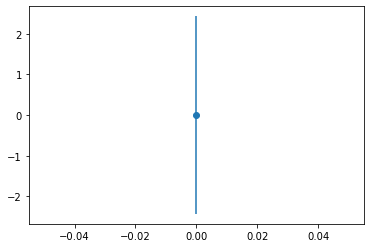

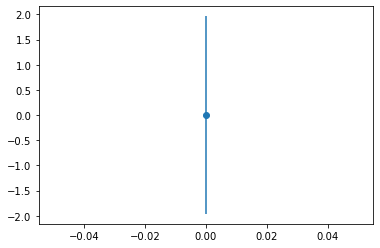

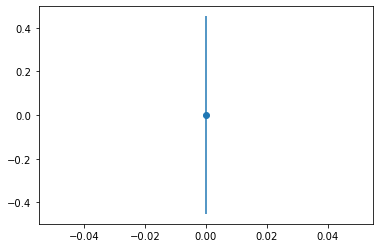

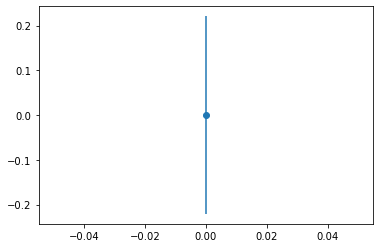

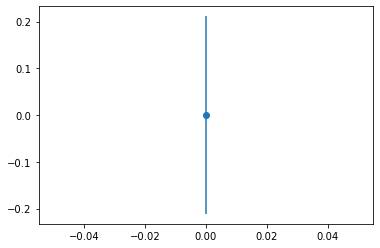

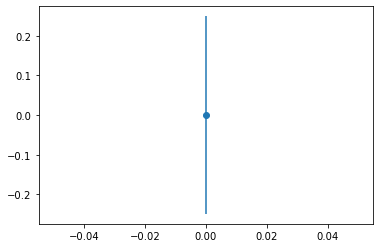

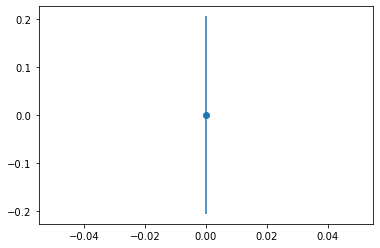

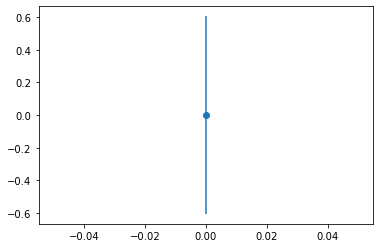

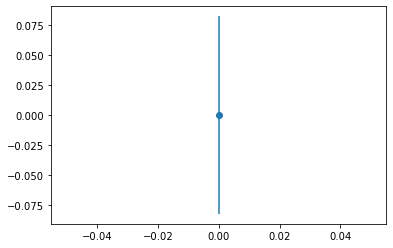

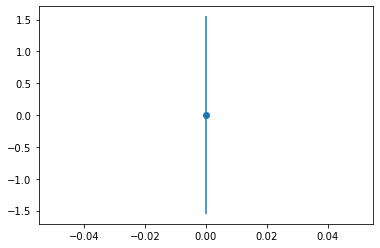

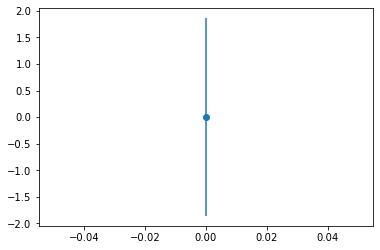

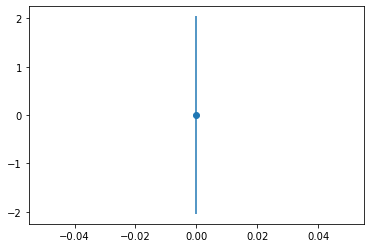

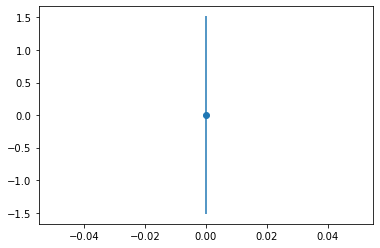

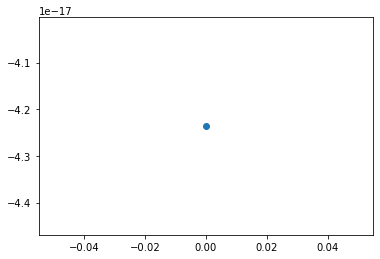

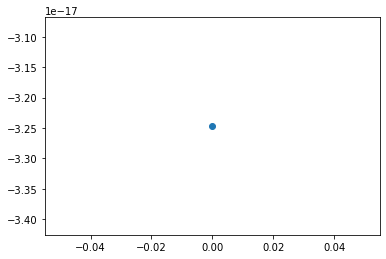

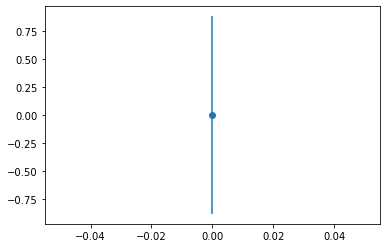

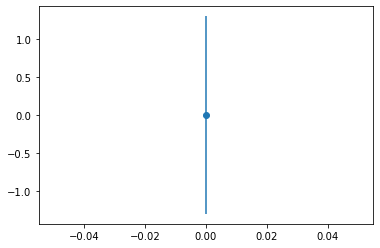

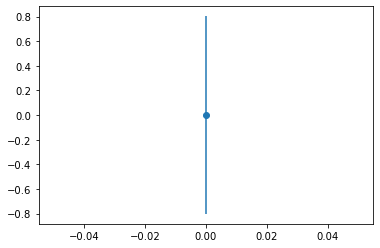

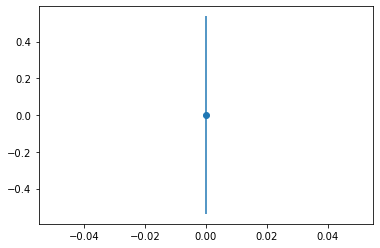

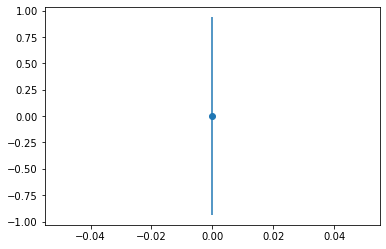

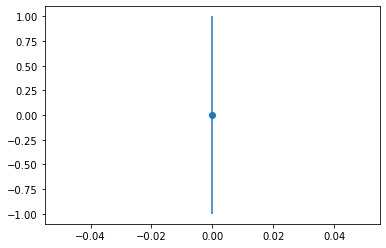

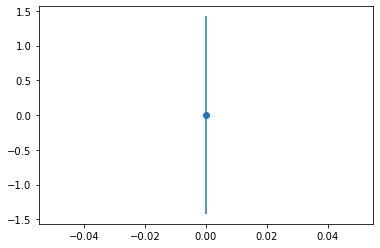

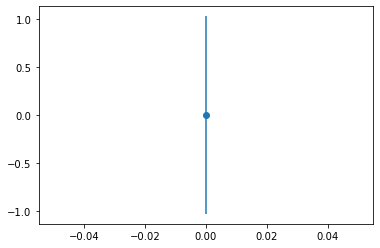

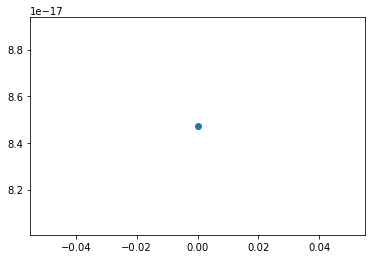

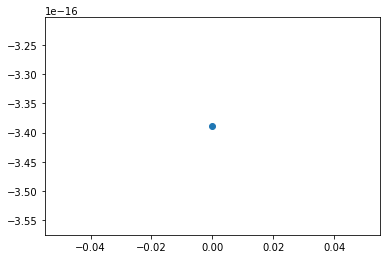

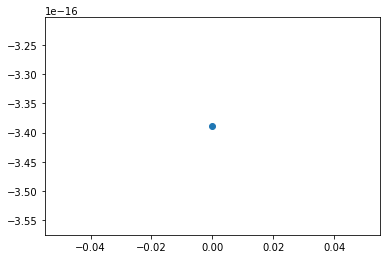

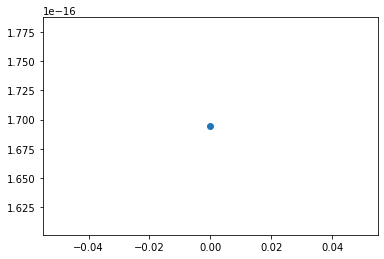

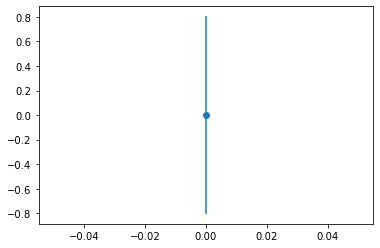

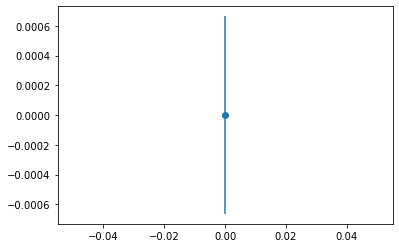

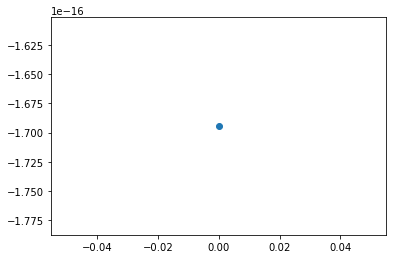

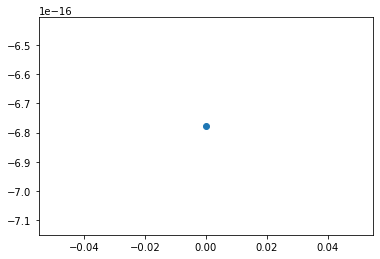

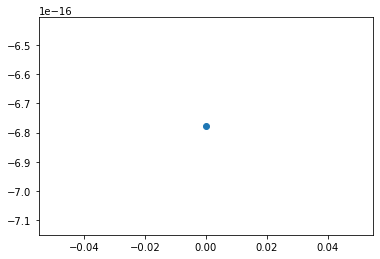

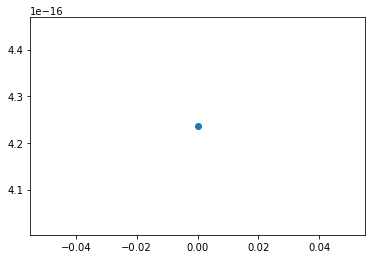

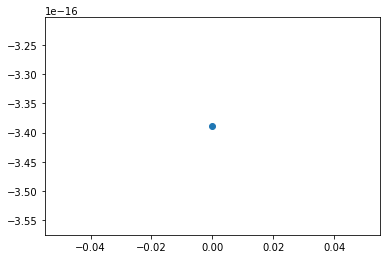

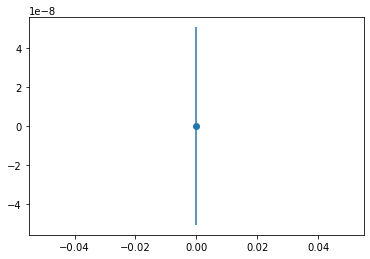

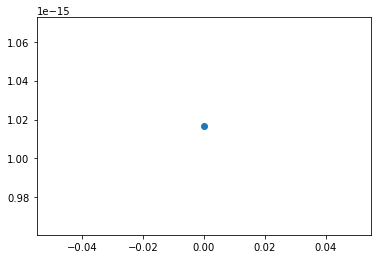

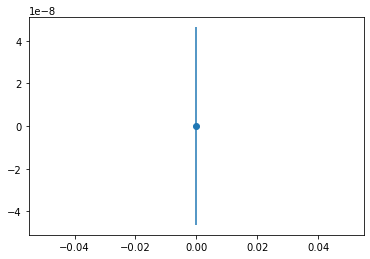

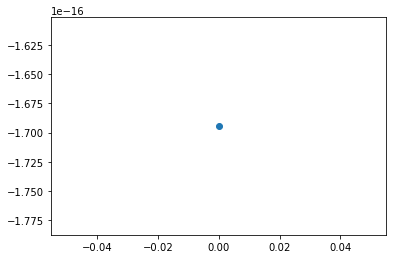

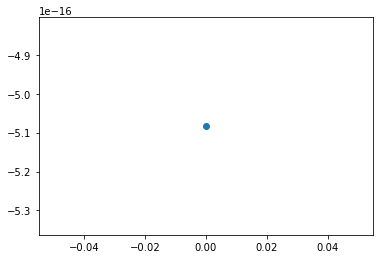

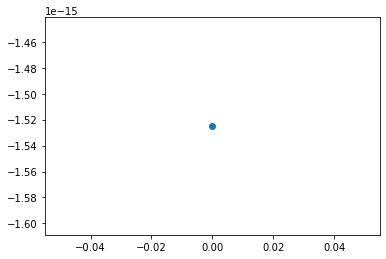

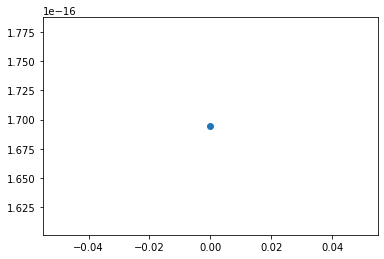

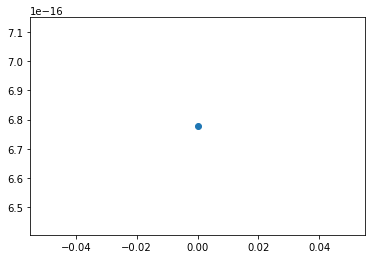

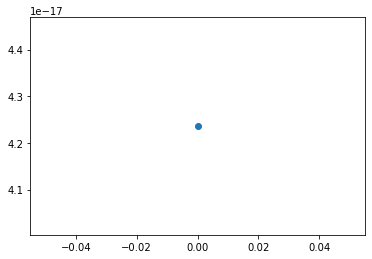

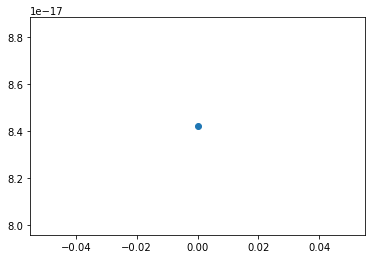

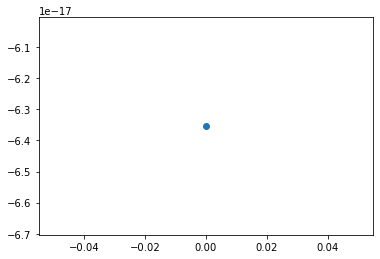

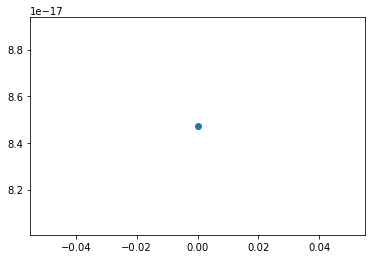

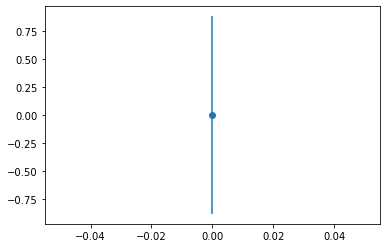

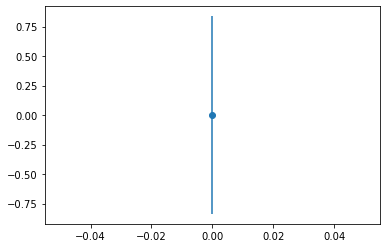

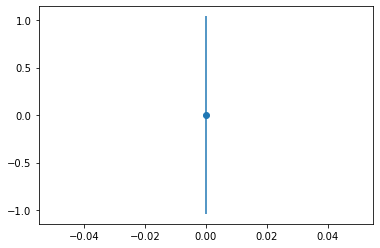

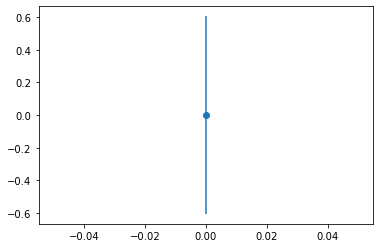

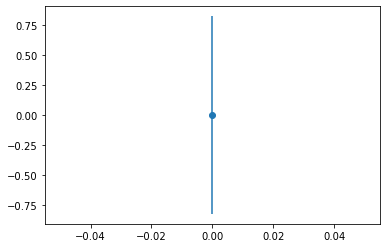

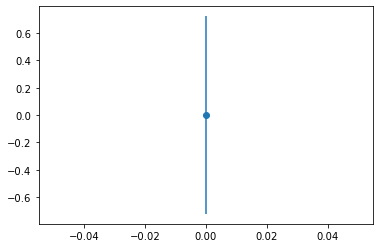

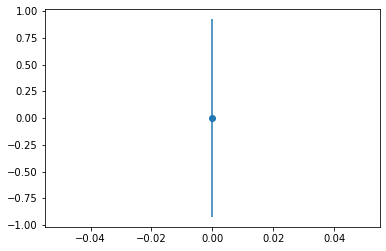

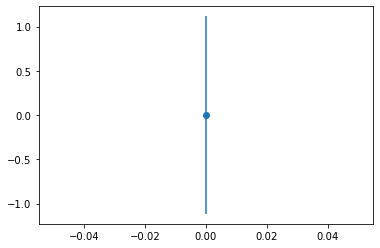

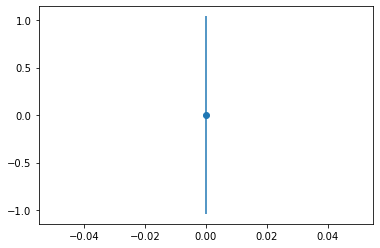

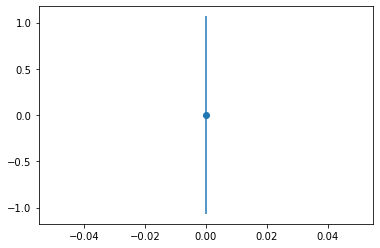

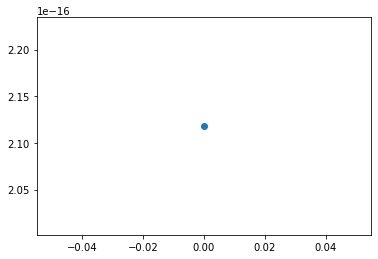

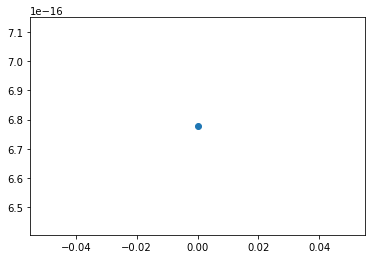

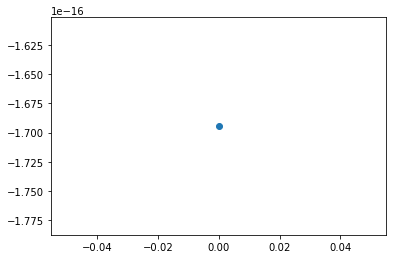

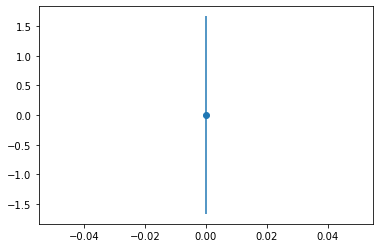

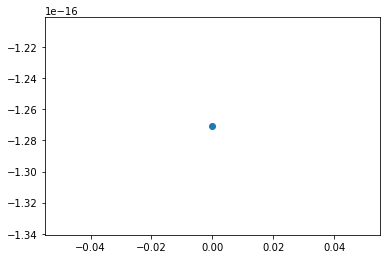

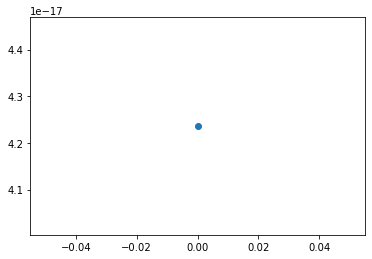

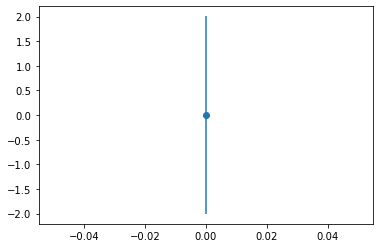

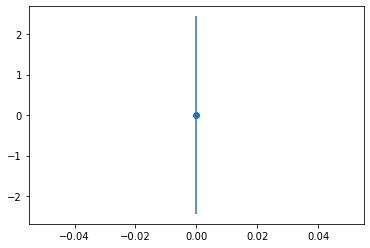

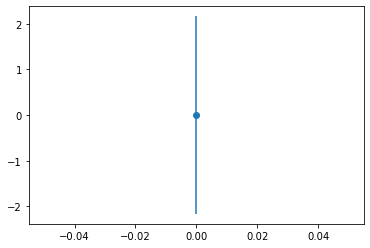

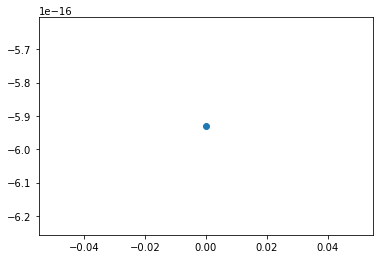

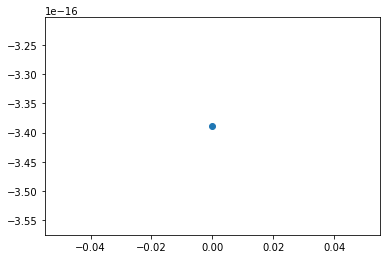

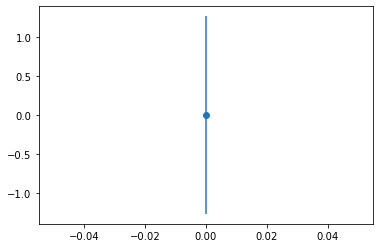

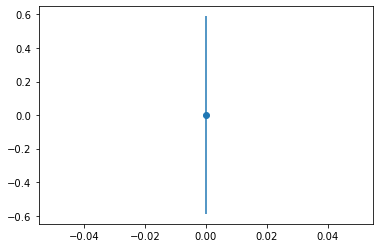

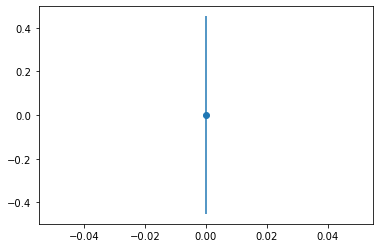

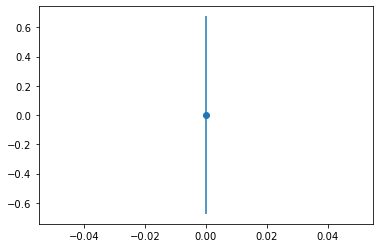

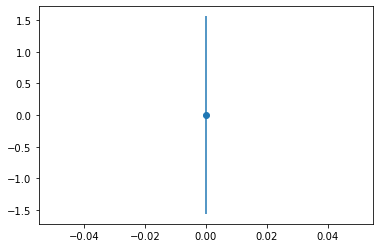

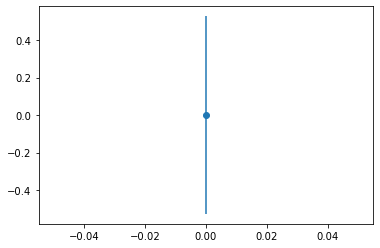

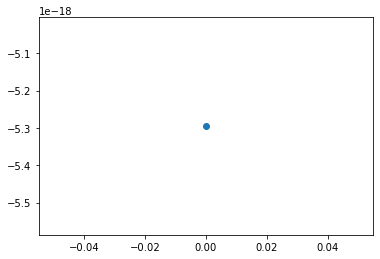

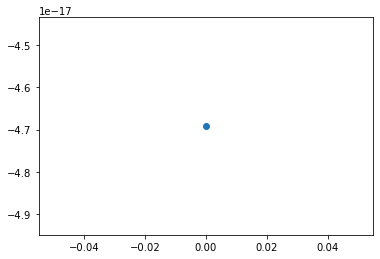

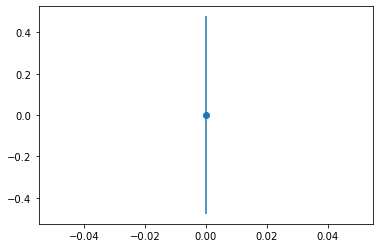

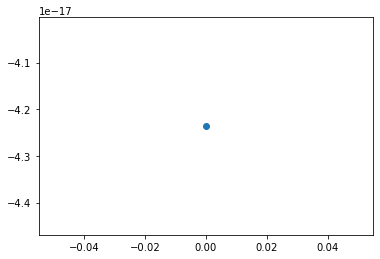

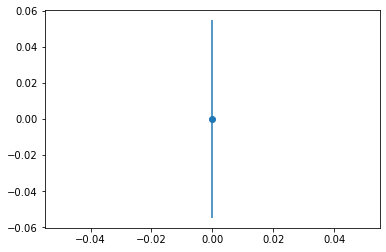

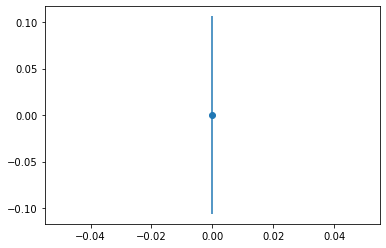

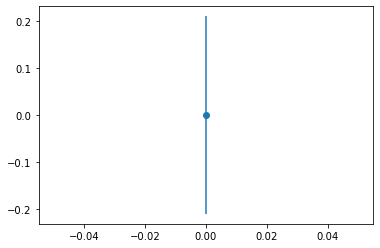

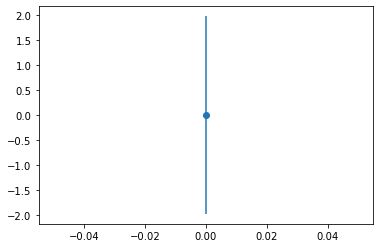

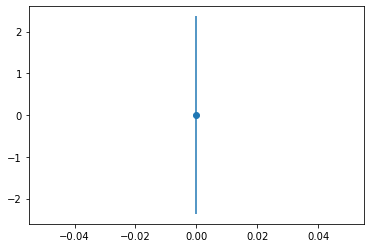

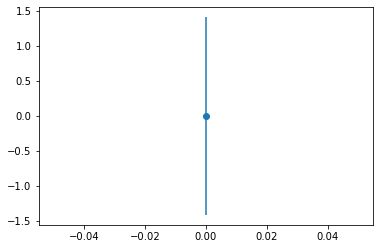

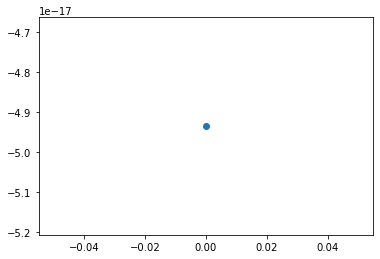

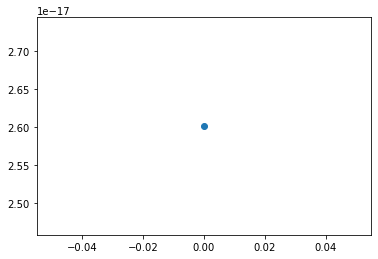

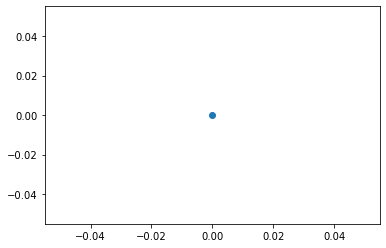

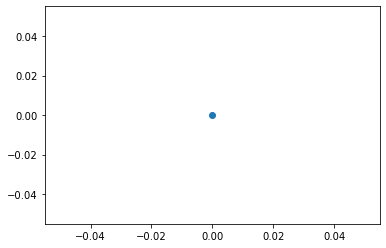

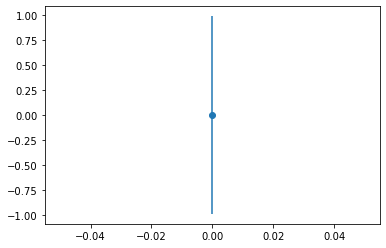

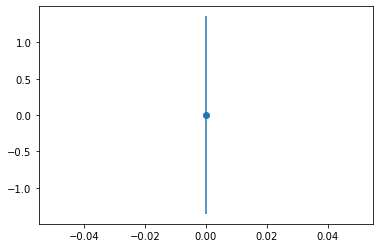

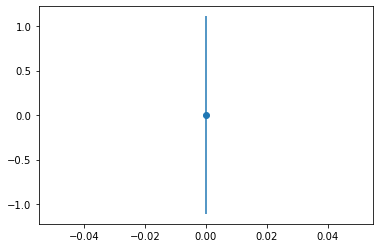

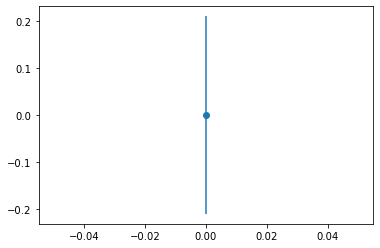

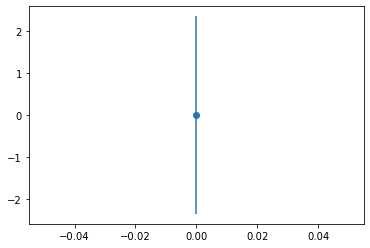

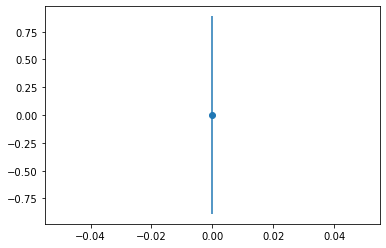

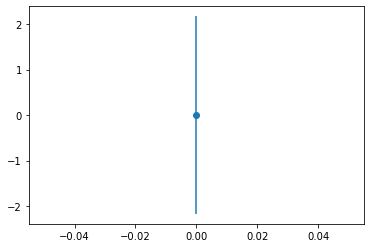

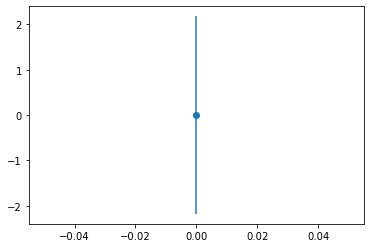

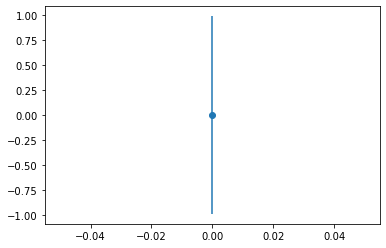

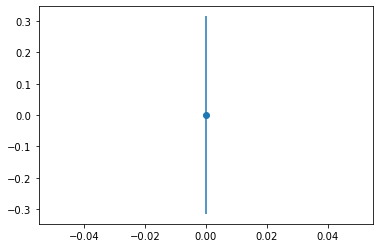

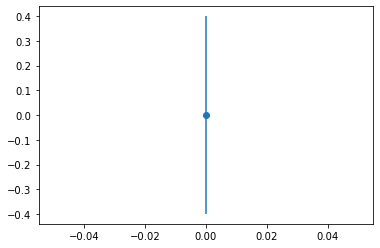

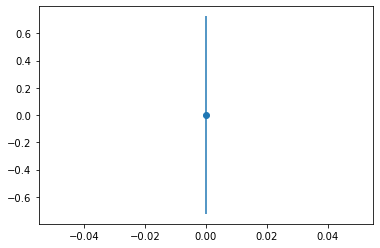

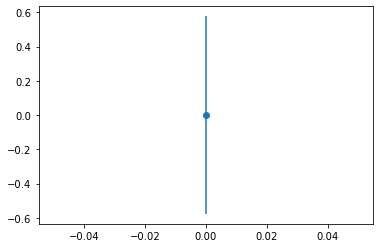

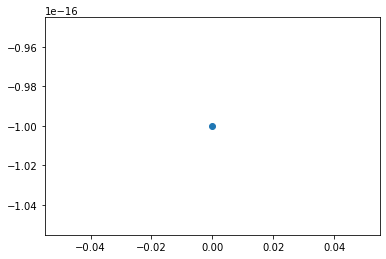

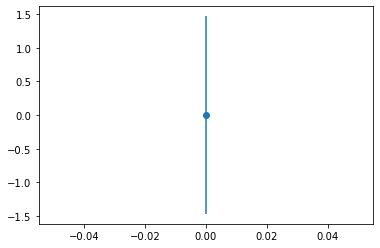

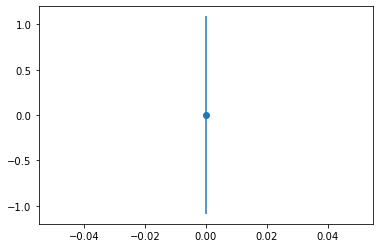

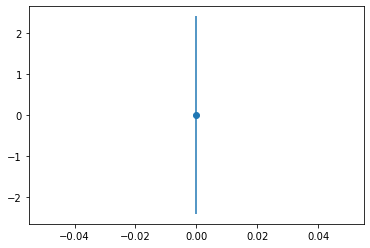

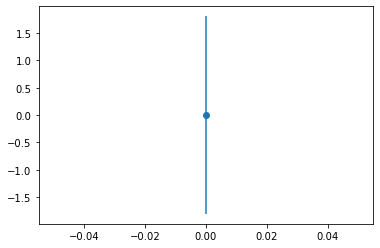

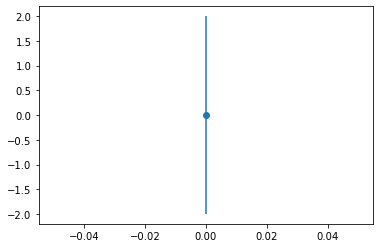

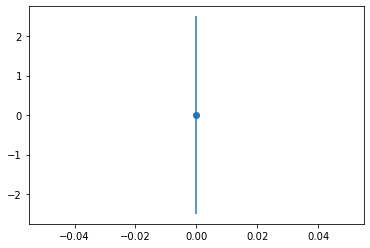

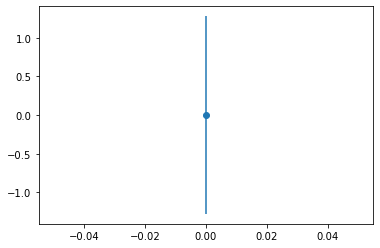

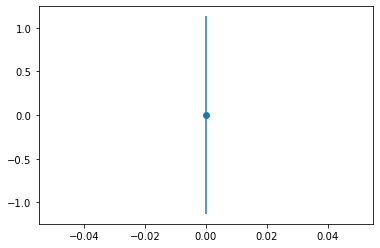

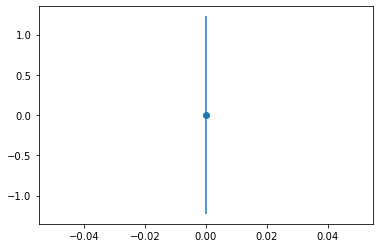

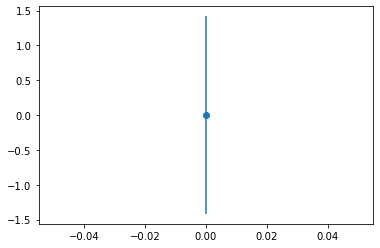

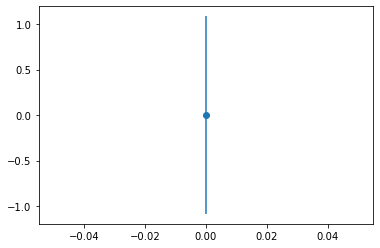

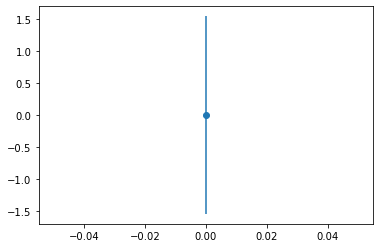

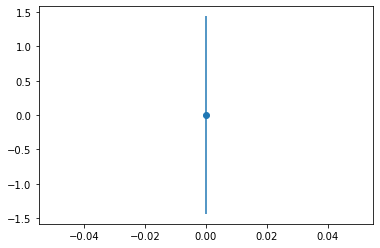

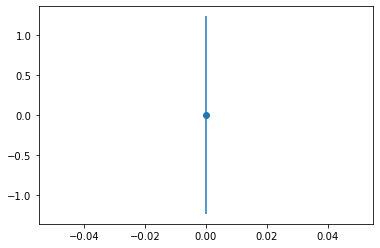

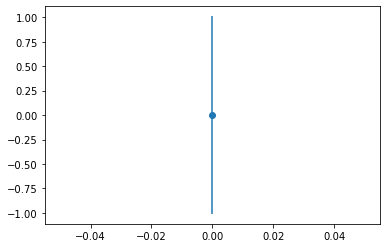

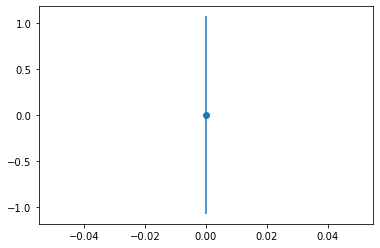

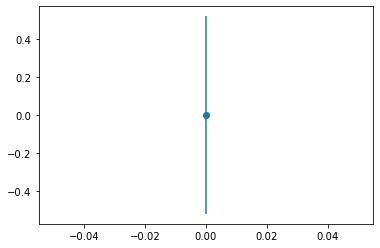

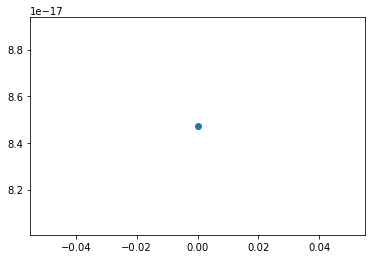

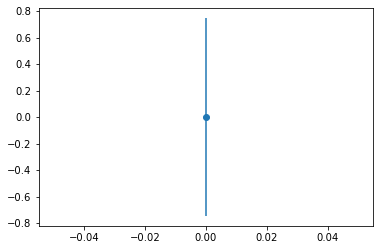

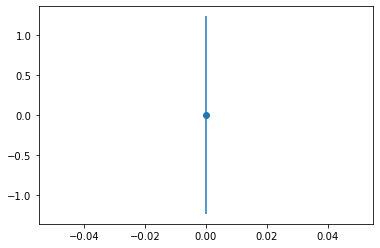

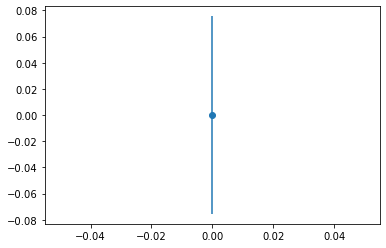

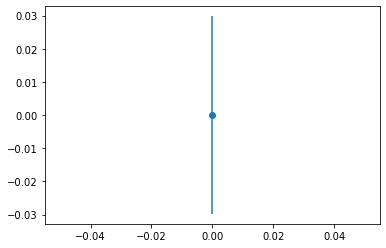

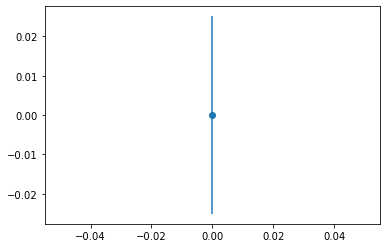

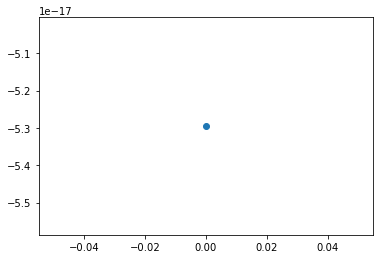

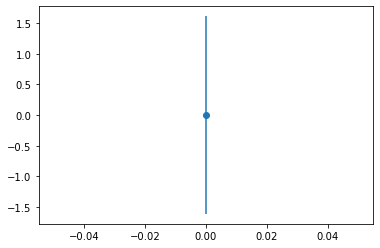

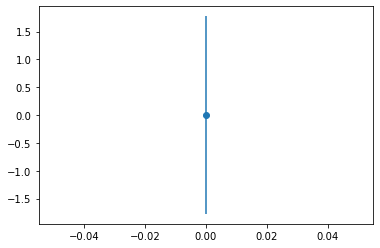

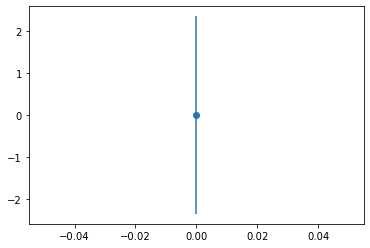

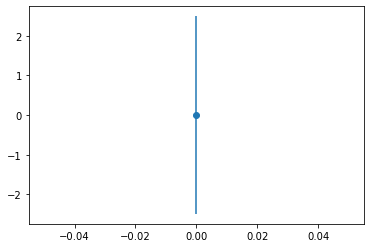

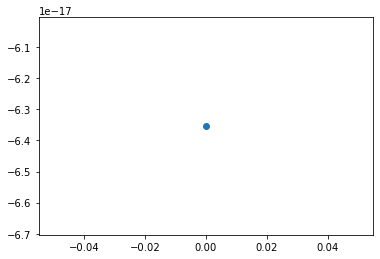

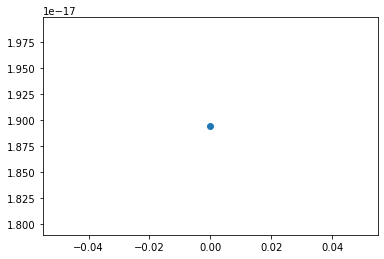

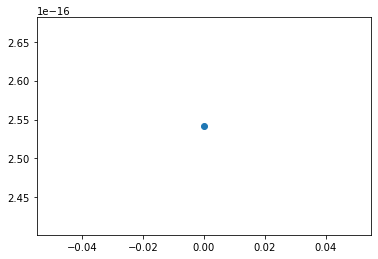

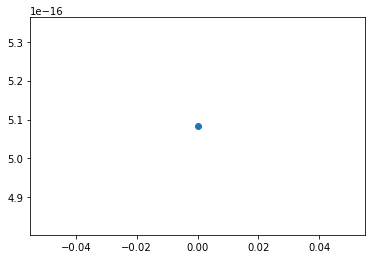

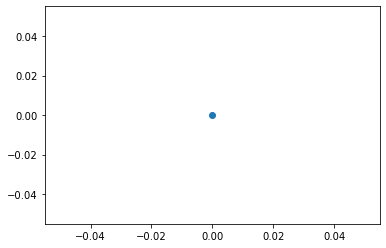

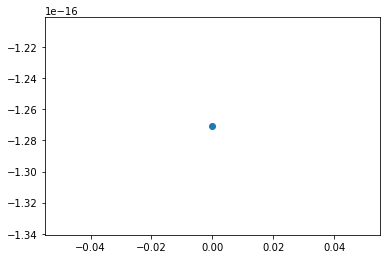

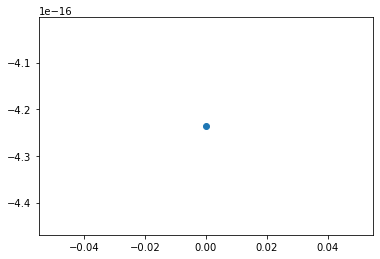

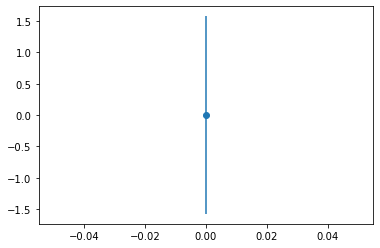

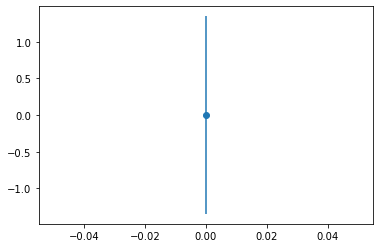

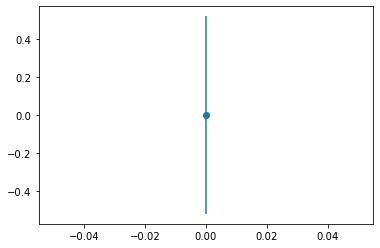

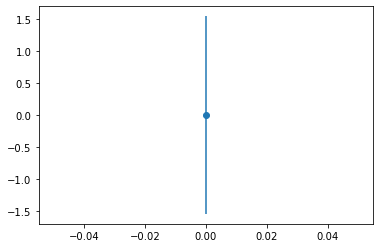

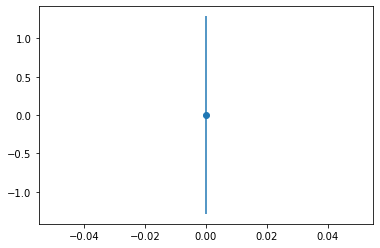

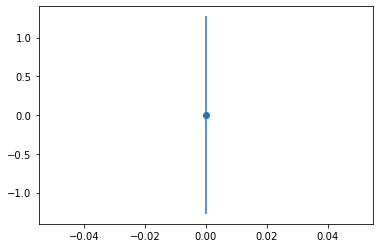

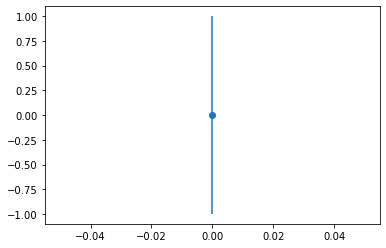

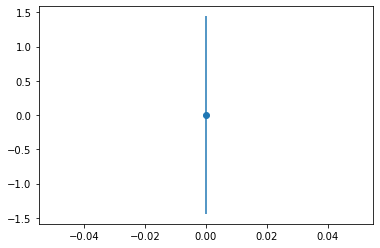

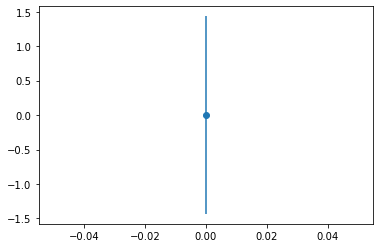

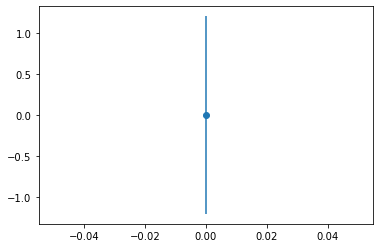

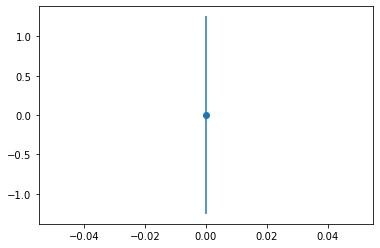

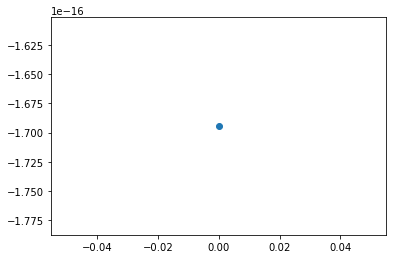

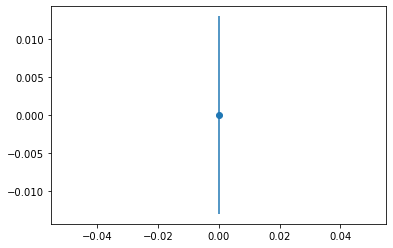

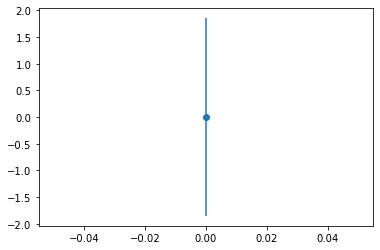

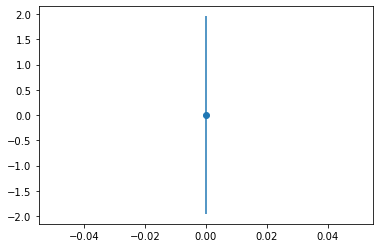

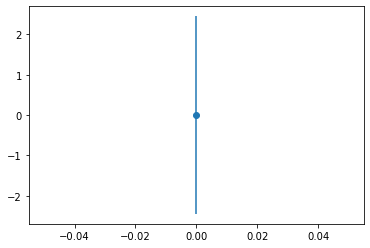

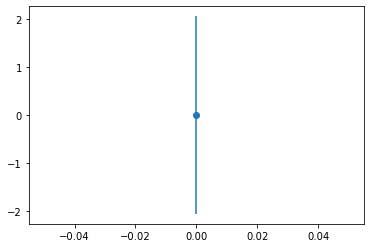

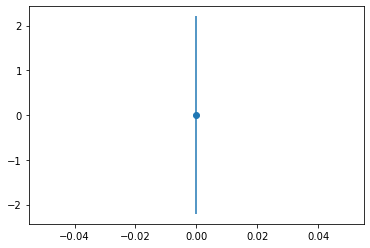

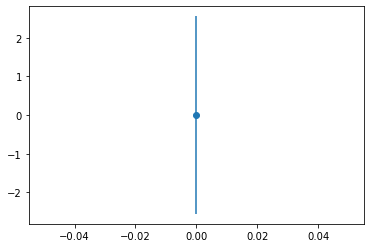

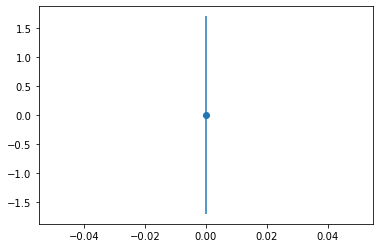

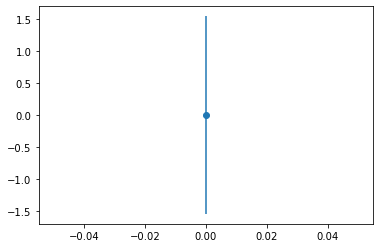

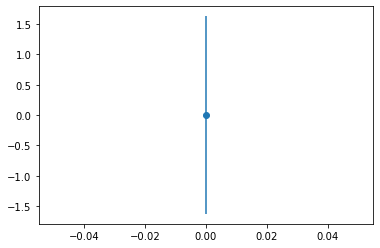

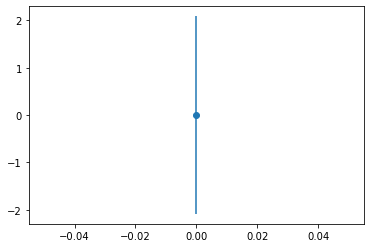

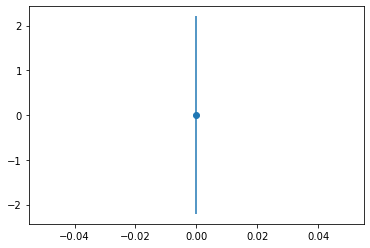

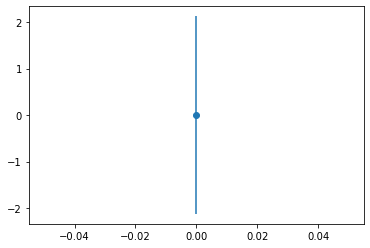

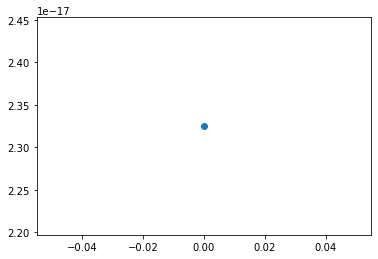

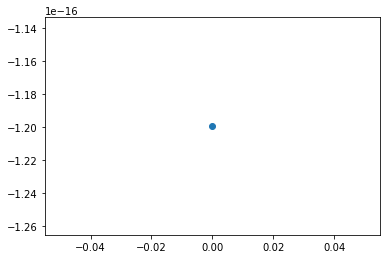

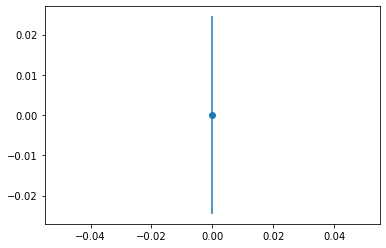

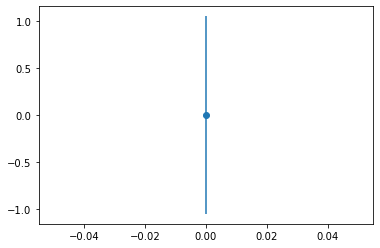

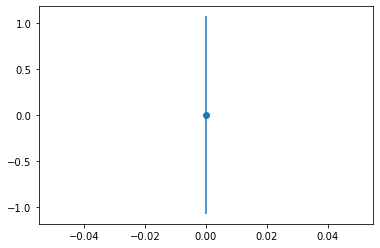

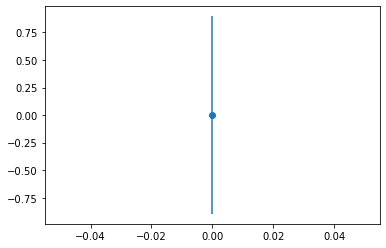

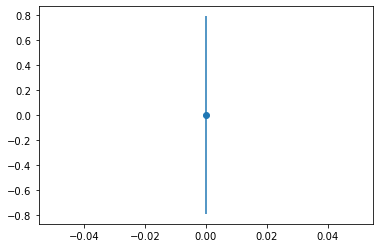

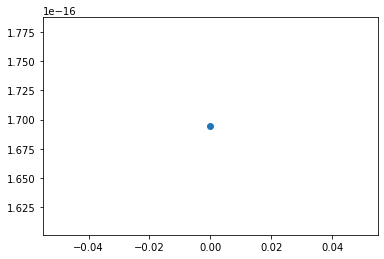

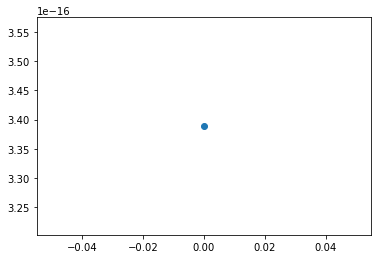

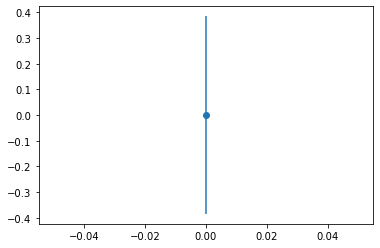

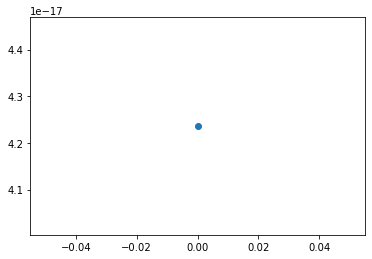

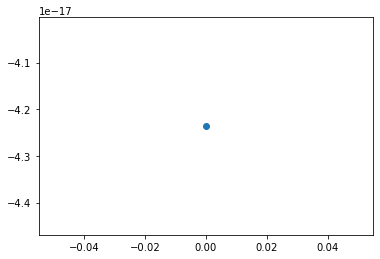

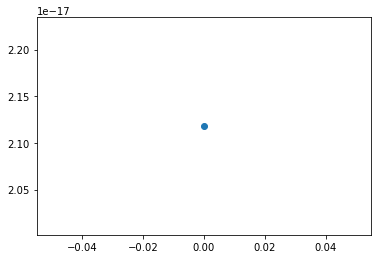

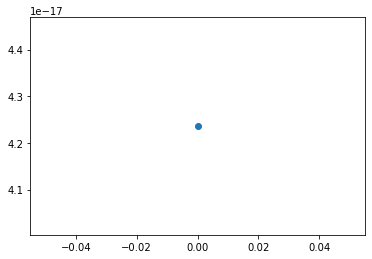

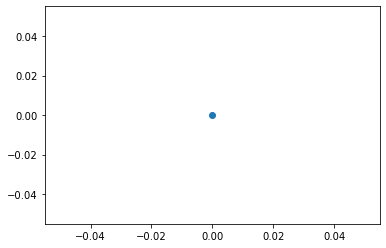

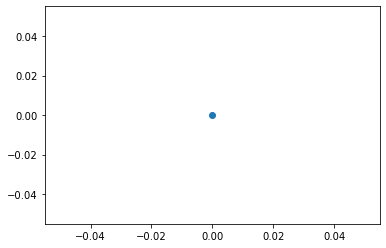

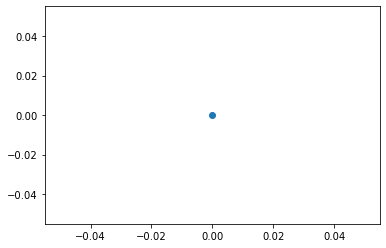

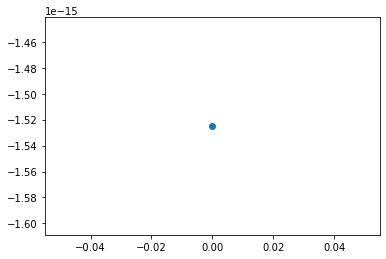

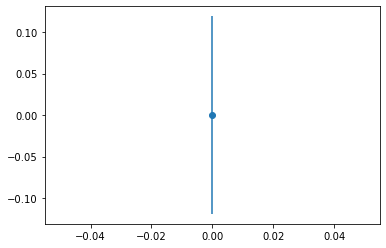

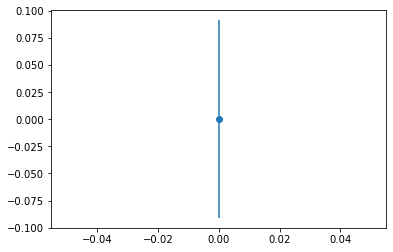

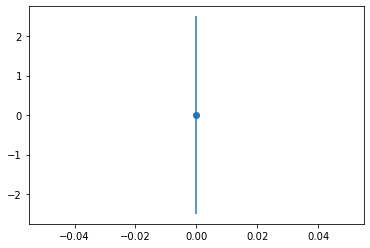

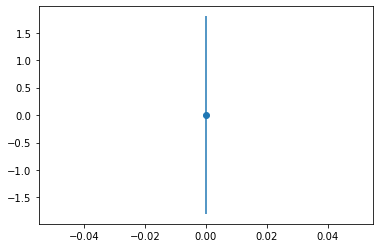

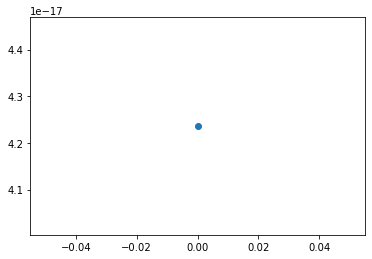

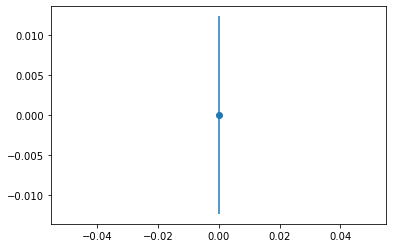

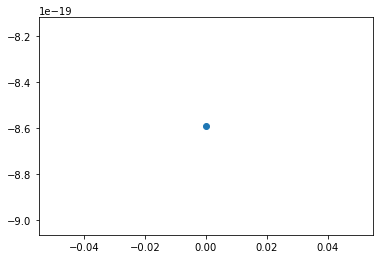

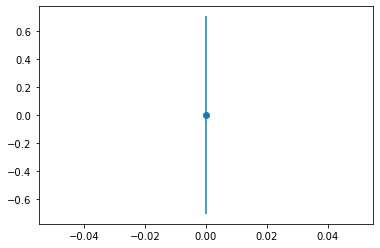

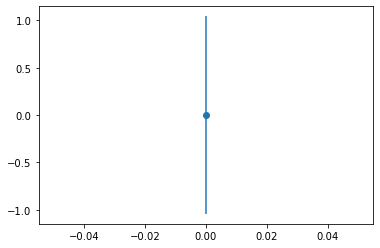

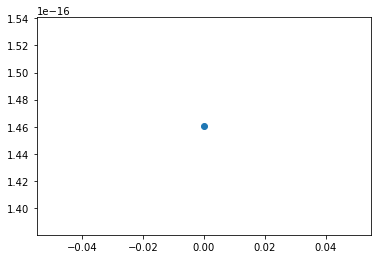

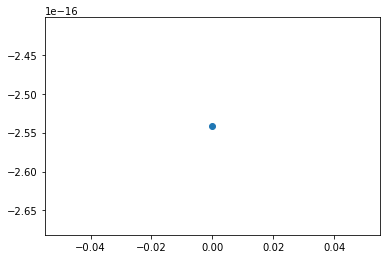

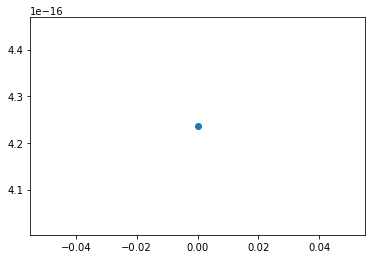

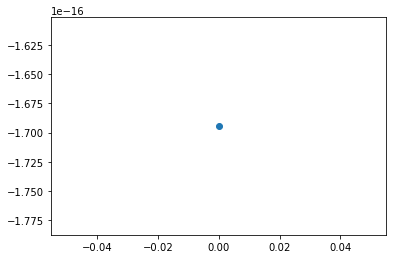

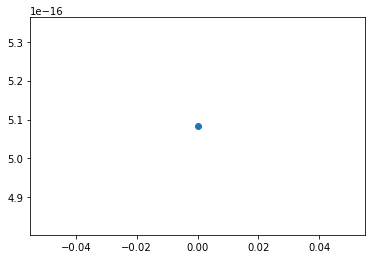

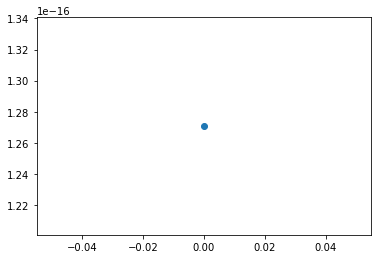

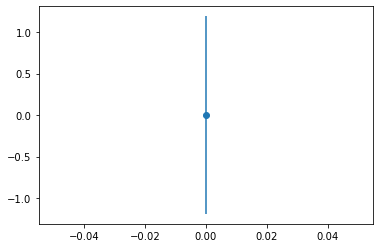

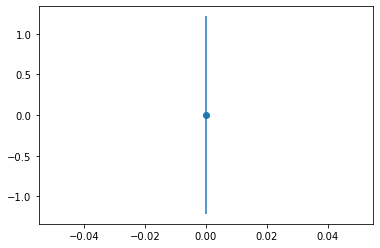

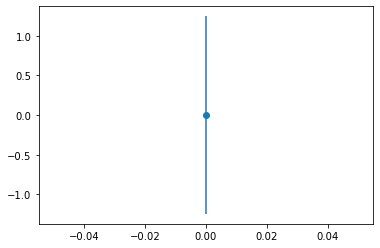

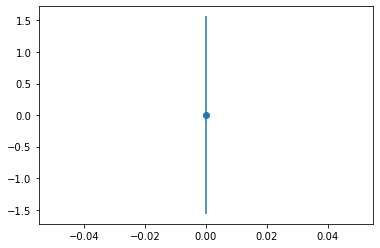

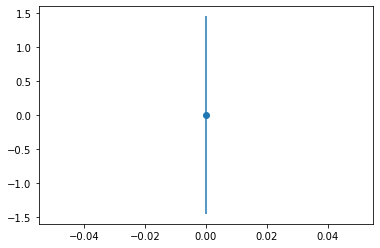

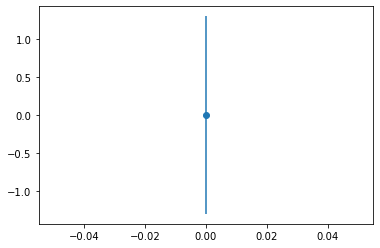

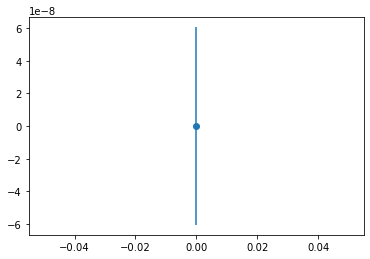

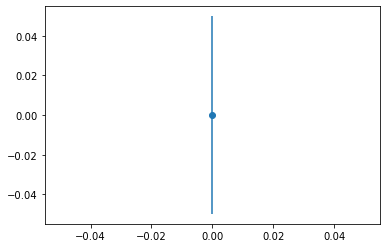

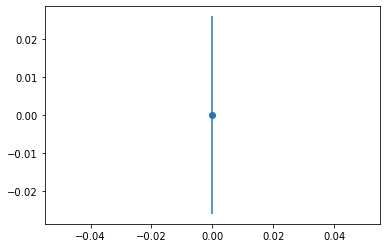

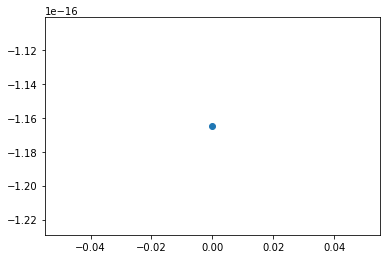

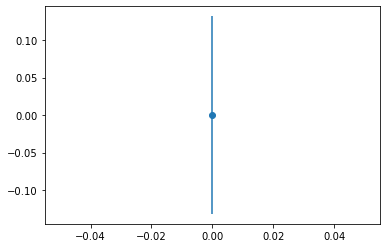

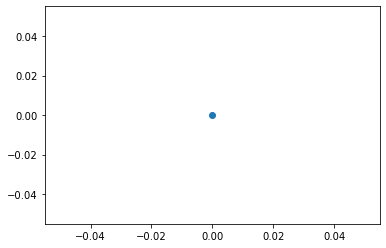

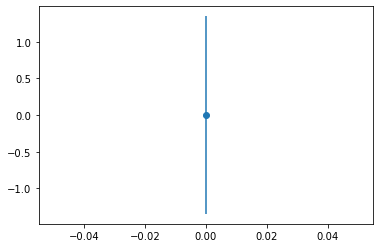

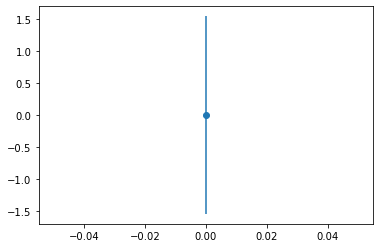

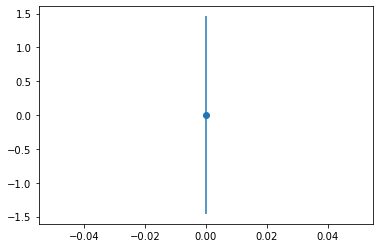

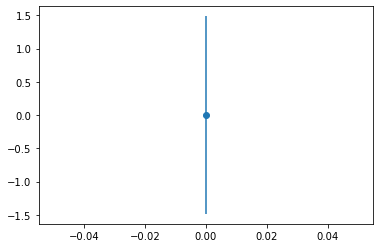

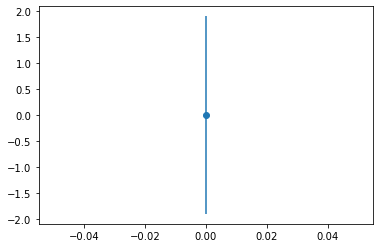

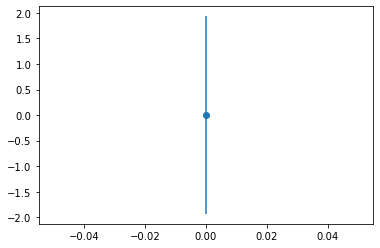

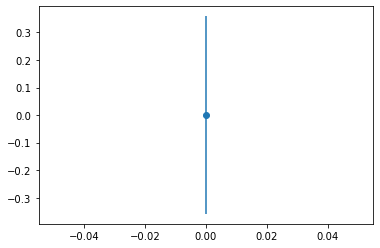

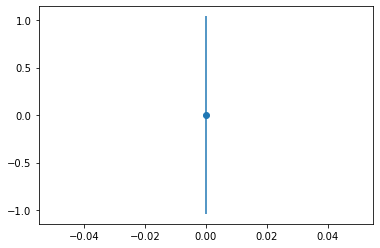

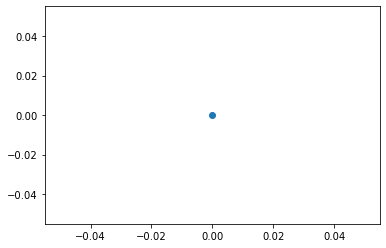

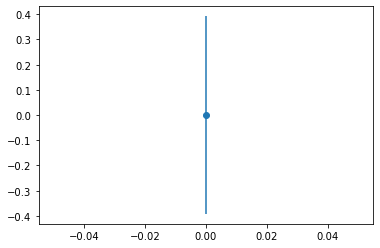

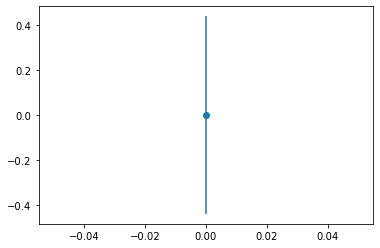

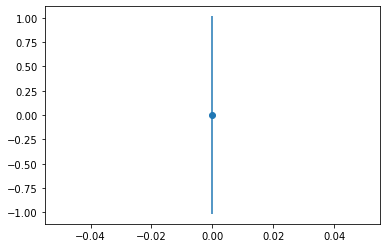

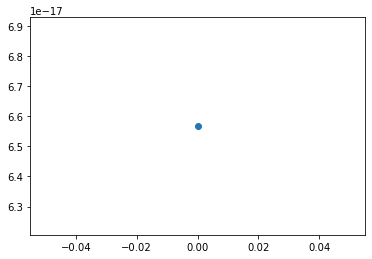

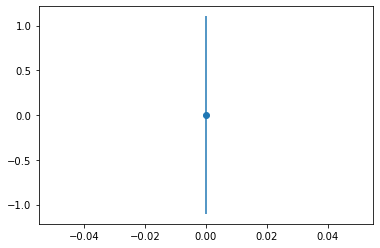

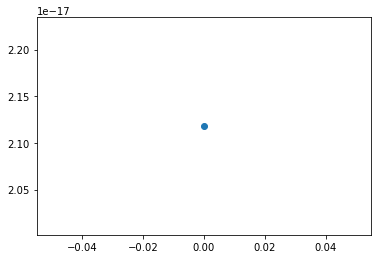

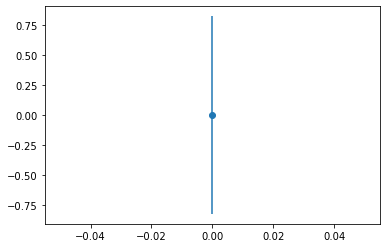

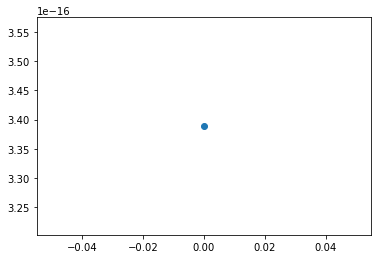

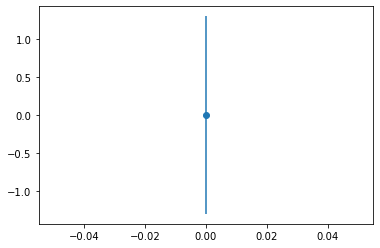

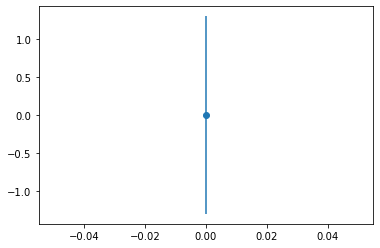

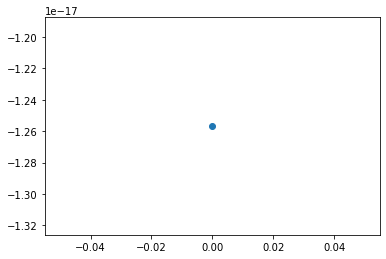

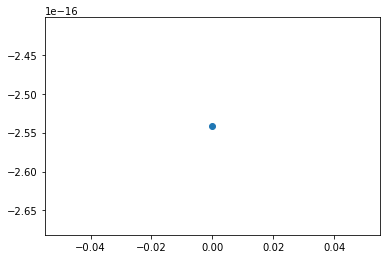

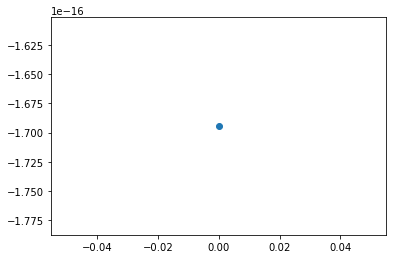

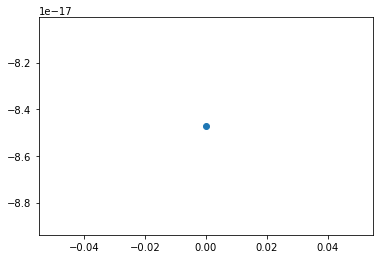

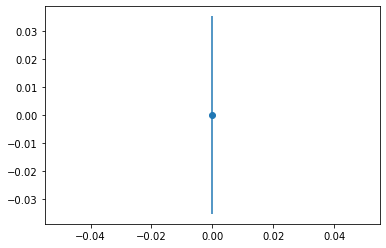

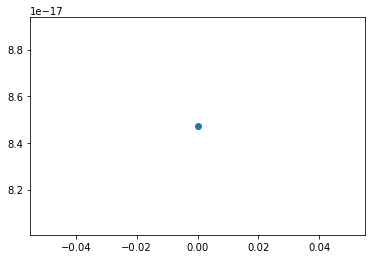

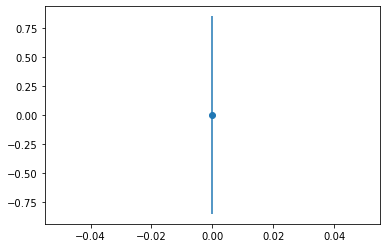

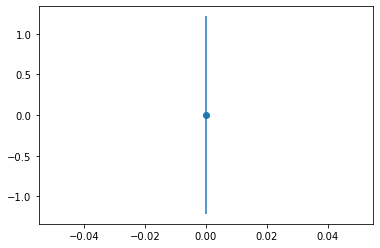

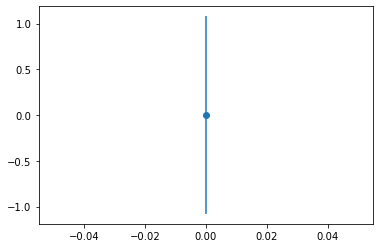

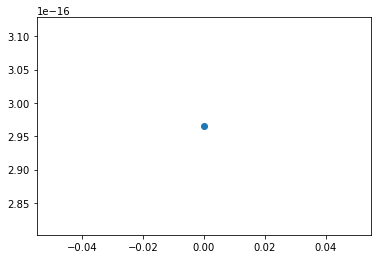

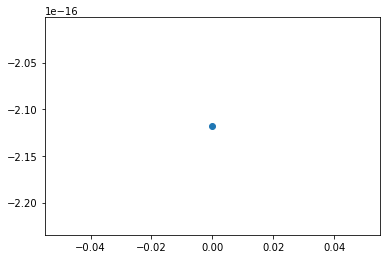

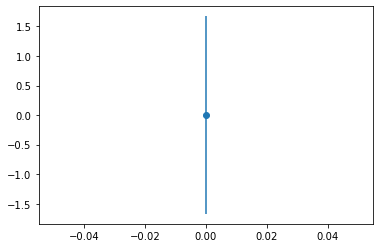

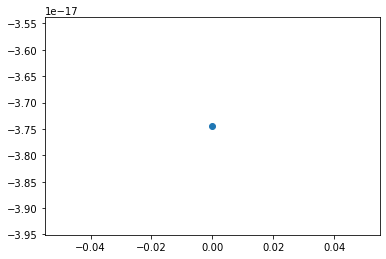

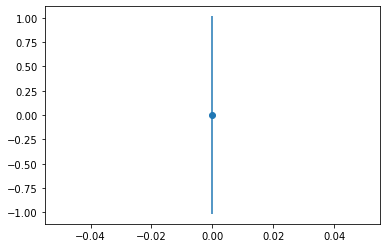

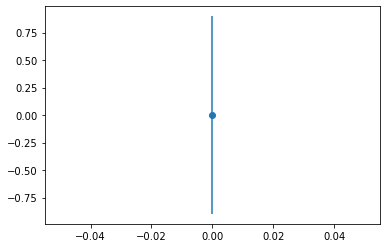

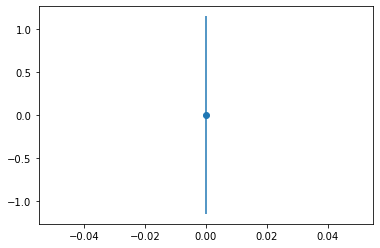

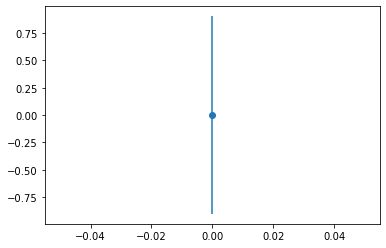

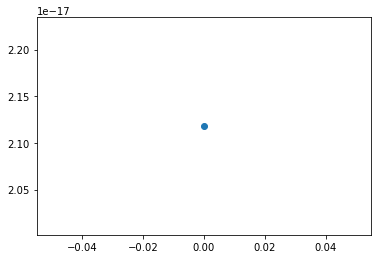

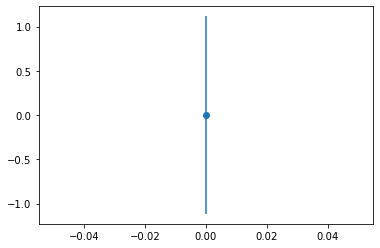

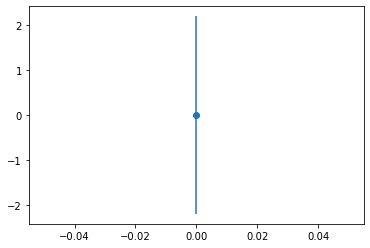

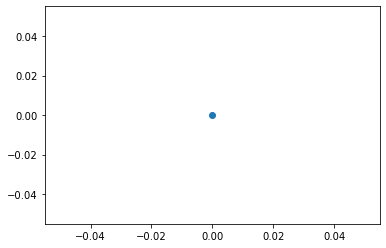

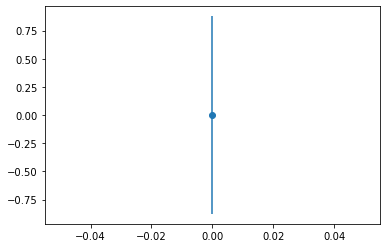

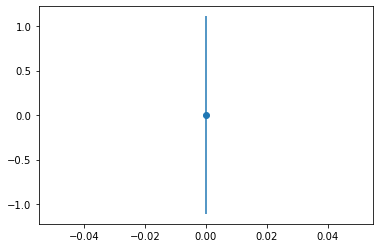

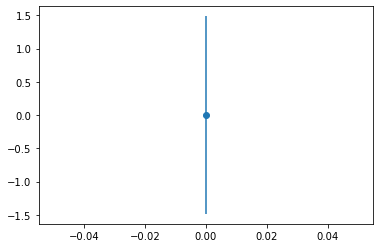

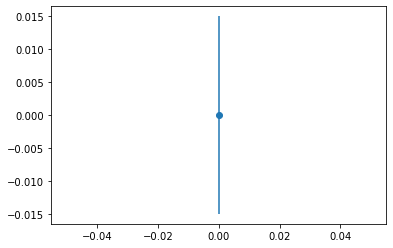

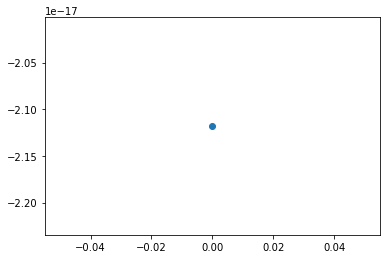

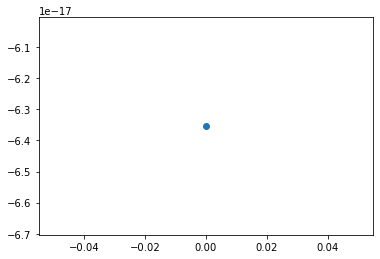

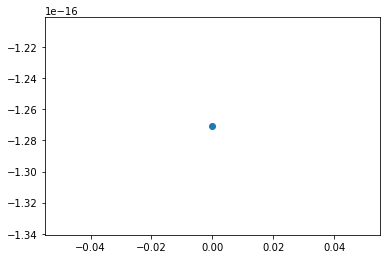

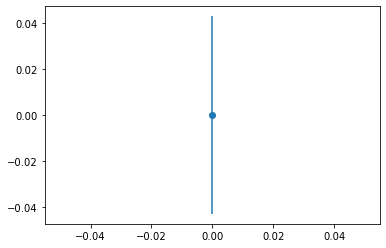

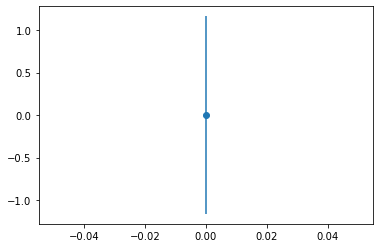

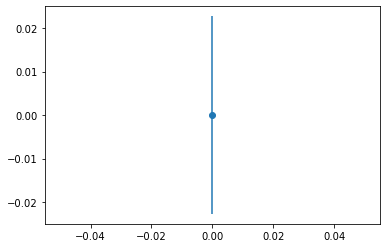

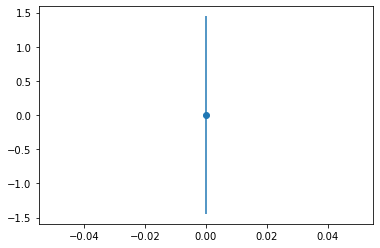

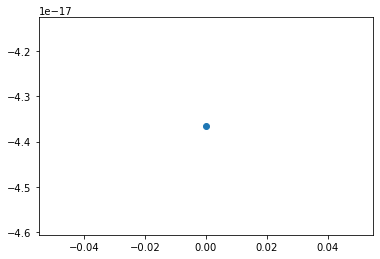

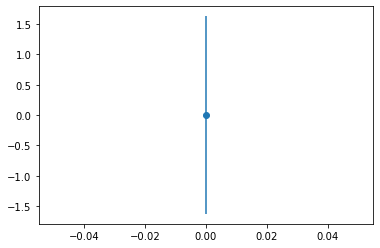

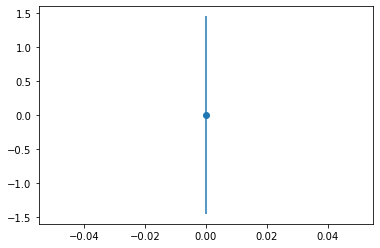

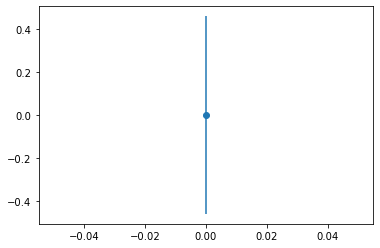

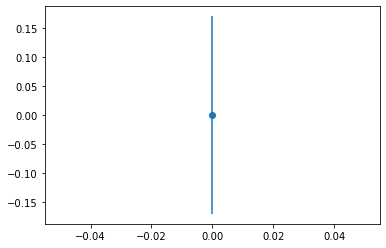

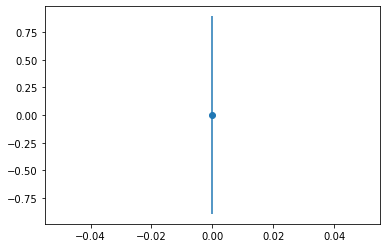

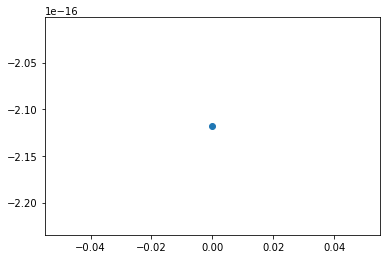

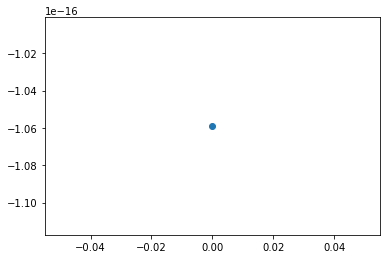

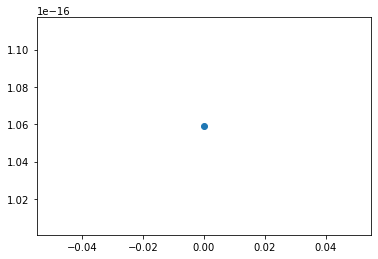

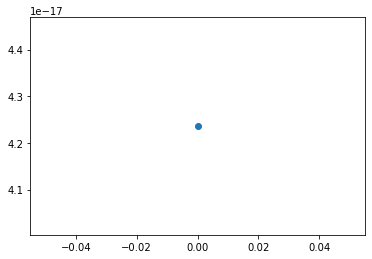

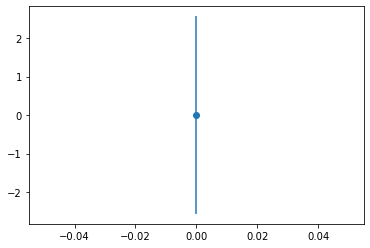

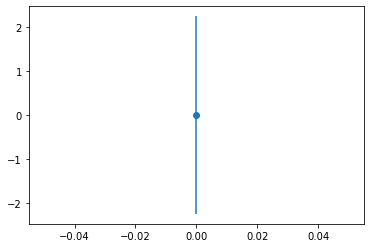

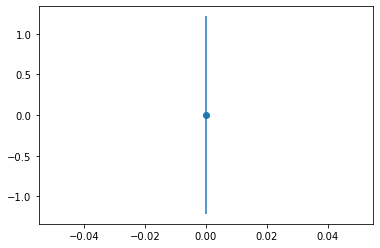

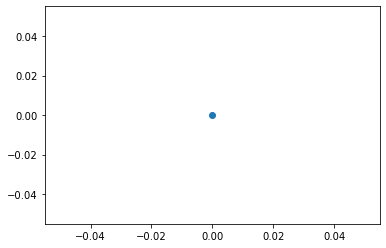

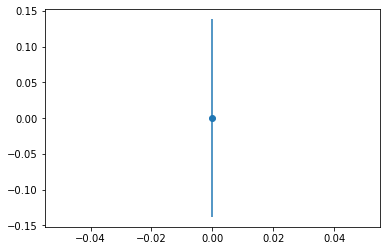

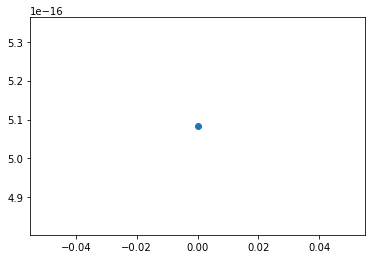

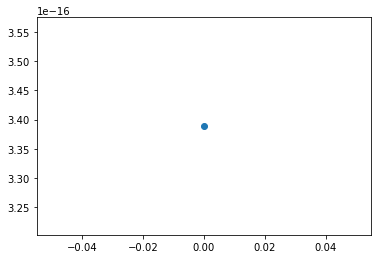

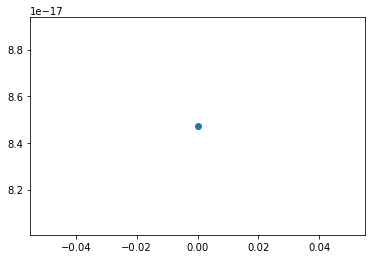

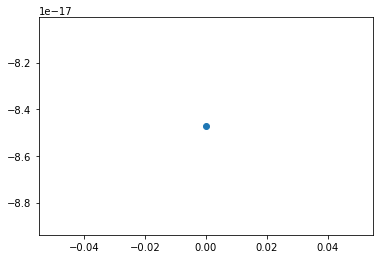

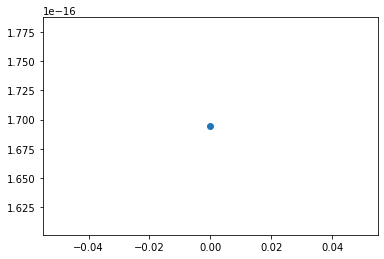

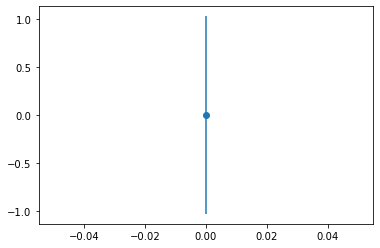

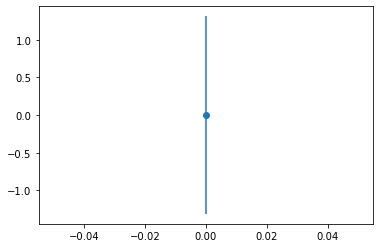

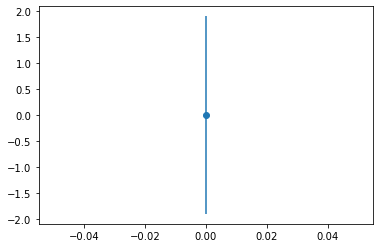

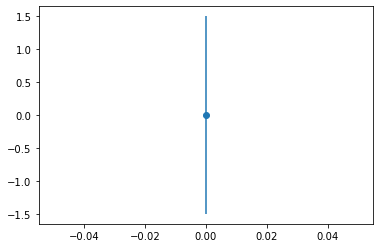

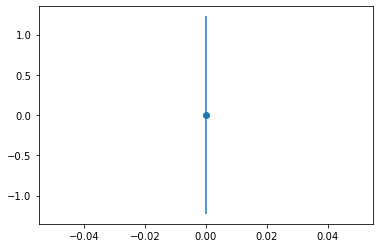

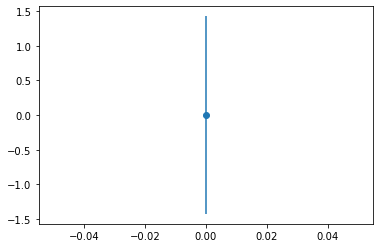

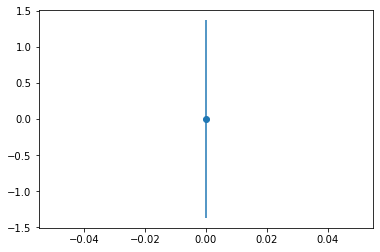

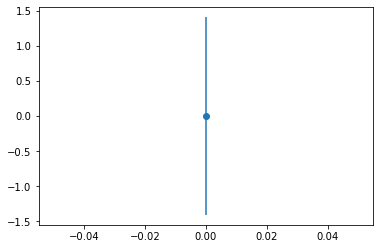

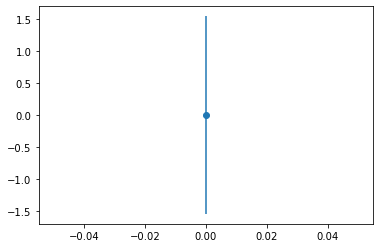

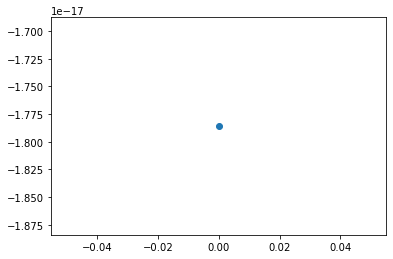

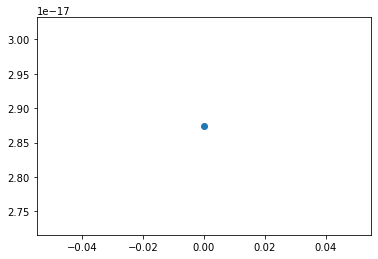

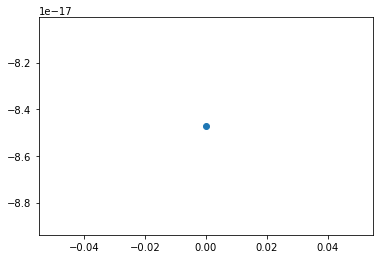

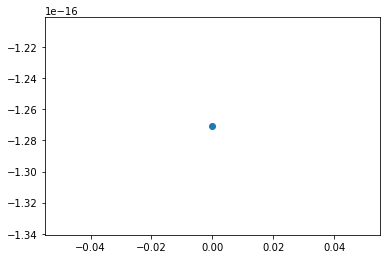

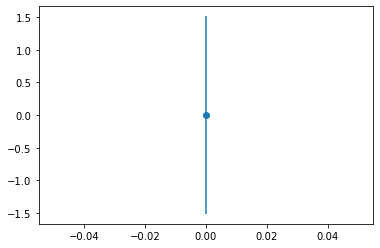

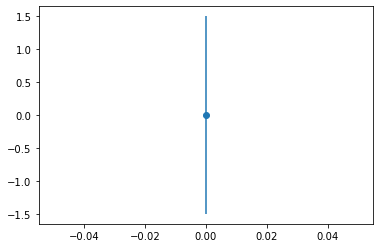

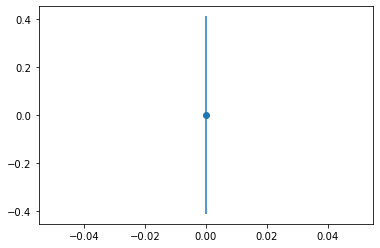

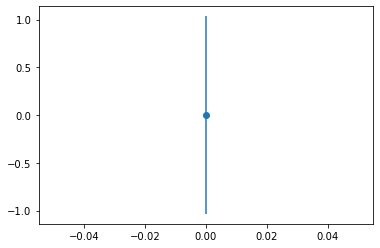

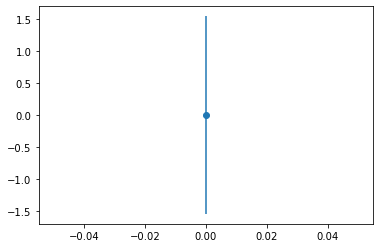

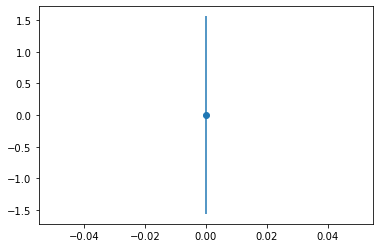

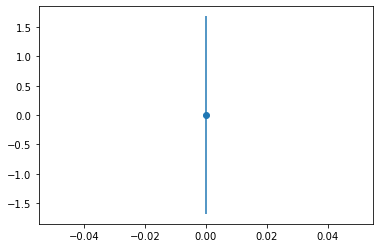

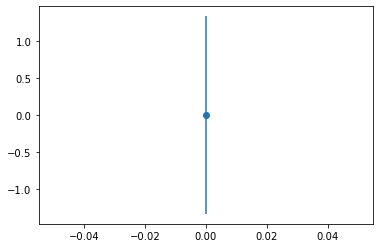

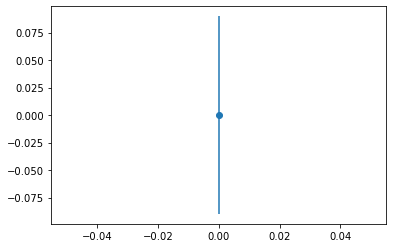

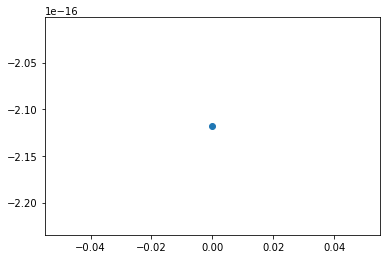

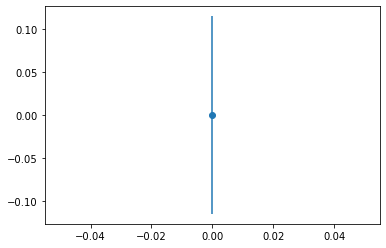

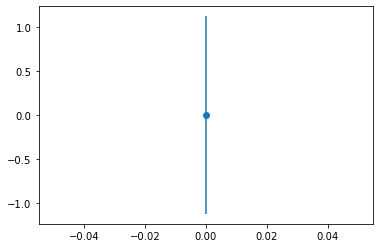

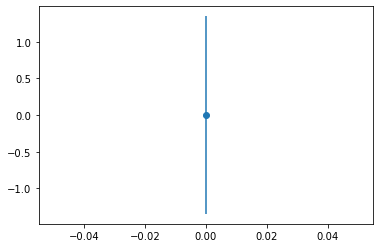

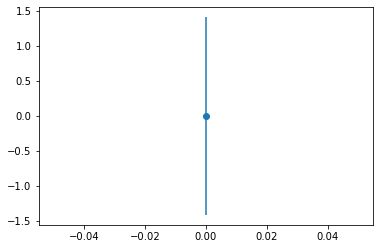

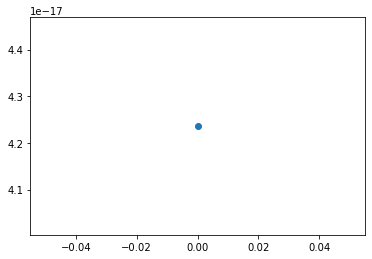

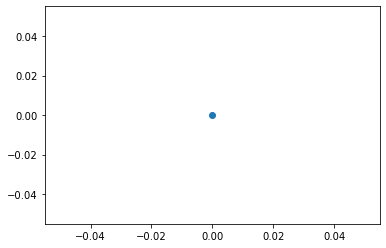

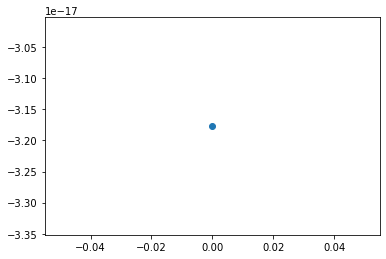

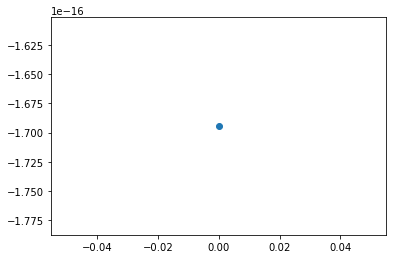

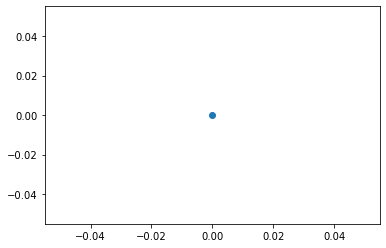

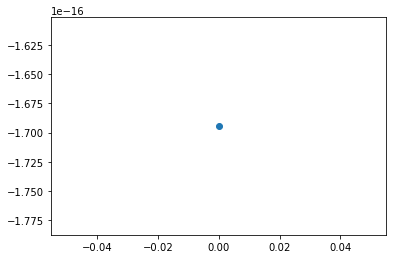

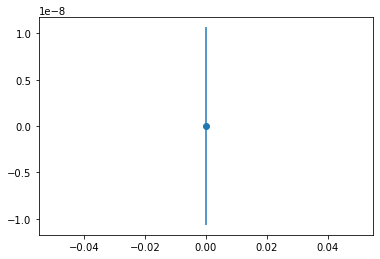

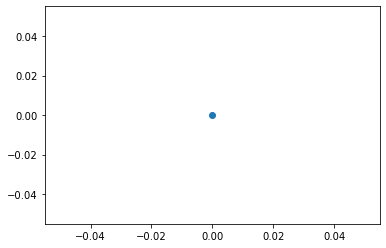

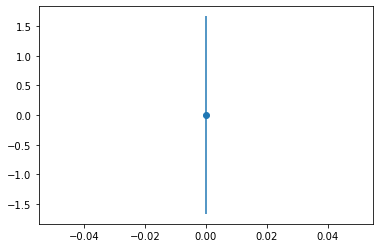

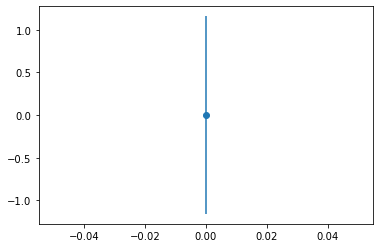

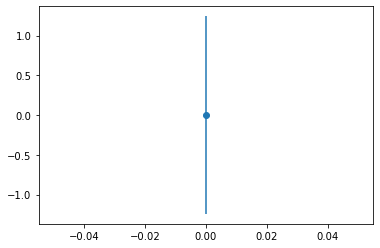

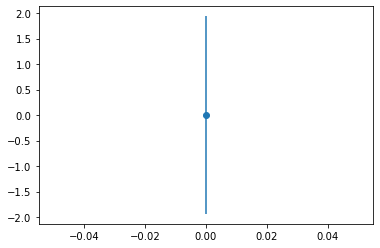

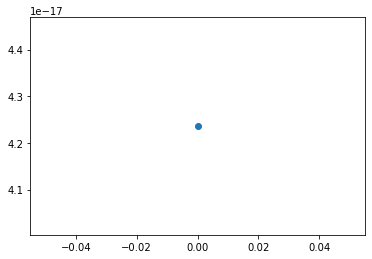

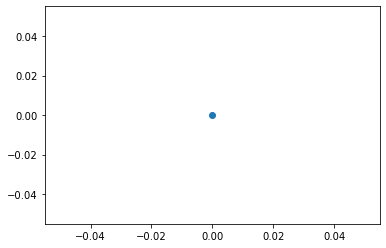

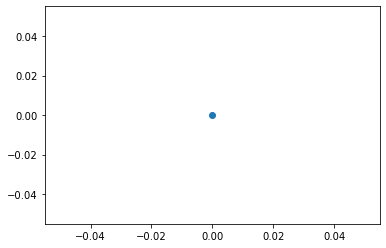

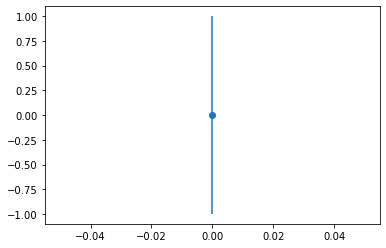

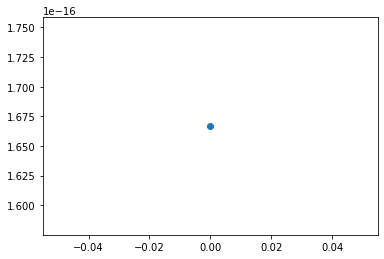

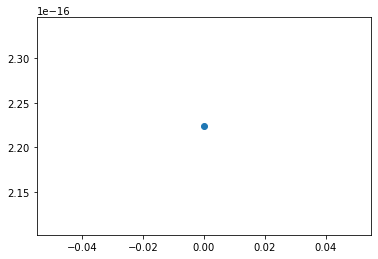

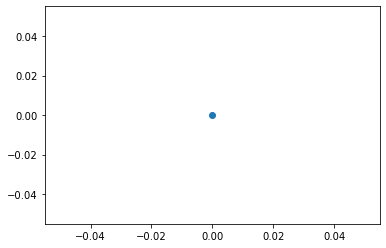

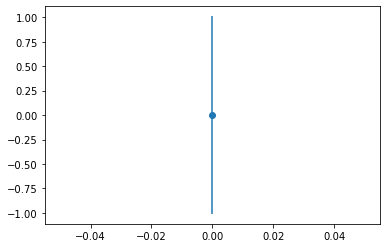

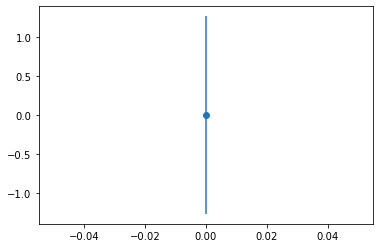

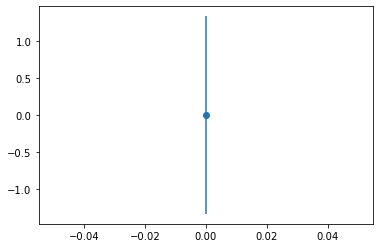

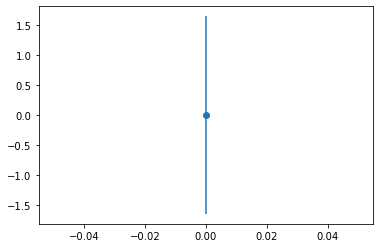

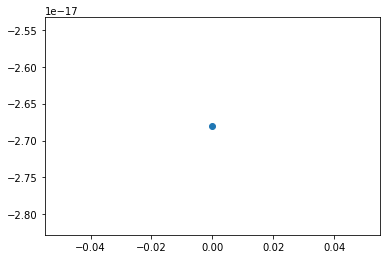

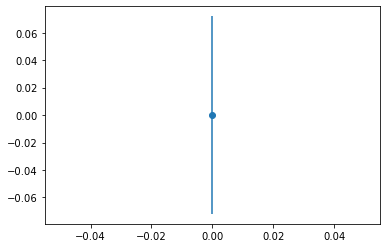

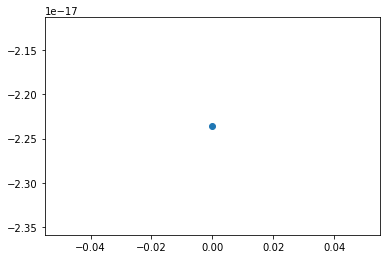

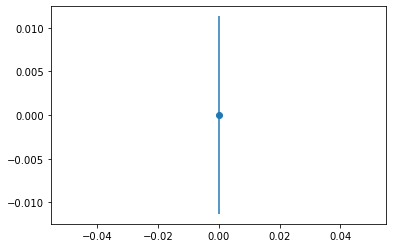

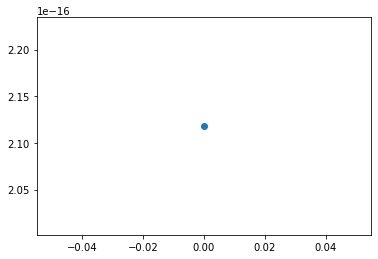

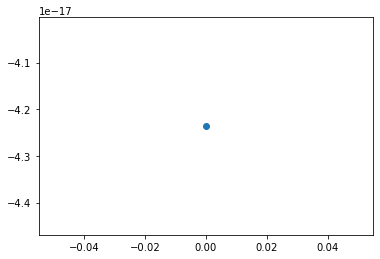

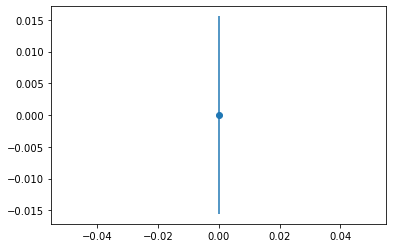

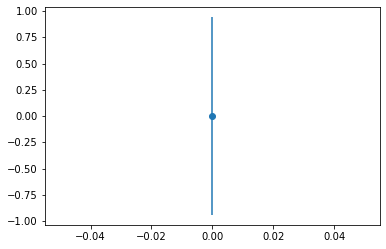

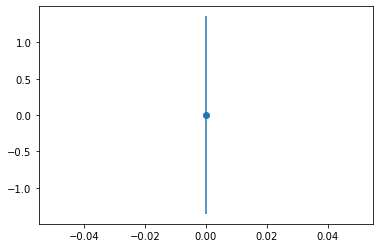

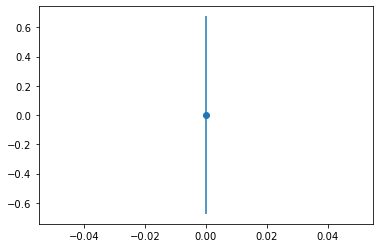

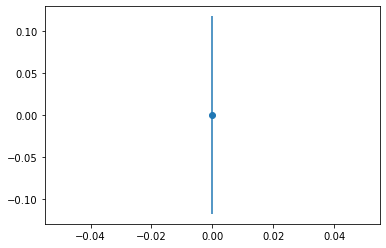

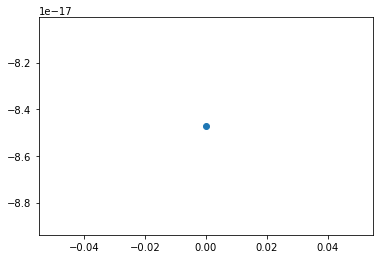

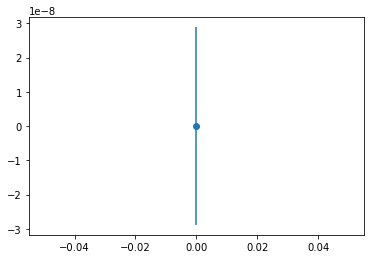

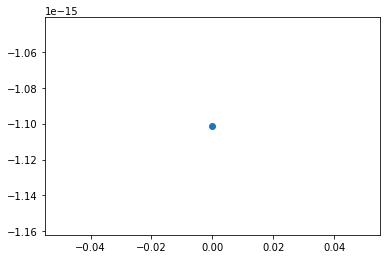

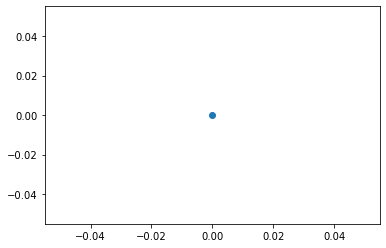

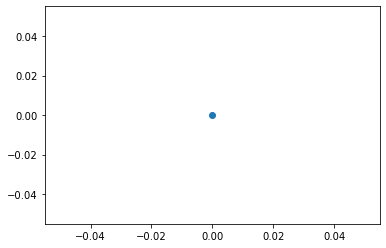

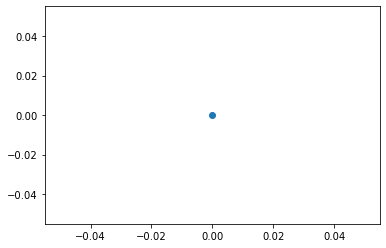

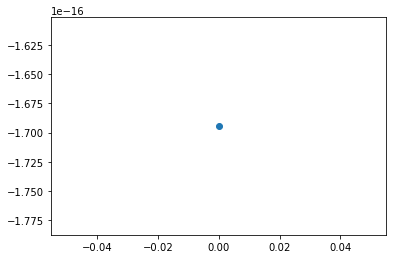

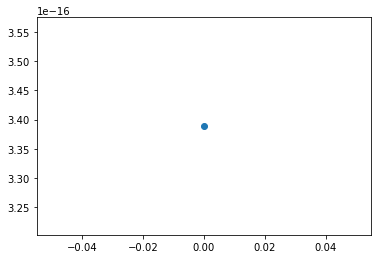

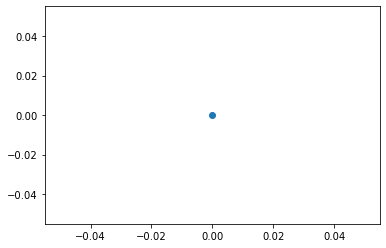

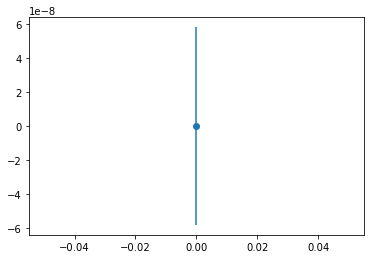

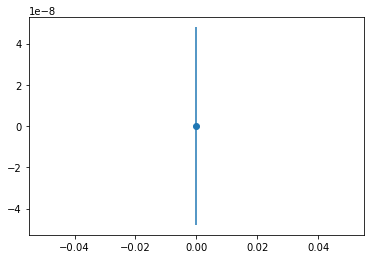

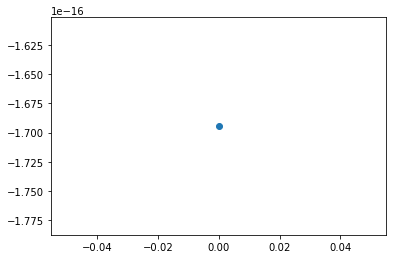

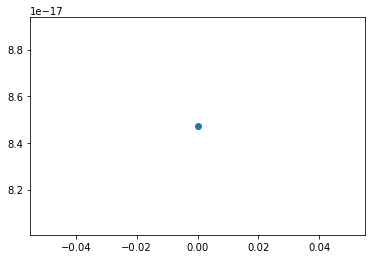

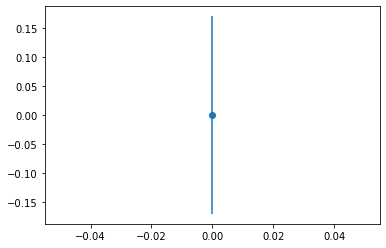

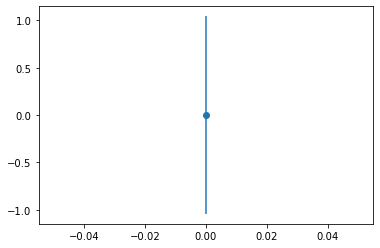

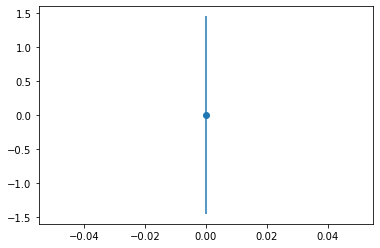

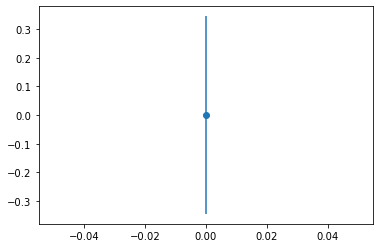

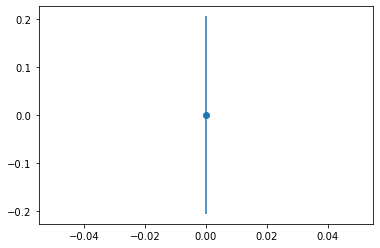

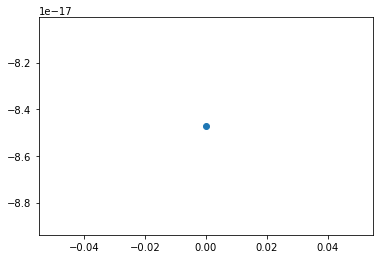

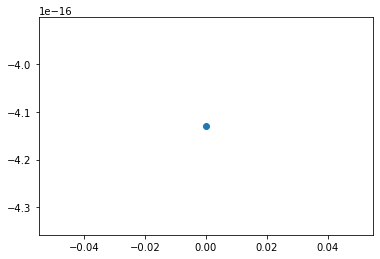

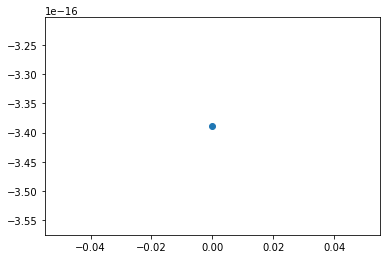

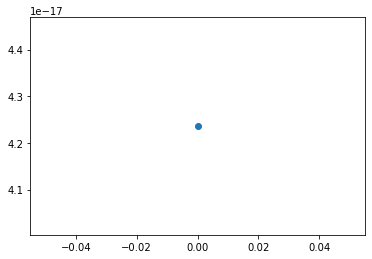

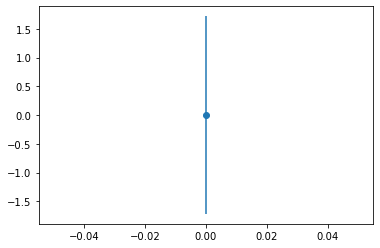

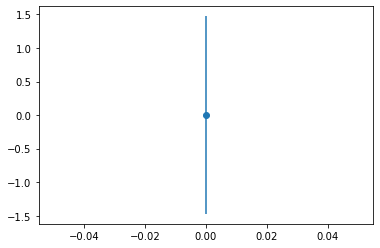

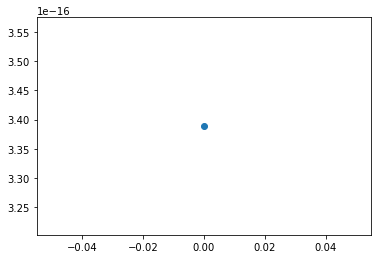

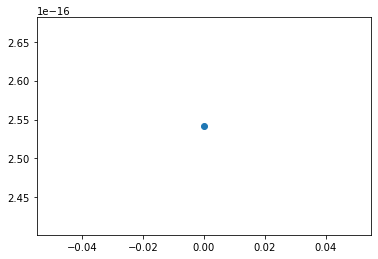

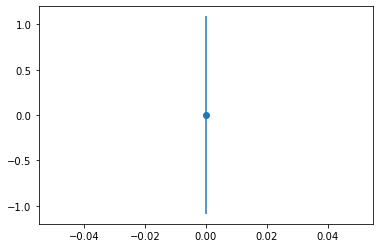

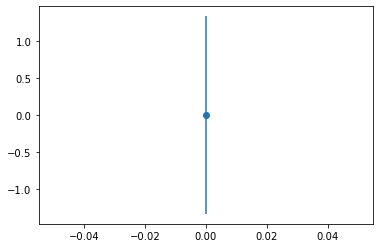

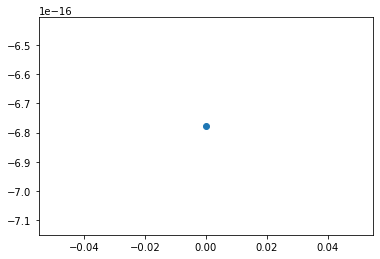

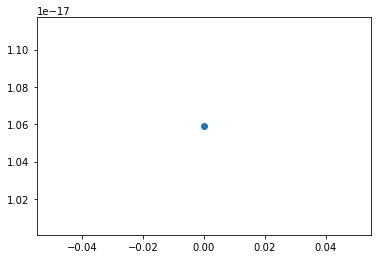

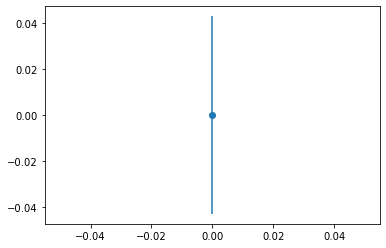

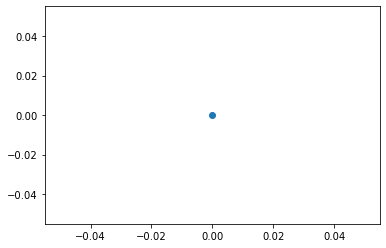

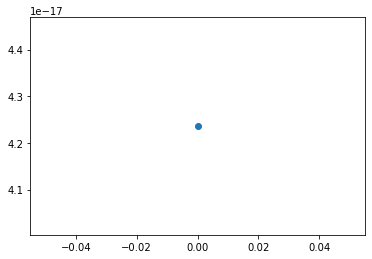

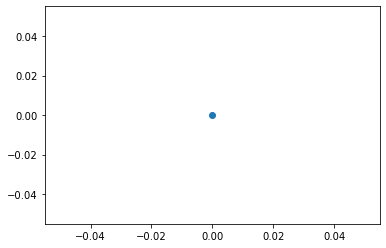

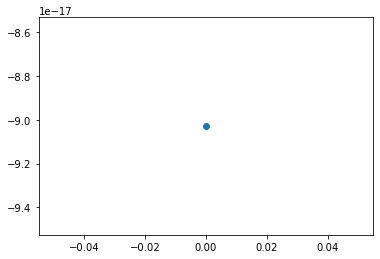

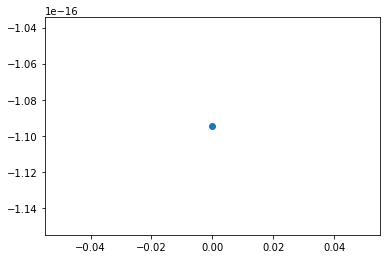

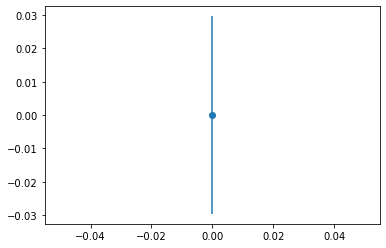

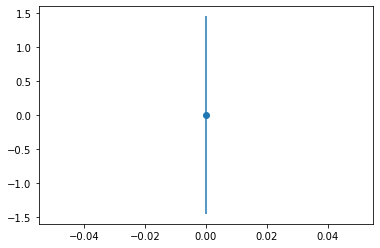

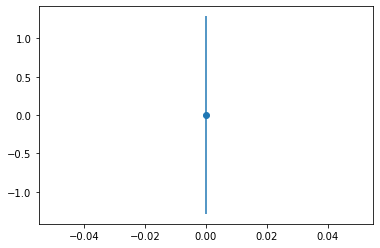

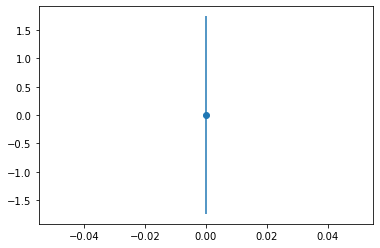

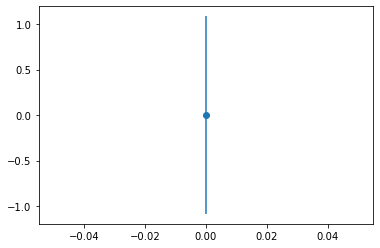

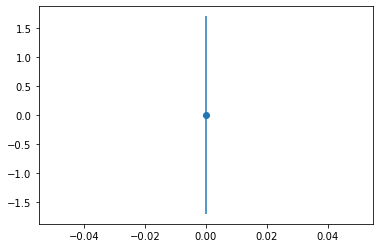

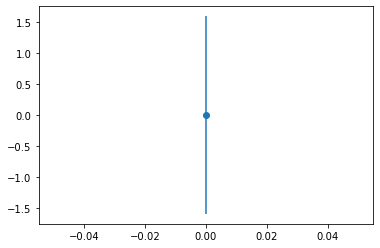

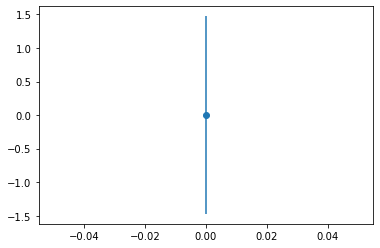

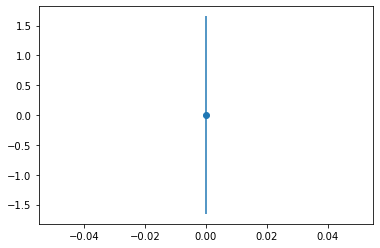

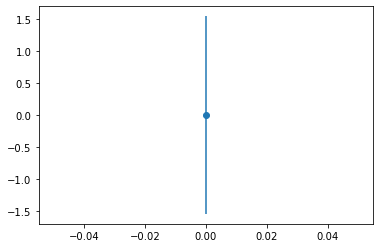

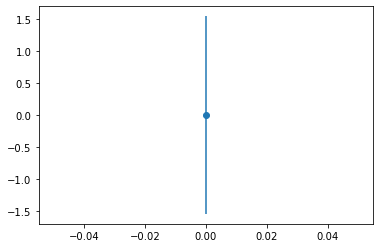

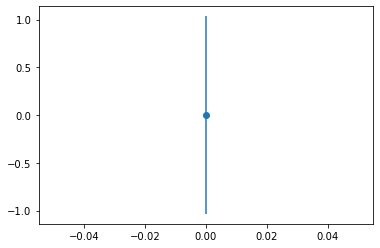

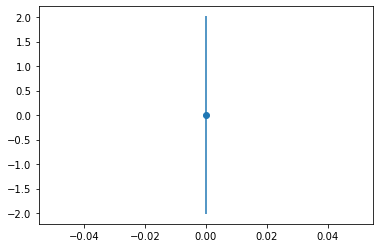

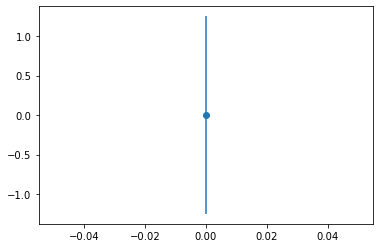

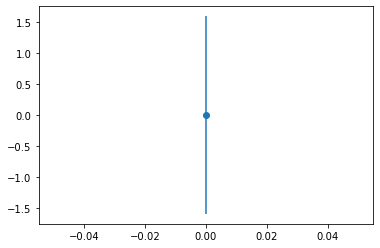

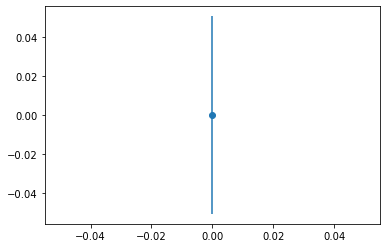

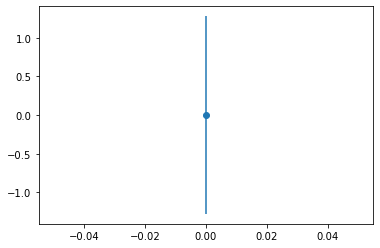

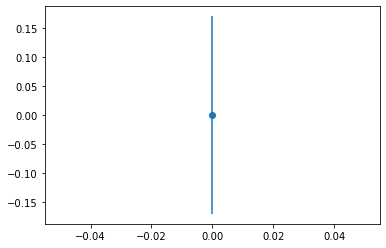

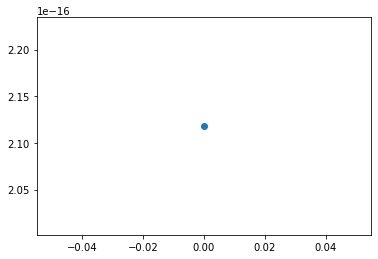

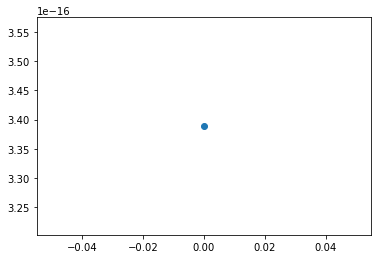

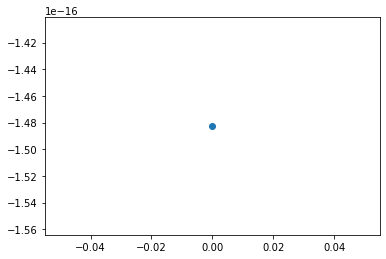

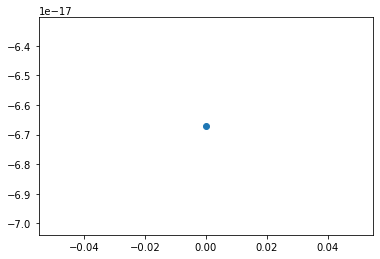

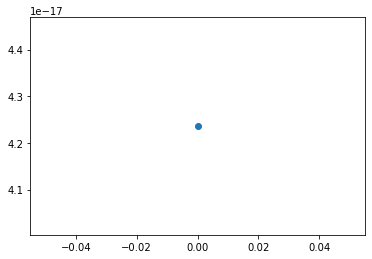

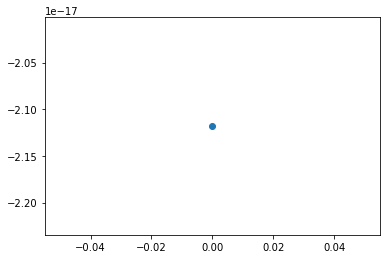

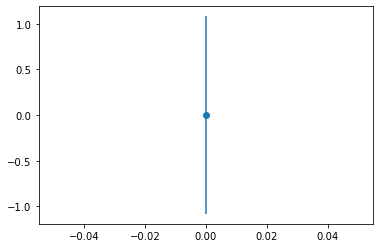

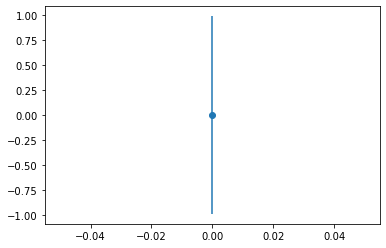

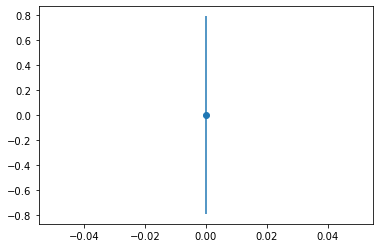

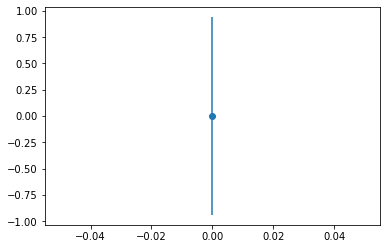

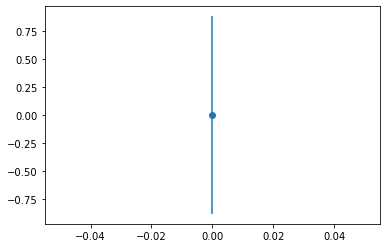

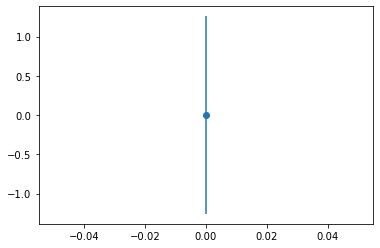

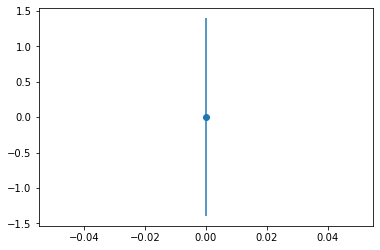

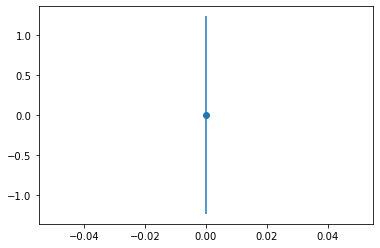

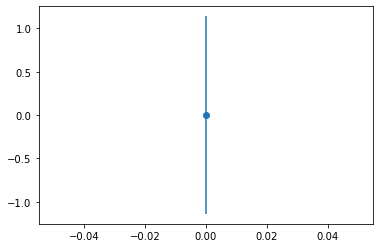

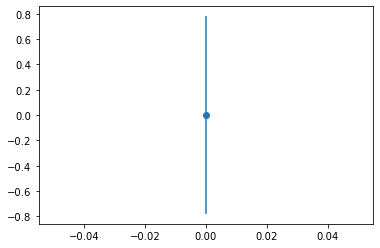

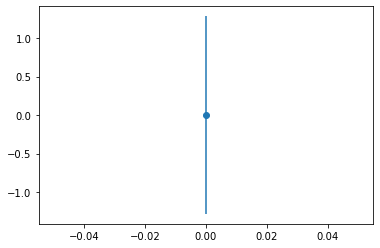

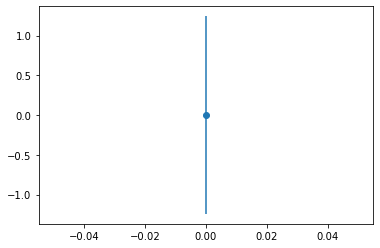

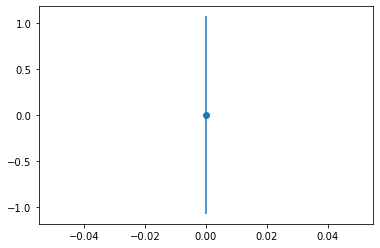

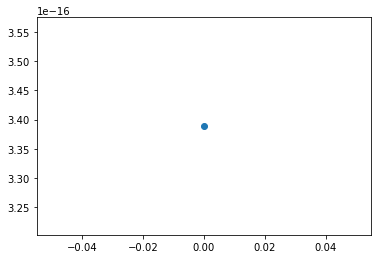

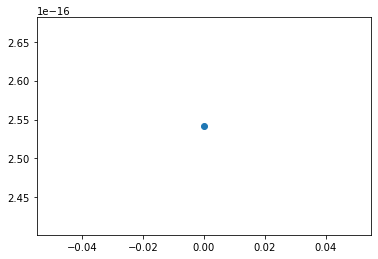

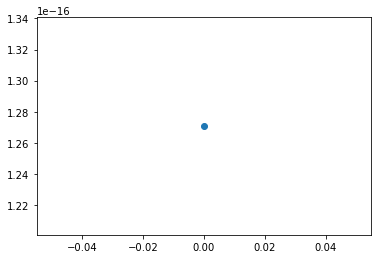

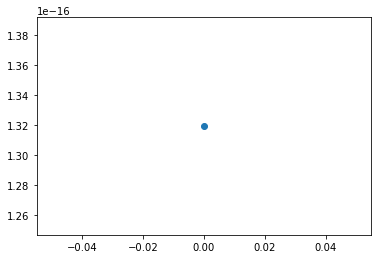

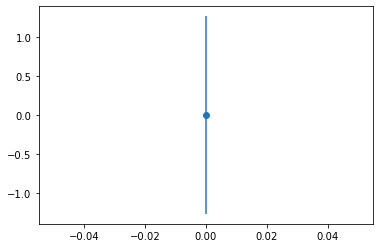

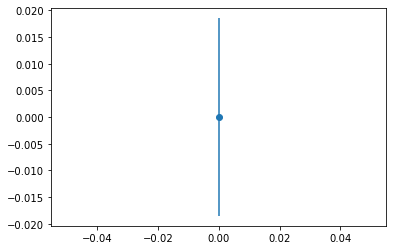

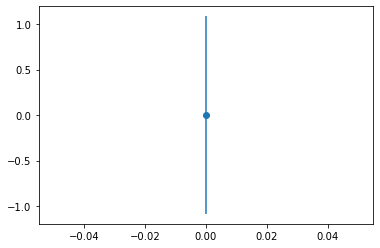

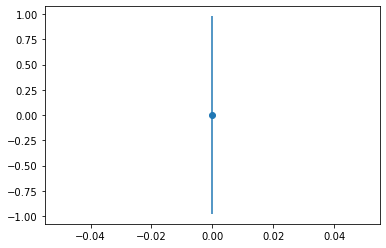

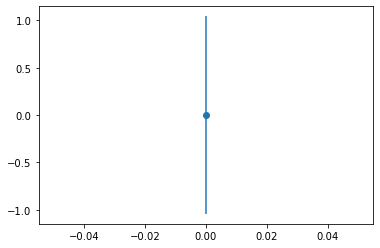

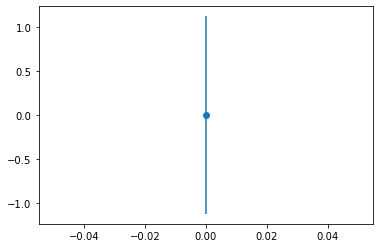

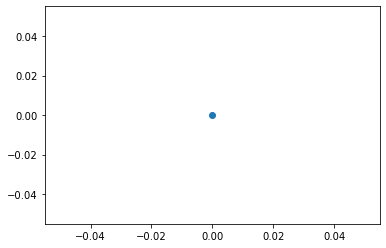

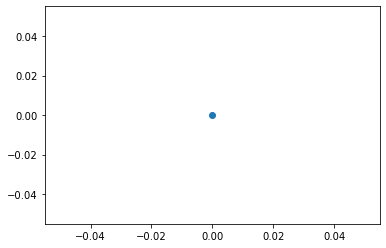

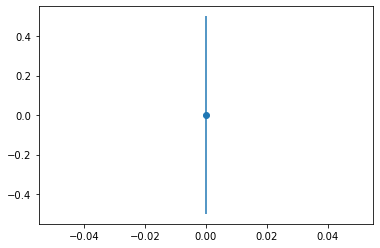

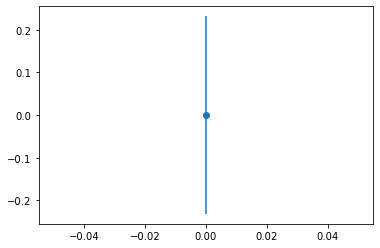

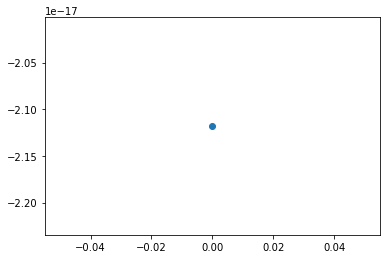

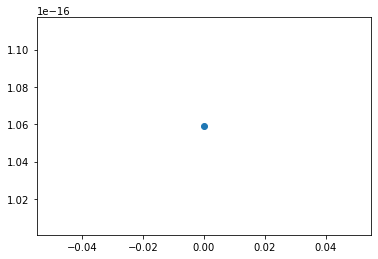

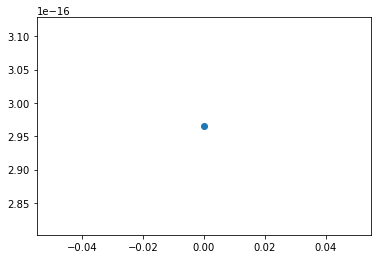

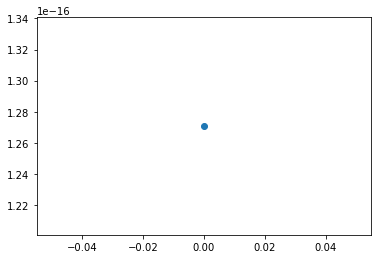

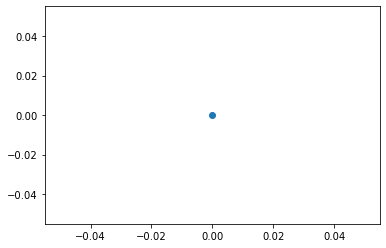

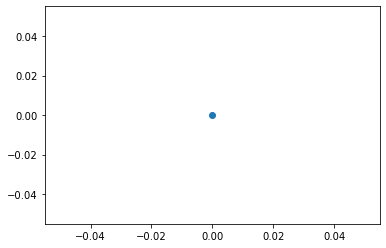

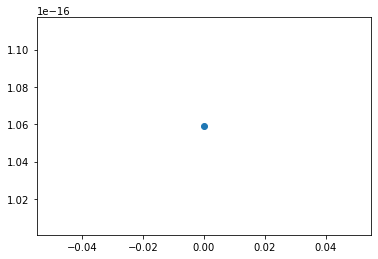

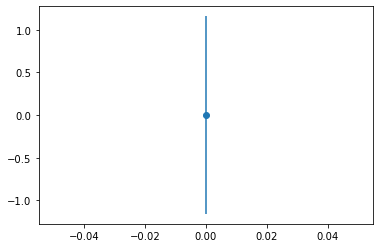

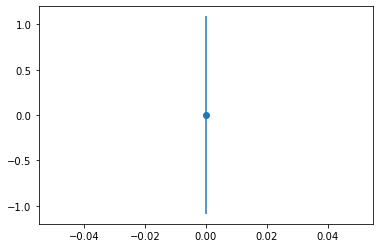

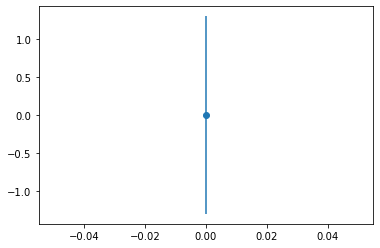

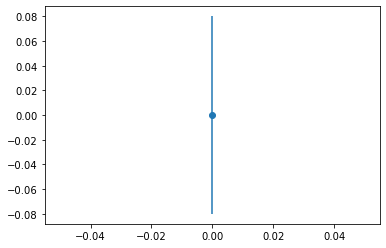

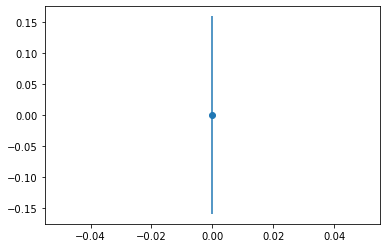

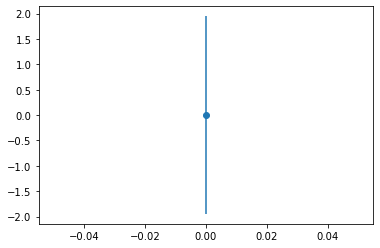

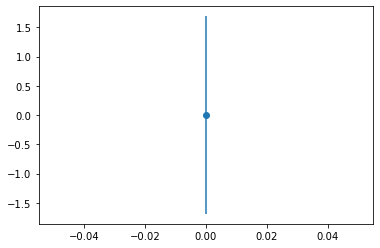

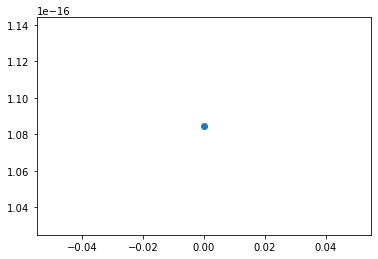

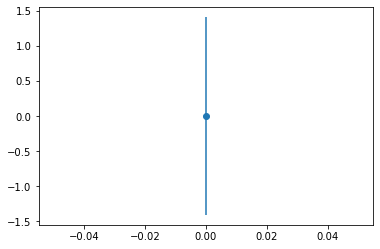

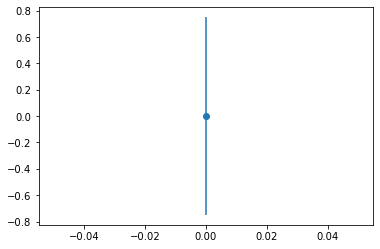

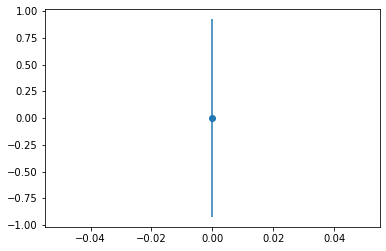

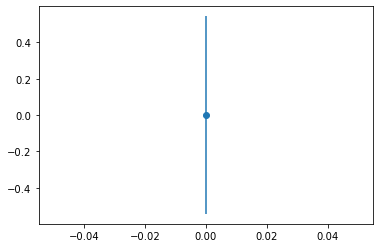

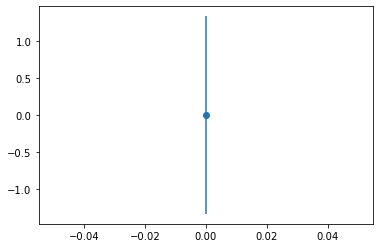

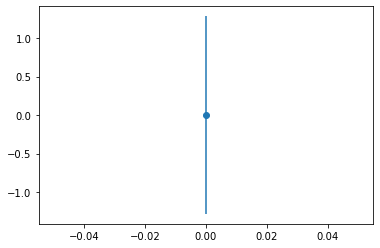

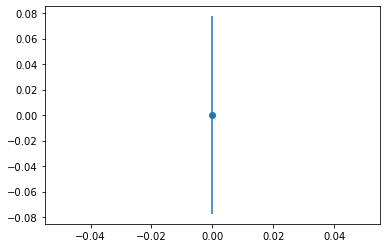

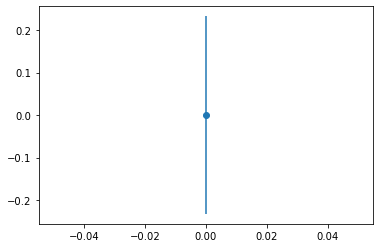

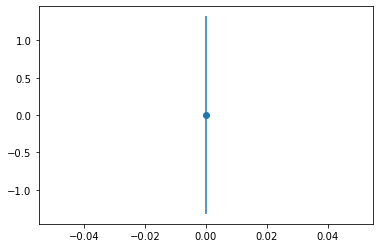

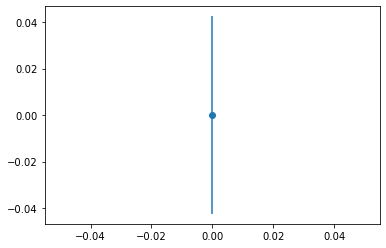

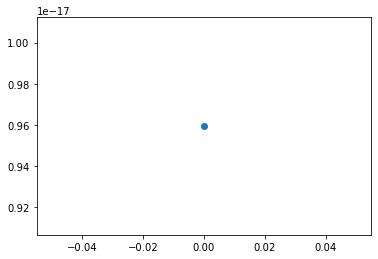

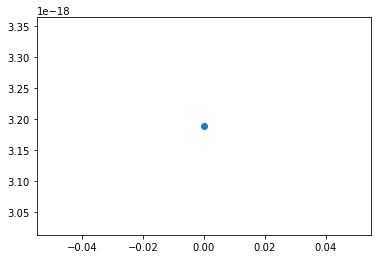

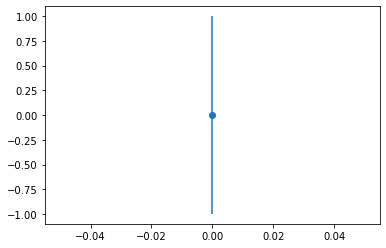

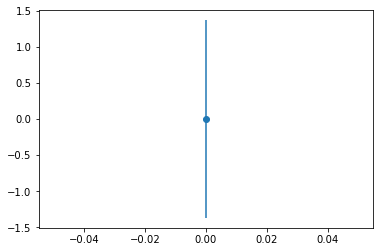

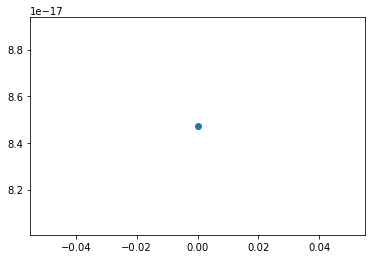

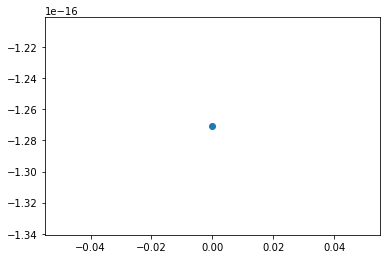

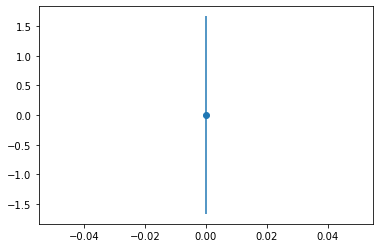

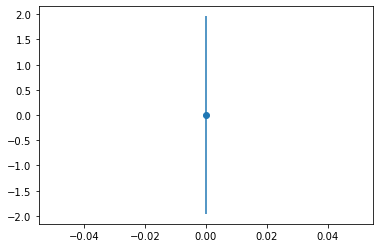

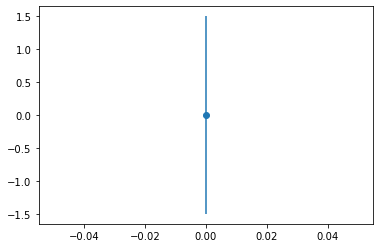

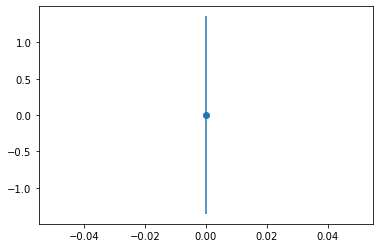

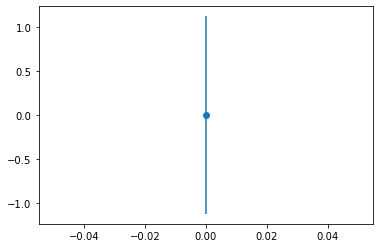

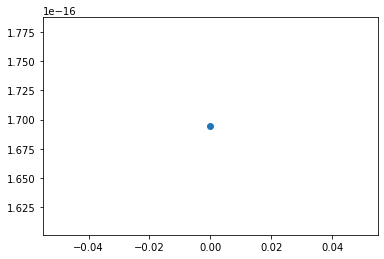

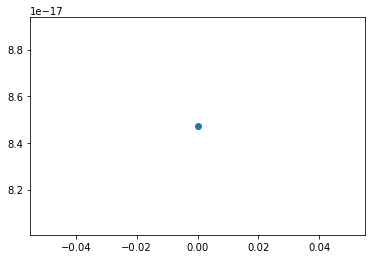

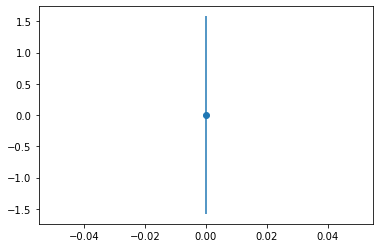

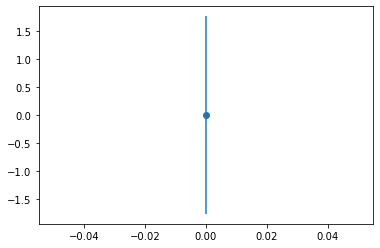

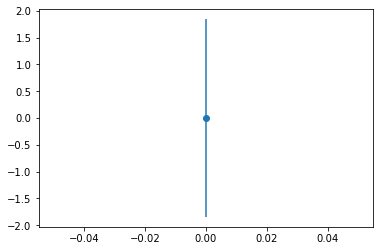

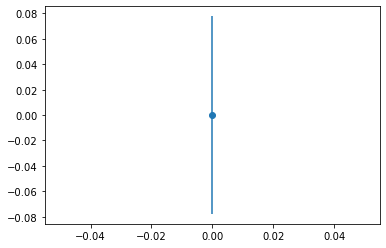

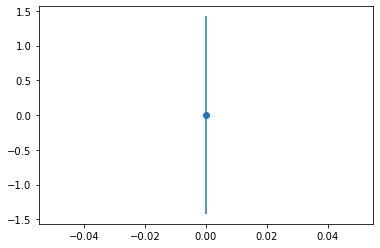

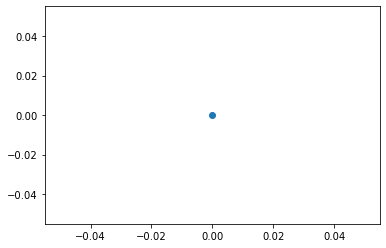

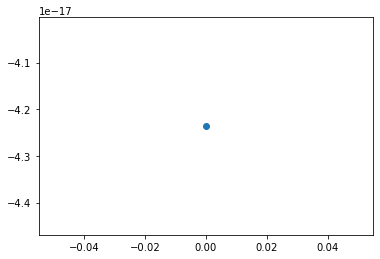

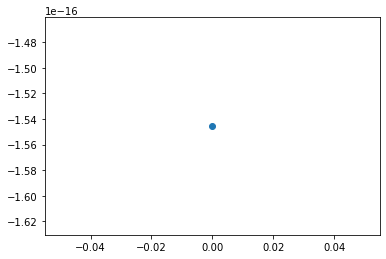

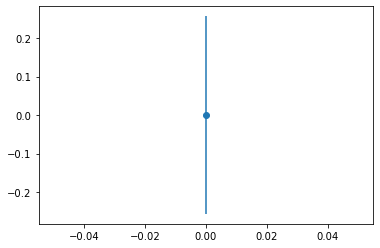

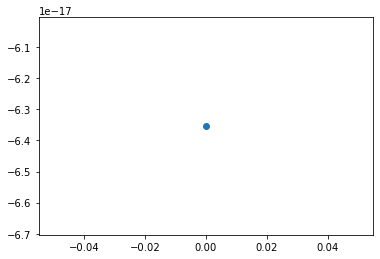

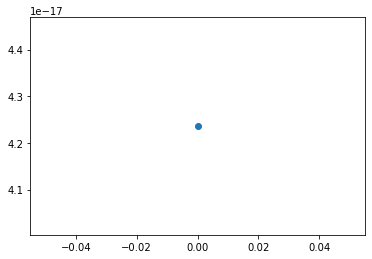

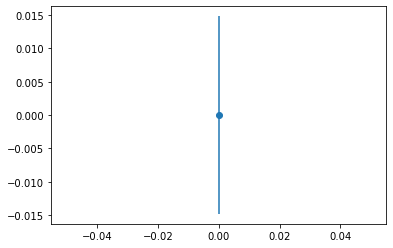

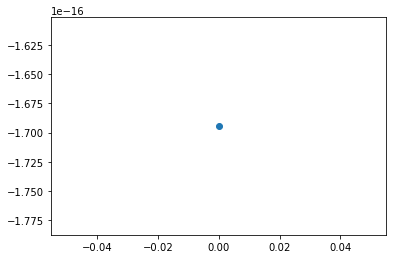

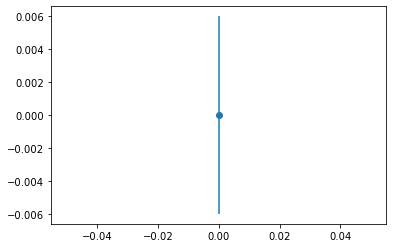

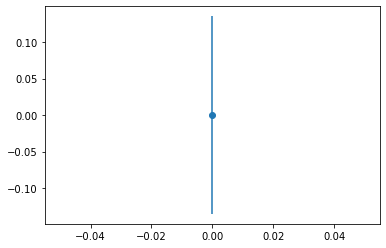

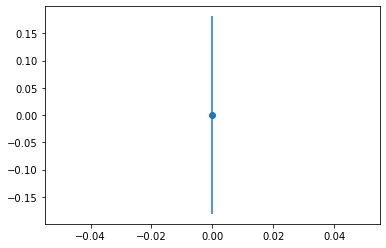

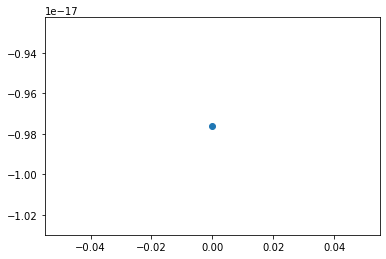

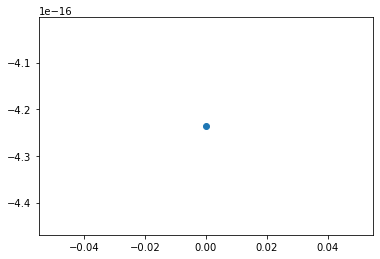

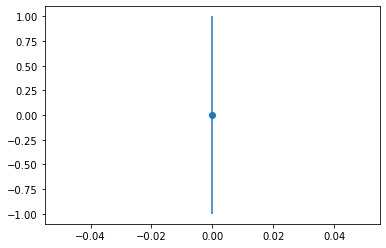

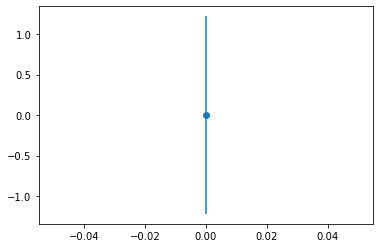

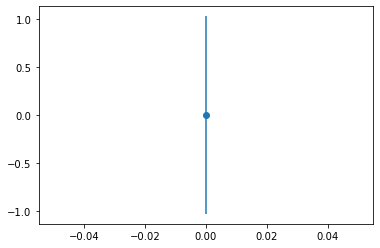

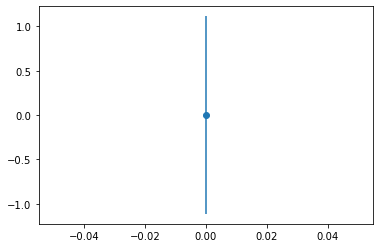

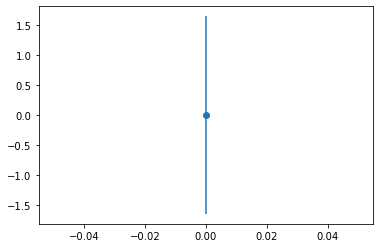

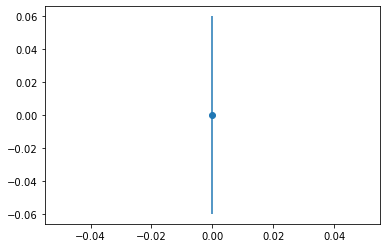

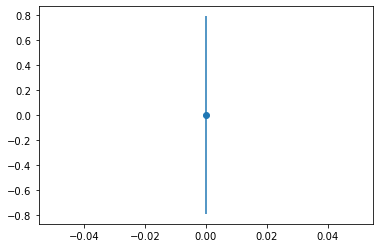

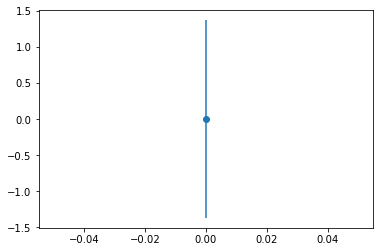

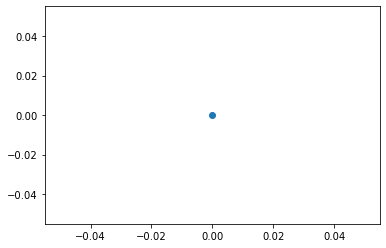

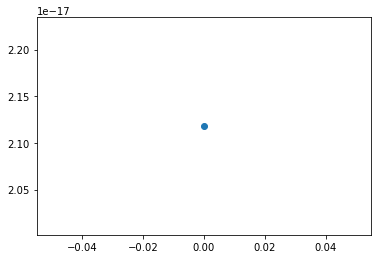

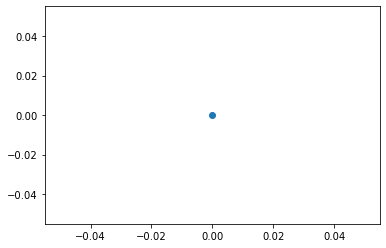

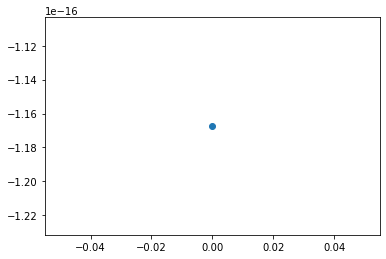

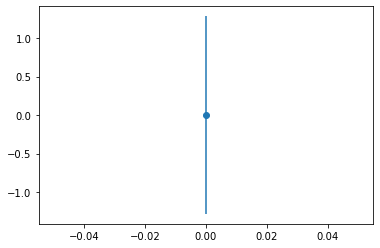

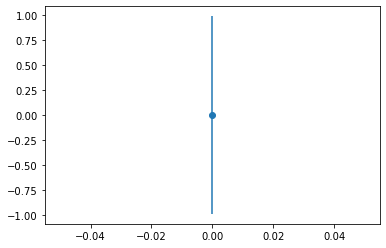

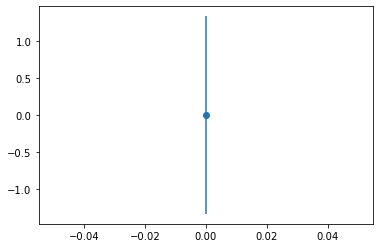

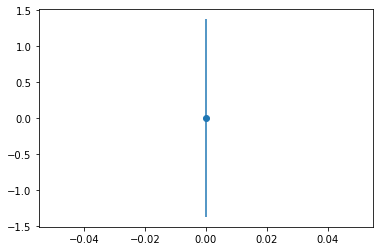

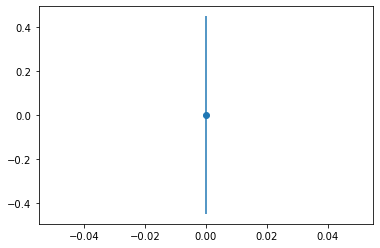

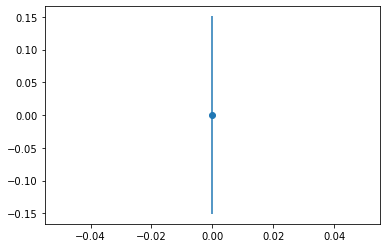

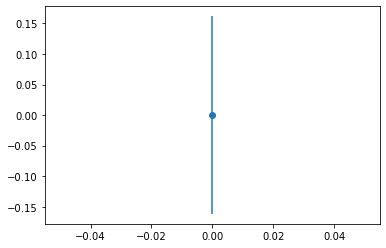

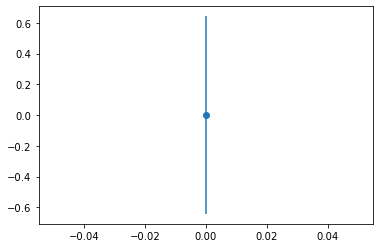

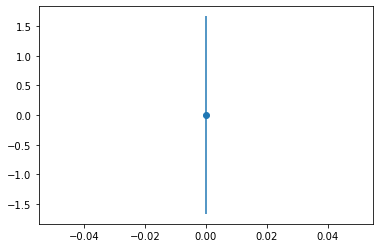

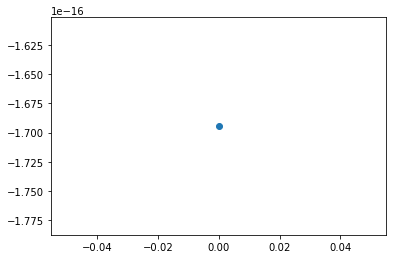

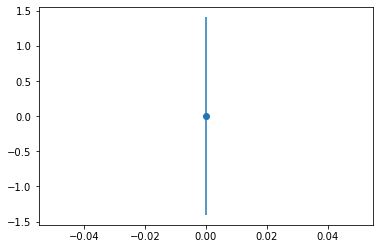

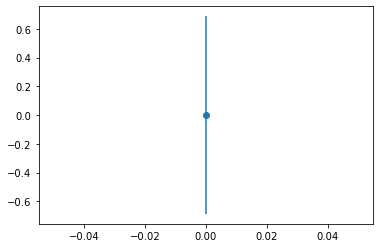

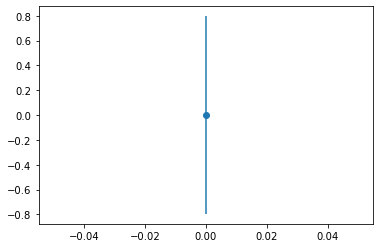

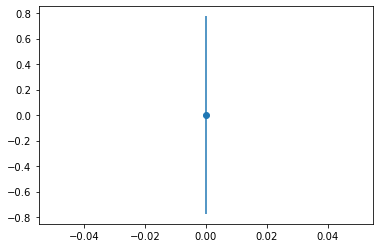

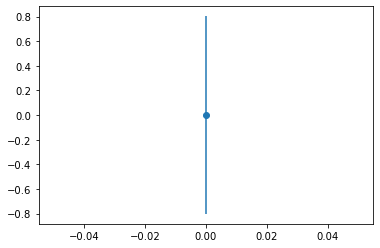

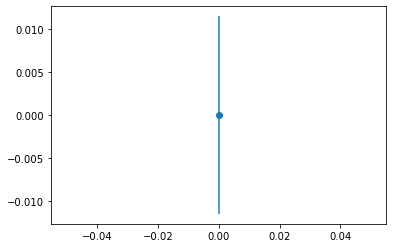

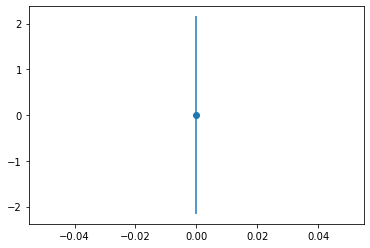

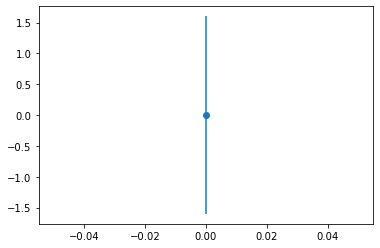

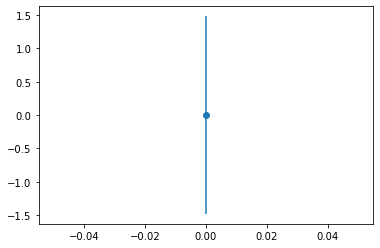

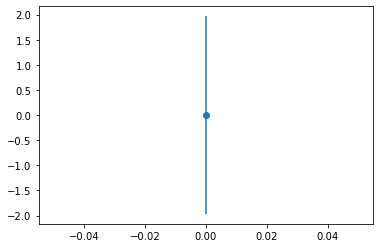

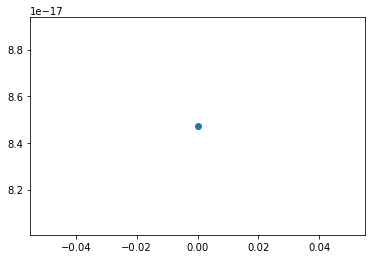

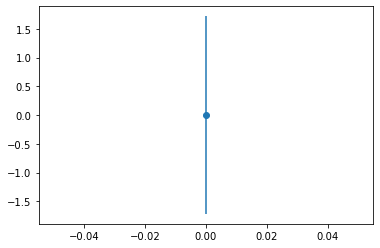

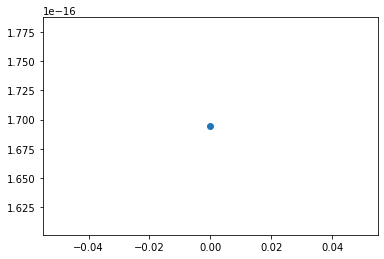

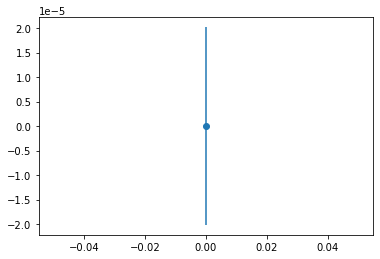

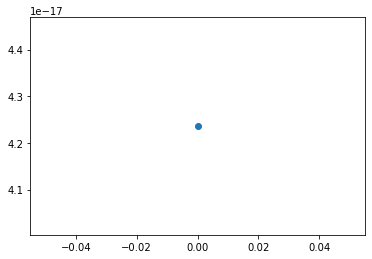

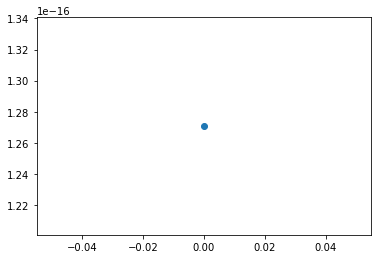

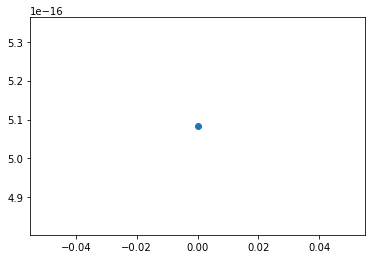

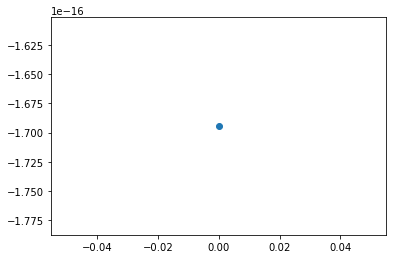

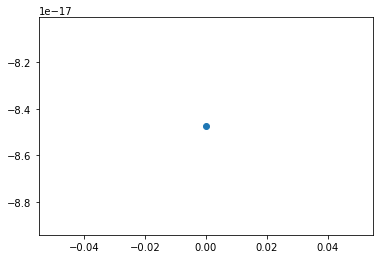

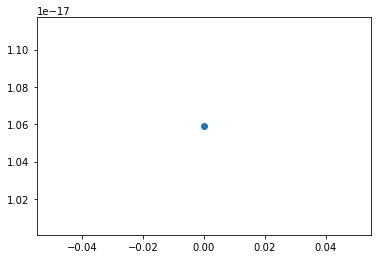

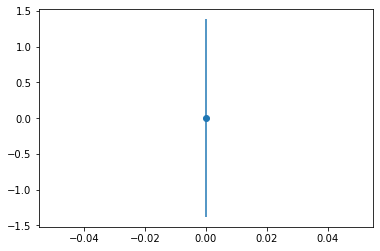

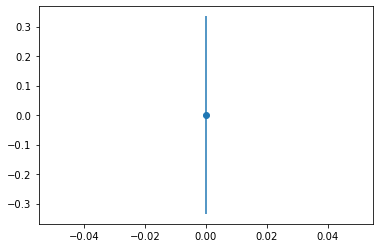

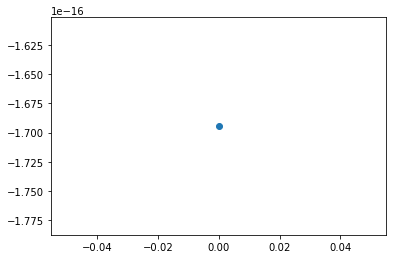

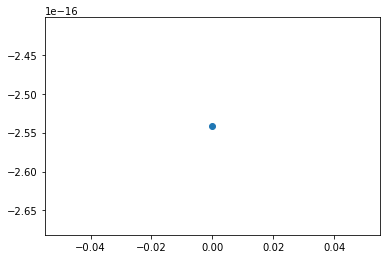

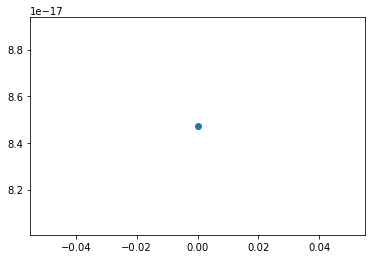

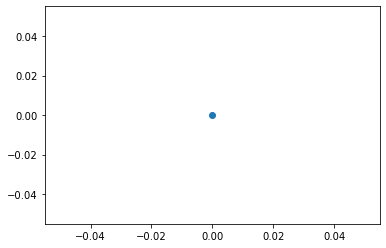

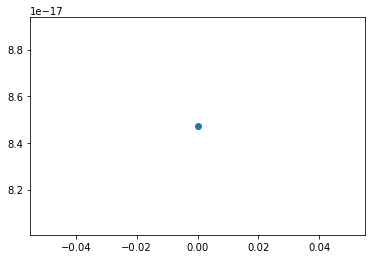

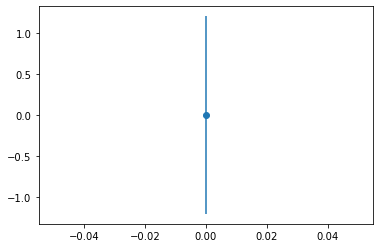

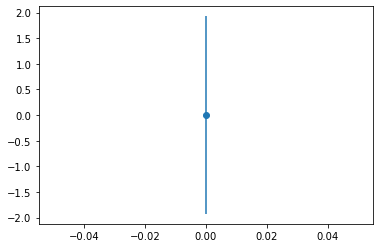

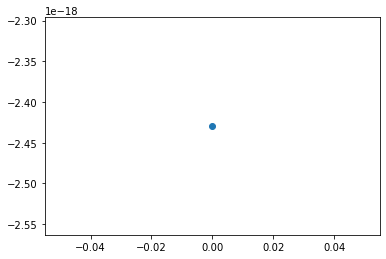

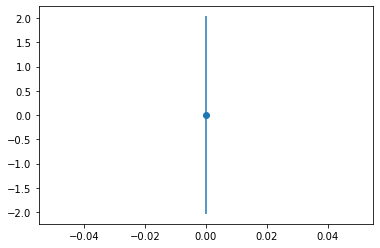

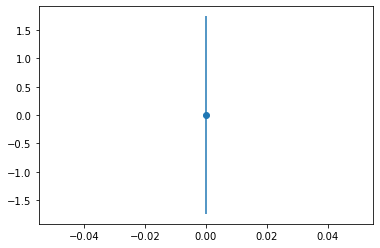

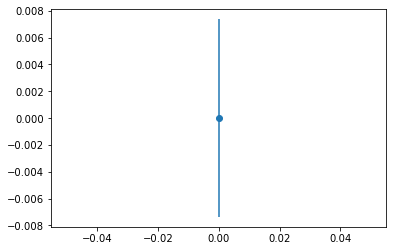

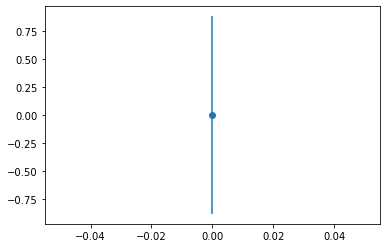

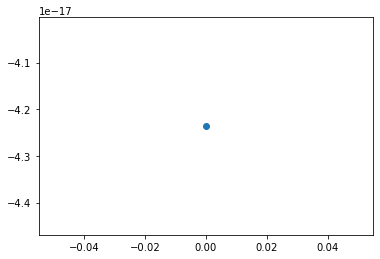

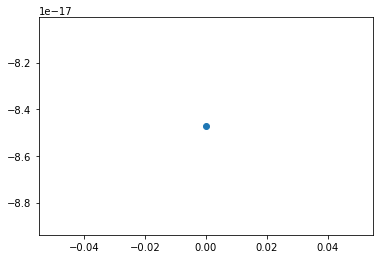

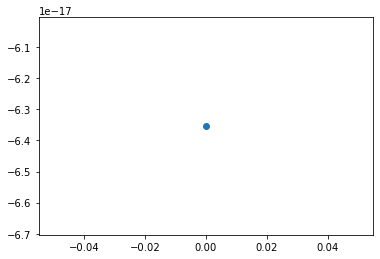

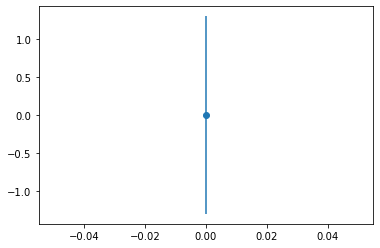

In [13]:
### this will be useful for looking at looking at shift in relative FEs over GENS


for d in details.values():
    if 'complex_fes' in d and 'solvent_fes' in d:
        for i in range(0,7):
            try:
                DDG = ((np.mean(d[f'complex_fes_GEN{i}']) - np.mean(d[f'solvent_fes_GEN{i}']))*kT).value_in_unit(unit.kilocalories_per_mole) 
                dDDG = ((np.mean(d[f'complex_dfes_GEN{i}'])**0.5 + np.mean(d[f'solvent_dfes_GEN{i}'])**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
                plt.errorbar(i, DDG,yerr=dDDG)
                plt.scatter(i,DDG)
            except:
                continue
        plt.show()
